# Importing packages

In [2]:
# Importing packages
import matplotlib.pyplot as plt # seams to be the most used
import matplotlib as mpl # did not dare to mess with plt comand
#plt.style.use('ggplot')
import seaborn as sns
# sns.set(style='whitegrid')
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.lines as mlines
import matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
from matplotlib import dates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
#import plotnine as p9 # Same as ggplot
import pandas as pd
import numpy as np
import math
from scipy.signal import medfilt
import scipy.stats
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import glob
import re


# To get untruncated output from pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Normal Setting global font size for plots
plt.rcParams['font.sans-serif'] = 'Arial'
small_size = 12
medium_size = 14
large_size = 16
plt.rc('axes', titlesize=large_size)     # fontsize of the axes title
plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('legend',fontsize=medium_size)      # fontsize of the legend'
plt.rcParams['axes.xmargin'] = 0         # get rid of margins befor and after data along x-axis
# plt.rcParams["axes.grid"] = False     # remove grid of plots

# remove grid but keep tick marks for the axes
color = 'black'
plt.rc('axes', grid=False, edgecolor=color)
plt.rc('xtick', bottom=True, top=False, color=color)  # Show bottom ticks and hide top ticks for all plots
plt.rc('ytick', left=True, right=False, color=color)  # Show left ticks and hide right ticks for all plots
plt.rc('xtick', labelcolor=color)  # Set x tick label color to black
plt.rc('ytick', labelcolor=color)

colors= ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00','#000000','#BBBBBB'] # https://nanx.me/oneclust/reference/cud.html

# # POSTER Setting global font size for plots
# medium_size = 26
# large_size = 30
# plt.rc('axes', titlesize=large_size)     # fontsize of the axes title
# plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=medium_size)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=medium_size)    # fontsize of the tick labels
# plt.rc('legend',fontsize=medium_size)      # fontsize of the legend'
# plt.rcParams['axes.xmargin'] = 0         # get rid of margins befor and after data along x-axis


# LOADING FUNCTIONS
def sub_sample_df_old(df, moduleMask): # insert dataframe and mask for dataframe
    modules = df[moduleMask]
    if 'Displacement [mm]:' in df.columns:
        subSample = modules[['Date:', 'Displacement [mm]:']]
    if 'Water table [m bgl]:' in df.columns:
        subSample = modules[['Date:', 'Module ID:', 'Water table [m bgl]:']]
    subSample = subSample.set_index('Date:')
    return subSample

# SUBSAMPLING DF's       NEW
def sub_sample_df(df, modules): # insert dataframe and mask for dataframe
    khlist = []
    modules = modules
    for i in modules:
        file = df
        module = i
        moduleMask = file['Module ID:'].isin([module])
        file = file[moduleMask]
        file.set_index('Date:', inplace=True)
        file = file.resample('1h').median()    
        khlist.append(file) # adding modules to list
    df = pd.concat(khlist, axis=1)
    
    # inclinometers
    if 'Displacement [mm]:' in df.columns:
        subSample = df[['Displacement [mm]:']]
    
    # piezometers
    if 'Water table [m bgl]:' in df.columns:
        subSample = df[['Water table [m bgl]:']]
    
    return subSample

# Slice df by time_start and time_end 
def sub_set_df(df, time_start=1, time_end=2):
    mask = (df.index > time_start) & (df.index <= time_end)
    return df[mask]

# # Statsmodel, linear regression over n hours defined by window_hours
# from statsmodels.formula.api import ols
# def linearfit(volume, window_days=0.5, results = False, gps=False):
#     volume = volume.to_frame()
#     df = volume.dropna()
#     df = df.reset_index(drop=True) # due to LinearRgression is not able to calculate with dateformat as x-axis
#     if gps is True:
#         window_hours = 2*window_days
#     else:
#         window_hours = 24*window_days 
#     cutoff_start = df.index.values[0]
#     cutoff_end = cutoff_start + window_hours
#     reg_res = []
#     data_left = True

#     # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
#     while data_left:
#         if cutoff_end > df.index.values[-1]:
#             data_left = False
#             cutoff_end = df.index.values[-1]
#             break   
#         start = df.index.values >= cutoff_start
#         end = df.index.values <= cutoff_end
#         current_data = df[start & end]
#         if len(current_data) > window_hours-1:
#             mod = sm.OLS(y, sm.add_constant(X))
#             mod = ols(formula = 'current_data.values ~ current_data.index', data = current_data) # model
#             fit = mod.fit() # model fit
#             if results is True:
#                 reg_res += [(cutoff_start+window_hours//2, fit.params[1], fit.params[0], fit.rsquared)]  # returns intercept and r^2 in addition to index and slope
#             else:
#                 reg_res += [(cutoff_start+window_hours//2, fit.params[1])]  # returns index and slope
#         cutoff_start += 1
#         cutoff_end = cutoff_start + window_hours

#     # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
#     df.index.name = 'index'
#     df[volume.index.name] = volume.index
#     slopedf = pd.DataFrame(reg_res)
#     if results is True:
#         slopedf.columns = ['index',f'{window_days}_days_velocity', 'intercept', 'r^2'] # NB velocity is the slope of the fit
#         slopedf['y_fit'] = slopedf[f'{window_days}_days_velocity']*slopedf.index+slopedf['intercept']
#         df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
#         df_merged.set_index(volume.index.name,inplace=True, drop=True)
#         df_merged['residuals'] = (df_merged.iloc[:,[1]].values-df_merged.iloc[:,[5]].values) # y-y_hat = resuduals
#         df_merged['error_of_fit'] = ((np.mean(df_merged['residuals']**2))**(1/2))
#         df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna()
#     else:
#         slopedf.columns = ['index',f'{window_days}_days_velocity']
#         df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
#         df_merged.set_index(volume.index.name,inplace=True, drop=True)
#         df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna()

# NEW VERSION !

# Statsmodel, linear regression over n hours defined by window_hours
from statsmodels.formula.api import ols
def linearfit(volume, window_days=0.5, results = False, gps=False): # added gps= to get rows that fit gps days velocity
    volume = volume.to_frame()
    df = volume.copy()
    df = df.reset_index(drop=True) # due to LinearRgression is not able to calculate with dateformat as x-axis
    if gps is True:
        window_hours = 2*window_days
    else:
        window_hours = 24*window_days 
    cutoff_start = df.index.values[0]
    cutoff_end = cutoff_start + window_hours
    reg_res = []
    data_left = True # starts loop

    # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
    while data_left:
        if cutoff_end > df.index.values[-1]:
            data_left = False # stops loop
            cutoff_end = df.index.values[-1]
            break   
        start = df.index.values >= cutoff_start
        end = df.index.values <= cutoff_end
        current_data = df[start & end]
        current_data = current_data.squeeze()
        # added part so no need of interpolation, but perhaps for boreholes?
        if max(current_data.isnull().astype(int).groupby(current_data.notnull().astype(int).cumsum()).cumsum()) > window_hours/4: # True if more than consecutive nans
            current_data = current_data.dropna(axis=0) # deletes nan so df is to small to get true in next if statement
        
        if len(current_data) > window_hours-1:
            mod = ols(formula = 'current_data.values ~ current_data.index', data = current_data) # model
            fit = mod.fit() # model fit
            if results is True:
                reg_res += [(cutoff_start+window_hours//2, fit.params[1], fit.params[0], fit.rsquared)]  # returns intercept and r^2 in addition to index and slope
            else:
                reg_res += [(cutoff_start+window_hours//2, fit.params[1])]  # returns index and slope
        cutoff_start += 1
        cutoff_end = cutoff_start + window_hours

    # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
    df.index.name = 'index'
    df[volume.index.name] = volume.index
    slopedf = pd.DataFrame(reg_res)
    if results is True:
        slopedf.columns = ['index',f'{window_days}_days_velocity', 'intercept', 'r^2'] # NB velocity is the slope of the fit
        slopedf['y_fit'] = slopedf[f'{window_days}_days_velocity']*slopedf.index+slopedf['intercept']
        df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
        df_merged.set_index(volume.index.name,inplace=True, drop=True)
        df_merged['residuals'] = (df_merged.iloc[:,[1]].values-df_merged.iloc[:,[5]].values) # y-y_hat = resuduals
        df_merged['error_of_fit'] = ((np.mean(df_merged['residuals']**2))**(1/2))
        df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna() # this might be a problem in the future.. But I will comment it and get data with nans
        return df_merged
    else:
        slopedf.columns = ['index',f'{window_days}_days_velocity']
        df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
        df_merged.set_index(volume.index.name,inplace=True, drop=True)
        df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna() # this might be a problem in the future.. But I will comment it and get data with nans
        return df_merged
    
# cross correlation and its p-value
def pearsonr_crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), method='pearson')

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def pearsonr_crosscorr_pval(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), method=pearsonr_pval)

def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# STA/LTA FILTER WITH CREEP BURST THRESHOLD 
def sta_lta(df, STA=2, LTA=60, detrigg_on=True, trigg=2, detrigg=1, threshold_dynamic=True):
    df = pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=LTA), on=df.index.name, tolerance=pd.Timedelta(hours=0))
    
    # add STA if it is not in the df
    if not f'{STA}_days_velocity' in df.columns:
        df.set_index(df.columns[0], drop=True, inplace=True)
        df = pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=STA), on=df.index.name, tolerance=pd.Timedelta(hours=0))
    
    # setting STA and LTA 
    df['sta'] = df[f'{STA}_days_velocity'].values # use 1_day or 2_days ?
    df['lta'] = df[f'{LTA}_days_velocity'].values
#     df.loc[:, 'lta'] = df[f'{LTA}_days_velocity'].shift(LTA*24//2) # shifts lta to start at end of window, not middle. This was used in seismology but did not seam to work as well on our time series
    df['sta/lta'] = df['sta']/df['lta']
    
    # creep burst threshold
    df['trigger'] = np.nan
    df['detrigger'] = np.nan
    
    if threshold_dynamic is True:
        # dynamic threshold
        window_length = LTA*24 # the start of mean calculation
        for i,d in enumerate(df['sta/lta'][window_length+window_length//2:-window_length//2]):
            # window from start to end of sta/lta
            window = df.loc[i+window_length:i+window_length*2, 'sta/lta']
            sigma = np.sqrt((np.sum(np.square(window-np.mean(window))))/len(window-1))
            # inserting mean + sigma in center of window
            df.loc[i+window_length+window_length//2, 'trigger'] = np.mean(window)+sigma*trigg # 2 x SD centered 
            df.loc[i+window_length+window_length//2, 'detrigger'] = np.mean(window)+sigma*detrigg # 1 x SD centered
    else:
        # static threshold
        sigma = np.sqrt((np.sum(np.square(df['sta/lta']-np.mean(df['sta/lta']))))/len(df['sta/lta']-1))
        df['trigger'] = np.mean(df['sta/lta'])+sigma*trigg
        df['detrigger'] = np.mean(df['sta/lta'])+sigma*detrigg
    
    # selecting creep bursts
    df['nBursts'] = 0
    prev_d = 0
    prev_burst_idx = 0
    indexes = []
    above_trigg = False
    
    if detrigg_on is True:
        for i, d in enumerate(df['sta/lta']):
            # trigger threshold
            if d > df.loc[i, 'detrigger']:
                indexes += [i]
                if d > df.loc[i, 'trigger']:
                    above_trigg = True
            else:
                if above_trigg:
                    df.loc[indexes, 'nBursts'] = 1
                indexes = []
                above_trigg = False
    df.set_index(df.columns[0], drop=True, inplace=True)
    return df

def velocity(df, window_days=4, results=True):
    df =  pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=window_days, results=results), on=df.index.name, tolerance=pd.Timedelta(hours=0)) #results=True to get additional results
    df.set_index(df.columns[0], drop=True, inplace=True) # reinsetting the datetime index
    return df

# When agreed on how it should look like, make this a part of the pre_plotting script

def creep_database(df, STA):
    
    # time resolution
    hours = 60*60 # in hours
    days = hours*24 # in days

    # fetching creep events
    window = []
    previous_d = 0
    for i, d in enumerate(df['nBursts']):
            if d != previous_d:
                previous_d = d
                window.append(df.index[i:i+1])
    # creating database of creep bursts
    idx = np.arange(0, len(window), 2)  # index to slice at even numbers
    idx2 = np.arange(0, len(idx), 1)

    creep_database = pd.DataFrame(idx2, columns=['event']) # length of df
    date_start = []
    date_end = []
    duration = []
    duration_days = []
    date = []
    displacement_start = []
    displacement = []
    velocity = []
    velocity_days = []
    slip_distance = []

    # loading each event and saving data to database
    for start in idx:
        creep_event = df.loc[window[start][0]:window[start+1][0]] # the last row in df is not part of creep burst event
        date_start.append(creep_event.index[0])
        date_end.append(creep_event.index[-1])
        duration.append((creep_event.index[-1]-creep_event.index[0]).total_seconds()//hours) # duration in hours
        duration_days.append((creep_event.index[-1]-creep_event.index[0]).total_seconds()//days) # duration in days
        date.append((creep_event.index[:-1]-creep_event.index[0]).total_seconds()//hours) # to be able to plot each event
        displacement_start.append(creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # to make plotting on top of entire dataseries easier
        displacement.append(creep_event['displacement_butterfilt'][:-1].values-
                            creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # to be able to plot each event
        slip_distance.append(creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].last_valid_index()]-
                             creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # total displacement
        velocity.append(np.nanmax(creep_event[f'{STA}_days_velocity'][:-1])) # max velocity for 'n_days_velocity' per day

    creep_database['date_start'] = date_start
    creep_database['date_end'] = date_end
    creep_database['duration'] = duration
    creep_database['date'] = date # to be able to plot each event
    creep_database['displacement_start'] = displacement_start # to be able to plot each event ontop of entire timeseries
    creep_database['displacement'] = displacement # to be able to plot each event
    creep_database['total_slip_distance'] = slip_distance
    creep_database['max_velocity'] = velocity
#     # the below are for the creep database plots in days
    creep_database['duration_days'] = duration_days 
    creep_database['nEvents'] = 1
    
    return creep_database


# function to sum for two months (window_days). Used for seismics and surface runoff
def sum_period(volume, window_days=60):
    volume = volume.to_frame()
    window_hours = 24*window_days
    df = volume.copy()
    df = df.reset_index(drop=True)
    cutoff_start = df.index.values[0]
    cutoff_end = cutoff_start + window_hours
    summed_data = []
    data_left = True # starts loop

    # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
    while data_left:
        if cutoff_end > df.index.values[-1]:
            data_left = False # stops loop
            cutoff_end = df.index.values[-1]
            break   
        start = df.index.values >= cutoff_start
        end = df.index.values <= cutoff_end
        current_data = df[start & end]
        current_data = current_data.squeeze()

        if max(current_data.isnull().astype(int).groupby(current_data.notnull().astype(int).cumsum()).cumsum()) > window_hours/4: # True if more than consecutive nans
                current_data = current_data.dropna(axis=0) # deletes nan so df is to small to get true in next if statement

        if len(current_data) > window_hours-1:
            summed = current_data.sum()
            summed_data += [(cutoff_start+window_hours//2, summed)]  # returns index and summation of events in the time window, 1 month before and after, so centered
        cutoff_start += 1
        cutoff_end = cutoff_start + window_hours

    # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
    df.index.name = 'index'
    df[volume.index.name] = volume.index # make same name for both indexes to be able to merge on name
    new_df = pd.DataFrame(summed_data)

    new_df.columns = ['index',f'{window_days}_days_summed']
    df_merged = pd.merge_asof(df,new_df, on=df.index.name, tolerance=0)
    df_merged.set_index(volume.index.name,inplace=True, drop=True)
    df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
    return df_merged

def reindexing_1h(df):
    idx = pd.date_range(start=df.index[0],end=df.index[-1],freq='1h')
    df = df.reindex(idx)
    return df

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

# Loading data

## Loading Åknes

In [3]:
# set folder related to script location

path = '..\\Åknes\\pre_plotting\\'  # set folder related to script location


# path = 'pre_plotting_march24\\' # newest data, to look for Nadage's paper

extension = '.pkl'

# Seismicity
seismicity = pd.read_pickle(path + 'seismicity' + extension)
# seismicity_qcd = pd.read_pickle(path + 'seismicity_qcd' + extension)
# seismicity_bh = pd.read_pickle(path + 'seismicity_bh' + extension)
# seismicity_bh_availability = pd.read_csv('seismicity_borehole\\availability_seismic_borehole.csv', sep='\t', parse_dates=['t_on', 't_off'])
# seismicity_bh_availability['t_on'] = seismicity_bh_availability['t_on'].dt.tz_localize(None)
# seismicity_bh_availability['t_off'] = seismicity_bh_availability['t_off'].dt.tz_localize(None)

seismicity_bh_class = pd.read_pickle(path + 'seismicity_bh_clasifiedevents' + extension)
# seismicity_bh_class_wUnknow = pd.read_pickle(path + 'seismicity_bh_clasifiedevents_wUnknown' + extension)
# seismic_energy = pd.read_pickle(path + 'seismic_energy' + extension)

# ## Laser
# laserLower = pd.read_pickle(path + 'laserLower' + extension)
# laserUpper = pd.read_pickle(path + 'laserUpper' + extension)

# ## Extensometer
# ext1 = pd.read_pickle(path + 'ext1' + extension)
# ext2 = pd.read_pickle(path + 'ext2' + extension)
# ext3 = pd.read_pickle(path + 'ext3' + extension)

## GPS
# 12 hour data
ak_gps2 = pd.read_pickle(path + 'gps_2' + extension)
ak_gps3 = pd.read_pickle(path + 'gps_3' + extension)
ak_gps4 = pd.read_pickle(path + 'gps_4' + extension)
ak_gps5 = pd.read_pickle(path + 'gps_5' + extension)
ak_gps6 = pd.read_pickle(path + 'gps_6' + extension)
ak_gps10 = pd.read_pickle(path + 'gps_10' + extension)
ak_gps11 = pd.read_pickle(path + 'gps_11' + extension)
# # 4 hour data
# gps3_4h = pd.read_pickle(path + 'gps3_4h' + extension)
# gps4_4h = pd.read_pickle(path + 'gps4_4h' + extension)

## Meteorological XGEO (Modeled weather data that is better than the cautus weather station)
ak_precip = pd.read_pickle(path + 'precip' + extension)
ak_temp = pd.read_pickle(path + 'temp' + extension)
ak_snow = pd.read_pickle(path + 'snow' + extension)
ak_snowrain_melt = pd.read_pickle(path + 'snowrain_melt' + extension)

# # ## Borhole packer pressure
# KH0117_packer = pd.read_pickle(path + 'KH0117_packer' + extension)
# KH0217_packer = pd.read_pickle(path + 'KH0217_packer' + extension)
# KH0118_packer = pd.read_pickle(path + 'KH0118_packer' + extension)
# KH0218_packer = pd.read_pickle(path + 'KH0218_packer' + extension)

## Borholes raw data
KH0306Piez_raw = pd.read_pickle(path + 'KH0306Piez_raw' + extension)

KH0206DispUpperZone_raw = pd.read_pickle(path + 'KH0206DispUpperZone_raw' + extension)
KH0206DispLowerZone_raw = pd.read_pickle(path + 'KH0206DispLowerZone_raw' + extension)
KH0206PiezUpperZone_raw = pd.read_pickle(path + 'KH0206PiezUpperZone_raw' + extension)
KH0206PiezLowerZone_raw = pd.read_pickle(path + 'KH0206PiezLowerZone_raw' + extension)

# KH0206Disp_raw = pd.read_pickle(path + 'KH0206Disp_raw' + extension)
# KH0206Piez_raw = pd.read_pickle(path + 'KH0206Piez_raw' + extension)
# KH0206Piez_raw_long = pd.read_pickle(path + 'KH0206Piez_raw_long' + extension) # for the long duration plot

KH0112DispUpperZone_raw = pd.read_pickle(path + 'KH0112DispUpperZone_raw' + extension)
KH0112DispLowerZone_raw = pd.read_pickle(path + 'KH0112DispLowerZone_raw' + extension)
KH0112PiezUpperZone_raw = pd.read_pickle(path + 'KH0112PiezUpperZone_raw' + extension)
KH0112PiezLowerZone_raw = pd.read_pickle(path + 'KH0112PiezLowerZone_raw' + extension)

# KH0112Piez_raw = pd.read_pickle(path + 'KH0112Piez_raw' + extension) 
# KH0112Piez_raw_long = pd.read_pickle(path + 'KH0112Piez_raw_long' + extension) # for the long duration plot

KH0117Disp_raw = pd.read_pickle(path + 'KH0117Disp_raw' + extension)
KH0117Piez_raw = pd.read_pickle(path + 'KH0117Piez_raw' + extension)

KH0217DispUpperZone_raw = pd.read_pickle(path + 'KH0217DispUpperZone_raw' + extension)
KH0217PiezUpperZone_raw = pd.read_pickle(path + 'KH0217PiezUpperZone_raw' + extension)

KH0217DispLowerZone_raw = pd.read_pickle(path + 'KH0217DispLowerZone_raw' + extension)
KH0217PiezLowerZone_raw = pd.read_pickle(path + 'KH0217PiezLowerZone_raw' + extension)

KH0118Disp_raw = pd.read_pickle(path + 'KH0118Disp_raw' + extension)
KH0118Piez_raw = pd.read_pickle(path + 'KH0118Piez_raw' + extension)

KH0218Disp_raw = pd.read_pickle(path + 'KH0218Disp_raw' + extension)
KH0218Piez_raw = pd.read_pickle(path + 'KH0218Piez_raw' + extension)

## Borholes cumulated modules
KH0206DispUpperZone = pd.read_pickle(path + 'KH0206DispUpperZone_Cumulated' + extension)
KH0206PiezUpperZone = pd.read_pickle(path + 'KH0206PiezUpperZone_Cumulated' + extension)

KH0206DispLowerZone = pd.read_pickle(path + 'KH0206DispLowerZone_Cumulated' + extension)
KH0206PiezLowerZone = pd.read_pickle(path + 'KH0206PiezLowerZone_Cumulated' + extension)

KH0112DispUpperZone = pd.read_pickle(path + 'KH0112DispUpperZone_Cumulated' + extension)
KH0112PiezUpperZone = pd.read_pickle(path + 'KH0112PiezUpperZone_Cumulated' + extension)
KH0112DispLowerZone = pd.read_pickle(path + 'KH0112DispLowerZone_Cumulated' + extension)
KH0112PiezLowerZone = pd.read_pickle(path + 'KH0112PiezLowerZone_Cumulated' + extension)

KH0117Disp = pd.read_pickle(path + 'KH0117Disp_Cumulated' + extension)
KH0117Piez = pd.read_pickle(path + 'KH0117Piez_Cumulated' + extension)

KH0217DispUpperZone = pd.read_pickle(path + 'KH0217DispUpperZone_Cumulated' + extension)
KH0217PiezUpperZone = pd.read_pickle(path + 'KH0217PiezUpperZone_Cumulated' + extension)

KH0217DispLowerZone = pd.read_pickle(path + 'KH0217DispLowerZone_Cumulated' + extension)
KH0217PiezLowerZone = pd.read_pickle(path + 'KH0217PiezLowerZone_Cumulated' + extension)

KH0118Disp = pd.read_pickle(path + 'KH0118Disp_Cumulated' + extension)
KH0118Piez = pd.read_pickle(path + 'KH0118Piez_Cumulated' + extension)

KH0218Disp = pd.read_pickle(path + 'KH0218Disp_Cumulated' + extension)
KH0218Piez = pd.read_pickle(path + 'KH0218Piez_Cumulated' + extension)

# changing velocity from mm/hour to mm/day
t = 24 # multiply by 24 to get mm/day
KH0206DispUpperZone['32_days_velocity'] = KH0206DispUpperZone['32_days_velocity']*t
KH0206DispLowerZone['32_days_velocity'] = KH0206DispLowerZone['32_days_velocity']*t
KH0112DispUpperZone['12_days_velocity'] = KH0112DispUpperZone['12_days_velocity']*t
KH0112DispLowerZone['12_days_velocity'] = KH0112DispLowerZone['12_days_velocity']*t
KH0117Disp['8_days_velocity'] = KH0117Disp['8_days_velocity']*t
KH0217DispUpperZone['12_days_velocity'] = KH0217DispUpperZone['12_days_velocity']*t
KH0217DispLowerZone['12_days_velocity'] = KH0217DispLowerZone['12_days_velocity']*t
KH0118Disp['4_days_velocity'] = KH0118Disp['4_days_velocity']*t
KH0218Disp['4_days_velocity'] = KH0218Disp['4_days_velocity']*t

KH0206DispUpperZone['120_days_velocity'] = KH0206DispUpperZone['120_days_velocity']*t
KH0206DispLowerZone['120_days_velocity'] = KH0206DispLowerZone['120_days_velocity']*t
KH0112DispUpperZone['60_days_velocity'] = KH0112DispUpperZone['60_days_velocity']*t
KH0112DispLowerZone['60_days_velocity'] = KH0112DispLowerZone['60_days_velocity']*t
KH0117Disp['60_days_velocity'] = KH0117Disp['60_days_velocity']*t
KH0217DispUpperZone['60_days_velocity'] = KH0217DispUpperZone['60_days_velocity']*t
KH0217DispLowerZone['60_days_velocity'] = KH0217DispLowerZone['60_days_velocity']*t
KH0118Disp['60_days_velocity'] = KH0118Disp['60_days_velocity']*t
KH0218Disp['60_days_velocity'] = KH0218Disp['60_days_velocity']*t

# creating creep database
KH0218Disp_creep = creep_database(KH0218Disp, STA=4)
KH0118Disp_creep = creep_database(KH0118Disp, STA=4)
KH0217DispLowerZone_creep = creep_database(KH0217DispLowerZone, STA=12)
KH0217DispUpperZone_creep = creep_database(KH0217DispUpperZone, STA=12)
KH0117Disp_creep = creep_database(KH0117Disp, STA=8)
KH0112DispLowerZone_creep = creep_database(KH0112DispLowerZone, STA=12)
KH0112DispUpperZone_creep = creep_database(KH0112DispUpperZone, STA=12)
KH0206DispUpperZone_creep = creep_database(KH0206DispUpperZone, STA=32)
KH0206DispLowerZone_creep = creep_database(KH0206DispLowerZone, STA=32)

## Loading Jettan and Gamanjunni

In [4]:
# New seismic data 
path = 'Seismic_analysis\\'  # set folder related to script location
seismic = pd.read_csv(path + 'dvvJettan_NoFilter.txt', sep='\t') 
seismic = pd.read_csv(path + 'dvvJettan_svd03.txt', sep='\t') 
seismic = pd.read_csv(path + 'dvvJettan_svd07.txt', sep='\t') 
seismic['Datetime'] = pd.to_datetime(seismic['date'], format='%d.%m.%y', errors='coerce')
seismic = seismic.set_index('Datetime')
seismic = seismic.drop(columns=['date'])

path = 'pre_plotting\\'  # set folder related to script location

extension = '.pkl'

## GPS
# 12 hour data
jtt_gps2 = pd.read_pickle(path + 'jett_gps_2' + extension)
jtt_gps3 = pd.read_pickle(path + 'jett_gps_3' + extension)
jtt_gps4 = pd.read_pickle(path + 'jett_gps_4' + extension)
jtt_gps5 = pd.read_pickle(path + 'jett_gps_5' + extension)
jtt_gps6 = pd.read_pickle(path + 'jett_gps_6' + extension)
jtt_gps7 = pd.read_pickle(path + 'jett_gps_7' + extension)
jtt_gps8 = pd.read_pickle(path + 'jett_gps_8' + extension)
jtt_gps9 = pd.read_pickle(path + 'jett_gps_9' + extension)
jtt_gps10 = pd.read_pickle(path + 'jett_gps_10' + extension)
jtt_gps11 = pd.read_pickle(path + 'jett_gps_11' + extension)

# gam_gps3 = pd.read_pickle(path + 'gam_gps_3' + extension)
# gam_gps4 = pd.read_pickle(path + 'gam_gps_4' + extension)
# gam_gps5 = pd.read_pickle(path + 'gam_gps_5' + extension)
# gam_gps6 = pd.read_pickle(path + 'gam_gps_6' + extension)
# gam_gps7 = pd.read_pickle(path + 'gam_gps_7' + extension)
# gam_gps8 = pd.read_pickle(path + 'gam_gps_8' + extension)
# gam_gps9 = pd.read_pickle(path + 'gam_gps_9' + extension)
# gam_gps10 = pd.read_pickle(path + 'gam_gps_10' + extension)

# # ak_gps4 = pd.read_pickle(path + 'ak_gps_4' + extension)
# # ak_gps5 = pd.read_pickle(path + 'ak_gps_5' + extension)

# # # 4 hour data
# # gps3_4h = pd.read_pickle(path + 'gps3_4h' + extension)
# # gps4_4h = pd.read_pickle(path + 'gps4_4h' + extension)

## Meteorological data from Senorge (real data) and XGEO (Modeled weather data that is better than the cautus weather station)
jtt_xgeo_rain = pd.read_pickle(path + 'xgeo_rain' + extension)
jtt_xgeo_temp = pd.read_pickle(path + 'xgeo_temp' + extension)
jtt_xgeo_snow = pd.read_pickle(path + 'xgeo_snow' + extension)
jtt_temp = pd.read_pickle(path + 'jtt_temp' + extension)
jtt_precip = pd.read_pickle(path + 'jtt_precip' + extension)
jtt_snow = pd.read_pickle(path + 'jtt_snow' + extension)
jtt_xgeo_surfacerunnoff = pd.read_pickle(path + 'xgeo_surfacerunnoff' + extension)
JT_CLM_1 = pd.read_pickle(path + 'JT_CLM_1' + extension)
ST = pd.read_pickle(path + 'ST' + extension)
tlt2_temp = pd.read_pickle(path + 'tlt2_temp' + extension)
tlt9_temp = pd.read_pickle(path + 'tlt9_temp' + extension)
hobos = pd.read_pickle(path + 'hobos' + extension)
temp1 = pd.read_pickle(path + 'temp1' + extension)

# river data measurements
river1 = pd.read_pickle(path + 'river1' + extension)
river2 = pd.read_pickle(path + 'river2' + extension)

# ## Borholes
# Raw is without filtered and without raw is filtered
# Jettan
JTT1Disp = pd.read_pickle(path + 'JTT1Disp_raw' + extension)
JTT1Wp = pd.read_pickle(path + 'JTT1Wp_raw' + extension)

JTT2DispUpperZone = pd.read_pickle(path + 'JTT2DispUpperZone_raw' + extension)
JTT2WpUpperZone = pd.read_pickle(path + 'JTT2WpUpperZone_raw' + extension)

JTT2DispLowerZone = pd.read_pickle(path + 'JTT2DispLowerZone_raw' + extension)
JTT2WpLowerZone = pd.read_pickle(path + 'JTT2WpLowerZone_raw' + extension)

JTT3Disp = pd.read_pickle(path + 'JTT3Disp_raw' + extension)
JTT3Wp = pd.read_pickle(path + 'JTT3Wp_raw' + extension)

# Exporting data to R

In [104]:
new_df.head()

Mod4_Water pressure [m]:  Mod4_Water pressure in shear zone [kPa]:  Mod4_Temperature [deg C]:  Mod4_Hydraulic head [masl]:
Date:                                                                                                                                          
2014-07-17 15:00:00                  7.409761                                       0.0                        2.9                   571.409761
2014-07-17 16:00:00                  7.418753                                       0.0                        2.9                   571.418753
2014-07-17 17:00:00                  7.427927                                       0.0                        2.9                   571.427927
2014-07-17 18:00:00                  7.437333                                       0.0                        2.9                   571.437333
2014-07-17 19:00:00                  7.446954                                       0.0                        2.9                   571.446954

In [105]:
#### create slice of df  #####
start_time = pd.Timestamp('2015-01-01')
end_time = pd.Timestamp('2018-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
z = z[z.index.slice_indexer(start_time,end_time)]
z = z.resample('1d').median()

f = ST.iloc[:,0] # hourly data intervals
f = f[f.index.slice_indexer(start_time,end_time)]
f = f.resample('1d').median()

df = pd.DataFrame({'Disp':x, 'WP':y, 'Temp': z, 'Rock_temp':f})
df.dropna(inplace=True)

# # Split into train and test
# cutoff_index = int(df.shape[0] * 0.8) # train with xx % data
# df_train = df.iloc[:cutoff_index]
# df_test = df.iloc[cutoff_index:]

df_train = df.copy()
# now scale and transform data so variables are of similar weight
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed

# differencing n rows to get seasonal and trend removed to obtain statinarity
def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series.reshape(-1) # transform back to correct shape

# Apply decompose (decompose trend, seasonality, and resudials) to make data stationary
from statsmodels.tsa.seasonal import STL

df_list = []
for i,d in enumerate(df_train.columns):
    df = []
    freq = 365

    decomposed_series = STL(df_train.loc[:,d], seasonal=13, period=365).fit()
    trend = decomposed_series.trend
    seasonal = decomposed_series.seasonal
    residual = decomposed_series.resid
    original = df_train.loc[:,d].copy()
    removed_trend = original-trend
    norm_removed_trend = norm(removed_trend) # the normalization does not work for some reason..
    diff_trend = diff_shift(original, 1) # first order differencing # previosly named diff_trend
    diff_seasonal = diff_shift(original, 365) # this is not stationary
    diff_trend_season = diff_shift(diff_seasonal, 1) # correct way according to detrend and deseasonlize: https://online.stat.psu.edu/stat510/lesson/4/4.1
    rolling_diff = original.rolling(3).mean()-original # more than 7 days gives higher std values than diff_trend
    norm_diff = norm(diff_trend) # the normalization does not work for some reason.. # need to normalize to make the relationships 'scaled correctly'
    df = pd.DataFrame({'original':original.values, 'trend': trend.values, 'seasonal':seasonal.values, 'residual':residual.values, 'orig-trend':removed_trend.values,
                       'diff_trend_season':diff_trend_season.values, 'diff':diff_trend.values, 'norm_diff': norm_diff, 'rolling_diff':rolling_diff.values}, index=df_train.index)
    df.dropna(inplace=True)
    
#     #### Comment this part out when finished looking at what series is stationary  ####
#     # correlating?
#     print(f'{d}')
#     # print(df.corr()) # correlations

#     #### testing stationarity ####
#     from statsmodels.tsa.stattools import adfuller
#     for i, variable in enumerate(df.columns):
#         # Perform the ADF test
#         result = adfuller(df[variable])

#         # Extract and print the p-value from the test result
#         p_value = result[1]
#         print("p-value:", p_value)

#         # Interpret the result
#         if p_value <= 0.05: # 0.05 or 0.001
#             print(f"The variable {variable} is stationary.\n")
#         else:
#             print(f"The variable {variable} is not stationary.\n")
# ###############################

    # # choosing just one year
    # df = df[df.index.slice_indexer(pd.Timestamp('2016-01-01'),pd.Timestamp('2017-01-01'))]

    df_list.append(df)
    
col = 'diff' # only use the ones that passes ADF test
df = pd.DataFrame({'Disp':df_list[0].loc[:,col], 'WP':df_list[1].loc[:,col], 'Temp':df_list[2].loc[:,col],'Rock_temp':df_list[3].loc[:,col]}) # only disp original is not stationary so chosen orig-trend, others original
df = pd.DataFrame(scaler.fit_transform(df),columns=['Disp', 'WP', 'Temp','Rock_temp'], index=df.index) # scale transform 0-1
df.dropna(inplace=True)

# new_df = df.rename(columns={df.columns[2]: 'Mod4_Temperature [deg C]:'}) # did not like deg symbol in R

df.to_csv('Jettan_statinary_df.csv', sep=',', index=True, header=True, encoding='utf-8-sig')

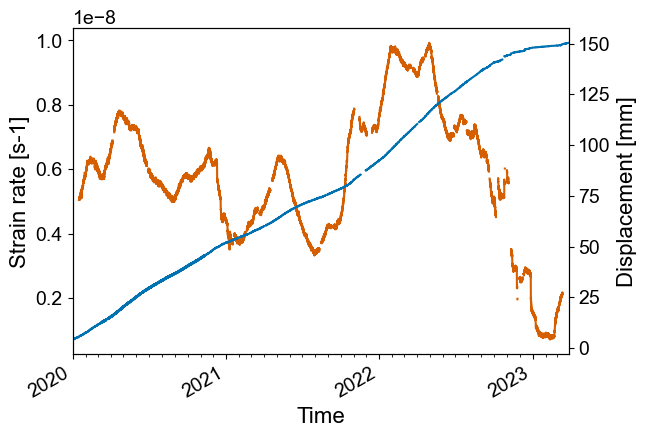

In [30]:
# Fabian helped me solve this
bh_data = [] # empty df

days = 30 # montly to see seasonal variations
hours = 24
time_window = days*hours # rows, and 1 row is 1 hour

time_step = time_window//2
strain = []
bh_data = KH0118Disp.copy()
itr = range(len(bh_data.iloc[:,0])) # loop through all rows
for i in itr:
    if i < time_step:
        strain.append(np.nan) # adds nan for the first missing values due to time window
    if i > time_step-1:
        H = 250.0 # initial length, thickness of shear zone
        L = bh_data.iloc[i+time_step,0]-bh_data.iloc[i-time_step,0] # diff disp
        time = (bh_data.index[i+time_step]-bh_data.index[i-time_step]).total_seconds() # time per time window
        strain.append(L/(H*time)) # strain rate in seconds
        if i == itr[-(time_step+1)]: # stoping loop and adding nans due to time window
            for n in range(time_step):
                strain.append(np.nan) 
            break
            
# plot data
bh_data['strain [s-1]:'] = strain

fig, ax = plt.subplots()

ax.plot(bh_data.index, bh_data['strain [s-1]:'], color=colors[1])
ax_y = ax.twinx()
ax_y.plot(bh_data.index, bh_data.iloc[:,0], color=colors[2])

ax.set_ylabel('Strain rate [s-1]')
ax_y.set_ylabel('Displacement [mm]')
ax.set_xlabel('Time')

# Ensure the first year is included
start_year = bh_data.index.min().year
end_year = bh_data.index.max()
ax.set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax.xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax.xaxis.set_major_formatter(years_fmt)

# Rotate and align the tick labels so they look better
fig.autofmt_xdate().

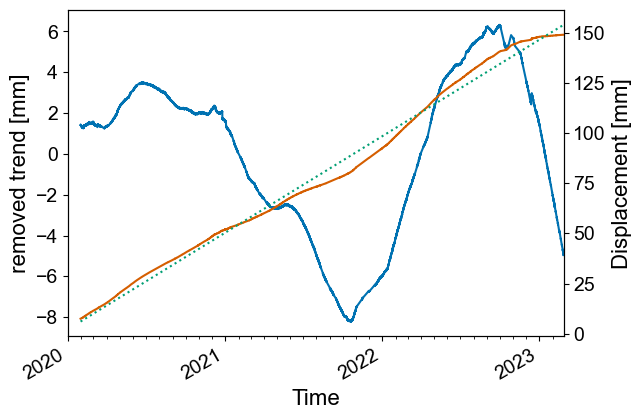

In [35]:
# Perform the linear fit
from scipy.stats import linregress

# Ensure there are no NaNs in the dataset
bh_data = bh_data.dropna()

# Convert dates to numerical format for fitting
x = mdates.date2num(bh_data.index)
y = bh_data.iloc[:,0]

# Perform robust linear fit using scipy's linregress
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate fitted values
y_fit = intercept + slope * x

trend_removed = y-y_fit
bh_data['trend_removed'] = trend_removed

fig, ax = plt.subplots()

ax.plot(bh_data.index, bh_data['trend_removed'], color=colors[2])
ax_y = ax.twinx()
ax_y.plot(bh_data.index, bh_data.iloc[:,0], color=colors[1])
ax_y.plot(y.index, y_fit, color=colors[4], linestyle='dotted')

ax.set_ylabel('removed trend [mm]')
ax_y.set_ylabel('Displacement [mm]')
ax.set_xlabel('Time')

# Ensure the first year is included
start_year = bh_data.index.min().year
end_year = bh_data.index.max()
ax.set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax.xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax.xaxis.set_major_formatter(years_fmt)

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

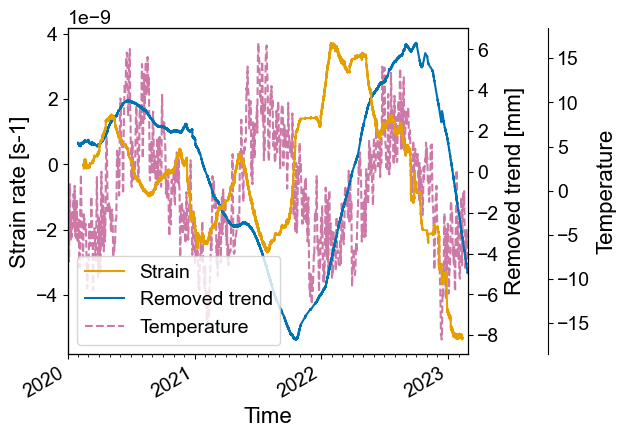

In [88]:
# Fabian helped me solve this

days = 30 # montly to see seasonal variations
hours = 24
time_window = days*hours # rows, and 1 row is 1 hour

time_step = time_window//2
strain = []
df = bh_data['trend_removed']
df = df.to_frame()
itr = range(len(df.iloc[:,0])) # loop through all rows
for i in itr:
    if i < time_step:
        strain.append(np.nan) # adds nan for the first missing values due to time window
    if i > time_step-1:
        H = 250.0 # initial length, thickness of shear zone
        L = df.iloc[i+time_step,0]-df.iloc[i-time_step,0] # diff disp
        time = (df.index[i+time_step]-df.index[i-time_step]).total_seconds() # time per time window
        strain.append(L/(H*time)) # strain rate in seconds
        if i == itr[-(time_step+1)]: # stoping loop and adding nans due to time window
            for n in range(time_step):
                strain.append(np.nan) 
            break
            
# plot data
bh_data['strain [s-1]:'] = strain

fig, ax = plt.subplots()

ax_y = ax.twinx()
ax_yy = ax.twinx()
ax_yy.spines.right.set_position(("axes", 1.2))

line1 = ax.plot(bh_data.index, bh_data['strain [s-1]:'], color=colors[6],  zorder=4, label='Strain')
line2 = ax_y.plot(bh_data.index, bh_data['trend_removed'], color=colors[2], zorder=3, label='Removed trend')

# adding temperature to the plot
start_time = '2020-01-01'
end_time = '2023-03-28'
temp_sub =  temp[temp.index.slice_indexer(start_time,end_time)]
line3 = ax_yy.plot(temp_sub.index, temp_sub.iloc[:,0], color=colors[0], linestyle='dashed', zorder=2, label='Temperature')

# Set z-order for axes
ax.set_zorder(3)
ax_y.set_zorder(2)
ax_yy.set_zorder(1)

# Set visibility for the axes
ax.patch.set_visible(False)
ax_y.patch.set_visible(False)
ax_yy.patch.set_visible(False)

# Bring ax to the front
ax.set_frame_on(True)
ax_y.set_frame_on(True)
ax_yy.set_frame_on(True)
fig.subplots_adjust(right=0.75)  # Make room for the third y-axis

# Set labels
ax.set_ylabel('Strain rate [s-1]')
ax_y.set_ylabel('Removed trend [mm]')
ax_yy.set_ylabel('Temperature')
ax.set_xlabel('Time')

# Ensure the first year is included
start_year = bh_data.index.min().year
end_year = bh_data.index.max()
ax.set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()  # Locator for every year
years_fmt = mdates.DateFormatter('%Y')  # Formatter for displaying year
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()  # Locator for every month
months_fmt = mdates.DateFormatter('%b')  # Formatter for displaying month (Jan, Feb, etc.)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(years_fmt)

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Add legends
handel1, label1 = ax.get_legend_handles_labels()
handel2, label2 = ax_y.get_legend_handles_labels()
handel3, label3 = ax_yy.get_legend_handles_labels()
handels = handel1+handel2+handel3
labels = label1+label2+label3
ax.legend(handels, labels, loc='lower left')

plt.show()

In [ ]:
from matplotlib.dates import DateFormatter

# # DATA
start_time = JTT1Disp.index[0]
end_time = JTT1Disp.index[-1]

# water level
n_day = 31 # days # 2 months kernel size for median filter (hourly data)
n_hour = round_up_to_odd(24*n_day) 

# plotting

fig, ax = plt.subplots(nrows=2, figsize=(12,7), sharex=True)
# fig.subplots_adjust(hspace=0) #fig.subplots_adjust(wspace=0) # to remove space on each side of the x-axis

#######                          PLOT 1                           #######
file = []
file2 = [] # to make sure it does not come from previous plot

# JTT1
file = JTT1Disp_creep.copy()
file2 = JTT1Disp.copy()

# #JTT3
# file = JTT3Disp_creep.copy()
# file2 = JTT3Disp.copy()

# # JTT2 Upper
# file = JTT2DispUpperZone_creep.copy()
# file2 = JTT2DispUpperZone.copy()

# Want this behind
ax_y0 = ax[0].twinx()
file3 = JTT1Wp.copy()
watermodule = 'Mod4_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
ax_y0.plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[4], label='Water pressure', alpha=0.5)

# Want this in front
zero_start = file2['Disp_summed [mm]:'][0] # starting from 0
df = file2.copy()
# df.loc[df['interpolated_disp'] >0] = np.inf
ax[0].plot(df.index, df['Disp_summed [mm]:']-zero_start, color='black', label='Borehole JTT1 \nshear zone inclinometers')
# df = file2.copy()
# df.loc[df['interpolated_disp'] ==np.nan] = np.inf
# ax[1].plot(df.index, df['interpolated_disp']-zero_start, color='violet', label='Interpolated displacement')

# df of start and end of bursts
window = []
previous_d = 0
for i, d in enumerate(file2['nBursts']):
    if d != previous_d:
        previous_d = d
        window.append(file2[i:i+1].index)

# Convert the list of datetime objects to a NumPy array
window = np.array([item[0] for item in window])
        
idx = np.arange(0, len(window), 2)  # index to slice at even numbers
for start in idx:
    ax[0].axvspan(window[start], window[start+1], facecolor='lightcoral', edgecolor='lightcoral', label='Creep burst', zorder=3, alpha=0.4)

df = file2.copy()
df.loc[df['nBursts'] ==0] = np.nan
df = df.replace(np.nan,np.inf) # to avoid interpolation between holes in data
ax[0].plot(df.index, df['Disp_summed [mm]:']-zero_start, color='crimson', label='', zorder=2) # I do not know if we want this coloring?

# # df of missing data
# df = file2['Disp_summed [mm]:'].copy()
# df.loc[df.notna()] = 0
# df.loc[df.isna()] = 1
# window = []
# previous_d = 0
# zero_start = mpl.dates.date2num(df.index[0])

# for i, d in enumerate(df):
#     if d != previous_d:
#         previous_d = d
#         window.append(df[i:i+1].index)

# # Convert the list of datetime objects to a NumPy array
# window = np.array([item[0] for item in window])

# idx = np.arange(0, len(window), 2)  # index to slice at even numbers
# for start in idx[:-1]:
#     if window[start+1]-window[start] > np.timedelta64(1, 'h'): # can change to show only more than n hours..
#         xmin = (mpl.dates.date2num(window[start])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
#         xmax = (mpl.dates.date2num(window[start+1])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
#         ax[0].axhspan(ymin=-file2['Disp_summed [mm]:'].max()/40, ymax=0, xmin=xmin, xmax=xmax, facecolor='gray', edgecolor='gray', label='Missing data', zorder=1, alpha=0.4) # zorder = what layer to plot from back to front

# # Cumulated plot, not to be used as of now..
# df = file.copy()
# frames = []
# for i in df.index:
#     cb = pd.DataFrame(index=pd.date_range(file['date_start'][i], periods=len(file['date'][i].values), freq='H'))
#     cb['displacement'] = df.displacement.iloc[i]
#     frames.append(cb)
# cb = pd.concat(frames)
# cb['displacement'] = cb['displacement'].replace(0, np.nan).dropna()
# velocity = cb['displacement'].shift(-1)-cb['displacement']
# cb['cumulated'] = np.nancumsum(velocity) # cumulated creep bursts
# # ax[1].plot(cb.index, cb['cumulated'], color='crimson', label='Cumulated creep bursts')
# df = file2.copy()
# df.loc[df['nBursts'] ==1] = np.nan
# velocity = df['Disp_summed [mm]:'].shift(-1)-df['Disp_summed [mm]:']
# df['cumulated'] = np.nancumsum(velocity) # cumulated disp w/o creep burst
# # ax[1].plot(df.index, df['cumulated'], color='black', label='Displacement w/o bursts')

# cb_of_totaldisp = (cb['cumulated'][-1]/df['cumulated'][-1])*100
# # ax[0].text(pd.Timestamp('2020-02-05'), 90, f'Creep bursts contribute to {cb_of_totaldisp:.1f} % of total displacement' , horizontalalignment='left', size='medium', color='black', fontsize=medium_size)

#######                          PLOT 2                           #######

width = 55/60*n_day # 55 works well for 60 days
# temp_sub =  temp[(temp.index > start_time) & (temp.index < end_time)] # data per day
temp_sub = temp[temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
temp_sub.iloc[:,0] = medfilt(temp_sub.iloc[:,0], kernel_size=n_day)

ST_sub = ST[ST.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
ST_sub.iloc[:,0] = medfilt(ST_sub.iloc[:,0], kernel_size=n_day)
ST_sub.iloc[:,1] = medfilt(ST_sub.iloc[:,1], kernel_size=n_day)

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
snowrainmelt_sub =  xgeo_snowrainmelt[xgeo_snowrainmelt.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
snowrainmelt_sub = snowrainmelt_sub.resample(f'{n_day}d').sum()

ax[1].plot(temp_sub.index, temp_sub['temperature'], color=color_airtemp, label='Air temperature')
ax[1].plot(ST_sub.index,ST_sub['ST2'], color=color_bacscarpairtemp, label='BS air temperature')
ax[1].plot(ST_sub.index,ST_sub['ST3'], color=color_bacscarprocktemp, label='BS rock temperature')

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
snowrainmelt_sub =  xgeo_snowrainmelt[xgeo_snowrainmelt.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
snowrainmelt_sub = snowrainmelt_sub.resample(f'{n_day}d').sum()

ax_y1 = ax[1].twinx()
ax_y1.bar(dates.date2num(snowrainmelt_sub.index), snowrainmelt_sub['snowrainmelt'], width = width, ec='blue', color='blue', label='Surface runoff', alpha=0.5)


# set axis labels
ax_y0.set_ylim(0,5)
ax[0].set_ylabel('Basal displacement (mm)')
ax_y0.set_ylabel('Water level change (m)')
lines, labels = ax[0].get_legend_handles_labels()
lines = unique(lines)
labels = unique(labels)
lines2, labels2 = ax_y0.get_legend_handles_labels()
ax[0].legend([lines[0]]+lines2+[lines[1]], [labels[0]]+labels2+[labels[1]], loc='center left', bbox_to_anchor=(1.1, 0.5))
leg = ax[0].get_legend() # gets legend handels

# ax[1].set_ylabel('mm')
ax[1].set_ylabel('Temperature ($^\circ$C)')
ax_y1.set_ylabel('Surface runoff (mm)')
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax_y1.get_legend_handles_labels()
ax[1].legend(lines+lines2, labels+labels2, loc='center left', bbox_to_anchor=(1.1, 0.5))
leg = ax[1].get_legend() # gets legend handels


# ax[1].set_xlabel('Time (months)')


# # removing tick labels from the xaxis
# n = 2  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax[1].xaxis.get_ticklabels()) if i % n != 0]

fig.tight_layout()
plt.show()

# saving
path = 'plots/'
save_name = f'{path}Figure_JTT1_2022.png'
fig.savefig(save_name, dpi=600)

In [ ]:
JT_CLM_1.plot(y='ground_temp')

# WP and JTT2

In [ ]:
# plotting JTT2 Upper VS GPS3

fig, ax = plt.subplots(figsize=(8, 6), sharex=True)

# manually picked start and end times for following data
start_time = pd.Timestamp('2014-07-01')
end_time = pd.Timestamp('2025-01-01')


diff = 0.55 # adding differnce so the plots will be on top of each other
n_hour = 59

# col = 'Disp_summed [mm]:'
col = '60_days_velocity [mm/day]:'
# file = JTT2DispUpperZone.loc[:,col] # upper
file = JTT2DispLowerZone.loc[:,col] # lower
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
file1 = file-zero
normalized = (file1-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file1 = file1.replace(np.nan,np.inf) # changing nan to inf

# ax.plot(file1.index, file1.values, color=colors[5], label='Borehole JTT2 Lower zone', alpha=0.8)

# # normalized
# ax.plot(file1.index, normalized, color=colors[5], label='Borehole JTT2 Upper zone')

# # velocity
# ax.plot(file.index, file.values, color=colors[5], label='Borehole JTT2 Upper zone', alpha=0.8)

# Normalized
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax.plot(file.index, normalized, color=colors[5], label='Borehole JTT2 Upper zone', alpha=0.8)

# WP
ax_y = ax.twinx()
file3 = JTT2WpUpperZone.copy()
watermodule = 'Mod4_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
df = file3.values-np.nanmin(file3.values)
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
file3 = file3.replace(np.nan,np.inf) # changing nan to inf

# ax_y.plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[4], label='Water pressure', alpha=0.5)
# ax_y.set_ylabel('Water pressure (m)')

# normalized
ax_y.plot(file3.index, normalized, color=colors[4], label='Water pressure', alpha=0.5)
ax_y.set_ylabel('Normalized water pressure')


# GPS data
# data = '2d'
data = '2d_60_days_velocity [mm/day]:'
df =  jett_gps3 # same as Jtt2
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
file = df[data]
zero = file[file.first_valid_index()]
file1 = file-zero
normalized = (file1-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file1 = file1.replace(np.nan,np.inf) # changing nan to inf

# ax.plot(file1.index, file1, color=colors[2], label='GPS 3')
# ax.set_ylabel('Displacement (mm)')

# # Normalized
# ax.plot(file1.index, normalized+diff, color=colors[2], label='GPS 3')
# ax.set_ylabel('Normalized displacement')

# # velocity
# ax.plot(file.index, file, color=colors[2], label='GPS 3')
# ax.set_ylabel('Velocity (mm/day)')

# Normalized
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax.plot(file.index, normalized, color=colors[2], label='GPS 3')
ax.set_ylabel('Normalized velocity')


ax.set_xlabel('Years')

lines, labels = ax.get_legend_handles_labels()
lines1, labels1 = ax_y.get_legend_handles_labels()
ax.legend(lines+lines1, labels+labels1)

# years = mdates.YearLocator(1)   # set number for every other year
# years_fmt = mdates.DateFormatter('%Y') # only display year, not day and month
# ax[3].xaxis.set_major_locator(years)
# ax[3].xaxis.set_major_formatter(years_fmt)

# # removing tick labels from the xaxis
# n = 2  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax[3].xaxis.get_ticklabels()) if i % n != 0]

# # # saving
path = 'plots\\'
# save_name = f'{path}Figure_JTT2_GPS3_displacement.png'
# save_name = f'{path}Figure_JTT2Lower_GPS3_displacement.png'
# save_name = f'{path}Figure_JTT2_GPS3_disp_normalized.png'
# save_name = f'{path}Figure_JTT2_GPS3_vel.png'
save_name = f'{path}Figure_JTT2Lower_GPS3_vel_normalized.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'

Text(0, 0.5, 'Water pressure (m)')

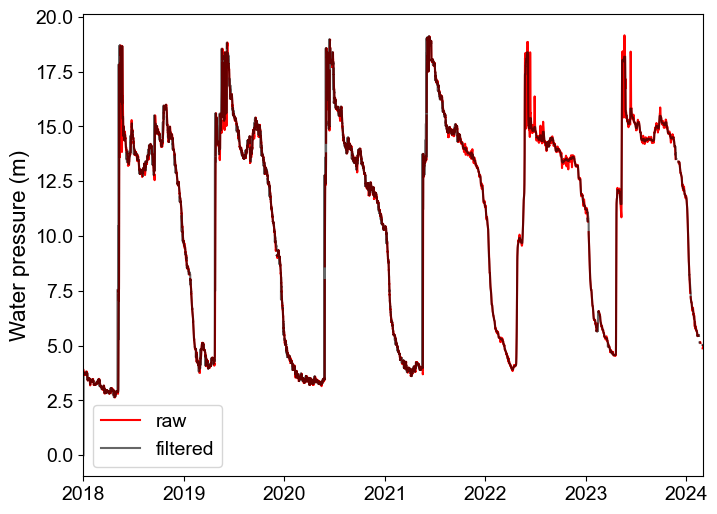

In [19]:
# regression on Wp and disp
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)
file3 = JTT2WpUpperZone.copy()
watermodule = 'Mod4_Water pressure [m]:'

start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2025-01-01')
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
# df = file3.values-np.nanmin(file3.values)
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# file3 = file3.replace(np.nan,np.inf) # changing nan to inf

# testing filter
n = (24*7)+1 # odd number (7 days works great)
test = medfilt(file3, kernel_size=n) # median filter

# n = (24*60)+1 # odd number (and than long filter? But do not know the correct way of doing this..)
# test = medfilt(test, kernel_size=n) # median filter

# plotting
ax.plot(file3.index, file3.values, color='r', label='raw')
ax.plot(file3.index, test, color='k', label='filtered', alpha=0.6)
ax.legend()
ax.set_ylabel('Water pressure (m)')

          Disp        WP
Disp  1.000000  0.557849
WP    0.557849  1.000000


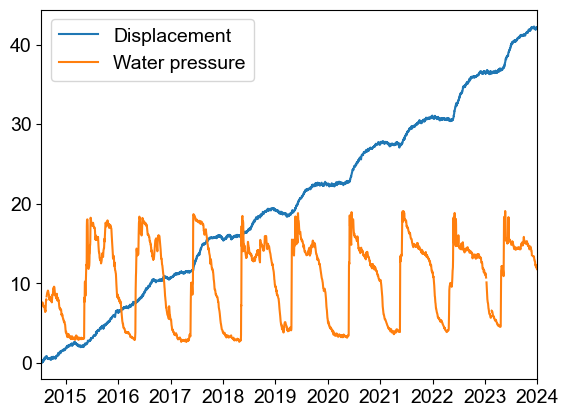

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

start_time = pd.Timestamp('2014-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()
df_col, freq = x.dropna(), 365
res_x = seasonal_decompose(df_col, period=freq) # , freq=freq, model='additive', extrapolate_trend='freq

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()
df_col, freq = y.dropna(), 365
res_y = seasonal_decompose(df_col, period=freq)
                           
df = pd.DataFrame({'Disp':res_x.seasonal, 'WP':res_y.seasonal})
df.dropna(inplace=True) # for some reason more nans appeared
print(df.corr())
# df.plot()
plt.plot(x)
plt.plot(y)
plt.legend(['Displacement','Water pressure'])

          Disp        WP
Disp  1.000000  0.263469
WP    0.263469  1.000000


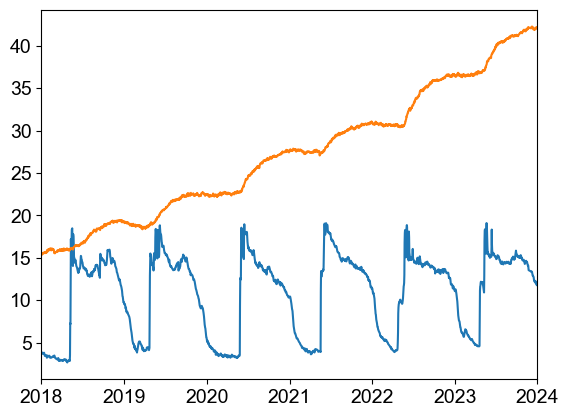

In [72]:
# trying differnce instead of seasonal signal
start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

# # first order differenceing
# x = np.diff(x)[1:]
# y = np.diff(y)[1:]

df = pd.DataFrame({'Disp':x, 'WP':y})
df.dropna(inplace=True) # for some reason more nans appeared
print(df.corr())
plt.plot(df.iloc[:,1])
plt.plot(df.iloc[:,0])

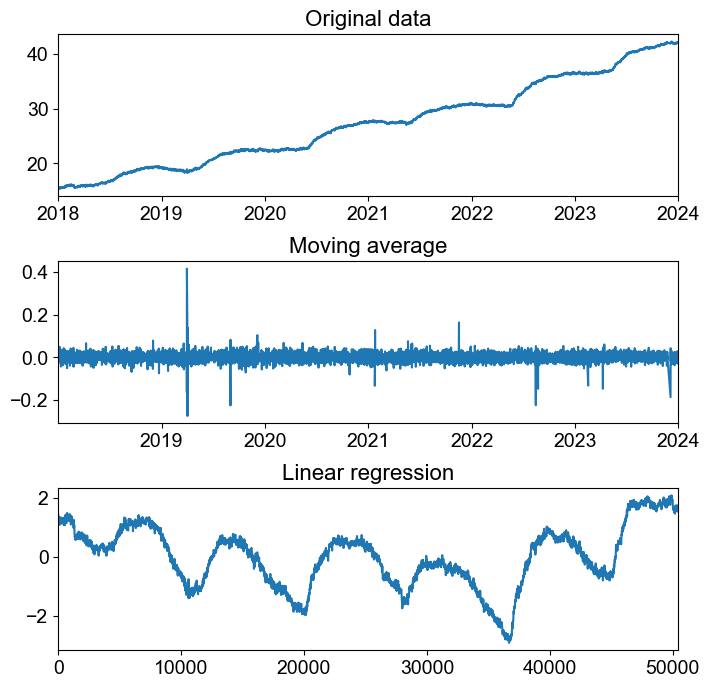

In [67]:
# # Detrend timeseries # #

start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
# x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
# y = y.resample('1d').median()
df = pd.DataFrame({'Disp':x, 'WP':y})
df.dropna(inplace=True) # for some reason more nans appeared

# Define the window size for the moving average
window_size = 5

def detrend_ma_col(df_col, window_size):
    # Calculate the moving average
    moving_average = np.convolve(df_col, np.ones(window_size)/window_size, mode='valid')
    # Detrend the time series by subtracting the moving average
    detrended = df_col[window_size - 1:] - moving_average
    return detrended

def detrend_linreg_col(df_col):
    # fit linear model
    X = [i for i in range(0, len(df_col))]
    X = np.reshape(X, (len(X), 1))
    y = df_col.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    # detrend
    detrended = [y[i]-trend[i] for i in range(0, len(df_col))]
    return detrended

df_col = df.iloc[:,0]
linreg = detrend_linreg_col(df_col)
ma = detrend_ma_col(df_col, window_size=window_size)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
fig.subplots_adjust(hspace=.4)
ax1.set_title('Original data')
ax1.plot(df_col, label='original')
ax2.set_title('Moving average')
ax2.plot(ma, label='ma')
ax3.set_title('Linear regression')
ax3.plot(linreg, label='linreg')

In [20]:
# create slice of df 

start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()
         
df = pd.DataFrame({'Disp':x, 'WP':y})
df.dropna(inplace=True) # for some reason more nans appeared

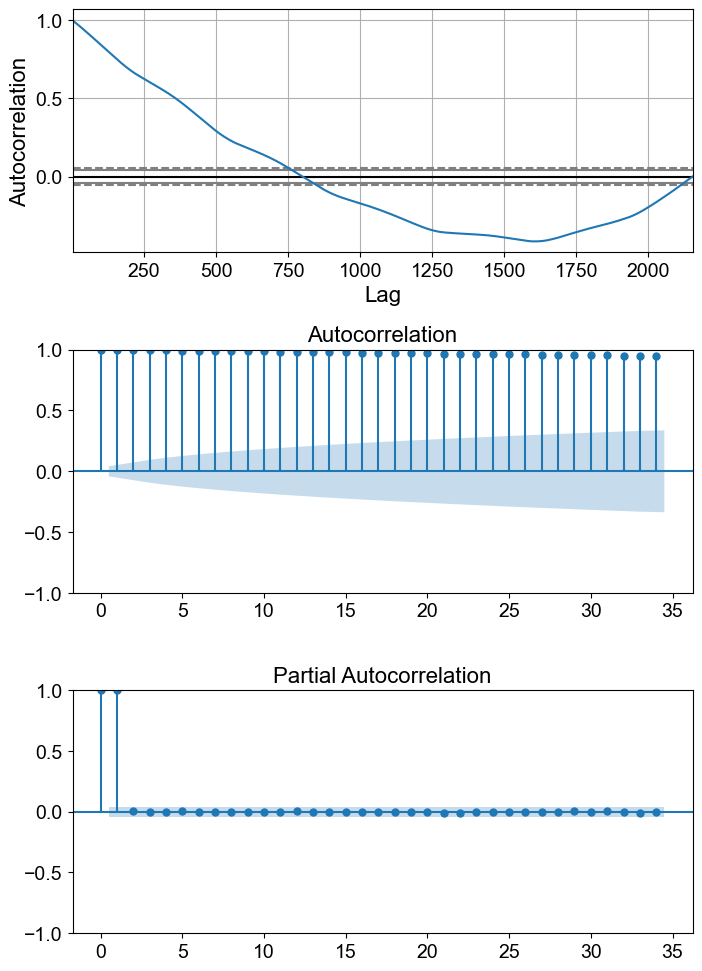

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

df = pd.DataFrame({'Disp':x, 'WP':y})
df.dropna(inplace=True)

### try different types of 'smoothing' and understand what is the best apporach to the correlations. Also go back to granger and cross correlation!

# test = ma.copy() # moving average, seems like this is the only one working according to the stationarity argument
# test = linreg.copy() # linear regression
# test = df.iloc[:,1] # seasonal decompose
####

test = df.iloc[:,0] # displacement original data
# test = df.iloc[:,1] # water pressure original data

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,12))
fig.subplots_adjust(hspace=.4)
autocorrelation_plot(test, ax1) # can clearly see seasonality in plot
plot_acf(test, ax=ax2) #  lags=90, zero=False,
plot_pacf(test, ax=ax3) # lags=90, zero=False,

plt.show()

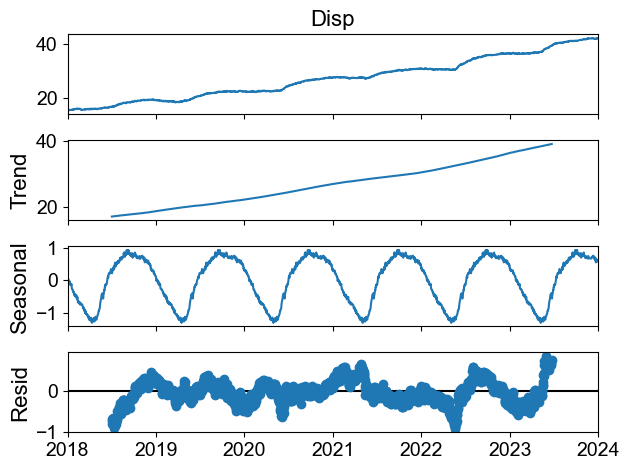

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
freq = 365
decomposition=seasonal_decompose(test,model='additive',period=freq)
decomposition.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(test, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
# so the tests says that the WP time series is stationary, but the disp is not, which makes sense. Stasionarity is needed for ARIMA but not SARIMA

from pmdarima.arima.stationarity import ADFTest

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(test)  # (0.01, False)

1. ADF :  0.4331252328914312
2. P-Value :  0.9826923245047817
3. Num Of Lags :  24
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2129
5. Critical Values :
	 1% :  -3.4334252475234646
	 5% :  -2.8628985239834686
	 10% :  -2.567493212493555


In [12]:
import pmdarima as pmd

# p is order of AR model (number of lags), d is degree of differencing (only used when non-tationary data), 1 is order of MA model. Understand this from here: https://alkaline-ml.com/pmdarima/tips_and_tricks.html
model=pmd.auto_arima(test,start_p=1,start_q=1,test='adf',m=365,seasonal=True,trace=True)

# this takes for ever!

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [ ]:
# add values from the automatic retriveing of values above

sarima=SARIMAX(data['meantemp'],order=(1,1,1),seasonal_order=(1,0,1,12))
predicted=sarima.fit().predict();predicted

# but this only predicts and fits the data and I do not know much more? 

## VAR model

In [231]:
#### create slice of df  #####
start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
z = z[z.index.slice_indexer(start_time,end_time)]
z = z.resample('1d').median()

df = pd.DataFrame({'Disp':x, 'WP':y, 'Temp': z})
df.dropna(inplace=True)

#### making and testing stationarity ####
# Apply decompose (decompose trend, seasonality, and resudials) to make data stationary
freq = 365
for variable in df.columns:
    decomposed_series = seasonal_decompose(df.loc[:,variable], model='additive', period=freq) # only for disp now, can do on WP too to make it equally significant?
    # df.loc[:,variable] = decomposed_series.seasonal # only seasonal
    df.loc[:,variable] = df.loc[:,variable]-decomposed_series.trend # original minus trend
df.dropna(inplace=True)

p-value: 0.01772846470827371
The variable Disp is stationary.

p-value: 0.018623351149189844
The variable WP is stationary.



C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


        Disp_x  WP_x
Disp_y     1.0   0.0
WP_y       0.0   1.0
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Aug, 2024
Time:                     09:23:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.67123
Nobs:                     1092.00    HQIC:                  -6.22288
Log likelihood:           676.120    FPE:                 0.00141898
AIC:                     -6.55876    Det(Omega_mle):      0.00119690
--------------------------------------------------------------------
Results for equation Disp
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.000744         0.002414           -0.308           0.758
L1.Disp          0.673226         0.031725           21.220           0.000
L1.WP           -0

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


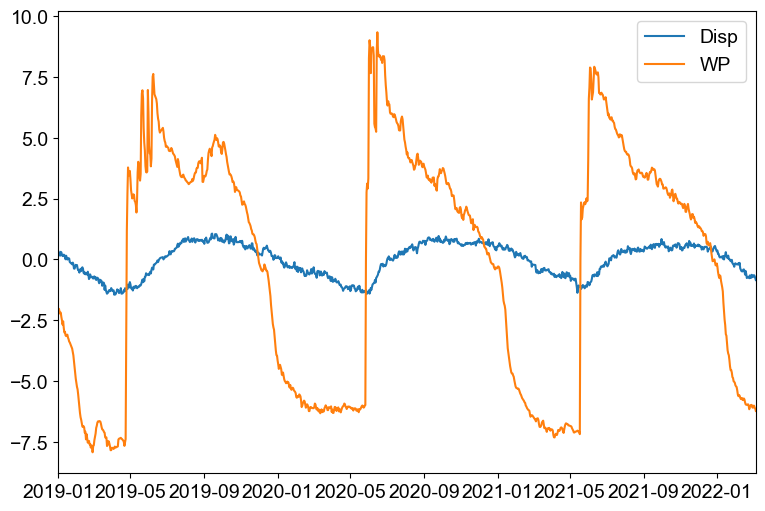

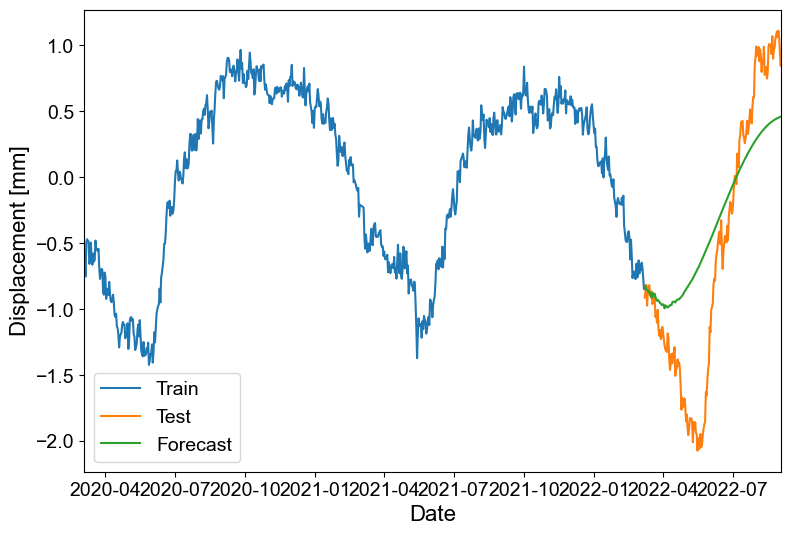

In [232]:
# YES, it seems like VAR is what I need! https://medium.com/@wainaina.pierre/the-complete-guide-to-time-series-forecasting-models-ef9c8cd40037

# this is a linear function

#### create slice of df  #####
start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
z = z[z.index.slice_indexer(start_time,end_time)]
z = z.resample('1d').median()

# df = pd.DataFrame({'Disp':x, 'WP':y, 'Temp': z})

df = pd.DataFrame({'Disp':x, 'WP':y})
df.dropna(inplace=True)

#### making and testing stationarity ####
# Apply decompose (decompose trend, seasonality, and resudials) to make data stationary
freq = 365
for i, d in enumerate(df.columns):
    # # only seasonal component
    # df.loc[:,variable] = decomposed_series.seasonal # only seasonal
    # df.dropna(inplace=True)
    
    # removed trend so includes residuals
    original = df.loc[:,d].copy()
    decomposed_series = seasonal_decompose(df.loc[:,d], model='additive', period=freq) # only for disp now, can do on WP too to make it equally significant?
    
    df.loc[:,d] = original-decomposed_series.trend # original minus trend. This does not make the data stationary..
    df.dropna(inplace=True) # due to shift of a week by trend calculation
    
    
from statsmodels.tsa.stattools import adfuller

for variable in df.columns:
    # Perform the ADF test
    result = adfuller(df[variable])

    # Extract and print the p-value from the test result
    p_value = result[1]
    print("p-value:", p_value)

    # Interpret the result
    if p_value <= 0.05: # 0.05 or 0.001
        print(f"The variable {variable} is stationary.\n")
    else:
        print(f"The variable {variable} is not stationary.\n")
        
# Split into train and test
cutoff_index = int(df.shape[0] * 0.8) # train with xx % data

df_train = df.iloc[:cutoff_index]
df_test = df.iloc[cutoff_index:]

fig, ax =plt.subplots(figsize=(9, 6))
ax.plot(df_train.index, df_train.Disp, label='Disp')
ax.plot(df_train.index, df_train.WP, label='WP')
# ax.plot(df_train.index, df_train.Temp, label='Temp')
ax.legend()

### Granger Causality test ###
# https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/?utm_content=cmp-true

# looks at lags and provide significance below 0.1 or 0.05 if variable in second column is caused by first column.

from statsmodels.tsa.stattools import grangercausalitytests
def grangers_causation_matrix(data, variables, maxlag=90, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grang_test = grangers_causation_matrix(df_train, variables = df.columns, maxlag=90) # 3 months and daily values
print(grang_test) # not sure if this is working optimally


#### Transform data back to original ####     do not know how to use that for decompose
# # Define function for inverting data transformation
# def df_inv_transformation(df_processed, df, scaler):
    
#     # Invert StandardScaler transformation
#     df_diff = pd.DataFrame(scaler.inverse_transform(df_processed), 
#                                 columns=df_processed.columns, 
#                                 index=df_processed.index)

#     # # Invert decomposing
#     # df_original = df_diff.cumsum() + df[df.index < df_diff.index[0]].iloc[-1]
    
#     return df_original


#### VAR model ####
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(df_train) # endog=df_train_processed.iloc[:,0], exog=df_train_processed.iloc[:,1]

# # Get optimal lag order based on the four criteria
# optimal_lags = model.select_order()
# print(f"The optimal lag order selected: {optimal_lags.selected_orders}")
# # Fit the model after selecting the lag order
# lag_order = optimal_lags.selected_orders['bic'] # bic minimizes model complexity, aic maximizes goodnes of fit

lag_order = 48 # is best cross correlation lag, manually chosen
results = model.fit(lag_order)

# Estimate the model (VAR) and show summary
var_model = results.model
print(results.summary())

#### Forecast next n days #####
plot_window = 365*2
horizon = 180
forecast = results.forecast(df_train.values[-lag_order:], steps=horizon)

# Convert to dataframe
df_forecast = pd.DataFrame(forecast, columns=df_train.columns, index=df_test.iloc[:horizon].index)

# Plot forecasted increment of deaths
fig, ax =plt.subplots(figsize=(9, 6))
ax.plot(df_train.index[-plot_window:], df_train.Disp[-plot_window:])
ax.plot(df_test.index[:horizon], df_test.Disp[:horizon])
ax.plot(df_forecast.index, df_forecast.Disp)
# plt.grid(alpha=0.5, which='both')
plt.xlabel('Date')
plt.ylabel('Displacement [mm]')
plt.legend(['Train', 'Test', 'Forecast'])
plt.show()

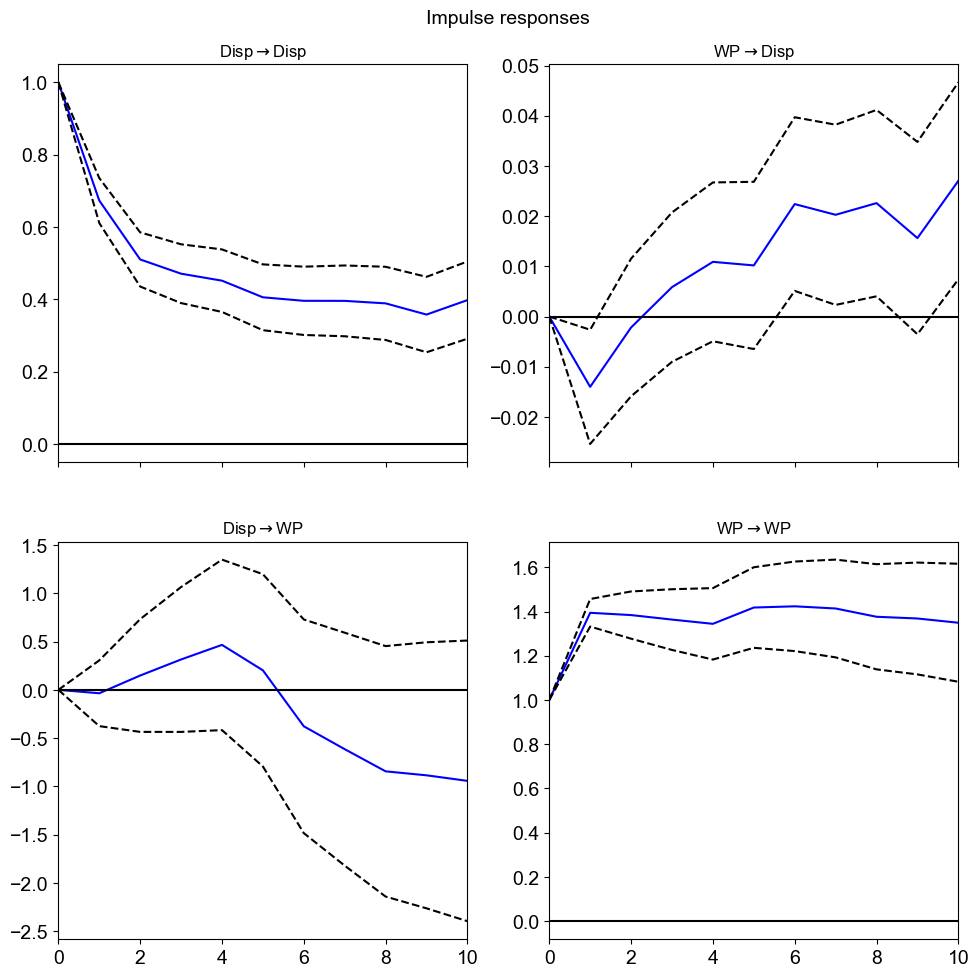

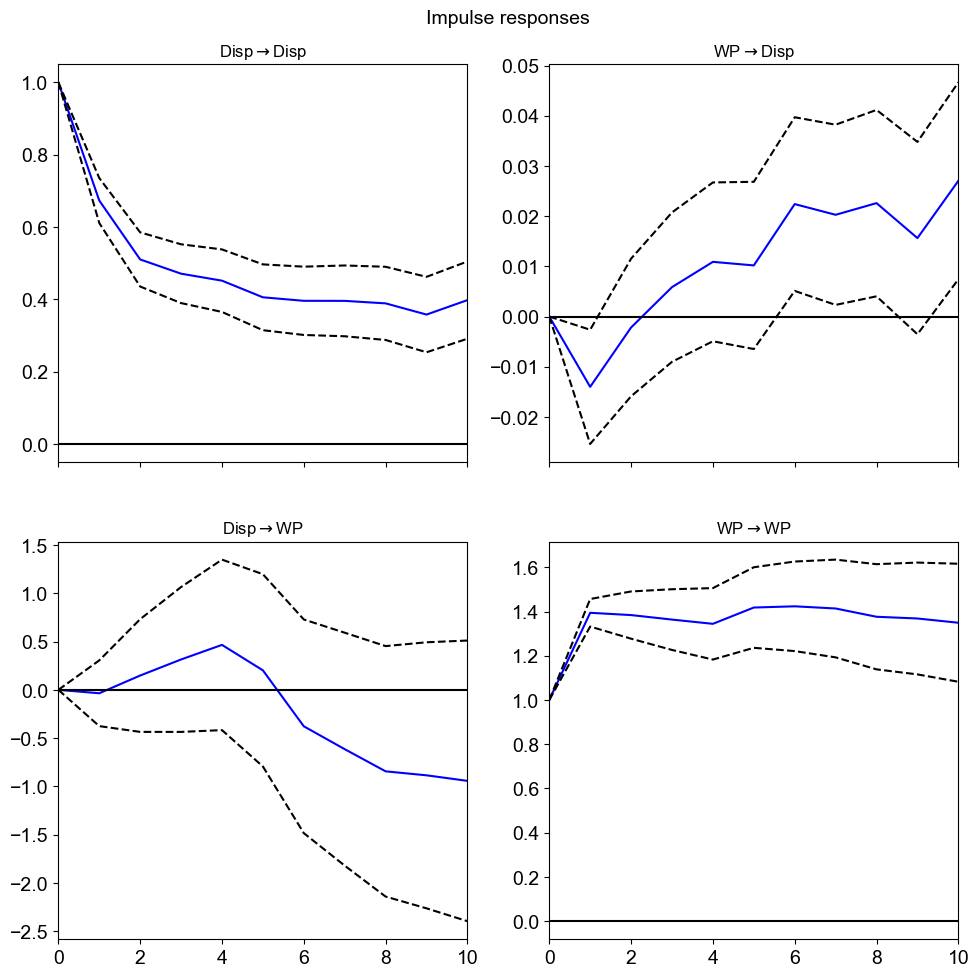

In [258]:
irf = results.irf(10)
irf.plot(orth=False) # impuls respons function is showing how much of a unit change (y-axis) a shock of 2sd (?) is and propogates for x-time steps

In [252]:
print(results.test_causality('Disp', 'WP', kind='f')) # f = F-test for numeric, wald = chi-sq, chi-sq for catagorical
# I think this is the VAR model of just Disp and then Disp and WP to see if it gives a better estiamte by including WP and it did not so then reject that WP cause Disp

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: WP does not Granger-cause Disp: reject at 5% significance level. Test statistic: 1.989, critical value: 1.364>, p-value: 0.000>


(array([ 66.,  81.,  84., 131.,  93.,  77., 112., 213., 216.,  67.]),
 array([-1.44864788, -1.19745955, -0.94627122, -0.69508288, -0.44389455,
        -0.19270622,  0.05848211,  0.30967044,  0.56085877,  0.8120471 ,
         1.06323543]),
 <BarContainer object of 10 artists>)

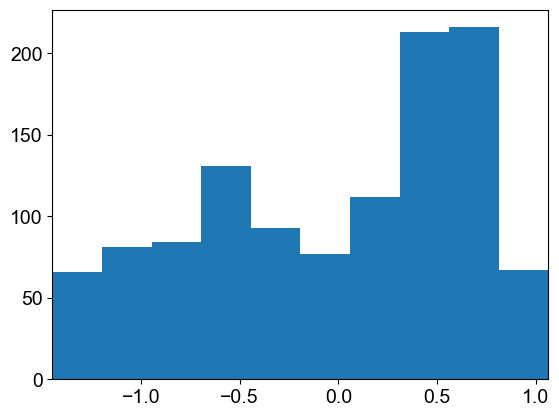

In [251]:
plt.hist(df_train.iloc[:,0]) # normaly distributed? No, skewed with long tails
# plt.plot(df_train.index, df_train.iloc[:,0]) # to look at time series

## ARDL model

Is variables stationary?


(0.01685083934644992, 'Stationary')

(0.02107380873967228, 'Stationary')

(0.0, 'Stationary')

Is first order difference stationary?


(1.5060815090213224e-09, 'Stationary')

(2.669040664448823e-06, 'Stationary')

(0.0, 'Stationary')

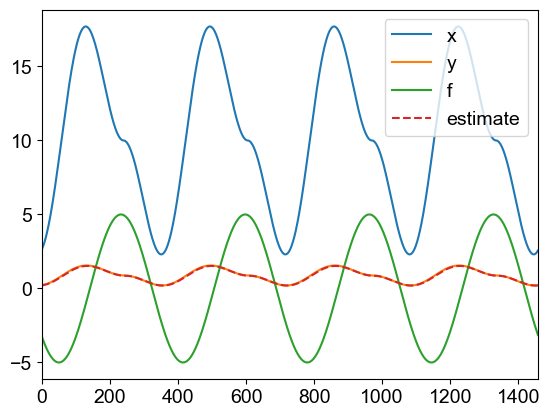

In [72]:
# Syntetisk datagenerering

# **Importer**
import numpy as np
import math
import pandas as pd
import plotly.graph_objects as go # fancy shit that I have not tried before
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


# **Hjelpefunksjoner**

def make_lineplot(data, xcol, ycols):
    fig = go.Figure()
    
    for col in ycols:
        fig.add_trace(
                go.Scatter(x=data[xcol],
                           y=data[col],
                           name=col,
                           mode='lines'),
            )
   
    fig.update_layout(
            xaxis=dict(
            title=xcol,
            titlefont=dict(family='Lato', size=12, color='black'),
            tickangle = 90,
            mirror=False,
            ticks='outside',
            showline=True,
            linecolor='black',
            showgrid=False,
        ),
        
        yaxis=dict(
            zeroline=False,
            showgrid=True,
            showline=False,
            showticklabels=True,
            title='',
            gridcolor='#A8BAC4',
            mirror=False,
            linecolor='black',
        ),
        
        plot_bgcolor='#F0F0F0',
        paper_bgcolor='#F0F0F0',
        showlegend=True,
        legend=dict(orientation='h',yanchor='top',xanchor='center', traceorder='normal', y=1.15, x=0.5),
        height=340.16*1.2,
        width=604.72*1.5,
        margin=dict(t=60)
    )
    
    return fig

'''
**Hovedtekst**

Ideen her er å lage en syntetisk dataset som fremviser de egenskapene - eller i hvert fall ligner på - det ekte datasettet du har, og at du kan teste de ulike modellene (eller fremgangsmåtene) i en setting hvor du kjenner fasit, og derfor kan si noe om hvor godt de fungerer. Jeg har ikke noe kunnskap om geologi og de prosessene du skriver om, så modellen jeg legger fram her er nok ikke særlig realistisk, men du kan betrakte den som et eksempel på hvordan det kan gjøres, også kjenner du kanskje til en matemtaisk modell mellom DISP og WP (det jeg nedenfor bare kaller $y$ og $x$) som kan gjøre den rekursive likningen bedre (mer realistisk).

La $y_{t}$ og $x_{t}$ betegne henholdsvis responsvariabelen $y$ og forklaringsvariabelen $x$ på tidspunkt $t$, og la oss anta at $x_{t}$ påvirker $y_{t}$, $y_{t+1}$ og $y_{t+2}$ gjennom en rekursiv likning på formen

$$y_{t+2}=\theta_{1}x_{t+2}+\theta_{2}x_{t+1}+\theta_{3}x_{t}+\epsilon_{t},$$

hvor $\theta_{1}>0$, $\theta_{2}>0$ og $\theta_{3}>0$ er kjente parametre, og $\epsilon$ er en tilfeldig komponent. Jeg antar Gaussisk støy, slik at $\epsilon_{t}$ er normalfordelt med gjennomsnitt 0 varians $\sigma_{y}^{2}$, dvs. $\epsilon_{t} \sim N(0,\sigma_{y}^{2})$
For å få med sesongvariasjonen i $x$ modellerer vi den med en sinuskurve

$$x_t = A \cdot \sin\left(\frac{2\pi}{T}(t - \phi)\right) + \mu_{t},$$

hvor $A$ er amplituden til $x$, $T$ kontrollerer frekvensen på sesongsyklusen, $\phi$ er justerer tidspunktet for når $x$ når sitt toppunkt og $\mu_{t}$ er en støykomponent med $\mu_{t} \sim N(0,\sigma_{x}^{2})$.
'''

### Setter seed for reproduserbarhet ###
np.random.seed(42)

### Setter verdier på parametre ###
num_of_days = int(365.25 * 4) # 4 years of data
T = 365 # Number of days in a year
A = 10 # get 20 m peak amplitude
b = 1/T # slope of linear trend per year disp
phi = 27 / 20 * np.pi *100  # Phase shift to align the peak with April
sigma_x = 1 # noise level water
sigma_y = 0.5 # noise level disp

# factor of water, disp = 0.01
theta_1 = b*.1 # so either these has to be less than 0.01 or we have to set these to 0 if negative
theta_2 = b*.2
theta_3 = b*.5

# # complex version parameters
# T_year = 365 # Number of days in a year
# A_max = 20  # Peak amplitude
# T_rise = 20  # Time to peak amplitude
# rise_delay = 30  # Delay before the exponential rise starts
# alpha_decay = 0.05  # Reduced decay rate for extended decay
# T_decay_extension = 3  # Extend decay over more time

# # Calculate alpha for rise to ensure it hits A_max at T_rise
# alpha_rise = np.log(A_max) / (T_rise / 2)


### Lager data ###
x = np.zeros(num_of_days)
f = np.zeros(num_of_days)
z = np.zeros(num_of_days)
n = np.zeros(num_of_days)
epsilon_x = np.random.normal(loc=0, scale=sigma_x, size=num_of_days)
epsilon_y = np.random.normal(loc=0, scale=sigma_y, size=num_of_days)

for t in range(num_of_days):
    x[t] = A + A * np.sin(2*np.pi/T*(t-phi)) * np.abs(np.cos(np.pi/T * (t-phi))) #+ epsilon_x[t]
    f[t] = A/2 * np.sin(2*np.pi/T*(t-(phi*200))) #+ epsilon_x[t]
    if t>=2:
        z[t] = theta_1*x[t-1] + theta_2*x[t-2] + theta_3*x[t-3] # try without linear trend
        # z[t] = b + theta_1*x[t-1] + theta_2*x[t-2] + theta_3*x[t-3]# + epsilon_y[t]
        n[t] = epsilon_y[t]

# y = z.cumsum() + n # gjør om til displacement og legger til støy
y = z*40 # +n
### Lagrer data i en DataFrame (Fjerner de føste to dagene siden de bare er der for modellens skyld) ###
df = pd.DataFrame({'x': x, 'y': y, 'f':f})
df = df[df.index>1].copy().reset_index(drop=True)

### Legger til en tidsdimensjon (optional) ###
start_date = pd.to_datetime('2020-01-01')
num_of_days = df.index.max()
end_date = start_date + pd.to_timedelta(num_of_days, unit='D')
df['dates'] = pd.date_range(start=start_date, end=end_date)

# # Vi kan nå plotte dataene.
# # **NB!** Du trenger mest sannsynlig bare å skrive fig.show() (men jeg sitter på arbeidsmaskinen og skriver dette og der er ikke alltid innstillinegne like fleksible)
# fig = make_lineplot(data=df, xcol='dates', ycols=['x', 'y','f'])
# fig.show() # renderer='png'

estimate = np.zeros(num_of_days)
for t in range(num_of_days):
    estimate[t] =  0.011*x[t-1] + 0.021*x[t-2] + 0.054*x[t-3]

plt.plot(df.x)
plt.plot(df.y)
plt.plot(df.f)
plt.plot(estimate, linestyle='dashed')
plt.legend(['x','y','f','estimate'])


# La oss nå forsøke å tilpasse en *Finite Distributed Lag Model*. Jeg bruker en *Augmented Dickey-Fuller unit root test* for å teste at seriene er stasjonære.

def adf_result(variable):
    result = adfuller(variable)
    p = result[1]
    msg = 'Stationary' if p<0.05 else "Nonstationary"
    return p, msg
print('Is variables stationary?')
display(adf_result(df['x']))
display(adf_result(df['y']))
display(adf_result(df['f']))

# Forsøker med diffrencing for å gjøre dataene stasjonære.
print('Is first order difference stationary?')
df['x_diff'] = df['x'].diff()
df['y_diff'] = df['y'].diff()
df['f_diff'] = df['f'].diff()

display(adf_result(df.dropna()['x_diff']))
display(adf_result(df.dropna()['y_diff']))
display(adf_result(df.dropna()['f_diff']))

# Model
### Lager Lags ###
num_of_lags = 2
data = df.dropna().copy()
data['x_diff_lag_0'] = data['x_diff']
for i in range(1, num_of_lags + 1):
    data[f'x_diff_lag_{i}'] = data[f'x_diff_lag_{i-1}'].shift(1)

data = data.drop(columns=['x', 'y']).dropna()

X = data[[f'x_diff_lag_{i}' for i in range(num_of_lags+1)]]
X = sm.add_constant(X)
y = data['y_diff']
model = sm.OLS(y, X).fit()
# model.summary()

# need to shift the sine wave so that it starts to rise later.. Then, when this is done. Clean data and run a model that works well on this data!

In [74]:
endog_alg = 4 # This process with all lags might never end? Try on a server at UiO?
exog_lag = endog_alg

# sel_res = ardl_select_order(df['Vel'], endog_alg, df[['WP','Temp']], exog_lag, ic="bic", trend="c")

sel_res = ardl_select_order(df['y'], endog_alg, df[['x','f']], exog_lag, ic="bic", trend="c")

print(f'The optimal order is: {sel_res.model.ardl_order}')
m1 = sel_res.model.fit()
print(m1.params)
print(m1.summary())

The optimal order is: (1, 4)
const   -2.888315e-16
y.L1     1.435997e-03
x.L0     4.699019e-14
x.L1     1.095890e-02
x.L2     2.190207e-02
x.L3     5.476305e-02
x.L4    -7.868478e-05
dtype: float64
                              ARDL Model Results                              
Dep. Variable:                      y   No. Observations:                 1459
Model:                     ARDL(1, 4)   Log Likelihood               36502.986
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 22 Oct 2024   AIC                         -72989.972
Time:                        15:52:26   BIC                         -72947.694
Sample:                             4   HQIC                        -72974.200
                                 1459                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -

In [297]:
# export this to R
df.set_index('dates',inplace=True)
df.dropna(inplace=True)
df.to_csv('Jettan_statinary_df.csv', sep=',', index=True, header=True, encoding='utf-8-sig')

# Found out that 1order differencing removes the entire signal and cannot see anything. If 'raw' data is transfered we can see what affects

In [141]:
%%time 
# See how much time it takes to run the simulation. Has to be in top row of cell

# På grunn av randomness bør dette gjøres mange ganger for å se at metoden "fungerer". Her er noen hjelpefunksjoner.
def make_data(years=4, T=365, A=10, phi=27/20*np.pi, sigma_x=1, sigma_y=0.5, b=1/T, theta_1=b*.1, theta_2=b*.2, theta_3=b*.5):
    num_of_days = int(365.25 * years)
   ### Lager data ###
    x = np.zeros(num_of_days)
    z = np.zeros(num_of_days)
    n = np.zeros(num_of_days)
    epsilon_x = np.random.normal(loc=0, scale=sigma_x, size=num_of_days)
    epsilon_y = np.random.normal(loc=0, scale=sigma_y, size=num_of_days)
    
    for t in range(num_of_days):
        x[t] = A + A * np.sin(2*np.pi/T*(t-phi)) * np.abs(np.cos(np.pi/T * (t-phi))) + epsilon_x[t]
        
        if t>=2:
            z[t] = b + theta_1*x[t-1] + theta_2*x[t-2] + theta_3*x[t-3] # + epsilon_y[t]
            n[t] = epsilon_y[t]
    
    y = z.cumsum() + n # gjør om til displacement og legger til støy
            
    df = pd.DataFrame({'x': x, 'y': y})
    df = df[df.index>1].copy().reset_index(drop=True)
    return df

def simulate_FDLM(n, num_lags, diff=True):
    params = []
    for i in range(n):
        data = make_data()
        if diff is True:
            data['x'] = data['x'].diff()
            data['y'] = data['y'].diff()
        data = data.dropna().copy()
        data['x_lag_0'] = data['x']
        for i in range(1, num_of_lags + 1):
            data[f'x_lag_{i}'] = data[f'x_lag_{i-1}'].shift(1)
        data = data.dropna()
        X = data[[f'x_lag_{i}' for i in range(num_lags+1)]]
        X = sm.add_constant(X)
        y = data['y']
        model = sm.OLS(y, X).fit()
        params.append(list(model.params[1:]))
    df = pd.DataFrame(params, columns = [f'theta_{i}' for i in range(num_lags+1)])
    df = df.describe().loc[['mean', 'std']]
    return df
simulate_FDLM(n=1000, num_lags=2)

CPU times: total: 1min 3s
Wall time: 16.6 s


theta_0   theta_1   theta_2
mean -0.000123 -0.000736 -0.001026
std   0.015864  0.015756  0.016469

In [299]:
# need to have statinary data before running model
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
# endog_alg = np.linspace(1,90,20).astype(int)  
# exog_lag = endog_alg

## data prosessering ##
col = 'seasonal' # only use the ones that passes ADF test
df = pd.DataFrame({'Vel':df_list[0].loc[:,col], 'WP':df_list[1].loc[:,col], 'Temp':df_list[2].loc[:,col],'Rock_temp':df_list[3].loc[:,col]}) # only disp original is not stationary so chosen orig-trend, others original

# # now scale and transform data so variables are of similar weight
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
# df = pd.DataFrame(scaler.fit_transform(df),columns=['Vel', 'WP', 'Temp','Rock_temp'], index=df.index) # scale transform 0-1
# df.dropna(inplace=True)

########################

endog_alg = 10 # This process with all lags might never end? Try on a server at UiO?
exog_lag = endog_alg

# sel_res = ardl_select_order(df['Vel'], endog_alg, df[['WP','Temp']], exog_lag, ic="bic", trend="c")

sel_res = ardl_select_order(df['y'], endog_alg, df[['x','f']], exog_lag, ic="bic", trend="c")

print(f'The optimal order is: {sel_res.model.ardl_order}')
m1 = sel_res.model.fit()
print(m1.params)
print(m1.summary())

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



The optimal order is: (3, 3)
const   -4.686193e-16
y.L1    -3.733930e-12
y.L2     2.210225e-12
y.L3    -1.881897e-12
x.L0    -2.911560e-14
x.L1     1.095890e-02
x.L2     2.191781e-02
x.L3     5.479452e-02
dtype: float64
                              ARDL Model Results                              
Dep. Variable:                      y   No. Observations:                 1458
Model:                     ARDL(3, 3)   Log Likelihood               40323.606
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Tue, 27 Aug 2024   AIC                         -80629.212
Time:                        16:19:42   BIC                         -80581.667
Sample:                    01-05-2020   HQIC                        -80611.473
                         - 12-29-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



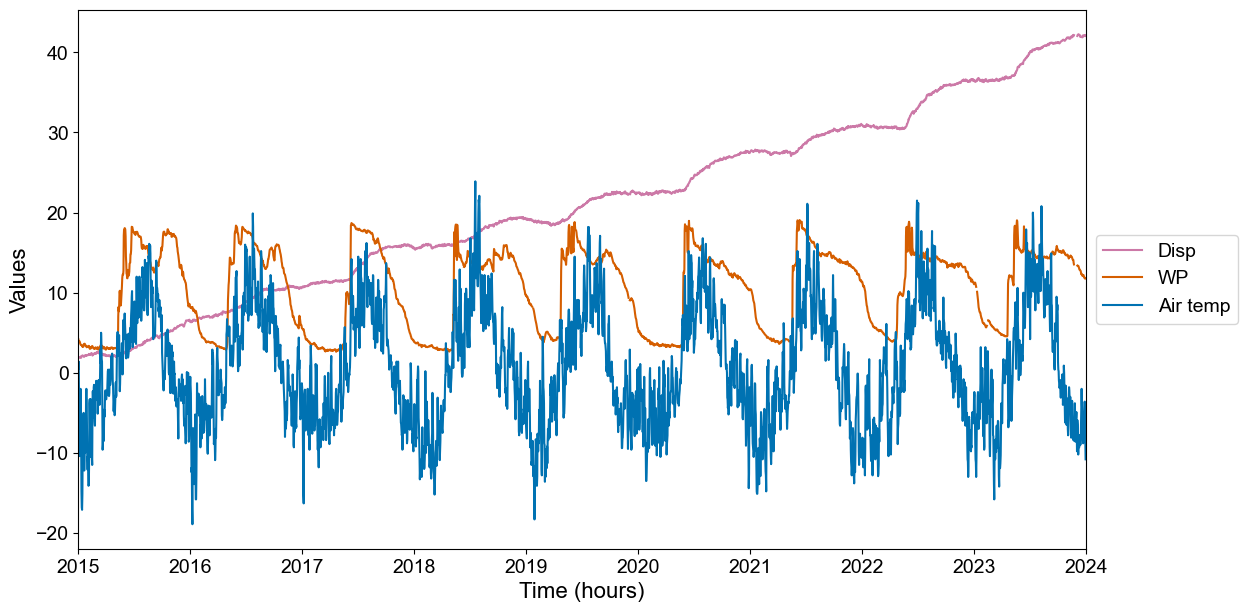

In [31]:
start_time = pd.Timestamp('2015-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
z = z[z.index.slice_indexer(start_time,end_time)]
z = z.resample('1d').median()

# f = ST.iloc[:,0] # hourly data intervals
# f = f[f.index.slice_indexer(start_time,end_time)]
# f = f.resample('1d').median()

original_df = pd.DataFrame({'Disp':x, 'WP':y, 'Temp': z, 'Rock_temp':f})
df.dropna(inplace=True)

#### Filtering #####

# NOISE FILTERING, LOW-PASS FILTERING (BUTTERFILTER)
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    data = data.values # values to filter
    nyq = 0.5 * fs # Nyquist Frequency, assumes regular time intervals
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y
    
# n = 7*4 # number of days cut off..  28 days can see clear smoothing, but that is a lot!
# fs = 1/24 # sample rate in hours 
# cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
# order = 2 # line from 1 to 0, second order is perfect function

# df = x.to_frame()
# df['interpolated'] = df.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
# df['butterfilt'] = butter_lowpass_filter(df.loc[:,'interpolated'], cutoff, fs, order) 
# x = df.copy()

# df = y.to_frame()
# df['interpolated'] = df.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
# df['butterfilt'] = butter_lowpass_filter(df.loc[:,'interpolated'], cutoff, fs, order) 
# y = df.copy()

# df = z.to_frame()
# df['interpolated'] = df.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
# df['butterfilt'] = butter_lowpass_filter(df.loc[:,'interpolated'], cutoff, fs, order) 
# z = df.copy()

# df = f.to_frame()
# df['interpolated'] = df.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
# df['butterfilt'] = butter_lowpass_filter(df.loc[:,'interpolated'], cutoff, fs, order) 
# f = df.copy()

################

# Plotting
fig, ax = plt.subplots(figsize=(13,7))

ax.plot(x.index, x.values, color=colors[0], label='Disp')
ax.plot(y.index, y.values, color=colors[1], label='WP')
ax.plot(z.index, z.values, color=colors[2], label='Air temp')
# ax.plot(f.index, f.values, color=colors[3], label='Ground temp')



# ax.plot(x.index, x.iloc[:,0], color=colors[0], label='Disp')
# ax.plot(x.index, x.loc[:,'butterfilt'], color='k', linestyle='dashed', label='Low-pass Butterworth filter')

# ax.plot(y.index, y.iloc[:,0], color=colors[1], label='WP')
# ax.plot(y.index, y.loc[:,'butterfilt'], color='k', linestyle='dashed', label='Low-pass Butterworth filter')

# ax.plot(z.index, z.iloc[:,0], color=colors[2], label='Air temp')
# ax.plot(z.index, z.loc[:,'butterfilt'], color='k', linestyle='dashed', label='Low-pass Butterworth filter')

# ax.plot(f.index, f.iloc[:,0], color=colors[3], label='Ground temp')
# ax.plot(f.index, f.loc[:,'butterfilt'], color='k', linestyle='dashed', label='Low-pass Butterworth filter')
                               
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Values')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# # saving
# path = 'plots\\'
# save_name = f'{path}validation_butterfilt_kh0118_cummulatedmodules.png'
# fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [8]:
def clean_lowpassfilt(file, col='add_col_name'): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
    file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    # file.rename(columns={'butterfilt':f'{col}'}, inplace=True) # I call it the same as original if it was dependent on name in scripts lower down
    return file

In [39]:
def clean_lowpassfilt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    # file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order)
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file

# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    df = df.resample(interval).median()
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_lowpassfilt(df.loc[:,col]).values
        # df.loc[:,col] = medfilt(df.loc[:,col], window)
        df.dropna(inplace=True)
    return df

start_time = pd.Timestamp('2017-01-01')
end_time = pd.Timestamp('2018-01-01')
interval = '1D'
test = clean_df(original_df,start_time,end_time, interval)

test.tail()

Disp     WP  Temp  Rock_temp
2017-12-28  15.694166  4.120  -9.5  -4.352175
2017-12-29  15.662293  4.085  -9.8  -4.660970
2017-12-30  15.544310  3.925  -7.6  -4.520070
2017-12-31  15.613049  3.920  -6.8  -4.172025
2018-01-01  15.510914  3.860  -3.9  -3.964470

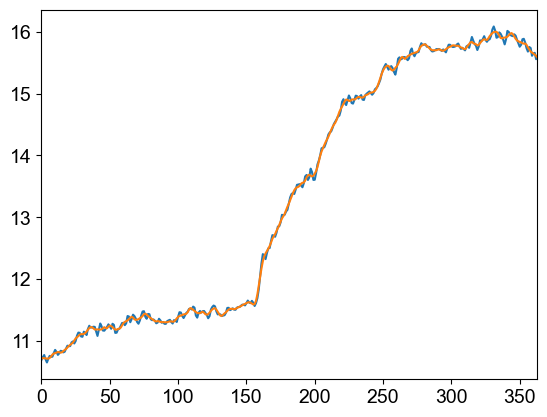

In [80]:
from scipy.signal import medfilt

from scipy.signal import savgol_filter
window_size = 11
poly_order = 3

from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    data = data.values # values to filter
    nyq = 0.5 * fs # Nyquist Frequency, assumes regular time intervals
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y
n = 3 # 7*4 # number of days cut off..  28 days can see clear smoothing, but that is a lot!
fs = 1/24 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function


data = df.loc[:,'Disp']

plt.plot(data.values)
# plt.plot(medfilt(data, 7))
plt.plot(savgol_filter(data, window_size, poly_order))
# plt.plot(butter_lowpass_filter(data, cutoff, fs, order))
# plt.legend(['original','medfilt','savgol','butter']) 
# plt.xlim(170,190)
# plt.ylim(12,14)

# butter is actually 'perfect' fit of data

### Testing which smoothing is best

SNR savgol: 187.72/nan = nan
SNR butter: 187.73/nan = nan
SNR medfilt: 187.73/nan = nan


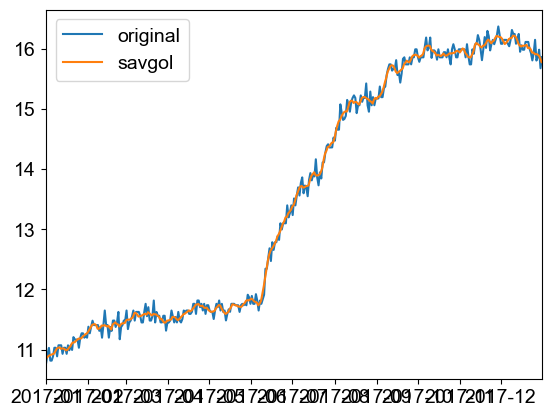

In [49]:
# differencing n rows to get seasonal and trend removed to obtain statinarity
def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series.reshape(-1) # transform back to correct shape

from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    data = data.values # values to filter
    nyq = 0.5 * fs # Nyquist Frequency, assumes regular time intervals
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

def clean_lowpassfilt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    # file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order)
    # file['medfilt'] = medfilt(file.iloc[:,-1], window)
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file

# values for the low pass filter
n = 3 # 7*4 # number of days cut off..  28 days can see clear smoothing, but that is a lot!
fs = 1/24 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function

# savgol parameters
window_size = 11
poly_order = 3

# median filter window
window = 7

#### create slice of df  #####
start_time = pd.Timestamp('2017-01-01')
end_time = pd.Timestamp('2018-01-01')

interval = '1D'

# original data
x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
y = JTT2WpUpperZone.iloc[:,0]
z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
f = ST.iloc[:,0] # hourly data intervals    
df = pd.concat([x,y,z,f], axis=1)
df.columns =['Disp', 'WP', 'Temp', 'Rock_temp']
df.dropna(inplace=True)
df = df[df.index.slice_indexer(start_time,end_time)]
# df = df.resample(interval).median()
original_df = df.copy()

# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    df = df.resample(interval).median()
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_lowpassfilt(df.loc[:,col]).values
        # df.loc[:,col] = medfilt(df.loc[:,col], window)
        df.dropna(inplace=True)
    return df

df = clean_df(original_df,start_time,end_time, interval)

# testing cleaning routine
col = 0
original_data = original_df.iloc[:,col]   # Replace with your actual data
smoothed_data = df.iloc[:,col]  # Replace with your filtered/smoothed data
savgol = smoothed_data.copy() # to plot
# Calculate the signal power (variance of smoothed data)
signal_power = np.mean(smoothed_data ** 2)

# Calculate the noise power (variance of the difference between original and smoothed data)
noise = original_data - smoothed_data
noise_power = np.mean(noise ** 2)

# Calculate SNR
snr = 10 * np.log10(signal_power / noise_power)

print(f"SNR savgol: {signal_power:.2f}/{noise_power:.2f} = {snr:.2f}") # High number is good! If SNR = 10, it means that signal is 10 times larger than noise

def clean_lowpassfilt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    # file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order)
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file
df = clean_df(original_df,start_time,end_time, interval)

smoothed_data = df.iloc[:,col]  # Replace with your filtered/smoothed data
butter = smoothed_data.copy() # to plot
# Calculate the signal power (variance of smoothed data)
signal_power = np.mean(smoothed_data ** 2)

# Calculate the noise power (variance of the difference between original and smoothed data)
noise = original_data - smoothed_data
noise_power = np.mean(noise ** 2)

# Calculate SNR
snr = 10 * np.log10(signal_power / noise_power)

print(f"SNR butter: {signal_power:.2f}/{noise_power:.2f} = {snr:.2f}") # High number is good! If SNR = 10, it means that signal is 10 times larger than noise


def clean_lowpassfilt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    # file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order)
    # file['medfilt'] = medfilt(file.iloc[:,-1], window)
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file
    
smoothed_data = df.iloc[:,col]  # Replace with your filtered/smoothed data

# Calculate the signal power (variance of smoothed data)
signal_power = np.mean(smoothed_data ** 2)

# Calculate the noise power (variance of the difference between original and smoothed data)
noise = original_data - smoothed_data
noise_power = np.mean(noise ** 2)

# Calculate SNR
snr = 10 * np.log10(signal_power / noise_power)

print(f"SNR medfilt: {signal_power:.2f}/{noise_power:.2f} = {snr:.2f}") # High number is good! If SNR = 10, it means that signal is 10 times larger than noise

plt.plot(original_data)
plt.plot(savgol)
# plt.plot(butter)
# plt.plot(smoothed_data)
plt.legend(['original','savgol','butter','medfilt'])

# butter is almost perfect match for signal, so try savgol to see if better for model as it smooths more, median is also very good

### Cleaning data and trying to model

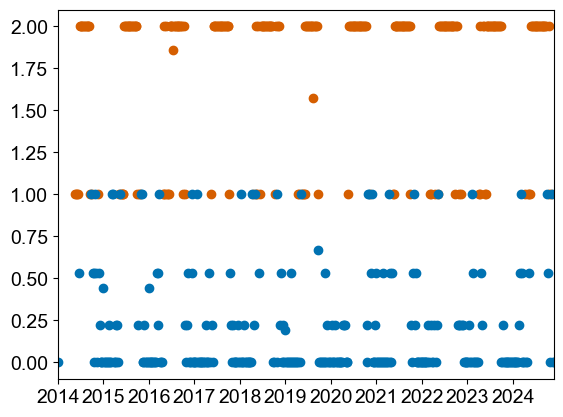

In [6]:
interval = '1W' # choose between 1D, 1W, 1M

df = jtt_temp.copy()
df = df.resample('D').mean()

# Ensure the temperature column is correctly indexed
temperature_column = 'temperature'

# Permafrost index
# Group by interval
if interval == '1W':
    interval_column  = 'week'
    df[f'{interval_column}'] = df.index.isocalendar().week
if interval == '1M':
    interval_column  = 'month'
    df[f'{interval_column}'] = df.index.month
days_above_zero_interval = df[df[temperature_column] > 0].groupby(['year', f'{interval_column}']).size().reset_index(name='days_above_zero')
days_below_zero_interval = df[df[temperature_column] < 0].groupby(['year', f'{interval_column}']).size().reset_index(name='days_below_zero')

merged_df = pd.merge(days_above_zero_interval, days_below_zero_interval, on=['year', f'{interval_column}'], how='outer').fillna(0)
# Create a 'date' column based on the interval
if interval == '1W':
    merged_df['date'] = merged_df.apply(lambda row: pd.Timestamp(f"{int(row['year'])}-01-01") + pd.Timedelta(weeks=int(row[f'{interval_column}'])-1), axis=1)
elif interval == '1M':
    merged_df['date'] = pd.to_datetime(merged_df[['year', f'{interval_column}']].assign(day=1))
# Set the 'date' column as the index
merged_df.set_index('date', inplace=True)

# Create the freeze index column
merged_df['freeze_index'] = merged_df['days_above_zero'] / (merged_df['days_below_zero'] + np.finfo(float).eps) # np.finfo(float).eps very smal value added to avoid dividing on zero

# Separate into warm and cold columns
merged_df['warm'] = merged_df['freeze_index'].apply(lambda x: x if x > 1 else np.nan)
merged_df['cold'] = merged_df['freeze_index'].apply(lambda x: x if x <= 1 else np.nan)

# Normalize warm and cold columns from 0 to 1
file = merged_df['warm']
merged_df['warm'] = ((file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))) +1 # normalized between 1 and 2
file = merged_df['cold']
merged_df['cold'] = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))

freeze_index = merged_df.copy()
plt.scatter(freeze_index.index, freeze_index['warm'], color=colors[1], label='Freeze index')
plt.scatter(freeze_index.index, freeze_index['cold'], color=colors[2], label='Freeze index')

In [105]:
df.head()

Disp  WP  Temp  Precip     River
2013-01-01 00:00:00   NaN NaN   NaN     NaN  1.099008
2013-01-01 00:30:00   NaN NaN   NaN     NaN  1.098908
2013-01-01 01:00:00   NaN NaN   NaN     NaN  1.098802
2013-01-01 01:30:00   NaN NaN   NaN     NaN    1.1356
2013-01-01 02:00:00   NaN NaN   NaN     NaN  1.132167

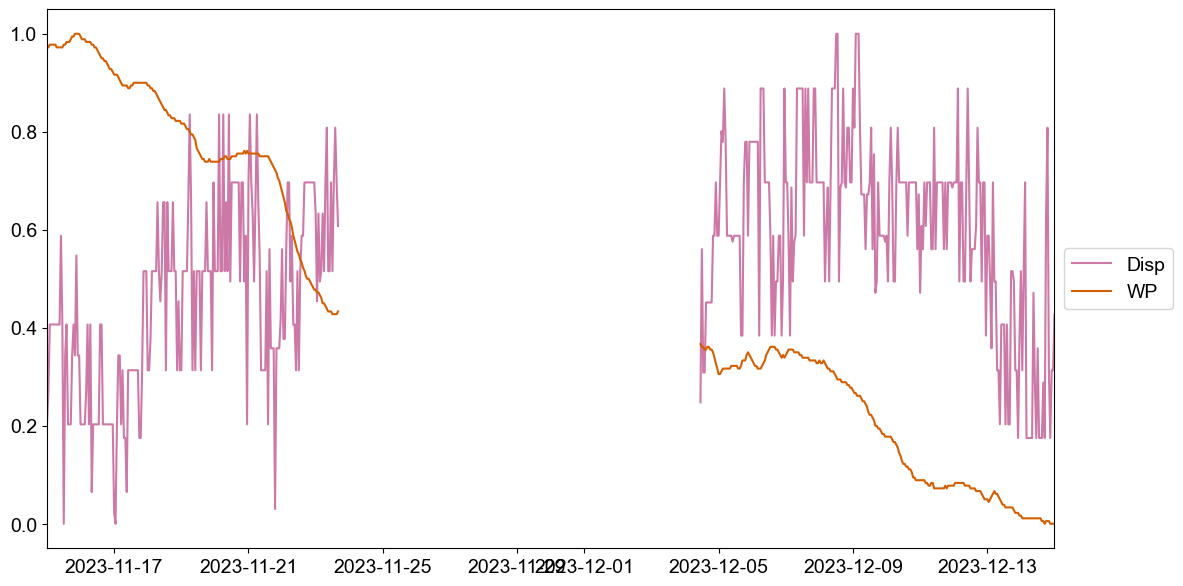

In [115]:
# # original data resampled to identical interval
# x = JTT2DispUpperZone.iloc[:,0] # hourly data intervals
# y = JTT2WpUpperZone.iloc[:,0] # hourly data intervals
# # z = jtt_xgeo_temp.iloc[:,0] # daily data intervals   
# z = jtt_temp.iloc[:,0] # hourly data intervals  # This did not work due to duplicate index (multiple identical timestamps)
# e = jtt_precip.iloc[:,0] # hourly data intervals
# f = river1.iloc[:,0].resample('1h').median() # 30 min data intervals
# df = pd.concat([x,y,z,e,f], axis=1)
# columns = ['Disp', 'WP', 'Temp', 'Precip', 'River']
# df.columns = columns

# interval = '1D
# x = JTT2DispUpperZone.iloc[:,0].resample(interval).median() # hourly data intervals
# y = JTT2WpUpperZone.iloc[:,0].resample(interval).median() # hourly data intervals
# # z = jtt_xgeo_temp.iloc[:,0] # daily data intervals   
# z = jtt_temp.iloc[:,0].resample(interval).median() # hourly data intervals  # This did not work due to duplicate index (multiple identical timestamps)
# e = jtt_precip.iloc[:,0].resample(interval).sum() # hourly data intervals
# f = river1.iloc[:,0].resample(interval).median() # 30 min data intervals
# df = pd.concat([x,y,z,e,f], axis=1)
# columns = ['Disp', 'WP', 'Temp', 'Precip', 'River']
# df.columns = columns

fig, ax = plt.subplots(figsize=(13,7))

plot_df = df.copy()

start_time = pd.Timestamp('2023-11-15')
end_time = pd.Timestamp('2023-12-15')
plot_df = plot_df[plot_df.index.slice_indexer(start_time,end_time)]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
plot_df = pd.DataFrame(scaler.fit_transform(plot_df),columns=columns, index=plot_df.index) # scale transform 0-1

ax.plot(plot_df.index, plot_df.iloc[:,0], color=colors[0], label=f'{columns[0]}')
ax.plot(plot_df.index, plot_df.iloc[:,1], color=colors[1], label=f'{columns[1]}')
# ax.plot(plot_df.index, plot_df.iloc[:,2], color=colors[2], label=f'{columns[2]}')
# ax.plot(plot_df.index, plot_df.iloc[:,3], color=colors[3], label=f'{columns[3]}')
# ax.plot(plot_df.index, plot_df.iloc[:,4], color=colors[4], label=f'{columns[4]}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [173]:
# original data resampled to identical interval
x = JTT2DispUpperZone.iloc[:,0].resample('1D').median() # hourly data intervals
y = JTT2WpUpperZone.iloc[:,0].resample('1D').median() # hourly data intervals
# z = jtt_xgeo_temp.iloc[:,0] # daily data intervals   
z = jtt_temp.iloc[:,0].resample('1D').median() # hourly data intervals  # This did not work due to duplicate index (multiple identical timestamps)
e = jtt_precip.iloc[:,0].resample('1D').sum() # hourly data intervals
f = river1.iloc[:,0].resample('1D').median() # 30 min data intervals
df = pd.concat([x,y,z,e,f], axis=1)
columns = ['Disp', 'WP', 'Temp', 'Precip', 'River']
# stat_type = [median(), median(),  median(), sum(),  median()] # did not work yet..
df.columns = columns
print('days')
print(df.isna().sum())



def clean_filt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='both',limit=60)
    # file = file.resample(interval).stat_type
    # file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    # file = file.dropna().reindex(file.index) # remove interpolated rows from df # Comment to use interpolation!
    return file['savgol']

# cleaned data
def clean_df(df,start_time,end_time):
    df = df[df.index.slice_indexer(start_time,end_time)]
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_filt(df.loc[:,col]).values # filtered data
        # df.loc[:,col] = medfilt(df.loc[:,col], window_median) # median filter
        df.loc[:, col] = df.loc[:, col].rolling(window=window_mean, center=True).mean() # rolling mean
    return df

interval = 'W-SUN'

df = df.dropna()
original_df = df.copy()
df = clean_df(original_df,start_time,end_time)
print('still days but after cleaning')
print(df.isna().sum())
# print(df.isna())
df = df.dropna() # should have a nice clean df now

x = df.iloc[:,0].resample(interval).median() # Disp, max at each time step interval, so basically just down sampling
x = diff_shift(x, 1) # velocity by differencing one row
y = df.iloc[:,1].resample(interval).median() # WP
z = df.iloc[:,2].resample(interval).median() # Temp
e = df.iloc[:,3].resample(interval).sum() # Precip
f = df.iloc[:,4].resample(interval).median() # River 
df = pd.concat([x,y,z,e,f], axis=1)
df.columns = columns
print('weeks')
print(df.isna().sum())
# print(df.isna())
# df = df.dropna() # how to solve this problem of nans??

days
Disp      625
WP        616
Temp      517
Precip    506
River      28
dtype: int64
False
False
False
False
False
still days but after cleaning
Disp      6
WP        6
Temp      6
Precip    6
River     6
dtype: int64
weeks
Disp      3
WP        1
Temp      1
Precip    0
River     1
dtype: int64


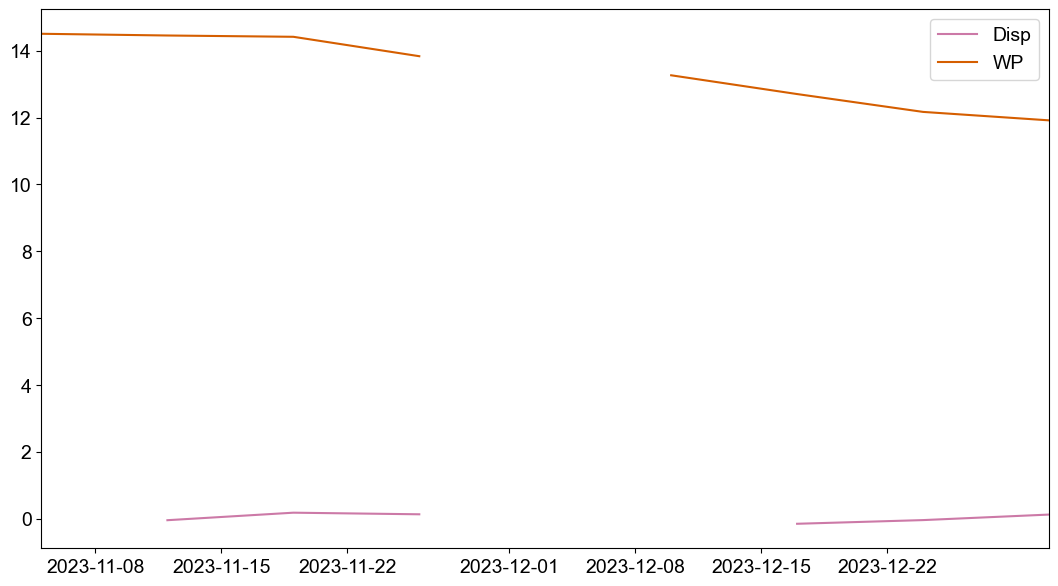

In [165]:
fig, ax = plt.subplots(figsize=(13,7))

start_time = pd.Timestamp('2023-11-01')
end_time = pd.Timestamp('2024-01-01')
plot_df1 = x[x.index.slice_indexer(start_time,end_time)]
plot_df2 = y[y.index.slice_indexer(start_time,end_time)]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
plot_df = pd.DataFrame(scaler.fit_transform(plot_df),columns=columns, index=plot_df.index) # scale transform 0-1

ax.plot(plot_df1.index, plot_df1.values, color=colors[0], label=f'{columns[0]}')
ax.plot(plot_df2.index, plot_df2.values, color=colors[1], label=f'{columns[1]}')
ax.legend()

In [6]:
# differencing n rows to get seasonal and trend removed to obtain statinarity
from scipy.signal import savgol_filter

def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series.reshape(-1) # transform back to correct shape

def clean_filt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    # file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file

# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_filt(df.loc[:,col]).values # filtered data
        # df.loc[:,col] = medfilt(df.loc[:,col], window_median) # median filter
        df.loc[:, col] = df.loc[:, col].rolling(window=window_mean, center=True).mean() # rolling mean
    return df

#### Actual script ####

# values for the butterworth filter
n = 3 # number of days cut off
fs = 1 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function

# median filter window
window_median = 15 # 7 might be okay and 29 is smooth, tried with 15 as a middle way to keep temp stationary

# rolling mean filter window
window_mean = 7 # 7 is enough to keep temp stationary

# savgol parameters
window_size = 11
poly_order = 3

# #### With rock temp  #####
# start_time = pd.Timestamp('2014-01-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
# end_time = pd.Timestamp('2019-01-01')

# interval = '1D' # choose between 1D, 1W, 1M

# # original data
# x = JTT2DispUpperZone.iloc[:,0] # hourly data intervals
# y = JTT2WpUpperZone.iloc[:,0] # hourly data intervals
# z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
# f = ST.iloc[:,0] # hourly data intervals    
# df = pd.concat([x,y,z,f], axis=1)
# df.columns =['Disp', 'WP', 'Temp', 'Rock_temp']
# df.dropna(inplace=True)
# file = df.copy()
# file = file[file.index.slice_indexer(start_time,end_time)] # slicing
# file = file.resample(interval).median() # downsampling with median value
# original_df = df.copy()

#### time window  #####
start_time = pd.Timestamp('2019-09-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
end_time = pd.Timestamp('2024-09-01')

interval = '1W' # choose between 1D, 1W, 1M

# # Freeze index
# freeze_ind = freeze_index(jtt_temp, interval=interval) # create this outside as it is grouping

# original data resampled to identical interval
x = JTT2DispUpperZone.iloc[:,0].resample('1D').mean() # hourly data intervals
y = JTT2WpUpperZone.iloc[:,0].resample('1D').mean() # hourly data intervals
# z = jtt_xgeo_temp.iloc[:,0] # daily data intervals   
z = jtt_temp.iloc[:,0].resample('1D').mean() # hourly data intervals  # This did not work due to duplicate index (multiple identical timestamps)
e = jtt_xgeo_rain.iloc[:,0].resample('1D').sum() # hourly data intervals
f = river1.iloc[:,0].resample('1D').mean() # 30 min data intervals
g = seismic.iloc[:,0] # daily data

df = pd.concat([x,y,z,e,f,g], axis=1)
df.columns =['Disp', 'WP', 'Temp', 'Precip', 'River', 'dv/v']
df = df.dropna()

# Using file data in the final plot of the model
file = df.copy()
file = file[file.index.slice_indexer(start_time,end_time)] # slicing
x = file.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
x = diff_shift(x, 1) # velocity by differencing one row
y = file.iloc[:,1].resample(interval).mean() # WP
z = file.iloc[:,2].resample(interval).mean() # Temp
e = file.iloc[:,3].resample(interval).sum() # Precip
f = file.iloc[:,4].resample(interval).mean() # River 
g = file.iloc[:,5] # dv/v
file = pd.concat([x,y,z,e,f,g], axis=1)
file.columns =['Disp', 'WP', 'Temp', 'Precip', 'River', 'dv/v']
file = file.dropna()

original_df = df.copy()
df = clean_df(original_df,start_time,end_time, interval)
x = df.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
x = diff_shift(x, 1) # velocity by differencing one row
y = df.iloc[:,1].resample(interval).mean() # WP
z = df.iloc[:,2].resample(interval).mean() # Temp
e = df.iloc[:,3].resample(interval).sum() # Precip
f = df.iloc[:,4].resample(interval).mean() # River 
g = df.iloc[:,5].resample(interval).mean() # dv/v
df = pd.concat([x,y,z,e,f,g], axis=1)
df.columns =['Disp', 'WP', 'Temp', 'Precip', 'River', 'dv/v']
df_train = df.dropna()

# # incorporating interaction and squared terms to see if it helps (adding non-linearity)
# df['WP_Temp'] = df['WP'] * df['Temp']
# df['WP_squared'] = df['WP'] ** 2
# df = df.dropna()

# # Using file data in the final plot of the model
# file = df.copy()
# file = file[file.index.slice_indexer(start_time,end_time)] # slicing
# x = file.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
# x = diff_shift(x, 1) # differencing disp
# y = file.iloc[:,1].resample(interval).mean() # WP
# z = file.iloc[:,2].resample(interval).mean() # Temp
# e = file.iloc[:,3].resample(interval).sum() # Precip
# f = file.iloc[:,4].resample(interval).mean() # River 
# h = file.iloc[:,5].resample(interval).mean() #  
# g = file.iloc[:,6].resample(interval).mean() #  
# file = pd.concat([x,y,z,e,f,h,g], axis=1)
# file.columns =['Disp', 'WP', 'Temp', 'Precip', 'River', 'WP*Temp','WP**2']
# file = file.dropna()

# original_df = df.copy()
# df = clean_df(original_df,start_time,end_time, interval) # cleaning, not in use currently
# x = df.iloc[:,0].resample(interval).mean() # Disp, max at each time step interval, so basically just down sampling
# x = diff_shift(x, 1) # differencing disp
# y = df.iloc[:,1].resample(interval).mean() # WP
# z = df.iloc[:,2].resample(interval).mean() # Temp
# e = df.iloc[:,3].resample(interval).sum() # Precip
# f = df.iloc[:,4].resample(interval).mean() # River 
# h = df.iloc[:,5].resample(interval).mean() #  
# g = df.iloc[:,6].resample(interval).mean() #  
# df = pd.concat([x,y,z,e,f,h,g], axis=1)
# df.columns =['Disp', 'WP', 'Temp', 'Precip', 'River', 'WP*Temp','WP**2']
# df = df.dropna()

# Apply decompose (decompose trend, seasonality, and resudials) to make data stationary
from statsmodels.tsa.seasonal import STL

df_list = []
for i,d in enumerate(df_train.columns):
    df = []
    original = df_train.loc[:,d] # data
    # seasonal decompositoon parameters
    if interval == '1M':
        seasonal = 13 # can try 7 to 13 from chatgpt, but need to test this to see what is correct
        period = 12 
    if interval == '1W':
        seasonal = 13 # can try 7 to 13 from chatgpt
        period = 52 
    if interval == '1D':
        seasonal = 13 # 7 to 25 from chatgpt
        period = 365 
    decomposed_series = STL(original, seasonal=seasonal, period=period).fit() # for daily should be 13 and 365
    trend = decomposed_series.trend
    seasonal = decomposed_series.seasonal
    residual = decomposed_series.resid
    df = pd.DataFrame({'original':original.values, 'trend': trend.values, 'seasonal':seasonal.values, 'residual':residual.values}, index=df_train.index) 
    df.dropna(inplace=True)
    
    #### Comment this part out when finished looking at what series is stationary  ####
    # correlating?
    print(f'{d}')
    # print(df.corr()) # correlations

    #### testing stationarity ####
    from statsmodels.tsa.stattools import adfuller
    for i, variable in enumerate(df.columns):
        # Perform the ADF test
        result = adfuller(df[variable])

        # Extract and print the p-value from the test result
        p_value = result[1]
        print("p-value:", p_value)

        # Interpret the result
        if p_value <= 0.05: # 0.05 or 0.001
            print(f"The variable {variable} is stationary.\n")
        else:
            print(f"The variable {variable} is not stationary.\n")
###############################

    # # choosing just one year
    # df = df[df.index.slice_indexer(pd.Timestamp('2016-01-01'),pd.Timestamp('2017-01-01'))]

    df_list.append(df)

# without non linear part
col = 'original' # only use the ones that passes ADF test
df = pd.DataFrame({'Disp':df_list[0].loc[:,col], 'WP':df_list[1].loc[:,col], 'Temp':df_list[2].loc[:,col],'Precip':df_list[3].loc[:,col], 'River':df_list[4].loc[:,col] ,'dv/v':df_list[5].loc[:,col]}) # only disp original is not stationary so chosen orig-trend, others original

# now scale and transform data so variables are of similar weight 
#(If you are developing a model that has a scientific value then you need to get rid of the units of the input variables. That’s because a model, if it is fundamental, should not depend on the particular units you use (https://www.quora.com/Should-you-standardise-data-before-regression))
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
# df = pd.DataFrame(scaler.fit_transform(df),columns=['Disp', 'WP', 'Temp', 'Precip', 'River'], index=df.index) # scale transform 0-1 # ,'Rock_temp'
# df.dropna(inplace=True)

# # If non linear part uncomment this 
# col = 'original' # only use the ones that passes ADF test
# df = pd.DataFrame({'Disp':df_list[0].loc[:,col], 'WP':df_list[1].loc[:,col], 'Temp':df_list[2].loc[:,col],'Precip':df_list[3].loc[:,col], 'River':df_list[4].loc[:,col],'WP*Temp':df_list[5].loc[:,col], 'WP**2':df_list[6].loc[:,col]}) #,'Rock_temp':df_list[3].loc[:,col]}) # only disp original is not stationary so chosen orig-trend, others original

C:\Users\andregas\AppData\Local\Temp\ipykernel_3040\2463488498.py:15: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')


Disp
p-value: 0.00034490679453985515
The variable original is stationary.

p-value: 0.21921583572490555
The variable trend is not stationary.

p-value: 0.0004891382846198967
The variable seasonal is stationary.

p-value: 3.504978549748118e-21
The variable residual is stationary.

WP
p-value: 0.0012748091893738749
The variable original is stationary.

p-value: 0.21366965517275965
The variable trend is not stationary.

p-value: 0.0008495219115573874
The variable seasonal is stationary.

p-value: 3.637764700878173e-06
The variable residual is stationary.

Temp
p-value: 1.5269242532808968e-06
The variable original is stationary.

p-value: 0.31337476549292664
The variable trend is not stationary.

p-value: 4.052603510058442e-06
The variable seasonal is stationary.

p-value: 3.3567860360320664e-19
The variable residual is stationary.

Precip
p-value: 1.1596978259814117e-05
The variable original is stationary.

p-value: 0.4419464307044489
The variable trend is not stationary.

p-value: 4.0641

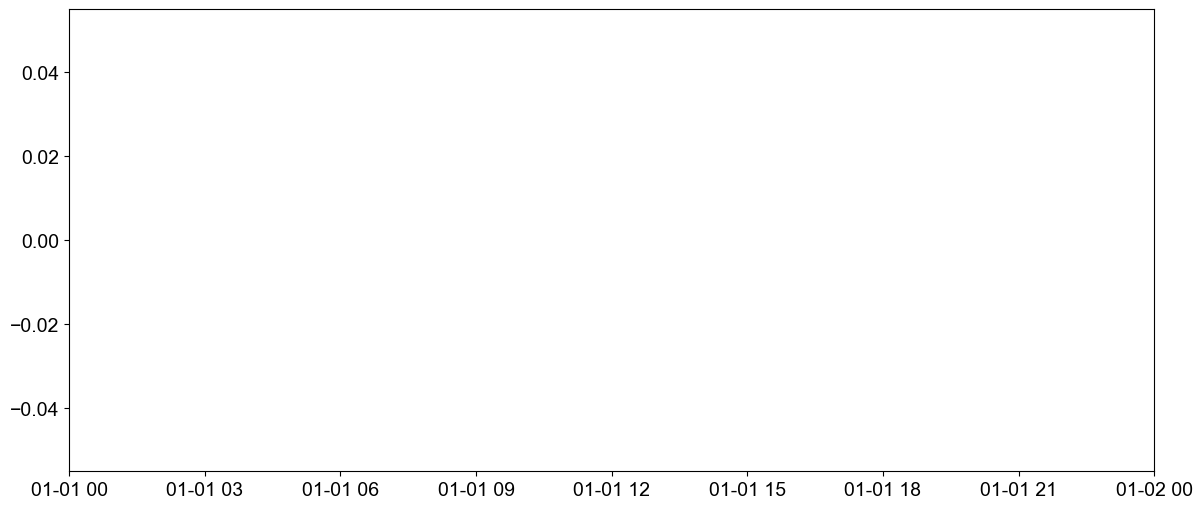

In [59]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(file.iloc[365*7:365*8,0])

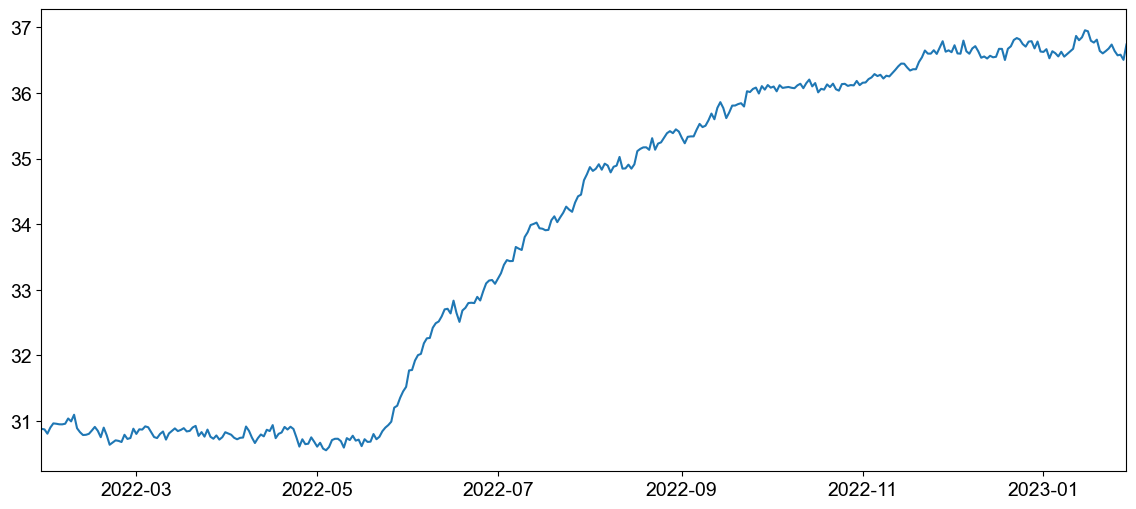

In [128]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(file.iloc[365*7:365*8,0])

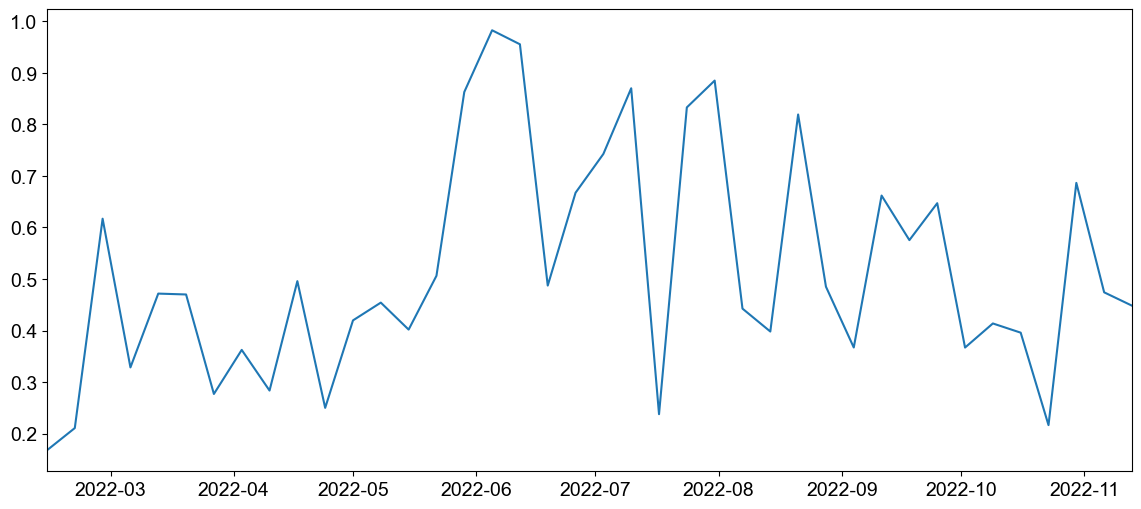

In [173]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.iloc[int(53*7):int(53*8),0])

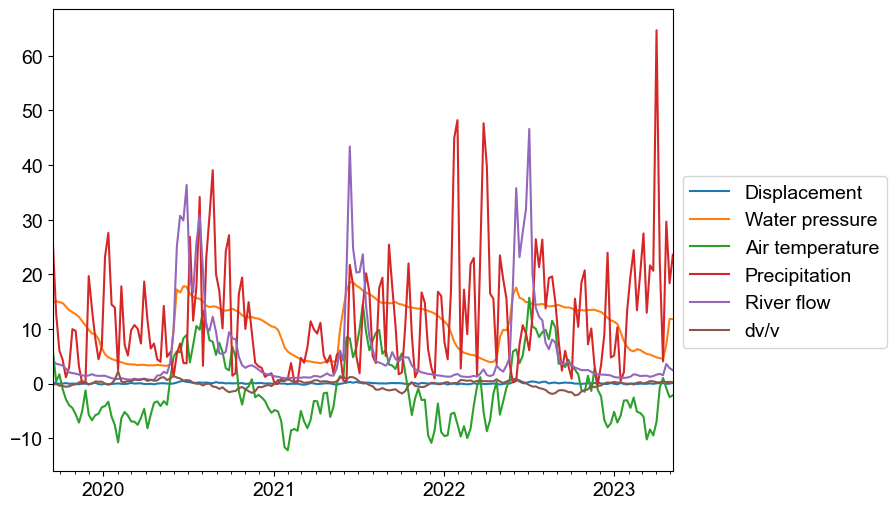

In [185]:
# Plotting scaled dataset
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df.iloc[:,0], label='Displacement')
ax.plot(df.iloc[:,1], label='Water pressure')
ax.plot(df.iloc[:,2], label='Air temperature')
ax.plot(df.iloc[:,3], label='Precipitation')
ax.plot(df.iloc[:,4], label='River flow')
ax.plot(df.iloc[:,5], label='dv/v')
# ax.plot(df.iloc[:,6], label='WP**2')
# ax.plot(df.iloc[:,3], label='Rock temperature')

ax.legend(loc='upper left', bbox_to_anchor=(1, 0.66))
# ax.set_ylabel("Scaled from 0 to 1")

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax.xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax.xaxis.set_major_formatter(years_fmt)

# # removing tick labels from the xaxis
# n = 1  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

### Corelation matrix

In [145]:
import pandas as pd
import numpy as np
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=2))

### FFT to see frequencies and periodicity

C:\Users\andregas\AppData\Local\Temp\ipykernel_24172\166008394.py:38: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(frequencies != 0, 1 / frequencies, 0)



NB!! Meant for daily data!!


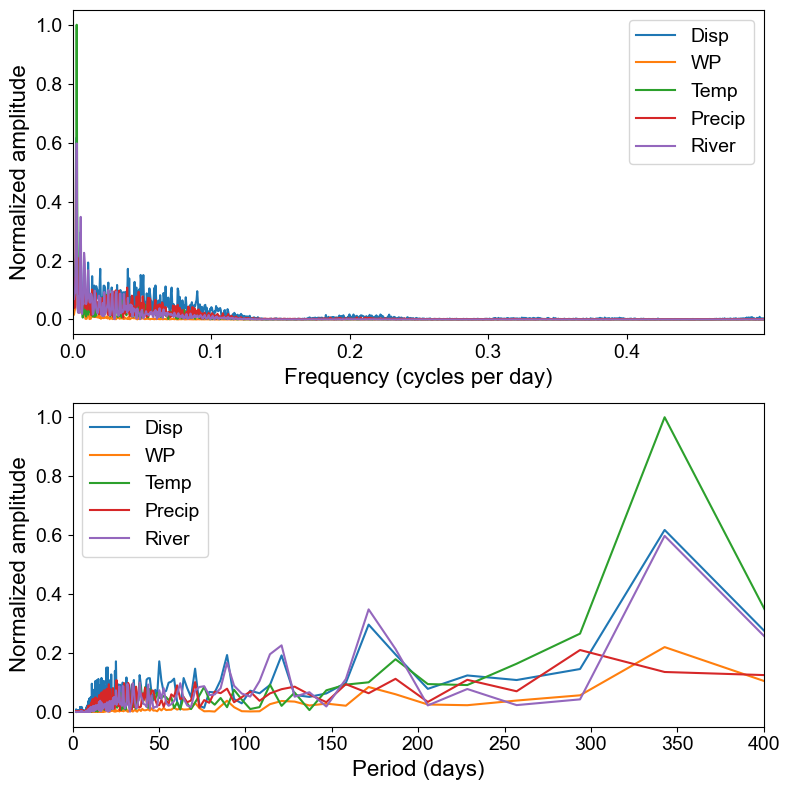

In [48]:
import numpy as np
import matplotlib.pyplot as plt

type = 'original'


# Function to normalize amplitude
def normalize_amplitude(signal):
    fft_result = np.fft.fft(signal)
    amplitude = np.abs(fft_result) / len(signal)
    return (amplitude-np.nanmin(amplitude))/(np.nanmax(amplitude)-np.nanmin(amplitude))

# Plot amplitude vs. frequency
fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), nrows=2)

for i,col in enumerate(df.columns):

    # Number of sample points
    N = int(((df_list[i].index[-1] - df_list[i].index[0]) / np.timedelta64(1, 'D')))
    # Sample spacing
    T = 1.0  # frequency per day
    t = np.linspace(0.0, N * T, N)  # Time variable
    
    signal = df_list[i].loc[:, type].values
    
    # Normalize the amplitude
    amplitude = normalize_amplitude(signal)
    
    # Get the corresponding frequencies
    n = len(signal)
    frequencies = np.fft.fftfreq(n, d=(t[1] - t[0]))
    
    ax1.plot(frequencies[:n // 2], amplitude[:n // 2], label=f'{col}')  # Only positive frequencies
    ax1.set_xlabel("Frequency (cycles per day)")
    ax1.set_ylabel("Normalized amplitude")
    
    # Convert frequencies to periods (T = 1/f), avoid division by zero
    periods = np.where(frequencies != 0, 1 / frequencies, 0)
    
    # Mask out very small periods (e.g., less than 1 day) to avoid clutter
    valid_idx = periods > 1  # Only include periods greater than 1 day
    
    # Plot amplitude vs. period (focus on positive frequencies/periods)
    ax2.plot(periods[valid_idx][:n // 2], amplitude[valid_idx][:n // 2],  label=f'{col}')  # Only positive frequencies

# Adjust x-axis limits to focus on relevant periods (0 to 400 days)
ax2.set_xlim(0, 400)
ax2.set_xlabel("Period (days)")
ax2.set_ylabel("Normalized amplitude")

# Final touches
ax1.legend()
ax2.legend()
plt.tight_layout()

# Upper plot. No daily signal, just longer duration signals as it dies above 0.1
# Lower plot. There are several spikes over the year with a peak yearly signal, and several peaks, bi-yearly, and around quarterly signals

print('\nNB!! Meant for daily data!!')

### Cross correlation

In [11]:
df.head()

Disp        WP       Temp    Precip     River
2019-01-13 -0.006118  8.896237  -5.353454  4.705278  1.716075
2019-01-20 -0.058931  8.411093 -10.140663  1.321945  1.573527
2019-01-27 -0.122704  7.742110 -12.981878 -0.021112  1.261064
2019-02-03 -0.071080  6.660453 -11.455027 -0.002098  1.102726
2019-02-10 -0.019324  5.358626  -9.866550  1.241492  1.080954

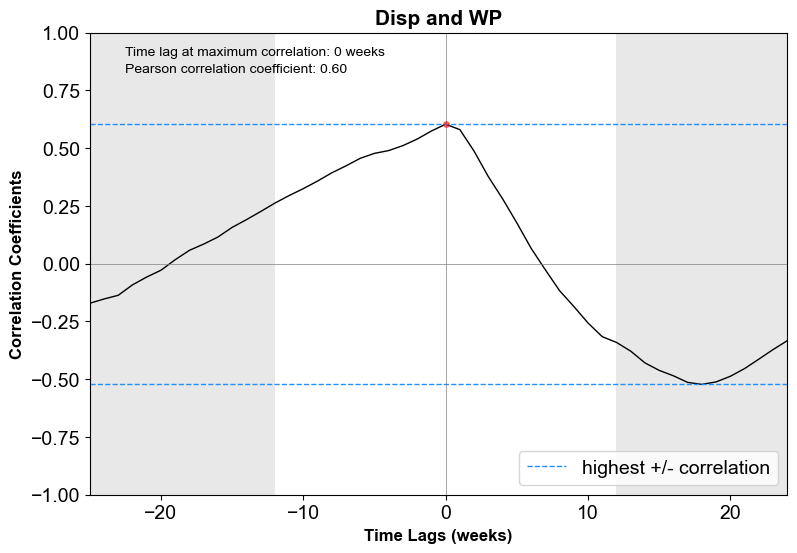

In [9]:
# This method is good. Same outcome as for statsmodels ccf

# Do correlations on stationary variables!

crosscorr_lag = 6 # tried 3 months did not work, tried 12 months = too much. Try 6 months now and only look at 3 months by graying out the boarders.

series1 = df.iloc[:,0] #  disp
series2 = df.iloc[:,1] #  wp

# series1 = df.iloc[:,0] #  disp
# series2 = df.iloc[:,2] #  temp

# series1 = df.iloc[:,0] #  disp
# series2 = df.iloc[:,4] #  river

# Set the maximum lag you want to consider

#### frequency ####
if interval == '1D':
    h = 1 # per day 
    time_inter = 'days'
if interval == '1W':
    h = 1/7 # per week 
    time_inter = 'weeks'
if interval == '1M':
    h = 1/30 # per week 
    time_inter = 'months'
#######################
n_months = crosscorr_lag
period = int(h*90) # we assume correlation should happen within 90 days # to make sure it is an integer number
max_lag = int(n_months*30*h) # to make sure it is an integer number
lags = range(-max_lag, max_lag)

# Initialize arrays to store results
correlation_coefficients = []
p_values = []

# Loop through different time lags (both positive and negative)
for lag in lags:
    # Calculate Pearson correlation coefficient and p-value
    if lag < 0:
        correlation_coefficient, p_value = pearsonr(series1[:lag], series2[-lag:])
    elif lag == 0:
        correlation_coefficient, p_value = pearsonr(series1, series2)
    else:
        correlation_coefficient, p_value = pearsonr(series1[lag:], series2[:-lag])

# # Loop through different time lags (both positive and negative)
# for lag in lags:
#     # Calculate Spearman correlation coefficient and p-value
#     if lag < 0:
#         correlation_coefficient, p_value = spearmanr(series1[:lag], series2[-lag:])
#     elif lag == 0:
#         correlation_coefficient, p_value = spearmanr(series1, series2)
#     else:
#         correlation_coefficient, p_value = spearmanr(series1[lag:], series2[:-lag])
    
    # Append results to arrays
    correlation_coefficients.append(correlation_coefficient)
    p_values.append(p_value)

# # Find the lag with the maximum absolute correlation for entire time series
# max_corr_index = np.argmax(np.abs(correlation_coefficients))
# max_corr_lag = lags[max_corr_index]

# Find the lag with the maximum absolute correlation within +/- 3 months
corr_window = correlation_coefficients[period:period*3]
max_corr_index = np.argmax(np.abs(corr_window))
max_corr_lag = lags[period:period*3][max_corr_index]

n_std = 2
small_size = 10

import scipy.stats as st 
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf, color='black', lw=1)
    ax.axvline(x = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = np.max(ccf), color = 'dodgerblue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'dodgerblue', lw = 1, linestyle='--')
    ax.plot(max_corr_lag, corr_window[max_corr_index], color='red', marker='o', markersize=4, alpha=0.5) # zorder=0 # point to highlight max within corr_window # point to highlight max within corr_window
    
    # # 2 x std
    # ax.axhline(y = np.mean(ccf)+n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--', label = f'{n_std} x std')
    # ax.axhline(y = np.mean(ccf)-n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--')
    # # # 1 x std
    # # ax.axhline(y = np.mean(ccf)+1*np.std(ccf), color = 'red', lw = 1, linestyle='--', label = f'{1} x std')
    # # ax.axhline(y = np.mean(ccf)-1*np.std(ccf), color = 'red', lw = 1, linestyle='--')
    
    # gray out area
    ax.axvspan(lags_plot[0], -period, facecolor='lightgray', alpha=0.5)
    ax.axvspan(+period,lags_plot[-1], facecolor='lightgray', alpha=0.5)
    
    # text in the plot
    y_pos = lags_plot[0]-(lags_plot[0]*0.1)
    ax.text(y_pos, 0.90, f'Time lag at maximum correlation: {max_corr_lag:.0f} {time_inter}', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.83, f'Pearson correlation coefficient: {corr_window[max_corr_index]:.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    # ax.text(y_pos, 0.76, f'2 x standard deviation: +{np.mean(ccf)+n_std*np.std(ccf):.2f}/{np.mean(ccf)-n_std*np.std(ccf):.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    pval = []
    # if p_values[max_corr_index] < 0.001:
    #     ax.text(y_pos, 0.69, f'P-value: <0.001', horizontalalignment='left', color='k', fontsize=small_size)
    # else:
    #     ax.text(y_pos, 0.69, f'P-value: {p_values[max_corr_index]:.3f}', horizontalalignment='left', color='k', fontsize=small_size)
    
    # cosmetics
    ax.set(ylim = [-1, 1])
    ax.set_title(f'{series1.name} and {series2.name}', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel(f'Time Lags ({time_inter})', weight='bold', fontsize = 12)
    
    plt.legend(loc='lower right')
    
    # saving
    path = 'plots\\'
    save_name = f'{path}crosscorr_{series1.name}_{series2.name}_lag{n_months}.png'
    fig.savefig(save_name, dpi=300, bbox_inches='tight')
    
# setting size of plotting window
lags_plot = np.linspace(lags[0],lags[-1], num=int(max_lag*2)) # use the interval of df

ccf_plot(lags_plot, correlation_coefficients)

# the first variable (x) is leading if negative lage time, and second variable (y) is leading if positive lag time

### Modeling

<Axes: >

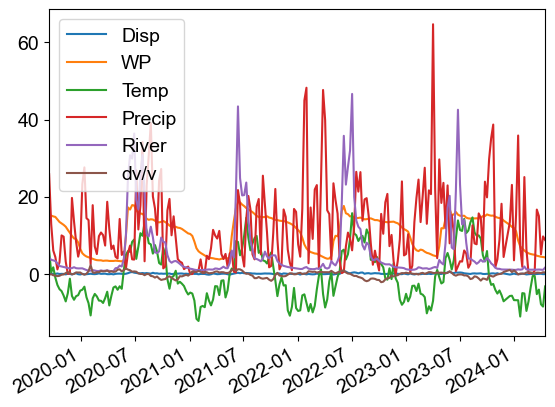

In [8]:
df.plot()

In [10]:
# need to have statinary data before running model
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

# forsøk uten AR term, endog_lag = 0

df_features = df[['Disp', 'WP', 'Precip', 'Temp', 'River', 'dv/v']]
# df_features = df[['Disp', 'WP', 'Precip', 'Temp', 'River', 'WP*Temp', 'WP**2']] # 'Precip', need more than two years to add these ,'WP*Temp', 'WP**2']].reset_index(drop=True) # Nonlinear part

# # Tried adding month as predictor, did not show any significance..
# df['Month'] = df.index.month
# df_features = df[['Disp', 'WP', 'Month']]

# Scaling
# now scale and transform data so variables are of similar weight 
#(If you are developing a model that has a scientific value then you need to get rid of the units of the input variables. That’s because a model, if it is fundamental, should not depend on the particular units you use (https://www.quora.com/Should-you-standardise-data-before-regression))
from sklearn.preprocessing import MinMaxScaler

# Scale together
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
scaled_combined = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns, index=df_features.index)


# #### Fix warning from ardl_sel_order function ####

# # USE THE Interpolated part, separate one interpolated and one raw data.. Use interpolated in model. Probably clear chace or close a lot in edge as it use a lot of memory.. Do this to be able to run the other tab (untitled1 with JTT1)

# # Create a complete date range with weekly frequency
# date_range = pd.date_range(start=scaled_combined.index.min(), end=scaled_combined.index.max(), freq='W-SUN')

# # Reindex your DataFrame to align with the complete date range
# scaled_combined = scaled_combined.reindex(date_range)

# # Set the frequency of the date index
# scaled_combined.index.freq = 'W-SUN'
# scaled_combined.index = pd.DatetimeIndex(scaled_combined.index, freq=interval[1])  # Set frequency to daily

# ####################################################

# Split into train and test
cutoff_index = scaled_combined.index[int(scaled_combined.shape[0] * 0.80)] # train with X % data. 80 % is not enough to make stationary, but 85 % is.
# cutoff_index = pd.Timestamp('2022-01-01')
df_train = scaled_combined.loc[:cutoff_index]
df_test = scaled_combined.loc[cutoff_index:]

# Separate back into response and explanatory
response = df_train[['Disp']]
explanatory = df_train[['WP', 'Temp', 'Precip', 'River', 'dv/v']] 
# explanatory = scaled_combined[['WP', 'Temp', 'Precip', 'River', 'WP*Temp', 'WP**2']] 

# Optimal order with 0 to 90 lags is 3,4,3 for disp, wp, and temp (bic) and 90,90,90 (aic). A bit strange but try and plot and see if it makes sense! It is almost a perfect match for bic

if interval == '1D':
    exog_lag = 90 # 90 days 
if interval == '1W':
    exog_lag = 13 # equal to 90 days 
if interval == '1M':
    exog_lag = 3 # equal to 90 days 

# Set if AR or not for model
endog_lag = exog_lag # same as explanatory variables
# endog_lag = 0 # No autoregressive term

In [215]:
scaled_combined.tail()

Disp        WP    Precip      Temp     River      dv/v
2024-03-17  0.190976  0.094365  0.259021  0.248838  0.009573  0.558354
2024-03-24  0.248131  0.085168  0.233017  0.291474  0.010198  0.553356
2024-03-31  0.281987  0.077386  0.080031  0.154973  0.009391  0.533752
2024-04-07  0.153185  0.073004  0.151682  0.133383  0.008446  0.579983
2024-04-14  0.184400  0.065752  0.137360  0.320861  0.021099  0.566554

In [155]:
# 'Manual automatic'

response = scaled_combined[['Disp']]
explanatory = scaled_combined[['WP', 'Temp', 'Precip', 'River', 'dv/v']] 

import itertools
import time
import gc
from joblib import Parallel, delayed
from statsmodels.tsa.ardl import ARDL
import multiprocessing as mp
from __future__ import annotations

from statsmodels.compat.pandas import Appender, Substitution, call_cached_func

from collections import defaultdict
from collections.abc import Hashable, Mapping, Sequence
import datetime as dt
from itertools import combinations, product
import textwrap
from types import SimpleNamespace
from typing import TYPE_CHECKING, Any, Literal, NamedTuple, Optional, Union
import warnings

import numpy as np
import pandas as pd
from scipy import stats

from statsmodels.base.data import PandasData
import statsmodels.base.wrapper as wrap
from statsmodels.iolib.summary import Summary, summary_params
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.decorators import cache_readonly
from statsmodels.tools.docstring import Docstring, Parameter, remove_parameters
from statsmodels.tools.sm_exceptions import SpecificationWarning
from statsmodels.tools.typing import (
    ArrayLike1D,
    ArrayLike2D,
    Float64Array,
    NDArray,
)
from statsmodels.tools.validation import (
    array_like,
    bool_like,
    float_like,
    int_like,
)
from statsmodels.tsa.ar_model import (
    AROrderSelectionResults,
    AutoReg,
    AutoRegResults,
    sumofsq,
)
from statsmodels.tsa.ardl import pss_critical_values
from statsmodels.tsa.arima_process import arma2ma
from statsmodels.tsa.base import tsa_model
from statsmodels.tsa.base.prediction import PredictionResults
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.ardl import ARDLOrderSelectionResults
from statsmodels.tsa.ardl import ARDLResults
import warnings

# ### Trying to debugg memory error
# import sys
# import logging
# import io as i_o
# # Create an in-memory log buffer
# log_stream = i_o.StringIO()

# # Configure logging to write to the in-memory buffer
# logging.basicConfig(
#     stream=log_stream,
#     level=logging.INFO,
#     format="%(asctime)s - %(levelname)s - %(message)s",
# )

# Suppress warning
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning)

def ardl_select_order(
    endog: ArrayLike1D | ArrayLike2D,
    maxlag: int,
    exog: ArrayLike2D,
    maxorder: int | dict[Hashable, int],
    trend: Literal["n", "c", "ct", "ctt"] = "c",
    *,
    fixed: ArrayLike2D | None = None,
    causal: bool = False,
    ic: Literal["aic", "bic"] = "bic",
    glob: bool = False,
    seasonal: bool = False,
    deterministic: DeterministicProcess | None = None,
    hold_back: int | None = None,
    period: int | None = None,
    missing: Literal["none", "raise"] = "none",
) -> ARDLOrderSelectionResults:

    def compute_ics(y, x, df):
        if x.shape[1]:
            resid = y - x @ np.linalg.lstsq(x, y, rcond=None)[0]
        else:
            resid = y
        nobs = resid.shape[0]
        sigma2 = 1.0 / nobs * sumofsq(resid)
        llf = -nobs * (np.log(2 * np.pi * sigma2) + 1) / 2
        res = SimpleNamespace(
            nobs=nobs, df_model=df + x.shape[1], sigma2=sigma2, llf=llf
        )

        aic = call_cached_func(ARDLResults.aic, res)
        bic = call_cached_func(ARDLResults.bic, res)
        hqic = call_cached_func(ARDLResults.hqic, res)
        del resid # free memory

        return aic, bic, hqic

    base = ARDL(
        endog,
        maxlag,
        exog,
        maxorder,
        trend,
        fixed=fixed,
        causal=causal,
        seasonal=seasonal,
        deterministic=deterministic,
        hold_back=hold_back,
        period=period,
        missing=missing,
    )
    hold_back = base.hold_back
    blocks = base._blocks
    always = np.column_stack([blocks["deterministic"], blocks["fixed"]])
    always = always[hold_back:]
    select = []
    iter_orders = []
    select.append(blocks["endog"][hold_back:])
    iter_orders.append(list(range(blocks["endog"].shape[1] + 1)))
    var_names = []
    for var in blocks["exog"]:
        block = blocks["exog"][var][hold_back:]
        select.append(block)
        iter_orders.append(list(range(block.shape[1] + 1)))
        var_names.append(var)
    y = base._y

    # Trying to add parallel processing for this step
    
    # Function to generate combinations dynamically
    def generate_combinations(start, stop, lag_range, num_vars):
        # Manually calculate combinations based on indices
        total_combinations = lag_range ** num_vars
        for index in range(start, min(stop, total_combinations)):
            # Convert index to a tuple of lag values
            combo = []
            temp = index
            for _ in range(num_vars):
                combo.append(temp % lag_range)
                temp //= lag_range
            yield tuple(reversed(combo))
    
    ######## Parallel processing function with dynamically generated combinations inside to save memory
    def fit_ardl_with_ranges(start, stop, lag_range, num_vars):
        ics = {}
        best_bic = float('inf')
        best_combo = None
        
        # manager = mp.Manager()
        # progress = manager.Value('d', 0.0)  # Shared variable to store progress

        # log_stream = i_o.StringIO()
        # logging.basicConfig(
        #     stream=log_stream,
        #     level=logging.INFO,
        #     format="%(asctime)s - %(processName)s - %(levelname)s - %(message)s",
        # )
        # # check_interval = 1000  # Check growth every 1000 combinations
    
        # Generate combinations within the range
        for count, io in enumerate(generate_combinations(start, stop, lag_range, num_vars)):
            percentage = (count/stop)*100
            # progress.value = percentage
            if count % (stop // 50) == 0:  # Print every 1000, 0.1% 100, 1%, 50, 5%
                print(f"\rFinished: {int(percentage)} %", end="", flush=True)
            x = np.column_stack([a[:, : io[i]] for i, a in enumerate(select)])
            key = [io[0] if io[0] else None]
            for j, val in enumerate(io[1:]):
                var = var_names[j]
                if causal:
                    key.append((var, None if val == 0 else val))
                else:
                    key.append((var, val - 1 if val - 1 >= 0 else None))
            key = tuple(key)

             # Compute ICs without storing all in ics
            aic, bic, hqic = compute_ics(y, x, 0)
            if bic < best_bic:
                best_bic = bic
                best_order = key
    
            del x  # Free memory for x after usage
    
        return best_bic, best_order
    
        #     ics[key] = compute_ics(y, x, 0) # 0 degrees of freedom
        #     # Periodically monitor ics growth
        #     if count % check_interval == 0:
        #         logging.info(f"Processed {count} combinations")
        #         logging.info(f"Number of entries in ics: {len(ics)}")
        
        # index = {"aic": 0, "bic": 1, "hqic": 2}[ic]
        # lowest = np.inf
        # for key in ics:
        #     val = ics[key][index]
        #     if val < lowest:
        #         lowest = val
        #         selected_order = key
        # # return lowest, selected_order
        # return ics #log_stream.getvalue()
    
    # single core processing
    results = fit_ardl_with_ranges(0, total_combinations, exog_lag_range, len(exog_vars) + 1) # To test without parallel processing
    print(f"\nOverall Best BIC: {results[0]} with combination: {results[1:]}")
    return results #best_bic_overall, best_params
    
    # # Parallel processing part
    # # Setup multiprocessing
    # num_cores = mp.cpu_count() # Number of parallel processes
    # print(f'Using {num_cores} cores for parallel processing...')
    # chunk_size = total_combinations // num_cores  # Divide by number of cores
    # results = Parallel(n_jobs=num_cores, backend='loky')(
    #     delayed(fit_ardl_with_ranges)(
    #         i * chunk_size, (i + 1) * chunk_size, exog_lag_range, len(exog_vars) + 1
    #     )
    #     for i in range(num_cores)
    # )

    # # # Print progress periodically from the main process
    # # try:
    # #     while any(result is None for result in results):
    # #         print(f"\rFinished: {progress.value:.2f} %", end="", flush=True)
    # #         time.sleep(1)  # Wait for 1 second before checking again
    # # except KeyboardInterrupt:
    # #     print("\nProcess interrupted!")
    
    # # Collect and analyze results
    # best_bic_overall = float('inf')
    # best_params = None
    # for result in results:
    #     bic, combo = result
    #     if bic < best_bic_overall:
    #         best_bic_overall = bic
    #         best_params = combo

    # print(f"Overall Best BIC: {best_bic_overall} with combination: {best_params}")
    # return results #best_bic_overall, best_params

    #########

    # ics = {}
    # for io in product(*iter_orders):
    #     print(io)
    #     x = np.column_stack([a[:, : io[i]] for i, a in enumerate(select)])
    #     key = [io[0] if io[0] else None]
    #     for j, val in enumerate(io[1:]):
    #         var = var_names[j]
    #         if causal:
    #             key.append((var, None if val == 0 else val))
    #         else:
    #             key.append((var, val - 1 if val - 1 >= 0 else None))
    #     key = tuple(key)
    #     ics[key] = compute_ics(y, x, 0) # 0 degrees of freedom
    # index = {"aic": 0, "bic": 1, "hqic": 2}[ic]
    # lowest = np.inf
    # for key in ics:
    #     val = ics[key][index]
    #     if val < lowest:
    #         lowest = val
    #         selected_order = key
            
    # return ARDLOrderSelectionResults(model=None, ics, trend=None, seasonal=None, period=None)        # original 
    # return lowest, selected_order  

### Var needed to run function

exog_lag = 13 # number of lags (13 weeks is 90 day lag)
# endog_lag = 0 #  set to 0 if not AR, i.e., only DL
endog_lag = exog_lag # same as explanatory variables, including AR part
exog_lag_range = exog_lag + 1
exog_vars = explanatory.columns # variable to help iteration
total_combinations = exog_lag_range ** (1 + len(exog_vars))  # Total combinations

start_timestamp = datetime.now().strftime("%A %d %B %H:%M:%S")
print(f'Start fitting {exog_lag} lags resulting in {total_combinations} combinations at {start_timestamp}')

import time
import os

start_wall_time = time.time()  # Wall time
start_cpu_time = os.times().user  # CPU time

results = ardl_select_order(response, endog_lag, explanatory, exog_lag, ic="bic", trend="n") # function

# Restore warnings
warnings.filterwarnings("default")

# timing function
end_wall_time = time.time()
end_cpu_time = os.times().user

end_timestamp = datetime.now().strftime("%A %d %B %H:%M:%S")
print(f'\nEnd fitting at the {end_timestamp}')

print(f"Wall time: {end_wall_time - start_wall_time:.2f} seconds or {(end_wall_time - start_wall_time)/60} minutes")
print(f"CPU time: {end_cpu_time - start_cpu_time:.6f} seconds")

# First check with dv/v and AR.

# Then do dv/v without AR

# Repeate for JTT1 correlation

Start fitting 13 lags resulting in 7529536 combinations at Tuesday 06 May 12:32:25
Finished: 99 %
Overall Best BIC: -306.22290909967785 with combination: ((1, ('WP', 2), ('Temp', 0), ('Precip', None), ('River', 0), ('dv/v', 0)),)

End fitting at the Tuesday 06 May 14:14:41
Wall time: 6135.21 seconds or 102.25350274244944 minutes
CPU time: 19482.281250 seconds


In [88]:
# with AR. Overall Best BIC: -306.22290909967785 with combination: ((1, ('WP', 2), ('Temp', 0), ('Precip', None), ('River', 0), ('dv/v', 0)),)
# Without AR. Overall Best BIC: -292.85500174819947 with combination: ((None, ('WP', 2), ('Temp', 0), ('Precip', None), ('River', 0), ('dv/v', 0)),)

# # without AR and with dv/v
# endog_lag = 0
# exog_lags = {'WP': 2, 'Temp': 0, 'Precip': None, 'River': 0, 'dv/v': 0}

# with AR and dv/v
endog_lag = 1
exog_lags = {'WP': 2, 'Temp': 0, 'Precip': None, 'River': 0, 'dv/v': 0}

# # old with AR and not including dv/v
# endog_lag = 3
# exog_lags = {'WP': 0, 'Temp': 0, 'Precip': None, 'River': 3}

# Set up the ARDL model with specified lags
from statsmodels.tsa.ardl import ARDL
m1 = ARDL(response, endog_lag, explanatory, exog_lags, trend="n").fit()

# Get parameters and p-values directly
params = m1.params  # Coefficients of the model
pvalues = m1.pvalues  # Corresponding p-values

significant_params = params[pvalues < 0.05]
significant_pvalues = pvalues[pvalues < 0.05]

# Create a DataFrame for significant results
significant_results = pd.DataFrame({
    'Variable': significant_params.index,
    'Coefficient': significant_params.values,
    'P-Value': significant_pvalues.values
})

# Set 'Variable' as the index for better readability
significant_results.set_index('Variable', inplace=True)

# # Display the DataFrame with significant results
# print('significant parameters: \n', significant_results)
print('\nsummary: \n', m1.summary())
print('\n\nSignificant coefs: \n', significant_results)


# # UECM and Bounds test
# # can only be performed for lags >= than 1
# from statsmodels.tsa.api import UECM

# exog_lags = {'WP': 2, 'River': 3}
# ecm = UECM(response, endog_lag, explanatory[['WP', 'River']], exog_lags, trend="n") # 'Temp' and 'precip' excluded due to 0 lag and none value
# ecm_fit = ecm.fit()
# print('\n')
# print(ecm_fit.summary())
# print('Cointegration of the Model')
# print(ecm_fit.ci_summary())
# print('\n')

# # bounds test is to see long run relationships is a level relationship (not differenced) is regardless of first differenced (l(1)) or trend stationary (l(0))
# bounds_test = ecm_fit.bounds_test(case=2) # use case 1,2 and 3. See if there are any differences
# print(bounds_test)
# print('if p<0.05 = reject null hypothesis of no level relationships i.e. it is cointegrated') # case 1,2, and 3 rejected

# # cointegration = if level relationship it is cointegrated. which means that if individual variables are non stationary they combined are stationary indicating stable long run relationship


summary: 
                                ARDL Model Results                              
Dep. Variable:                    Disp   No. Observations:                  191
Model:             ARDL(1, 2, 0, 0, 0)   Log Likelihood                 184.765
Method:                Conditional MLE   S.D. of innovations              0.092
Date:                 Thu, 08 May 2025   AIC                           -353.530
Time:                         11:39:53   BIC                           -327.554
Sample:                     09-29-2019   HQIC                          -343.008
                          - 05-07-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Disp.L1        0.2816      0.066      4.253      0.000       0.151       0.412
WP.L0         -0.1723      0.115     -1.503      0.135      -0.399       0.054
WP.L1          0.6441      0.188

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [18]:
# wall time 7 min before, CPU 28 min. So use all CPUs result with statsmodel v0.14.0 was 3,0,0,3 with v0.14.4 

# ridge regression? Some multicoliniarity in the model? # Try a nonlinear model: dispt = α+β⋅log(wp[t−45])+ϵt

[2.5004613592250933, -2.115507190689437, 0.6144646823961271]

In [117]:
# Try using shapely values to see which explanatory variabel is most important for the variability

# I was not able to make this work..

# !pip install shap
import shap

explainer = shap.Explainer(m1.predict, df_features) # Check what should be here..
shap_values = explainer(df_features)

# Summary plot
shap.summary_plot(shap_values, df_features)

# Bar plot
shap.plots.bar(shap_values)

# Beeswarm plot
shap.plots.beeswarm(shap_values)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [16]:
# Function to extract the maximum lag for a given variable
def get_max_lag(variable_prefix):
    lags = [int(var.split('.')[1][1:]) for var in significant_params.index if var.startswith(variable_prefix)] # this gives only significant parameters
    return max(lags) if lags else 0
    
# Only extract significant lag coefficients for Disp, WP, and Temp
stripped_names = list(set(name.split(".")[0] for name in significant_results.index)) # to get variabel names
print(stripped_names)

['dv/v', 'Disp', 'Temp', 'River', 'WP']


CHECK MAX LAG AND ADD BEFORE ESTIMATION!


C:\Users\andregas\AppData\Local\Temp\ipykernel_3040\680330414.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate[t] = (sum(lags_1[i-1] * file[lg1][t-i] for i in range(1, max_lag_1+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_3040\680330414.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(lags_2[j] * file[lg2][t-j] for j in range(max_lag_2+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_3040\680330414.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

The RMSE of the model is: 0.14261160516575197


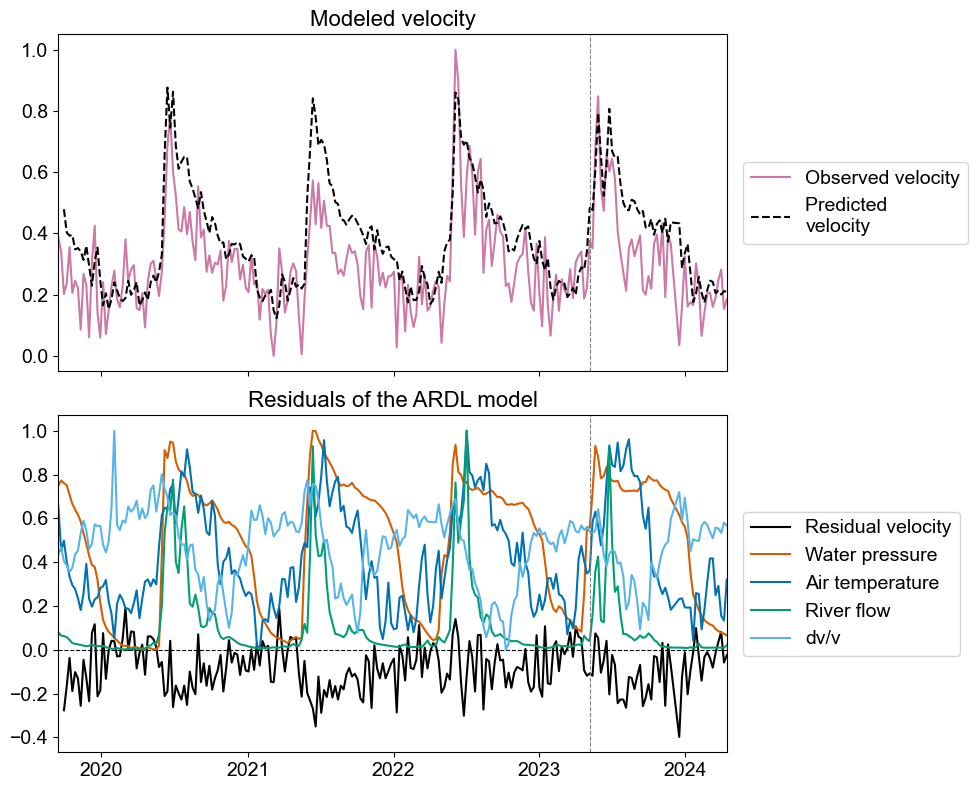

In [90]:
# Try to make a better figure
print('CHECK MAX LAG AND ADD BEFORE ESTIMATION!')

# initiate for the if in plotting
estimate = []
predictions = []

lg1 = 'Disp'
lg2 = 'WP'
lg3 = 'Temp'
lg4 = 'River'
lg5 = 'dv/v'
# lg6 = 'Temp'
# lg7 = 'Precip'
# lg8 = 'River'

max_lag_1 = get_max_lag(lg1)
max_lag_2 = get_max_lag(lg2)
max_lag_3 = get_max_lag(lg3)
max_lag_4 = get_max_lag(lg4)
max_lag_5 = get_max_lag(lg5)
# max_lag_6 = get_max_lag(lg6)
# max_lag_7 = get_max_lag(lg7)
# max_lag_8 = get_max_lag(lg8)

# # Non-linear part
# max_lag_6 = get_max_lag(stripped_names[5])
# max_lag_7 = get_max_lag(stripped_names[6])

# model_parameters = params.copy() # also non-significant, but need to fix max lag if using it..
model_parameters = significant_params.copy() # significant

# const = model_parameters.get('const', 0)  # Use 0 if no intercept is included
lags_1 = [model_parameters.get(f'{lg1}.L{i}', 0) for i in range(1, max_lag_1+1)] # 0 equals constant and if model set to trend 'n', there is none.
lags_2 = [model_parameters.get(f'{lg2}.L{i}', 0) for i in range(max_lag_2+1)]
lags_3 = [model_parameters.get(f'{lg3}.L{i}', 0) for i in range(max_lag_3+1)]
lags_4 = [model_parameters.get(f'{lg4}.L{i}', 0) for i in range(max_lag_4+1)]
lags_5 = [model_parameters.get(f'{lg5}.L{i}', 0) for i in range(max_lag_5+1)]


# # # Non-linear part
# lags_6 = [model_parameters.get(f'{stripped_names[5]}.L{i}', 0) for i in range(max_lag_6+1)]
# lags_7 = [model_parameters.get(f'{stripped_names[6]}.L{i}', 0) for i in range(max_lag_7+1)]

### choosing dataset, predicting or verifying ? ####
# # verifying
predicting_future = False
file = df_train.copy() # scaled dataset before separating to response and explanatory to verify prediction

# # Predicting?   # something is wrong when using the df_original
predicting_future = True
file = scaled_combined.copy() # predicting # The original data with the seasonal component. Since it is so off it might need the trend component as well? But that would not help as it is majorly off.
####################################################

# Initialize estimate array
num_days = len(file)
estimate = np.zeros(num_days)
shift_start = 2 # max(max_lag_1, max_lag_4) # make this code take the highest value from parameters
estimate[:shift_start] = np.nan  # NaN for the first round of lags

# Calculate fitted values (estimate) manually with AR part
for t in range(shift_start, num_days):  # Starting from correct lag to avoid undefined lags
    estimate[t] = (sum(lags_1[i-1] * file[lg1][t-i] for i in range(1, max_lag_1+1)) +
                   sum(lags_2[j] * file[lg2][t-j] for j in range(max_lag_2+1)) +
                   sum(lags_3[j] * file[lg3][t-j] for j in range(max_lag_3+1)) +
                   sum(lags_4[j] * file[lg4][t-j] for j in range(max_lag_4+1)) +
                   sum(lags_5[j] * file[lg5][t-j] for j in range(max_lag_5+1))) # +
                   # sum(lags_6[j] * explanatory[lg6][t-j] for j in range(max_lag_6+1)))


# # automatic predictions
# predictions = m1.predict()
# conf_int = pred_obj.conf_int() # is it confidence intervals for this model?

### plotting data
fig = plt.figure(figsize=(10, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # 2:1 ratio for ax1 and ax2

# if not inverse transform
estimate = pd.DataFrame(estimate, index=file.index)

# Plot the original data and estimated displacement on the first subplot
# # Transform back to original values
# estimate = pd.DataFrame(estimate, index=response.index) # to a df so possible to concat
# combined_original = pd.DataFrame(scaler.inverse_transform(pd.concat([estimate, explanatory], axis=1)), columns=df_features.columns, index=df_features.index)
# # Separate back into response and explanatory
# estimate = combined_original[[df_features.columns[0]]]
# # explanatory_original = combined_original[[df_features.columns[1]]]


ax1 = fig.add_subplot(gs[0])

# # original
# ax1.plot(file.index, file[file.columns[0]])      
# ax1.plot(file.index, file[file.columns[1]])

# scaled
ax1.plot(file.index, file[lg1], label='Observed velocity', color=colors[0])      
# ax1.plot(explanatory.index, explanatory[lg2], label= 'Water pressure', color=colors[1])
# ax1.plot(explanatory.index, explanatory[lg3], label= 'Air temperature', color=colors[2])
# ax1.plot(explanatory.index, explanatory[lg4], label= 'River flow', color=colors[4])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[3]], label= f'{explanatory.columns[3]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[4]], label= f'{explanatory.columns[4]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[5]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[6]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[7]])


ax1.plot(file.index, estimate, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])

# ax1.plot(response.index, predictions, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])
    
# if not pd.Series(predictions).empty:
#   ax1.plot(response.index, predictions, linestyle='dashed')  
#     # ax1.fill_between(file.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
    
ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5)) # [f'{response.columns[0]}', f'{explanatory.columns[0]}', f'{explanatory.columns[1]}', f'{explanatory.columns[2]}', f'{explanatory.columns[3]}', 'Predicted displacement'],

# ax1.legend(['Displacement', 'Water pressure', 'Estimated significant coeffs'], ncol=2, loc='upper center')
# ax1.set_ylim(0, 1.5)
ax1.set_title('Modeled velocity')


# Plot the residuals on the second subplot
ax2 = fig.add_subplot(gs[1])

ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

ax2.plot(file.index, (file[file.columns[0]] - estimate[estimate.columns[0]]), label='Residual velocity', color=colors[7])
ax2.plot(file.index, file[lg2], label= 'Water pressure', color=colors[1])
ax2.plot(file.index, file[lg3], label= 'Air temperature', color=colors[2])
ax2.plot(file.index, file[lg4], label= 'River flow', color=colors[4])
ax2.plot(file.index, file[lg5], label= 'dv/v', color=colors[5])

ax2.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax2.set_title('Residuals of the ARDL model')

# hihglighting predicting data
if predicting_future:
    ax1.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data
    ax2.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data

# cosmetics
# Set major ticks format to display only years
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_xticklabels([])

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# # zoom on a window
# ax1.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))
# ax2.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))

plt.tight_layout()

# # # saving
path = 'plots\\'
save_name = f'{path}Figure7_wAR.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'
fig.show()


# Compute RMSE on the predicted data
residuals = file.loc[df_test.index,'Disp'].values - estimate.loc[df_test.index][0].values
rmse = np.sqrt(np.mean(residuals**2))

print(f"The RMSE of the model is: {rmse}")
# I think perhaps that disp is so dominant as it is a a 'cumulative' time series.. Difference and then perhaps they are of same data type and better comparble? It is still shitt..

In [201]:
# Function to extract the maximum lag for a given variable
def get_max_lag(variable_prefix):
    lags = [int(var.split('.')[1][1:]) for var in significant_params.index if var.startswith(variable_prefix)] # this gives only significant parameters
    return max(lags) if lags else 0
    
# Only extract significant lag coefficients for Disp, WP, and Temp
stripped_names = list(set(name.split(".")[0] for name in significant_results.index)) # to get variabel names
print(stripped_names)

['WP', 'Temp', 'dv/v', 'River']


CHECK MAX LAG AND ADD BEFORE ESTIMATION!


C:\Users\andregas\AppData\Local\Temp\ipykernel_3040\2447579755.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  estimate[t] = (sum(lags_2[j] * file[lg2][t-j] for j in range(max_lag_2+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_3040\2447579755.py:60: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(lags_3[j] * file[lg3][t-j] for j in range(max_lag_3+1)) +
C:\Users\andregas\AppData\Local\Temp\ipykernel_3040\2447579755.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To

The RMSE of the model is: 0.11078683308409168


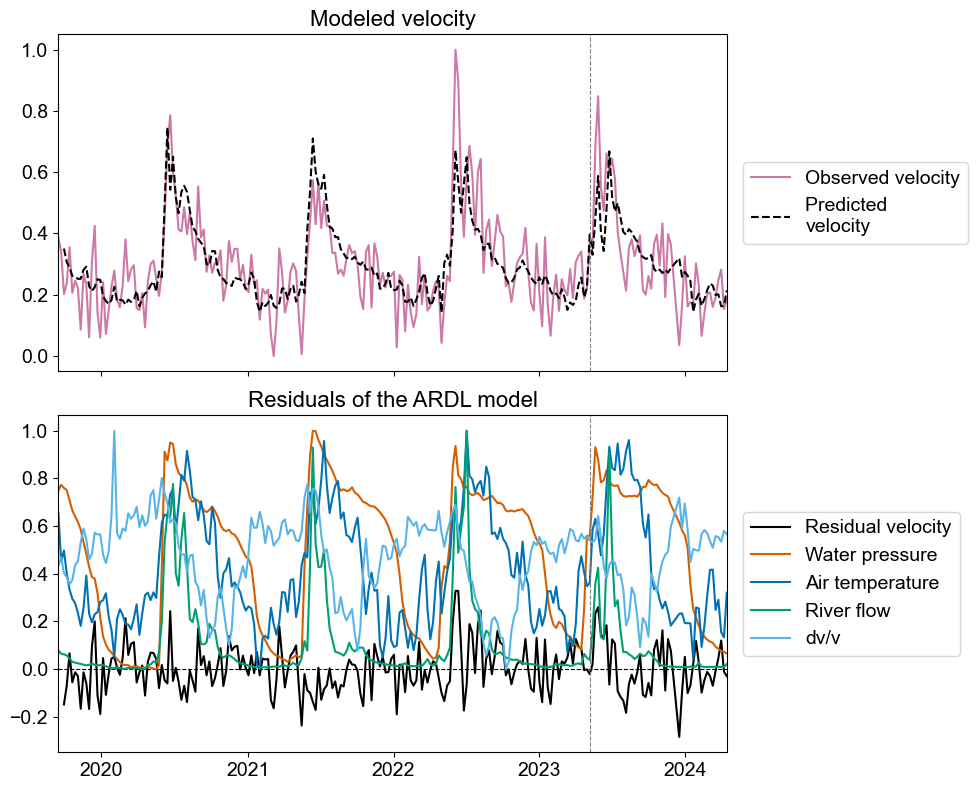

In [86]:
# Without AR
print('CHECK MAX LAG AND ADD BEFORE ESTIMATION!')

# initiate for the if in plotting
estimate = []
predictions = []

lg2 = 'WP'
lg3 = 'Temp'
lg4 = 'River'
lg5 = 'dv/v'
# lg6 = 'Temp'
# lg7 = 'Precip'
# lg8 = 'River'

max_lag_2 = get_max_lag(lg2)
max_lag_3 = get_max_lag(lg3)
max_lag_4 = get_max_lag(lg4)
max_lag_5 = get_max_lag(lg5)
# max_lag_6 = get_max_lag(lg6)
# max_lag_7 = get_max_lag(lg7)
# max_lag_8 = get_max_lag(lg8)

# # Non-linear part
# max_lag_6 = get_max_lag(stripped_names[5])
# max_lag_7 = get_max_lag(stripped_names[6])

# model_parameters = params.copy() # also non-significant, but need to fix max lag if using it..
model_parameters = significant_params.copy() # significant

lags_2 = [model_parameters.get(f'{lg2}.L{i}', 0) for i in range(max_lag_2+1)]
lags_3 = [model_parameters.get(f'{lg3}.L{i}', 0) for i in range(max_lag_3+1)]
lags_4 = [model_parameters.get(f'{lg4}.L{i}', 0) for i in range(max_lag_4+1)]
lags_5 = [model_parameters.get(f'{lg5}.L{i}', 0) for i in range(max_lag_5+1)]


# # # Non-linear part
# lags_6 = [model_parameters.get(f'{stripped_names[5]}.L{i}', 0) for i in range(max_lag_6+1)]
# lags_7 = [model_parameters.get(f'{stripped_names[6]}.L{i}', 0) for i in range(max_lag_7+1)]

### choosing dataset, predicting or verifying ? ####
# # verifying
predicting_future = False
file = df_train.copy() # scaled dataset before separating to response and explanatory to verify prediction

# # Predicting?   # something is wrong when using the df_original
predicting_future = True
file = scaled_combined.copy() # predicting # The original data with the seasonal component. Since it is so off it might need the trend component as well? But that would not help as it is majorly off.
####################################################

# Initialize estimate array
num_days = len(file)
estimate = np.zeros(num_days)
shift_start = 2 # max(max_lag_1, max_lag_4) # make this code take the highest value from parameters
estimate[:shift_start] = np.nan  # NaN for the first round of lags

# Calculate fitted values (estimate) manually without AR part
for t in range(shift_start, num_days):  # Starting from correct lag to avoid undefined lags
    estimate[t] = (sum(lags_2[j] * file[lg2][t-j] for j in range(max_lag_2+1)) +
                   sum(lags_3[j] * file[lg3][t-j] for j in range(max_lag_3+1)) +
                   sum(lags_4[j] * file[lg4][t-j] for j in range(max_lag_4+1)) +
                   sum(lags_5[j] * file[lg5][t-j] for j in range(max_lag_5+1))) 

# # automatic predictions
# predictions = m1.predict()
# conf_int = pred_obj.conf_int() # is it confidence intervals for this model?

### plotting data
fig = plt.figure(figsize=(10, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # 2:1 ratio for ax1 and ax2

# if not inverse transform
estimate = pd.DataFrame(estimate, index=file.index)

# Plot the original data and estimated displacement on the first subplot
# # Transform back to original values
# estimate = pd.DataFrame(estimate, index=response.index) # to a df so possible to concat
# combined_original = pd.DataFrame(scaler.inverse_transform(pd.concat([estimate, explanatory], axis=1)), columns=df_features.columns, index=df_features.index)
# # Separate back into response and explanatory
# estimate = combined_original[[df_features.columns[0]]]
# # explanatory_original = combined_original[[df_features.columns[1]]]


ax1 = fig.add_subplot(gs[0])

# # original
# ax1.plot(file.index, file[file.columns[0]])      
# ax1.plot(file.index, file[file.columns[1]])

# scaled
ax1.plot(file.index, file[lg1], label='Observed velocity', color=colors[0])      
# ax1.plot(explanatory.index, explanatory[lg2], label= 'Water pressure', color=colors[1])
# ax1.plot(explanatory.index, explanatory[lg3], label= 'Air temperature', color=colors[2])
# ax1.plot(explanatory.index, explanatory[lg4], label= 'River flow', color=colors[4])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[3]], label= f'{explanatory.columns[3]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[4]], label= f'{explanatory.columns[4]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[5]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[6]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[7]])


ax1.plot(file.index, estimate, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])

# ax1.plot(response.index, predictions, linestyle='dashed', label='Predicted \nvelocity', color=colors[7])
    
# if not pd.Series(predictions).empty:
#   ax1.plot(response.index, predictions, linestyle='dashed')  
#     # ax1.fill_between(file.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
    
ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5)) # [f'{response.columns[0]}', f'{explanatory.columns[0]}', f'{explanatory.columns[1]}', f'{explanatory.columns[2]}', f'{explanatory.columns[3]}', 'Predicted displacement'],

# ax1.legend(['Displacement', 'Water pressure', 'Estimated significant coeffs'], ncol=2, loc='upper center')
# ax1.set_ylim(0, 1.5)
ax1.set_title('Modeled velocity')


# Plot the residuals on the second subplot
ax2 = fig.add_subplot(gs[1])

ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)

ax2.plot(file.index, (file[file.columns[0]] - estimate[estimate.columns[0]]), label='Residual velocity', color=colors[7])
ax2.plot(file.index, file[lg2], label= 'Water pressure', color=colors[1])
ax2.plot(file.index, file[lg3], label= 'Air temperature', color=colors[2])
ax2.plot(file.index, file[lg4], label= 'River flow', color=colors[4])
ax2.plot(file.index, file[lg5], label= 'dv/v', color=colors[5])


ax2.legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
ax2.set_title('Residuals of the ARDL model')

# hihglighting predicting data
if predicting_future:
    ax1.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data
    ax2.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='gray', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data

# cosmetics
# Set major ticks format to display only years
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set_xticklabels([])

ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# # zoom on a window
# ax1.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))
# ax2.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))

plt.tight_layout()

# # # saving
path = 'plots\\'
save_name = f'{path}Figure7_woutAR.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'
fig.show()

# Compute RMSE on the predicted data
residuals = file.loc[df_test.index,'Disp'].values - estimate.loc[df_test.index][0].values
rmse = np.sqrt(np.mean(residuals**2))

print(f"The RMSE of the model is: {rmse}")
# I think perhaps that disp is so dominant as it is a a 'cumulative' time series.. Difference and then perhaps they are of same data type and better comparble? It is still shitt..

The RMSE of the model is: 0.11078683308409168


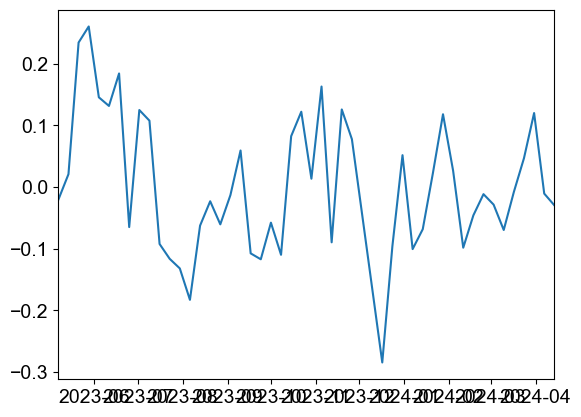

In [84]:
# Compute RMSE on the predicted data
residuals = file.loc[df_test.index,'Disp'].values- estimate.loc[df_test.index][0].values
rmse = np.sqrt(np.mean(residuals**2))

print(f"The RMSE of the model is: {rmse}")
plt.plot(df_test.index,residuals)


In [70]:
# Function to extract the maximum lag for a given variable
def get_max_lag(variable_prefix):
    lags = [int(var.split('.')[1][1:]) for var in significant_params.index if var.startswith(variable_prefix)] # this gives only significant parameters
    return max(lags) if lags else 0

# Only extract significant lag coefficients for Disp, WP, and Temp
stripped_names = list(set(name.split(".")[0] for name in significant_results.index)) # to get variabel names
print(stripped_names)

['Temp', 'River', 'WP']


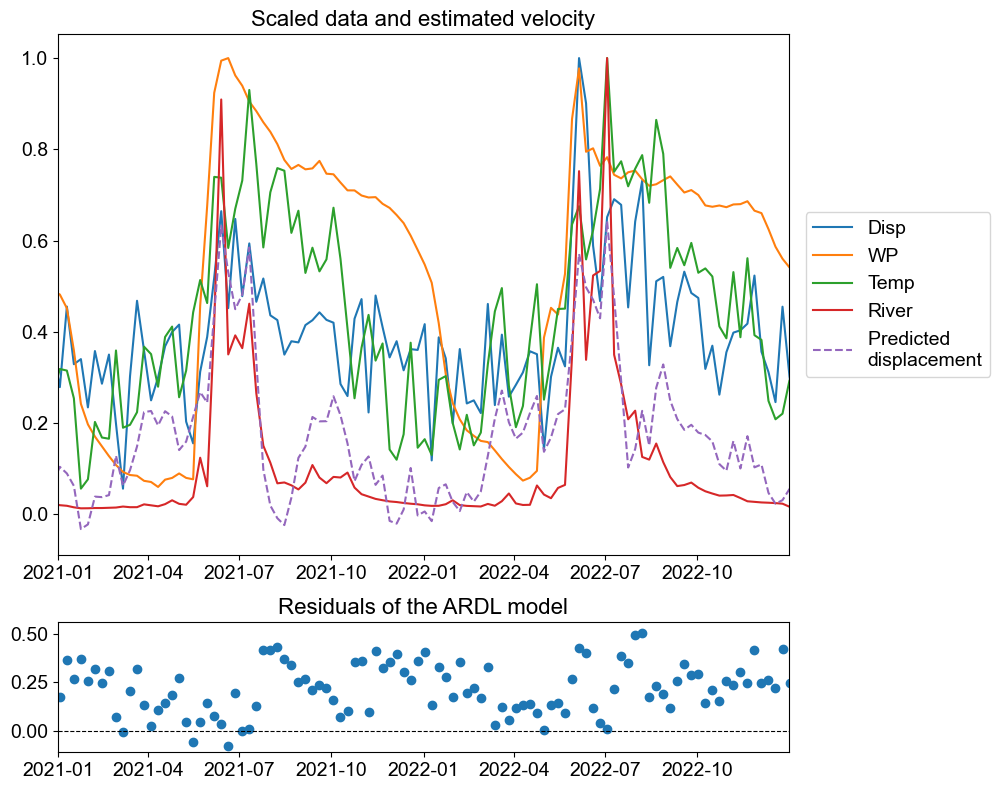

In [80]:
# need to use df_test part to look at the future. But first make this work.. And also make automatic update of parameters based on ARDL lags coefficients that are significant. also add disp lag.
# Model recalibration on smaller dataset. Residuals need to be white noise.

# initiate for the if in plotting
estimate = []
predictions = []

lg1 = stripped_names[0] # 
lg2 = stripped_names[1] # 
lg3 = stripped_names[2] # 

# Only extract significant lag coefficients for Disp, WP, and Temp
max_lag_1 = get_max_lag(lg1)
max_lag_2 = get_max_lag(lg2)
max_lag_3 = get_max_lag(lg3)
# max_lag_4 = get_max_lag(stripped_names[3])
# max_lag_5 = get_max_lag(stripped_names[4])

# # Non-linear part
# max_lag_6 = get_max_lag(stripped_names[5])
# max_lag_7 = get_max_lag(stripped_names[6])

# model_parameters = params.copy() # also non-significant, but need to fix max lag if using it..
model_parameters = significant_params.copy() # significant

# const = model_parameters.get('const', 0)  # Use 0 if no intercept is included
lags_1 = [model_parameters.get(f'{lg1}.L{i}', 0) for i in range(max_lag_1+1)] # 0 equals constant and if model set to trend 'n', there is none.
lags_2 = [model_parameters.get(f'{lg2}.L{i}', 0) for i in range(max_lag_2+1)]
lags_3 = [model_parameters.get(f'{lg3}.L{i}', 0) for i in range(max_lag_3+1)]
# lags_4 = [model_parameters.get(f'{stripped_names[3]}.L{i}', 0) for i in range(max_lag_4+1)]
# lags_5 = [model_parameters.get(f'{stripped_names[4]}.L{i}', 0) for i in range(max_lag_5+1)]

# # # Non-linear part
# lags_6 = [model_parameters.get(f'{stripped_names[5]}.L{i}', 0) for i in range(max_lag_6+1)]
# lags_7 = [model_parameters.get(f'{stripped_names[6]}.L{i}', 0) for i in range(max_lag_7+1)]

### choosing dataset, predicting or verifying ? ####
# # verifying
predicting_future = False
file = scaled_combined.copy()

# Initialize estimate array
num_days = len(file)
estimate = np.zeros(num_days)
shift_start = max(0, max_lag_2) # make this code take the highest value from parameters
estimate[:shift_start] = np.nan  # NaN for the first round of lags

# Calculate fitted values (estimate) manually without AR part
for t in range(shift_start, num_days):  # Starting from correct lag to avoid undefined lags
    estimate[t] = (sum(lags_1[j] * explanatory[lg1][t-j] for j in range(max_lag_1+1)) +
                   sum(lags_2[j] * explanatory[lg2][t-j] for j in range(max_lag_2+1)) +
                   sum(lags_3[j] * explanatory[lg3][t-j] for j in range(max_lag_3+1))) # +
                   # sum(lags_4[j] * explanatory[explanatory.columns[2]][t-j] for j in range(max_lag_4+1))) # +

### plotting data
fig = plt.figure(figsize=(10, 8))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])  # 2:1 ratio for ax1 and ax2

# if not inverse transform
estimate = pd.DataFrame(estimate, index=response.index)

# Plot the original data and estimated displacement on the first subplot
# # Transform back to original values
# estimate = pd.DataFrame(estimate, index=response.index) # to a df so possible to concat
# combined_original = pd.DataFrame(scaler.inverse_transform(pd.concat([estimate, explanatory], axis=1)), columns=df_features.columns, index=df_features.index)
# # Separate back into response and explanatory
# estimate = combined_original[[df_features.columns[0]]]
# # explanatory_original = combined_original[[df_features.columns[1]]]


ax1 = fig.add_subplot(gs[0])

# # original
# ax1.plot(file.index, file[file.columns[0]])      
# ax1.plot(file.index, file[file.columns[1]])

# scaled
ax1.plot(response.index, response[response.columns[0]], label=f'{response.columns[0]}')      
ax1.plot(explanatory.index, explanatory[explanatory.columns[0]], label= f'{explanatory.columns[0]}') # wp
ax1.plot(explanatory.index, explanatory[explanatory.columns[1]], label= f'{explanatory.columns[1]}') # temp
# ax1.plot(explanatory.index, explanatory[explanatory.columns[2]], label= f'{explanatory.columns[2]}') # precip
ax1.plot(explanatory.index, explanatory[explanatory.columns[3]], label= f'{explanatory.columns[3]}') # river
# ax1.plot(explanatory.index, explanatory[explanatory.columns[4]], label= f'{explanatory.columns[4]}')
# ax1.plot(explanatory.index, explanatory[explanatory.columns[5]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[6]])
# ax1.plot(explanatory.index, explanatory[explanatory.columns[7]])


ax1.plot(response.index, estimate, linestyle='dashed', label='Predicted \ndisplacement')
    
# if not pd.Series(predictions).empty:
#     ax1.plot(response.index, predictions, linestyle='dashed')
#     # ax1.fill_between(file.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='Confidence Interval')
    
ax1.legend(loc='center left', bbox_to_anchor=(1.01, 0.5)) # [f'{response.columns[0]}', f'{explanatory.columns[0]}', f'{explanatory.columns[1]}', f'{explanatory.columns[2]}', f'{explanatory.columns[3]}', 'Predicted displacement'],

# ax1.legend(['Displacement', 'Water pressure', 'Estimated significant coeffs'], ncol=2, loc='upper center')
# ax1.set_ylim(0, 1.5)
ax1.set_title('Scaled data and estimated velocity')


# Plot the residuals on the second subplot
ax2 = fig.add_subplot(gs[1])
if not estimate.empty:
    ax2.scatter(file.index, (file[file.columns[0]] - estimate[estimate.columns[0]]), label='Residuals')
# if not pd.Series(predictions).empty:
#     ax2.scatter(response.index, (response[response.columns[0]].values - predictions), label='Residuals')

ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
# ax2.legend(['Residuals'])
ax2.set_title('Residuals of the ARDL model')

# hihglighting predicting data
if predicting_future:
    ax1.axvline(x=file.iloc[file.index.get_indexer([cutoff_index], method='nearest')[0]].name, color='k', linestyle='--', linewidth=0.8)  # Vertical line indicating end of training data

# zoom on a window
ax1.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))
ax2.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2022-12-31'))

# Display the figure
plt.tight_layout()
plt.show()

In [76]:
significant_params

WP.L8      -0.404395
WP.L13      0.276113
Temp.L0     0.434703
River.L0    0.250387
River.L1    0.217641
dtype: float64

## Wiener filter

In [4]:
# # # Wiener filter # # #
# use MMSE, filter weights mean squared errors and minimizes them
# assumptions: the two inputs are correlated and data needs to be stationary and zero mean
# x[n] and d[n] correlated with target s[n]


# Good explanation of filters! 
# https://tmramalho.github.io/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/
# https://tmramalho.github.io/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/
# https://www.youtube.com/watch?v=9Zv63MAwvHU # the wiener filter explaiend

from scipy import optimize, fftpack

def wiener_filter_2(t, h, signal='gaussian', noise='flat', return_PSDs=False,
                  signal_params=None, noise_params=None):
    """Compute a Wiener-filtered time-series
    
    https://www.astroml.org/_modules/astroML/filters.html#wiener_filter

    Parameters
    ----------
    t : array_like
        evenly-sampled time series, length N
    h : array_like
        observations at each t
    signal : str (optional)
        currently only 'gaussian' is supported
    noise : str (optional)
        currently only 'flat' is supported
    return_PSDs : bool (optional)
        if True, then return (PSD, P_S, P_N)
    signal_guess : tuple (optional)
        A starting guess at the parameters for the signal.  If not specified,
        a suitable guess will be estimated from the data itself. (see Notes
        below)
    noise_guess : tuple (optional)
        A starting guess at the parameters for the noise.  If not specified,
        a suitable guess will be estimated from the data itself. (see Notes
        below)

    Returns
    -------
    h_smooth : ndarray
        a smoothed version of h, length N

    Notes
    -----
    The Wiener filter operates by fitting a functional form to the PSD::

       PSD = P_S + P_N

    The resulting frequency-space filter is given by::

       Phi = P_S / (P_S + P_N)

    This entire operation is equivalent to a kernel smoothing by a
    kernel whose Fourier transform is Phi.

    Choosing Signal/Noise Parameters
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    the arguments ``signal_guess`` and ``noise_guess`` specify the initial
    guess for the characteristics of signal and noise used in the minimization.
    They are generally expected to be tuples, and the meaning varies depending
    on the form of signal and noise used.  For ``gaussian``, the params are
    (amplitude, width).  For ``flat``, the params are (amplitude,).

    See Also
    --------
    scipy.signal.wiener : a static (non-adaptive) wiener filter
    """
    # Validate signal
    if signal != 'gaussian':
        raise ValueError("only signal='gaussian' is supported")
    if signal_params is not None and len(signal_params) != 2:
        raise ValueError("signal_params should be length 2")

    # Validate noise
    if noise != 'flat':
        raise ValueError("only noise='flat' is supported")
    if noise_params is not None and len(noise_params) != 1:
        raise ValueError("noise_params should be length 1")

    # Validate t and hd
    t = np.asarray(t)
    h = np.asarray(h)

    if (t.ndim != 1) or (t.shape != h.shape):
        raise ValueError('t and h must be equal-length 1-dimensional arrays')

    # compute the PSD of the input
    N = len(t)
    Df = 1. / N / (t[1] - t[0])
    f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))

    H = fftpack.fft(h)
    PSD = abs(H) ** 2

    # fit signal/noise params if necessary
    if signal_params is None:
        amp_guess = np.max(PSD[1:])
        width_guess = np.min(np.abs(f[PSD < np.mean(PSD[1:])]))
        signal_params = (amp_guess, width_guess)
    if noise_params is None:
        noise_params = (np.mean(PSD[1:]),)

    # Set up the Wiener filter:
    #  fit a model to the PSD: sum of signal form and noise form

    def signal(x, A, width):
        width = abs(width) + 1E-99  # prevent divide-by-zero errors
        return A * np.exp(-0.5 * (x / width) ** 2)

    def noise(x, n):
        return n * np.ones(x.shape)

    # use [1:] here to remove the zero-frequency term: we don't want to
    # fit to this for data with an offset.
    def min_func(v): return np.sum((PSD[1:] - signal(f[1:], v[0], v[1]) - noise(f[1:], v[2])) ** 2)
    v0 = tuple(signal_params) + tuple(noise_params)
    v = optimize.minimize(min_func, v0, method='Nelder-Mead')['x']

    P_S = signal(f, v[0], v[1])
    P_N = noise(f, v[2])
    Phi = P_S / (P_S + P_N)
    Phi[0] = 1  # correct for DC offset

    # Use Phi to filter and smooth the values
    h_smooth = fftpack.ifft(Phi * H)

    if not np.iscomplexobj(h):
        h_smooth = h_smooth.real

    if return_PSDs:
        return h_smooth, PSD, P_S, P_N, Phi
    else:
        return h_smooth
    
# https://github.com/fhchl/adafilt/blob/master/adafilt/optimal.py

from scipy.signal import csd, welch 

def wiener_filter(x, d, n, g=None, constrained=False):
    """Compute optimal wiener filter for single-channel control.

    From Elliot, Signal Processing for Optimal Control, Eq. 3.3.26

    Parameters
    ----------
    x : array_like
        Reference signal.
    d : array_like
        Disturbance signal.
    n : int
        Output filter length.
    g : None or array_like, optional
        Secondary path impulse response.
    constrained : bool, optional
        If True, constrain filter to be causal.

    Returns
    -------
    numpy.ndarray, shape (n,)
        Optimal wiener filter in freqency domain.

    """
    if g is None:
        g = [1]

    G = np.fft.fft(g, n=n)

    # NOTE: one could time align the responses here first
    _, Sxd = csd(x, d, nperseg=n, return_onesided=False)
    _, Sxx = welch(x, nperseg=n, return_onesided=False)

    if not constrained:
        return - Sxd / Sxx / G

    c = np.ones(n)
    c[n // 2:] = 0
    # half at DC and Nyquist
    c[0] = 0.5
    if n % 2 == 0:
        c[n // 2] = 0.5

    # minimum phase and allpass components of G
    # NOTE: could also use https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.minimum_phase.html
    Gmin = np.exp(np.fft.fft(c * np.fft.ifft(2 * np.log(np.abs(G)), n=n), n=n))
    Gall = G / Gmin

    # spectral factor
    # NOTE: could also use https://github.com/RJTK/spectral_factorization/blob/master/spectral_factorization.py
    F = np.exp(np.fft.fft(c * np.fft.ifft(np.log(Sxx), n=n), n=n))

    h = np.ones(n)
    h[n // 2:] = 0
    return - np.fft.fft(h * np.fft.ifft(Sxd / F.conj() / Gall), n=n) / (F * Gmin)


def multi_channel_wiener_filter(x, d, n, g=None, beta=0):
    """Compute optimal wiener filter for multi-channel control.

    From Elliot, Signal Processing for Optimal Control, Eq. 5.3.31

    Parameters
    ----------
    x : array_like, shape (N1[, K])
        K reference signals.
    d : array_like, shape (N2[, L])
        L disturbance signals.
    n : int
        Output filter length.
    g : None or array_like, shape (N3[, L[, M]]), optional
        Secondary path impulse response.
    beta: float
        Variance of added white noise to reference signals for regularization.

    Returns
    -------
    numpy.ndarray, shape (n,[, M])
        Optimal wiener filter in freqency domain.

    """
    if g is None:
        g = [1]

    x = atleast_2d(x)
    d = atleast_2d(d)
    g = atleast_3d(g)

    Nin = x.shape[1]
    _, Nmic, Nout = g.shape

    G = np.fft.fft(g, n=n, axis=0)

    # TODO: align in time during correlation
    Sxx = np.zeros((n, Nin, Nin), dtype=complex)
    for i in range(Nin):
        for j in range(Nin):
            _, S = csd(x[:, i], x[:, j], nperseg=n, return_onesided=False)
            Sxx[:, i, j] = S

    Sxd = np.zeros((n, Nmic, Nin), dtype=complex)
    for i in range(Nmic):
        for j in range(Nin):
            _, S = csd(x[:, j], d[:, i], nperseg=n, return_onesided=False)
            Sxd[:, i, j] = S

    return - np.linalg.pinv(G) @ Sxd @ np.linalg.pinv(Sxx + beta * np.identity(Nin))

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


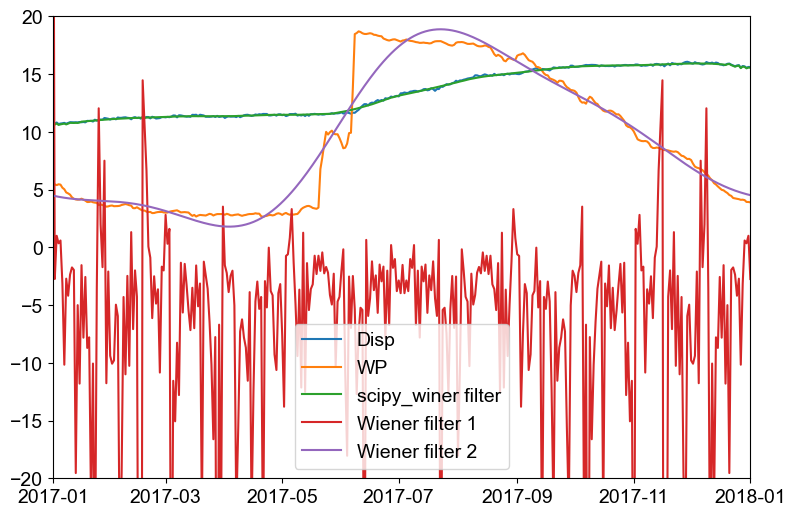

In [270]:
# Testing filters and plotting
#### create slice of df  #####
start_time = pd.Timestamp('2017-01-01')
end_time = pd.Timestamp('2018-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

df = pd.DataFrame({'Disp':x, 'WP':y})
df.dropna(inplace=True)


x = df.loc[:,'Disp'] # dates.date2num(df.index)
d = df.loc[:,'WP']

filtered_1 = wiener_filter(x=x, d=d, n=len(df.index), g=None, constrained=True) # I do not understand this filter

# filtering and plotting
t = x # dates.date2num(df.index) # Seems like this should be 'timesteps'
h = d

filtered_2, PSD, P_S, P_N, Phi= wiener_filter_2(t, h, signal='gaussian', noise='flat', return_PSDs=True, signal_params=None, noise_params=None)

from scipy.signal import wiener

scipy_winer = wiener(x, mysize=30, noise=0.5) # mysize = size of wiener filter window

fig, ax =plt.subplots(figsize=(9, 6))
ax.plot(df.index, x, label=x.name)
ax.plot(df.index, d, label=d.name)
ax.plot(df.index, scipy_winer, label='scipy_winer filter')
ax.plot(df.index, filtered_1, label='Wiener filter 1') # this one needs two inputs which is not the timesteps I think, as it went crazy
ax.plot(df.index, filtered_2, label='Wiener filter 2') # looks similar to scipy version
ax.set_ylim(-20,20)
ax.legend()

In [323]:
df_train.head()

Disp        WP   Temp  Rock_temp
2015-01-01  1.833209  4.160872  -2.35  -2.388690
2015-01-02  1.841365  3.910930  -0.75  -2.504340
2015-01-03  1.878110  3.827627  -4.05  -2.831905
2015-01-04  1.931627  3.892274  -5.45  -3.316370
2015-01-05  1.934592  3.921822 -10.45  -3.734040

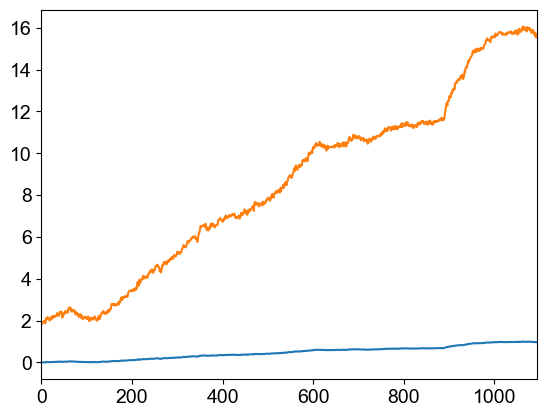

In [329]:
test = df_train.iloc[:,0].values.reshape(-1, 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
series = scaler.fit_transform(test) # transform to normalized values
plt.plot(series)
series2 = scaler.inverse_transform(series) # transform back to original
plt.plot(series2)
# this seems to work

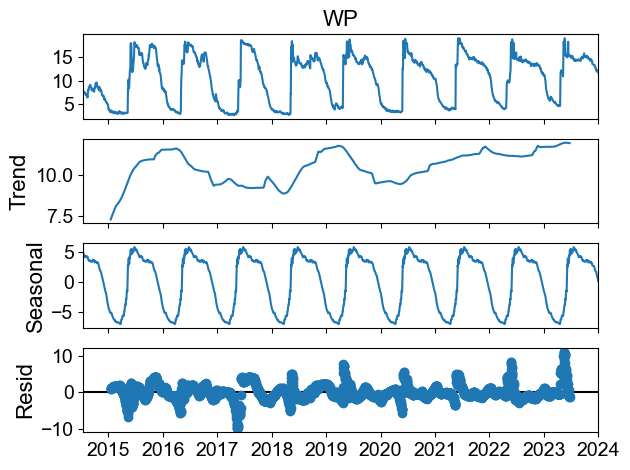

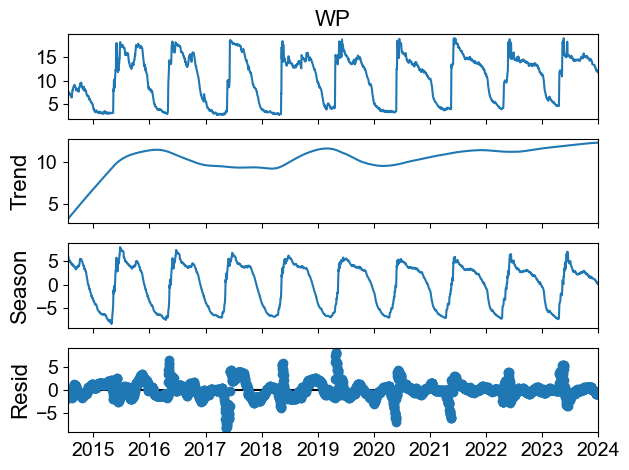

In [19]:
#### create slice of df  #####
start_time = pd.Timestamp('2014-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
z = z[z.index.slice_indexer(start_time,end_time)]
z = z.resample('1d').median()

f = ST.iloc[:,0] # hourly data intervals
f = f[f.index.slice_indexer(start_time,end_time)]
f = f.resample('1d').median()

df = pd.DataFrame({'Disp':x, 'WP':y})
# df = pd.DataFrame({'Disp':x, 'WP':y, 'Temp': z, 'Rock_temp':f})
df.dropna(inplace=True)

# transform before seasonal decomposition to achive stationarity
df_train = df.copy()
data = df_train.iloc[:,1].copy()
freq=365
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed_series = seasonal_decompose(data, model='additive', period=freq,)
decomposed_series.plot()
plt.show()

# apparently the STL is far better and I should use it instead. With these parameters it seems similar to seasonal_decompose/traditional method
from statsmodels.tsa.seasonal import STL
res = STL(data, seasonal=13, period=365).fit()
res.plot()
plt.show()

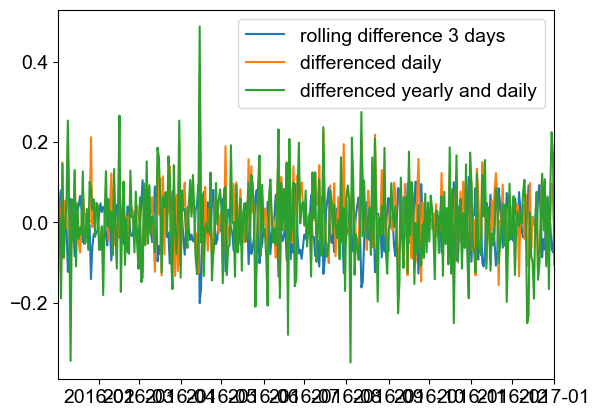

In [58]:
# plt.plot(df_list[0].loc[:,'original'])
plt.plot(df_list[0].loc[:,'rolling_diff'])
plt.plot(df_list[0].loc[:,'diff'])
plt.plot(df_list[0].loc[:,'diff_trend_season'])
plt.legend(['rolling difference 3 days','differenced daily', 'differenced yearly and daily'])

In [60]:
print((df_list[0].loc[:,'rolling_diff']).std())
print((df_list[0].loc[:,'diff']).std())
print((df_list[0].loc[:,'diff_trend_season']).std())

0.0775467837711693
0.07831122676733536
0.1061982313611828


In [13]:
#### create slice of df  #####
start_time = pd.Timestamp('2015-01-01')
end_time = pd.Timestamp('2018-01-01')

x = JTT2DispUpperZone.iloc[:,0] # 0 = disp, -3 = 12 days, -1 = 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
x = x.resample('1d').median()

y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
y = y.resample('1d').median()

z = jtt_xgeo_temp.iloc[:,0] # daily data intervals
z = z[z.index.slice_indexer(start_time,end_time)]
z = z.resample('1d').median()

f = ST.iloc[:,0] # hourly data intervals
f = f[f.index.slice_indexer(start_time,end_time)]
f = f.resample('1d').median()

df = pd.DataFrame({'Disp':x, 'WP':y, 'Temp': z, 'Rock_temp':f})
df.dropna(inplace=True)

# # Split into train and test
# cutoff_index = int(df.shape[0] * 0.8) # train with xx % data
# df_train = df.iloc[:cutoff_index]
# df_test = df.iloc[cutoff_index:]

df_train = df.copy()
# now scale and transform data so variables are of similar weight
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed

# differencing n rows to get seasonal and trend removed to obtain statinarity
def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series.reshape(-1) # transform back to correct shape

# Apply decompose (decompose trend, seasonality, and resudials) to make data stationary
from statsmodels.tsa.seasonal import STL

df_list = []
for i,d in enumerate(df_train.columns):
    df = []
    freq = 365

    decomposed_series = STL(df_train.loc[:,d], seasonal=13, period=365).fit()
    trend = decomposed_series.trend
    seasonal = decomposed_series.seasonal
    residual = decomposed_series.resid
    original = df_train.loc[:,d].copy()
    removed_trend = original-trend
    norm_removed_trend = norm(removed_trend) # the normalization does not work for some reason..
    diff_trend = diff_shift(original, 1) # first order differencing # previosly named diff_trend
    diff_seasonal = diff_shift(original, 365) # this is not stationary
    diff_trend_season = diff_shift(diff_seasonal, 1) # correct way according to detrend and deseasonlize: https://online.stat.psu.edu/stat510/lesson/4/4.1
    rolling_diff = original.rolling(3).mean()-original # more than 7 days gives higher std values than diff_trend
    norm_diff = norm(diff_trend) # the normalization does not work for some reason.. # need to normalize to make the relationships 'scaled correctly'
    df = pd.DataFrame({'original':original.values, 'trend': trend.values, 'seasonal':seasonal.values, 'residual':residual.values, 'orig-trend':removed_trend.values,
                       'diff_trend_season':diff_trend_season.values, 'diff':diff_trend.values, 'norm_diff': norm_diff, 'rolling_diff':rolling_diff.values}, index=df_train.index)
    df.dropna(inplace=True)
    
#     #### Comment this part out when finished looking at what series is stationary  ####
#     # correlating?
#     print(f'{d}')
#     # print(df.corr()) # correlations

#     #### testing stationarity ####
#     from statsmodels.tsa.stattools import adfuller
#     for i, variable in enumerate(df.columns):
#         # Perform the ADF test
#         result = adfuller(df[variable])

#         # Extract and print the p-value from the test result
#         p_value = result[1]
#         print("p-value:", p_value)

#         # Interpret the result
#         if p_value <= 0.05: # 0.05 or 0.001
#             print(f"The variable {variable} is stationary.\n")
#         else:
#             print(f"The variable {variable} is not stationary.\n")
# ###############################

    # choosing just one year
    df = df[df.index.slice_indexer(pd.Timestamp('2016-01-01'),pd.Timestamp('2017-01-01'))]

    df_list.append(df)
    
col = 'diff' # only use the ones that passes ADF test
df = pd.DataFrame({'Disp':df_list[0].loc[:,col], 'WP':df_list[1].loc[:,col], 'Temp':df_list[2].loc[:,col],'Rock_temp':df_list[3].loc[:,col]}) # only disp original is not stationary so chosen orig-trend, others original
df = pd.DataFrame(scaler.fit_transform(df),columns=['Disp', 'WP', 'Temp','Rock_temp'], index=df.index) # scale transform 0-1
df.dropna(inplace=True)


# TRY SOME OTHER FILTERS OR THE MULTICHANNEL FILTER!?!

# var1 = 'Disp'
# var2 = 'WP'
# df.loc[:,f'{var1}_{var2}_wiener'] =  wiener_filter_2(df.loc[:,var1], df.loc[:,var2], signal='gaussian', noise='flat', return_PSDs=False, signal_params=None, noise_params=None)

# var2 = 'Temp'
# df.loc[:,f'{var1}_{var2}_wiener'] =  wiener_filter_2(df.loc[:,var1], df.loc[:,var2], signal='gaussian', noise='flat', return_PSDs=False, signal_params=None, noise_params=None)

# var2 = 'Rock_temp'
# df.loc[:,f'{var1}_{var2}_wiener'] =  wiener_filter_2(df.loc[:,var1], df.loc[:,var2], signal='gaussian', noise='flat', return_PSDs=False, signal_params=None, noise_params=None)

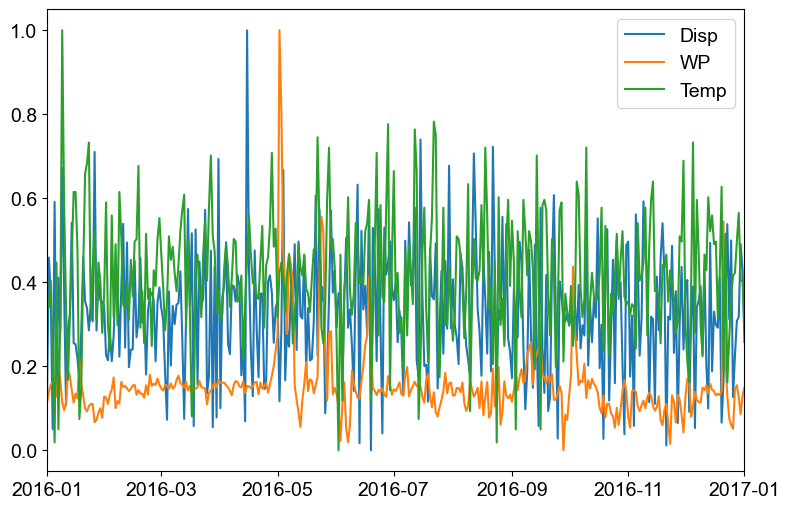

In [69]:
fig, ax =plt.subplots(figsize=(9, 6))
pltdf = df
ax.plot(pltdf.index, pltdf.iloc[:,0], label=pltdf.iloc[:,0].name)
ax.plot(pltdf.index, pltdf.iloc[:,1], label=pltdf.iloc[:,1].name)
ax.plot(pltdf.index, pltdf.iloc[:,2], label=pltdf.iloc[:,2].name)
# ax.plot(pltdf.index, pltdf.iloc[:,3], label=pltdf.iloc[:,3].name)
# ax.plot(pltdf.index, pltdf.iloc[:,4], label=pltdf.iloc[:,4].name)
# ax.plot(pltdf.index, pltdf.iloc[:,5], label=pltdf.iloc[:,5].name)
ax.legend()

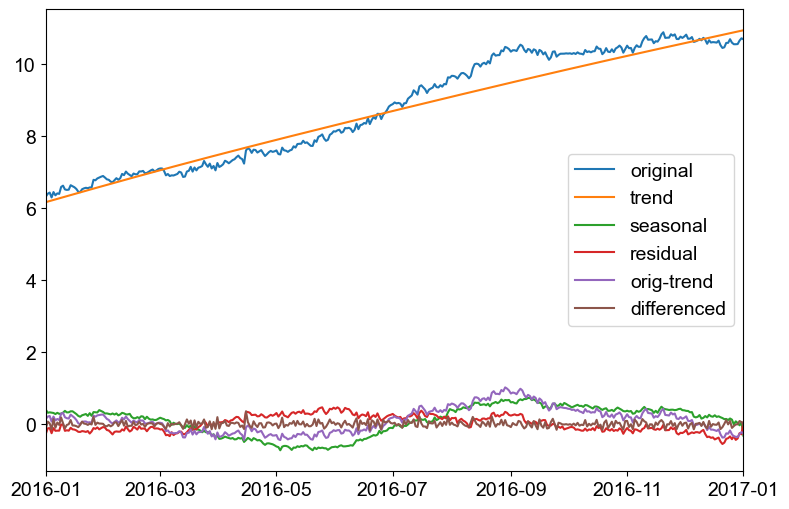

In [75]:
# Looking at data
fig, ax =plt.subplots(figsize=(9, 6))
pltdf = df_list[0]
ax.plot(pltdf.index, pltdf.iloc[:,0], label=pltdf.iloc[:,0].name)
ax.plot(pltdf.index, pltdf.iloc[:,1], label=pltdf.iloc[:,1].name)
ax.plot(pltdf.index, pltdf.iloc[:,2], label=pltdf.iloc[:,2].name)
ax.plot(pltdf.index, pltdf.iloc[:,3], label=pltdf.iloc[:,3].name)
ax.plot(pltdf.index, pltdf.iloc[:,4], label=pltdf.iloc[:,4].name)
ax.plot(pltdf.index, pltdf.iloc[:,5], label=pltdf.iloc[:,5].name)
ax.legend()
# ax.set_ylim(-0.2,0.2)

In [64]:
df.head()

Disp        WP      Temp  Rock_temp  Disp_WP_wiener  Disp_Temp_wiener  Disp_Rock_temp_wiener
2015-01-02  0.385263  0.331251  0.518519   0.486711        0.379843          0.789859               0.509746
2015-01-03  0.434542  0.354188  0.216049   0.431827        0.379927          0.787693               0.509775
2015-01-04  0.463452  0.374553  0.333333   0.391191        0.380011          0.784012               0.509805
2015-01-05  0.376316  0.369721  0.111111   0.408491        0.380094          0.778640               0.509835
2015-01-06  0.366126  0.350911  0.327160   0.552086        0.380177          0.771406               0.509865

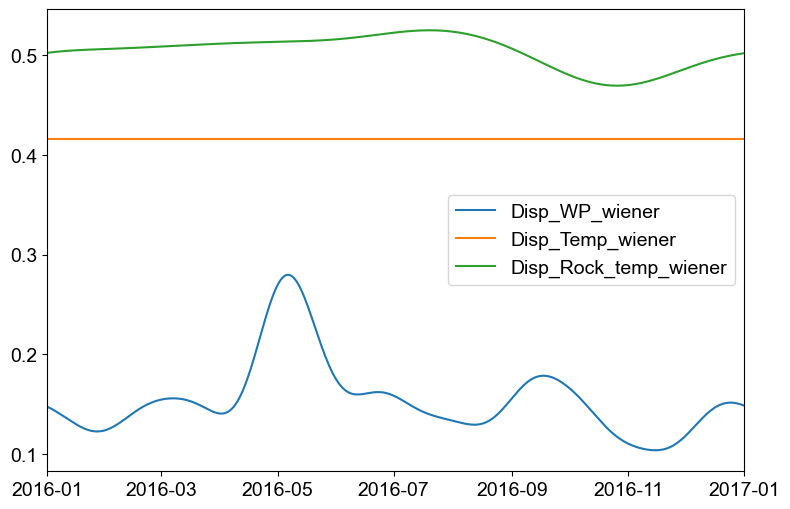

In [76]:
# differencing gives WP unique signal. Norm diff gives temp unique signal.

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series



fig, ax =plt.subplots(figsize=(9, 6))
ax.plot(df.index, df.iloc[:,-3], label=df.iloc[:,-3].name)
ax.plot(df.index, df.iloc[:,-2], label=df.iloc[:,-2].name)
ax.plot(df.index, df.iloc[:,-1], label=df.iloc[:,-1].name)

# ax.plot(df.index, filtered_2, label='Wiener filter 2') # looks similar to scipy version
# ax.set_ylim(-2,2)
ax.legend()

In [313]:
df.head()

Disp        WP  Temp  Rock_temp  Disp_WP_wiener  Disp_Temp_wiener  Disp_Rock_temp_wiener
2015-07-02  0.034280 -0.045617   1.6    0.03274        0.000411          0.012568               0.000894
2015-07-03 -0.031330 -0.115989   2.3    0.03750        0.000411          0.012568               0.000894
2015-07-04  0.033015  0.038192  -2.6    0.00320        0.000411          0.012568               0.000894
2015-07-05  0.027561 -0.035071  -2.3    0.00957        0.000411          0.012568               0.000894
2015-07-06 -0.040701 -0.121905   0.3    0.01515        0.000411          0.012568               0.000894

In [319]:
### Granger Causality test ###
# https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/?utm_content=cmp-true

# looks at lags and provide significance below 0.1 or 0.05 if variable in second column is caused by first column.

from statsmodels.tsa.stattools import grangercausalitytests
def grangers_causation_matrix(data, variables, maxlag=90, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grang_test = grangers_causation_matrix(df_train, variables = df_train.columns, maxlag=90) # 3 months and daily values
print(grang_test) # not sure if this is working optimally

# Column is predictor, row is response variable. WP is only variable causing disp and non of the others are caused if it is p < 0.05 causing

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\andregas\AppData\Local\anaconda3\Lib\site

             Disp_x    WP_x  Temp_x  Rock_temp_x
Disp_y       1.0000  0.0000     0.0       0.0000
WP_y         0.5915  1.0000     0.0       0.0731
Temp_y       0.1408  0.1117     1.0       0.0000
Rock_temp_y  0.0149  0.1719     0.0       1.0000


## Cross-correlations

In [4]:
# Look at this to understand how to proceed on this subject: 
# https://stats.stackexchange.com/questions/361674/correlation-of-non-stationary-time-series
# and read this file:///C:/Users/andregas/Downloads/ARDL_JournalofStatisticalandEconometricMethods.pdf 
# to understand ARDL and try that. Figure out if I have to transition to R, I hope not.

In [313]:
df_list[0].head()

original     trend  seasonal  residual
2014-07-18  0.082841  0.021521 -0.141787  0.203107
2014-07-19  0.096130  0.031045 -0.151489  0.216574
2014-07-20  0.097453  0.040571 -0.167560  0.224441
2014-07-21  0.126670  0.050100 -0.143189  0.219759
2014-07-22  0.149584  0.059631 -0.144307  0.234259

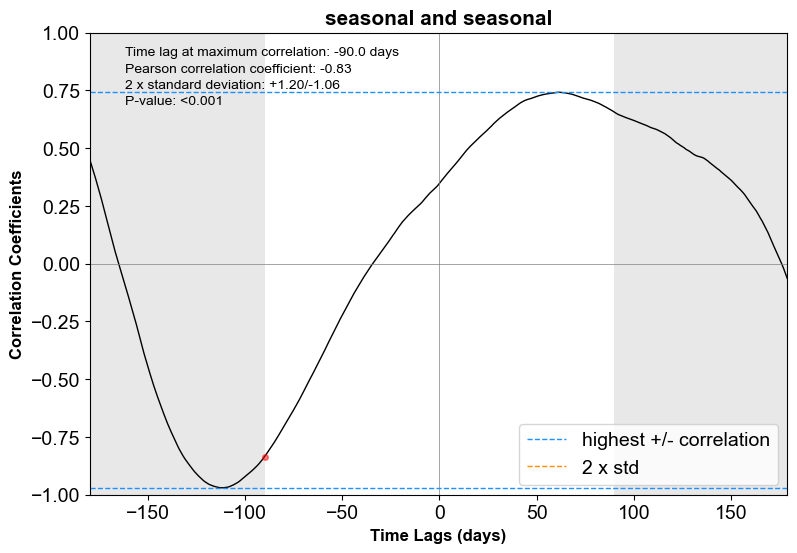

In [17]:
# This method is good. Same outcome as for statsmodels ccf

# Do correlations on stationary variables!

crosscorr_lag = 6 # tried 3 months did not work, tried 12 months = too much. Try 6 months now and only look at 3 months by graying out the boarders.

series1 = df_list[0].iloc[:,2] # seasonal disp
series2 = df_list[1].iloc[:,2] # seasonal wp

# series1 = df_list[1].iloc[:,2] # seasonal wp
# series2 = df_list[2].iloc[:,2] # seasonal air temp

# series1 = df_list[1].iloc[:,2] # seasonal wp
# series2 = df_list[3].iloc[:,2] # seasonal rock temp

series1 = df_list[0].iloc[:,2] # seasonal disp
series2 = df_list[3].iloc[:,2] # seasonal rock temp

# series1 = df.iloc[:,0]
# series2 = df.iloc[:,1]

# Set the maximum lag you want to consider
h = 1 # NB !frequency per day! 
n_months = crosscorr_lag
period =h*90 # we assume correlation should happen within 90 days
max_lag = n_months*30*h
lags = range(-max_lag, max_lag)

# Initialize arrays to store results
correlation_coefficients = []
p_values = []

# Loop through different time lags (both positive and negative)
for lag in lags:
    # Calculate Pearson correlation coefficient and p-value
    if lag < 0:
        correlation_coefficient, p_value = pearsonr(series1[:lag], series2[-lag:])
    elif lag == 0:
        correlation_coefficient, p_value = pearsonr(series1, series2)
    else:
        correlation_coefficient, p_value = pearsonr(series1[lag:], series2[:-lag])
    
    # Append results to arrays
    correlation_coefficients.append(correlation_coefficient)
    p_values.append(p_value)

# # Find the lag with the maximum absolute correlation for entire time series
# max_corr_index = np.argmax(np.abs(correlation_coefficients))
# max_corr_lag = lags[max_corr_index]

# Find the lag with the maximum absolute correlation within +/- 3 months
corr_window = correlation_coefficients[period:period*3]
max_corr_index = np.argmax(np.abs(corr_window))
max_corr_lag = lags[period:period*3][max_corr_index]

n_std = 2
small_size = 10

import scipy.stats as st 
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf, color='black', lw=1)
    ax.axvline(x = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = np.max(ccf), color = 'dodgerblue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'dodgerblue', lw = 1, linestyle='--')
    ax.plot(max_corr_lag/h, corr_window[max_corr_index], color='red', marker='o', markersize=4, alpha=0.5) # zorder=0 # point to highlight max within corr_window # point to highlight max within corr_window
    
    # 2 x std
    ax.axhline(y = np.mean(ccf)+n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--', label = f'{n_std} x std')
    ax.axhline(y = np.mean(ccf)-n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--')
    # # 1 x std
    # ax.axhline(y = np.mean(ccf)+1*np.std(ccf), color = 'red', lw = 1, linestyle='--', label = f'{1} x std')
    # ax.axhline(y = np.mean(ccf)-1*np.std(ccf), color = 'red', lw = 1, linestyle='--')
    
    # gray out area
    ax.axvspan(lags_plot[0], -90, facecolor='lightgray', alpha=0.5)
    ax.axvspan(+90,lags_plot[-1], facecolor='lightgray', alpha=0.5)
    
    # text in the plot
    y_pos = lags_plot[0]-(lags_plot[0]*0.1)
    ax.text(y_pos, 0.90, f'Time lag at maximum correlation: {max_corr_lag/h:.1f} days', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.83, f'Pearson correlation coefficient: {corr_window[max_corr_index]:.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.76, f'2 x standard deviation: +{np.mean(ccf)+n_std*np.std(ccf):.2f}/{np.mean(ccf)-n_std*np.std(ccf):.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    pval = []
    if p_values[max_corr_index] < 0.001:
        ax.text(y_pos, 0.69, f'P-value: <0.001', horizontalalignment='left', color='k', fontsize=small_size)
    else:
        ax.text(y_pos, 0.69, f'P-value: {p_values[max_corr_index]:.3f}', horizontalalignment='left', color='k', fontsize=small_size)
    
    # cosmetics
    ax.set(ylim = [-1, 1])
    ax.set_title(f'{series1.name} and {series2.name}', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags (days)', weight='bold', fontsize = 12)
    
    plt.legend(loc='lower right')
    
    # saving
    path = 'plots\\'
    save_name = f'{path}crosscorr_{series1.name}_{series2.name}_lag{n_months}.png'
    fig.savefig(save_name, dpi=300, bbox_inches='tight')
    
# changing lags to days
lags_plot = np.linspace(lags[0]/h,lags[-1]/h, num=int(max_lag*2)) # days

ccf_plot(lags_plot, correlation_coefficients)

# the first variable (x) is leading if negative lage time, and second variable (y) is leading if positive lag time

In [212]:
### Granger Causality test ###
# perhaps do the Granger Causality test? https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/?utm_content=cmp-true

# looks at lags and provide significance below 0.1 or 0.05 if variable in second column is caused by first column.

from statsmodels.tsa.stattools import grangercausalitytests
def grangers_causation_matrix(data, variables, maxlag=max_lag, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grang = pd.DataFrame({'col1': series1.values, 'col2': series2.values})
grang_test = grangers_causation_matrix(grang, variables=grang.columns, maxlag=max_lag/2)
print(grang_test)

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


InfeasibleTestError: The Granger causality test statistic cannot be compute because the VAR has a perfect fit of the data.

In [225]:
df_train.head()

Disp        WP   Temp  Rock_temp
2015-01-01  1.833209  4.160872  -2.35  -2.388690
2015-01-02  1.841365  3.910930  -0.75  -2.504340
2015-01-03  1.878110  3.827627  -4.05  -2.831905
2015-01-04  1.931627  3.892274  -5.45  -3.316370
2015-01-05  1.934592  3.921822 -10.45  -3.734040

In [226]:
grangercausalitytests(df_train.loc[:,['WP','Temp']], maxlag=90) # this suggests WP cause Disp


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9623  , p=0.3268  , df_denom=1243, df_num=1
ssr based chi2 test:   chi2=0.9647  , p=0.3260  , df=1
likelihood ratio test: chi2=0.9643  , p=0.3261  , df=1
parameter F test:         F=0.9623  , p=0.3268  , df_denom=1243, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9497  , p=0.3871  , df_denom=1240, df_num=2
ssr based chi2 test:   chi2=1.9070  , p=0.3854  , df=2
likelihood ratio test: chi2=1.9056  , p=0.3857  , df=2
parameter F test:         F=0.9497  , p=0.3871  , df_denom=1240, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1405  , p=0.3315  , df_denom=1237, df_num=3
ssr based chi2 test:   chi2=3.4408  , p=0.3285  , df=3
likelihood ratio test: chi2=3.4361  , p=0.3291  , df=3
parameter F test:         F=1.1405  , p=0.3315  , df_denom=1237, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2917  , p=0.

{1: ({'ssr_ftest': (0.9623332988131531, 0.3267905972473487, 1243.0, 1),
   'ssr_chi2test': (0.964655905326781, 0.32601660686355327, 1),
   'lrtest': (0.9642826786016485, 0.3261102135249606, 1),
   'params_ftest': (0.9623332988133146, 0.3267905972472793, 1243.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.9496856572638338, 0.38714380797507286, 1240.0, 2),
   'ssr_chi2test': (1.9070300698281821, 0.3853840016410938, 2),
   'lrtest': (1.905571011914617, 0.38566525300780613, 2),
   'params_ftest': (0.9496856572628545, 0.38714380797544634, 1240.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.1404840068152615, 0.3315394137415431, 1237.0, 3),
   'ssr_chi2test': (3.440813511264799, 0.3285199279389072, 3),
   'lrtest': (3.4360637476393094, 0.3291496012329709, 3),
   'params_ftest': (1.1404840068160453, 0.33153941374123114, 1237.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 

In [47]:
start_time = pd.Timestamp('2018-01-01')
end_time = pd.Timestamp('2024-01-01')

x = JTT2DispUpperZone.iloc[:,-1] # 60 days, -3 = 12 days, diff is 0.51 for 12 and 0.67 for 60 days
x = x[x.index.slice_indexer(start_time,end_time)]
y = JTT2WpUpperZone.iloc[:,0]
y = y[y.index.slice_indexer(start_time,end_time)]
df = pd.DataFrame({'Vel':x.values, 'WP':y.values})
df.corr()

Vel        WP
Vel  1.000000  0.664969
WP   0.664969  1.000000

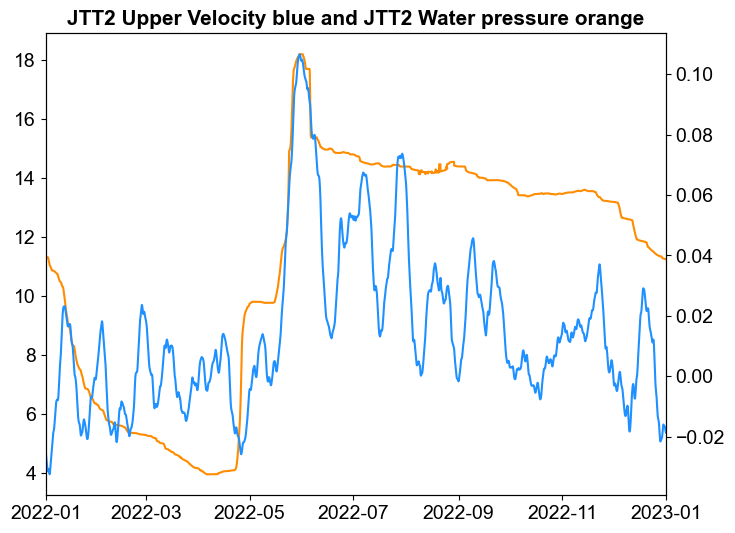

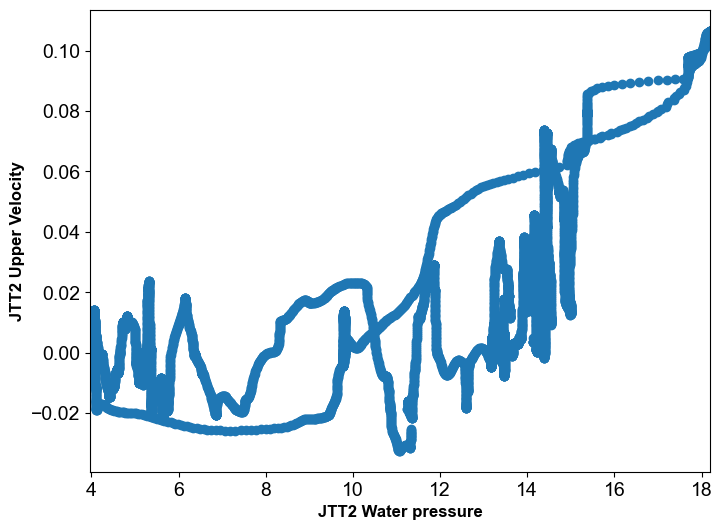

In [63]:
# data
days = 12
n = (days*24)+1 # kernel size, multiply by n rows per day, +1 to make odd number

# # # #borehole
x = JTT2DispUpperZone.loc[:,'12_days_velocity [mm/day]:'] # 12 days velocity
var1 = 'JTT2 Upper Velocity'

# x = JTT2DispLowerZone.loc[:,'12_days_velocity [mm/day]:'] # 12 days velocity
# var1 = 'JTT2 Lower Velocity'

# # water level
file3 = JTT2WpUpperZone.copy()

# ## median filter makes it nosy because the change is so abrupt
file3.iloc[:,0] = medfilt(file3.iloc[:,0], kernel_size=n) # median filter

file3 = file3.iloc[:,0]
y = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
var2 = 'JTT2 Water pressure'


# # make equal length of dfs
# time_start = pd.Timestamp('2018-01-01') # x.index[0]
# time_end = pd.Timestamp('2024-01-01') # x.index[-1]

time_start = pd.Timestamp('2022-01-01') # x.index[0]
time_end = pd.Timestamp('2023-01-01') # x.index[-1]

y = y[y.index.slice_indexer(time_start,time_end)]
# end at the same time 
# time_end = y.index[-1]
x = x[x.index.slice_indexer(time_start,time_end)]

# https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python # link to what I want to check!

# look at data
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)
ax.plot(y, color='darkorange')
ax_y = ax.twinx()
ax_y.plot(x, color='dodgerblue')

plt.title(f'{var1} blue and {var2} orange', weight='bold', fontsize = 15)
plt.show()

# removing nans to be able to plot against eachother
d = {'y': y, 'x': x}
df = pd.DataFrame(data=d)
df.dropna(inplace=True)

fig = plt.figure(figsize = (8, 6))
plt.scatter(y, x)
plt.ylabel(var1, weight='bold', fontsize = 12)
plt.xlabel(var2, weight='bold', fontsize = 12)
plt.show()

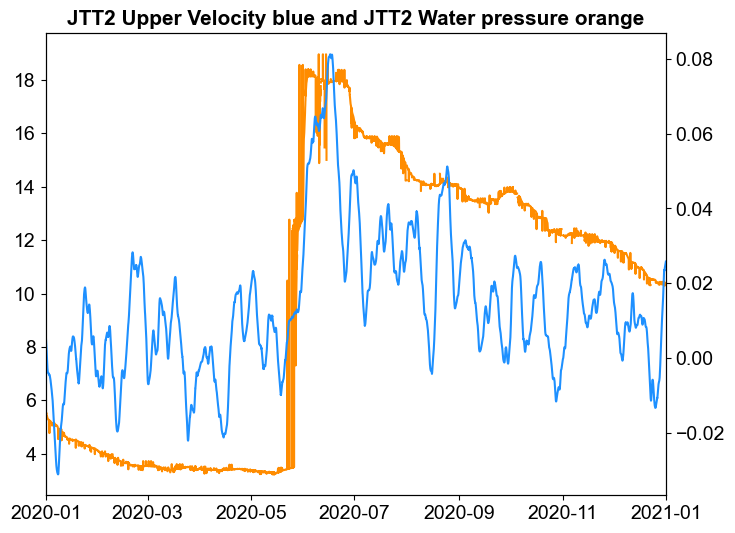

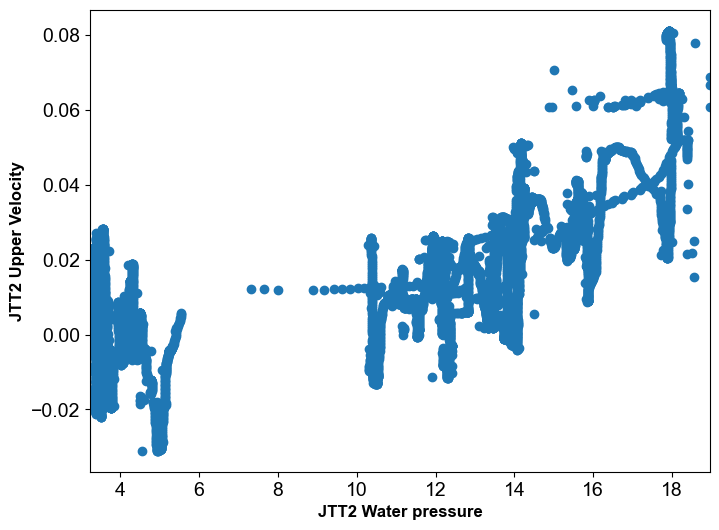

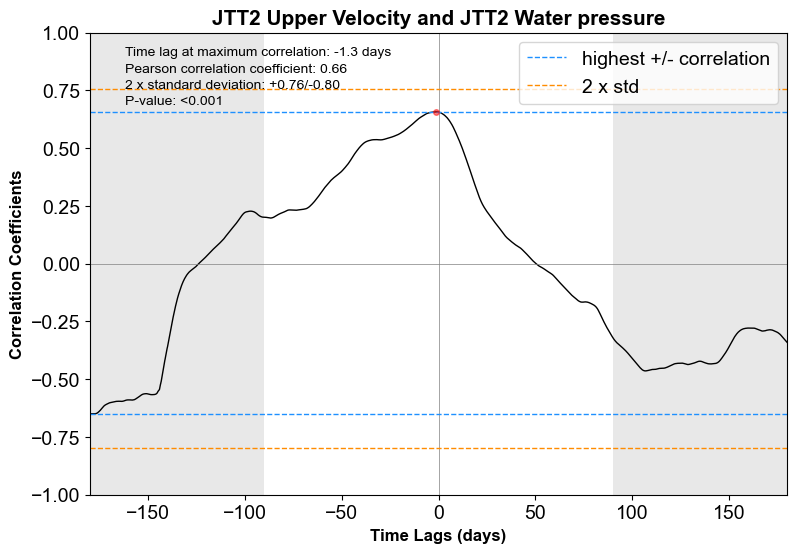

In [65]:
### 1h data
gnss = False
met = False

crosscorr_lag = 6 # tried 3 months did not work, tried 12 months = too much. Try 6 months now and only look at 3 months by graying out the boarders.

# data
days = 12
n = (days*24)+1 # kernel size, multiply by n rows per day, +1 to make odd number

# # # #borehole
x = JTT2DispUpperZone.loc[:,'12_days_velocity [mm/day]:'] # 12 days velocity
var1 = 'JTT2 Upper Velocity'

# x = JTT2DispLowerZone.loc[:,'12_days_velocity [mm/day]:'] # 12 days velocity
# var1 = 'JTT2 Lower Velocity'

# # water level
file3 = JTT2WpUpperZone.copy()

## median filter makes it nosy because the change is so abrupt
file3.iloc[:,0] = medfilt(file3.iloc[:,0], kernel_size=n) # median filter

file3 = file3.iloc[:,0]
y = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
var2 = 'JTT2 Water pressure'


# make equal length of dfs
# time_start = pd.Timestamp('2018-01-01') # x.index[0]
# time_end = pd.Timestamp('2024-01-01') # x.index[-1]

time_start = pd.Timestamp('2020-01-01') # x.index[0]
time_end = pd.Timestamp('2021-01-01') # x.index[-1]

y = y[y.index.slice_indexer(time_start,time_end)]
# end at the same time 
# time_end = y.index[-1]
x = x[x.index.slice_indexer(time_start,time_end)]

# https://www.datainsightonline.com/post/cross-correlation-with-two-time-series-in-python # link to what I want to check!

# look at data
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)
ax.plot(y, color='darkorange')
ax_y = ax.twinx()
ax_y.plot(x, color='dodgerblue')

plt.title(f'{var1} blue and {var2} orange', weight='bold', fontsize = 15)
plt.show()

# removing nans to be able to plot against eachother
d = {'y': y, 'x': x}
df = pd.DataFrame(data=d)
df.dropna(inplace=True)

fig = plt.figure(figsize = (8, 6))
plt.scatter(y, x)
plt.ylabel(var1, weight='bold', fontsize = 12)
plt.xlabel(var2, weight='bold', fontsize = 12)
plt.show()

# Assuming you have two time series arrays, series1 and series2
# Replace these with your actual data

series1 = df['x']
series2 = df['y']

# Set the maximum lag you want to consider
h = 24
if gnss:
    h = 2
if met:
    h = 1
n_months = crosscorr_lag
period =24*90 # we assume correlation should happen within 90 days
max_lag = n_months*30*h
lags = range(-max_lag, max_lag)

# Initialize arrays to store results
correlation_coefficients = []
p_values = []

# Loop through different time lags (both positive and negative)
for lag in lags:
    # Calculate Pearson correlation coefficient and p-value
    if lag < 0:
        correlation_coefficient, p_value = pearsonr(series1[:lag], series2[-lag:])
    elif lag == 0:
        correlation_coefficient, p_value = pearsonr(series1, series2)
    else:
        correlation_coefficient, p_value = pearsonr(series1[lag:], series2[:-lag])
    
    # Append results to arrays
    correlation_coefficients.append(correlation_coefficient)
    p_values.append(p_value)

# # Find the lag with the maximum absolute correlation for entire time series
# max_corr_index = np.argmax(np.abs(correlation_coefficients))
# max_corr_lag = lags[max_corr_index]

# Find the lag with the maximum absolute correlation within +/- 3 months
corr_window = correlation_coefficients[period:period*3]
max_corr_index = np.argmax(np.abs(corr_window))
max_corr_lag = lags[period:period*3][max_corr_index]

n_std = 2
small_size = 10

import scipy.stats as st 
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf, color='black', lw=1)
    ax.axvline(x = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = np.max(ccf), color = 'dodgerblue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'dodgerblue', lw = 1, linestyle='--')
    ax.plot(max_corr_lag/h, corr_window[max_corr_index], color='red', marker='o', markersize=4, alpha=0.5) # zorder=0 # point to highlight max within corr_window # point to highlight max within corr_window
    
    # 2 x std
    ax.axhline(y = np.mean(ccf)+n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--', label = f'{n_std} x std')
    ax.axhline(y = np.mean(ccf)-n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--')
    # # 1 x std
    # ax.axhline(y = np.mean(ccf)+1*np.std(ccf), color = 'red', lw = 1, linestyle='--', label = f'{1} x std')
    # ax.axhline(y = np.mean(ccf)-1*np.std(ccf), color = 'red', lw = 1, linestyle='--')
    
    # gray out area
    ax.axvspan(lags_plot[0], -90, facecolor='lightgray', alpha=0.5)
    ax.axvspan(+90,lags_plot[-1], facecolor='lightgray', alpha=0.5)
    
    # text in the plot
    y_pos = lags_plot[0]-(lags_plot[0]*0.1)
    ax.text(y_pos, 0.90, f'Time lag at maximum correlation: {max_corr_lag/h:.1f} days', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.83, f'Pearson correlation coefficient: {corr_window[max_corr_index]:.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.76, f'2 x standard deviation: +{np.mean(ccf)+n_std*np.std(ccf):.2f}/{np.mean(ccf)-n_std*np.std(ccf):.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    pval = []
    if p_values[max_corr_index] < 0.001:
        ax.text(y_pos, 0.69, f'P-value: <0.001', horizontalalignment='left', color='k', fontsize=small_size)
    else:
        ax.text(y_pos, 0.69, f'P-value: {p_values[max_corr_index]:.3f}', horizontalalignment='left', color='k', fontsize=small_size)
    
    # cosmetics
    ax.set(ylim = [-1, 1])
    ax.set_title(f'{var1} and {var2}', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags (days)', weight='bold', fontsize = 12)
    
    plt.legend()
    
    # saving
    path = 'plots\\'
    save_name = f'{path}crosscorr_{var1}_{var2}_lag{n_months}.png'
    fig.savefig(save_name, dpi=300, bbox_inches='tight')
    

# # Display the results for the lag with maximum absolute correlation
# print(f"Time lag at maximum correlation: {max_corr_lag/h:.2f} days")
# print(f"Pearson correlation coefficient: {correlation_coefficients[max_corr_index]:.2f}")
# print(f"Standard deviation: {np.mean(correlation_coefficients)+n_std*np.std(correlation_coefficients):.2f}")
# print(f"P-value: {p_values[max_corr_index]:.3f}")
 

# changing lags to days
lags_plot = np.linspace(lags[0]/h,lags[-1]/h, num=int(max_lag*2)) # days

ccf_plot(lags_plot, correlation_coefficients)

# the first variable (x) is leading if negative lage time, and second variable (y) is leading if positive lag time

### Granger Causality test ###
# perhaps do the Granger Causality test? https://www.machinelearningplus.com/time-series/granger-causality-test-in-python/?utm_content=cmp-true
# I do not understand the test results of this..

from statsmodels.tsa.stattools import grangercausalitytests
def grangers_causation_matrix(data, variables, maxlag=max_lag, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

# grang_test = grangers_causation_matrix(df, variables = df.columns, maxlag=max_lag)
# print(grang_test)

# I considered spearmann and found it not as the correct funvtion for my case as I need to take into the higher water pressures in consideration!

In [3]:
vel = velocity(KH0206DispLowerZone, window_days=60, results=False) # run this before figure 2
vel.iloc[:,-1] = vel.iloc[:,-1]*24 # changing velocity from mm/hour to mm/day

C:\Users\andregas\AppData\Local\Temp\ipykernel_15688\3348284083.py:251: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


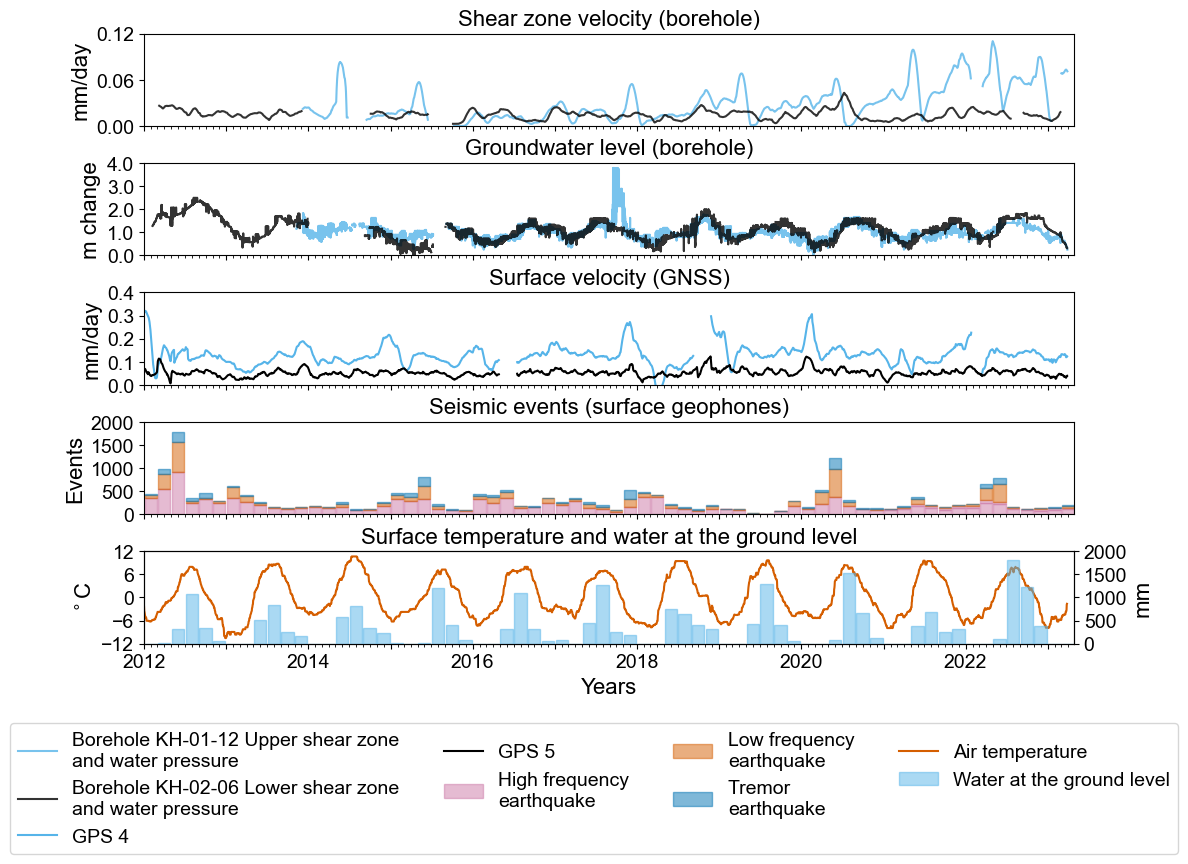

In [4]:
from matplotlib.dates import DateFormatter

# plotting

ncols = 1
nrows = 5 # len(file['event'].unique()) // ncols + (len(file['event'].unique()) % ncols > 0)

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace = .4)

# time series length
start_time = '2012-01-01'
end_time = '2023-03-28'

# # manually picked start and end times for following data
# file3 = KH0206PiezLowerZone.copy()
# start_time = pd.Timestamp(file3.index[0])
# end_time = pd.Timestamp(file3.index[-1])


file = KH0112DispUpperZone.iloc[:,8]
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, file.values, color=colors[5], label='Borehole KH-01-12 Upper shear zone \nand water pressure', alpha=0.8)

file = vel.iloc[:,-1]
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, file.values, color=colors[7], label='Borehole KH-02-06 Lower shear zone \nand water pressure', alpha=0.8)

# water level
n_day = 59 # days # 2 months kernel size for median filter (hourly data)
n_hour = round_up_to_odd(24*n_day) 

#loading KH0112 as it has a longer time series..

file3 = KH0112PiezLowerZone.copy()
watermodule = 'Mod30_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[5], label='', alpha=0.8) # Borehole KH-01-12 \nwater pressure


#loading KH0206 as it has a longer time series..
file3=KH0206PiezLowerZone.copy()
watermodule = 'Mod35_Water pressure [m]:'
# manually picked start and end times for following data
# start_time = '2011-01-01'
end_time = file3.index[-1]
file3 = file3.resample('1h').median()
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[7], label='', alpha=0.8) # Borehole KH-02-06 \nwater pressure

# #loading KH0118 as it is longer than KH0218
# file3=KH0118Piez_raw
# # watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod26_Water pressure [m]:' # seasonal oscilations
# start_t = '2020-01-01' # start time
# file3 =  file3[file3.index.slice_indexer(start_t,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n) # median filter
# ax[0].plot(file3.index, file3[watermodule].values-np.min(file3[watermodule]), color='forestgreen', label='KH0118', alpha=0.8)

# #loading KH0217 as it is longer than KH0218
# file3=KH0217PiezUpperZone_raw
# # watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations
# # start_t = '2020-01-01' # start time
# file3 =  file3[file3.index.slice_indexer(start_t,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n) # median filter
# ax[0].plot(file3.index, file3[watermodule].values-np.min(file3[watermodule]), color='violet', label='KH0217', alpha=0.8)

# GPS data
# data = 'Northing_medfilt'
data= '2d_60_days_velocity'

# df =  gps2
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# ax[1].plot(df.index, df[data]-df[data][0], color='black', label='GPS 2')

# df =  gps3
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='red', label='GPS 3')

df =  gps4
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[2].plot(df.index, (df[data]), color=colors[5], label='GPS 4')

df =  gps5
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[2].plot(df.index, (df[data]), color=colors[7], label='GPS 5')

# df =  gps6
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='orange', label='GPS 6')

# df =  gps10
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='yellow', label='GPS 10')

# df =  gps11
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='brown', label='GPS 11')

# seismic data
# seismicity_sub =  seismicity_qcd[(seismicity_qcd.index > start_time) & (seismicity_qcd.index < end_time)]
seismicity_sub =  seismicity[(seismicity.index > start_time) & (seismicity.index < end_time)]
seismicity_sub = seismicity_sub.resample('2M').sum()

# stacking types
bar1 = seismicity_sub['Slope_HF_nEvents']
bar2 = seismicity_sub['Slope_Multi_nEvents']
bar3 = seismicity_sub['Slope_LF_nEvents']
bar4 = seismicity_sub['Slope_Tremor_nEvents']

width = 55

ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_HF_nEvents'], width = width, color=colors[0], ec=colors[0], label='High frequency \nearthquake', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_Multi_nEvents'], width = width, color=colors[0], ec=colors[0], bottom=bar1, label='', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_LF_nEvents'], width = width, color=colors[1], ec=colors[1], bottom=bar1+bar2, label='Low frequency \nearthquake', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_Tremor_nEvents'], width = width, color=colors[2], ec=colors[2], bottom=bar1+bar2+bar3, label='Tremor \nearthquake', alpha=0.5)

width = 55
# temp_sub =  temp[(temp.index > start_time) & (temp.index < end_time)] # data per day
temp_sub = temp[temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
temp_sub.iloc[:,0] = medfilt(temp_sub.iloc[:,0], kernel_size=n_day)

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
snowrain_melt_sub =  snowrain_melt[snowrain_melt.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
snowrain_melt_sub = snowrain_melt_sub.resample('2M').sum()

ax[4].plot(temp_sub.index, temp_sub['temperature'], color=colors[1], label='Air temperature')
ax_y = ax[4].twinx()
ax_y.bar(dates.date2num(snowrain_melt_sub.index), snowrain_melt_sub['snowrain_melt'], width = width, ec=colors[5], color=colors[5], label='Water at the ground level', alpha=0.5)

# adjusting gridlines
nticks = 5
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(3))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[4].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax_y.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # number of digits
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# just to get an whole number so it looks nice
def myround(x, base=10):
    return base * round(x/base)

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(0, 0.12) # velocity

ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(0, myround(ymax, base=1)) # water level

ymin, ymax = ax[2].get_ylim()
ax[2].set_ylim(0, 0.4) # velocity

ymin, ymax = ax[3].get_ylim()
ax[3].set_ylim(0, myround(ymax, base=500)) # seismic events

ymin, ymax = ax[4].get_ylim()
ax[4].set_ylim(-12, myround(ymax, base=6)) # temp -12 bas 6 for two months, 16 and base 8 for 1 month

ymin, ymax = ax_y.get_ylim()
ax_y.set_ylim(0, 2000) # available surface water, 1800 for two months, 1000 for 1 month

ax[0].title.set_text('Shear zone velocity (borehole)')
ax[1].title.set_text('Groundwater level (borehole)')
ax[2].title.set_text('Surface velocity (GNSS)')
ax[3].title.set_text('Seismic events (surface geophones)')
ax[4].title.set_text('Surface temperature and water at the ground level')

# one legend on the right side of plots
# for i in range(5):
#     box = ax[i].get_position()
#     ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height]) # shrinking axes to accomodate legend
# handles, labels = [(a + b + c + d + e + f) for a, b, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
# fig.legend(handles, labels, loc = (0.8, 0.275)) # center of fig

#legend underneath plots
handles, labels = [(a + c + d + e + f) for a, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
fig.subplots_adjust(bottom=0.27) # create space
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0.2), ncol=4) # center of fig

# set axis labels
ax[0].set_ylabel('mm/day')
ax[1].set_ylabel('m change')
ax[2].set_ylabel('mm/day')
ax[3].set_ylabel('Events') #  per 2 months
ax[4].set_ylabel('$^\circ$C')
ax_y.set_ylabel('mm') #  per 2 months
ax[4].set_xlabel('Years')

# # Ensure the first year is included
# start_year = bh_data.index.min().year
# end_year = bh_data.index.max()
# ax[4].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax[4].xaxis.set_major_locator(years)
ax[4].xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax[4].xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax[4].xaxis.set_major_formatter(years_fmt)

# # Rotate and align the tick labels so they look better
# fig.autofmt_xdate()

# removing tick labels from the xaxis
n = 2  # keeps every n row
[l.set_visible(False) for (i,l) in enumerate(ax[4].xaxis.get_ticklabels()) if i % n != 0]

# # # saving
path = 'plots\\'
save_name = f'{path}Figure2.png'
# save_name = f'{path}Figure2_A0poster.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'
fig.show()

In [114]:
# run this before making zoomed figure

# time series length
start_time = '2020-01-01'
end_time = '2022-01-01'

file =  KH0112DispUpperZone[KH0112DispUpperZone.index.slice_indexer(start_time,end_time)]
n = 60
vel1 = velocity(file, window_days=n, results=False) # run this before figure 2
vel1.iloc[:,-1] = vel1.iloc[:,-1]*24 # changing velocity from mm/hour to mm/day

file =  KH0206DispLowerZone[KH0206DispLowerZone.index.slice_indexer(start_time,end_time)]
vel2 = velocity(file, window_days=n, results=False) # run this before figure 2
vel2.iloc[:,-1] = vel2.iloc[:,-1]*24 # changing velocity from mm/hour to mm/day

# GNSS
def velocity_gps(df, n=60):
    # calculating velocity (mm/day)    
    data = '2d'
    n = n # linear fit over n days
    df =  pd.merge_asof(df, linearfit(df.loc[:,data], window_days=n, results=False, gps=True), on=df.index.name, tolerance=pd.Timedelta(hours=0))
    df.set_index(df.columns[0], drop=True, inplace=True)
    df[f'{data}_{n}_days_velocity [mm/day]:'] = df.loc[:,f'{n}_days_velocity']*2 # velocity = mm per day
    df.drop(f'{n}_days_velocity', axis=1, inplace=True)
    return df

file =  gps4[gps4.index.slice_indexer(start_time,end_time)]
vel3 = velocity_gps(file, n=n)
file =  gps5[gps5.index.slice_indexer(start_time,end_time)]
vel4 = velocity_gps(file, n=n)
file =  gps6[gps6.index.slice_indexer(start_time,end_time)]
vel5 = velocity_gps(file, n=n)

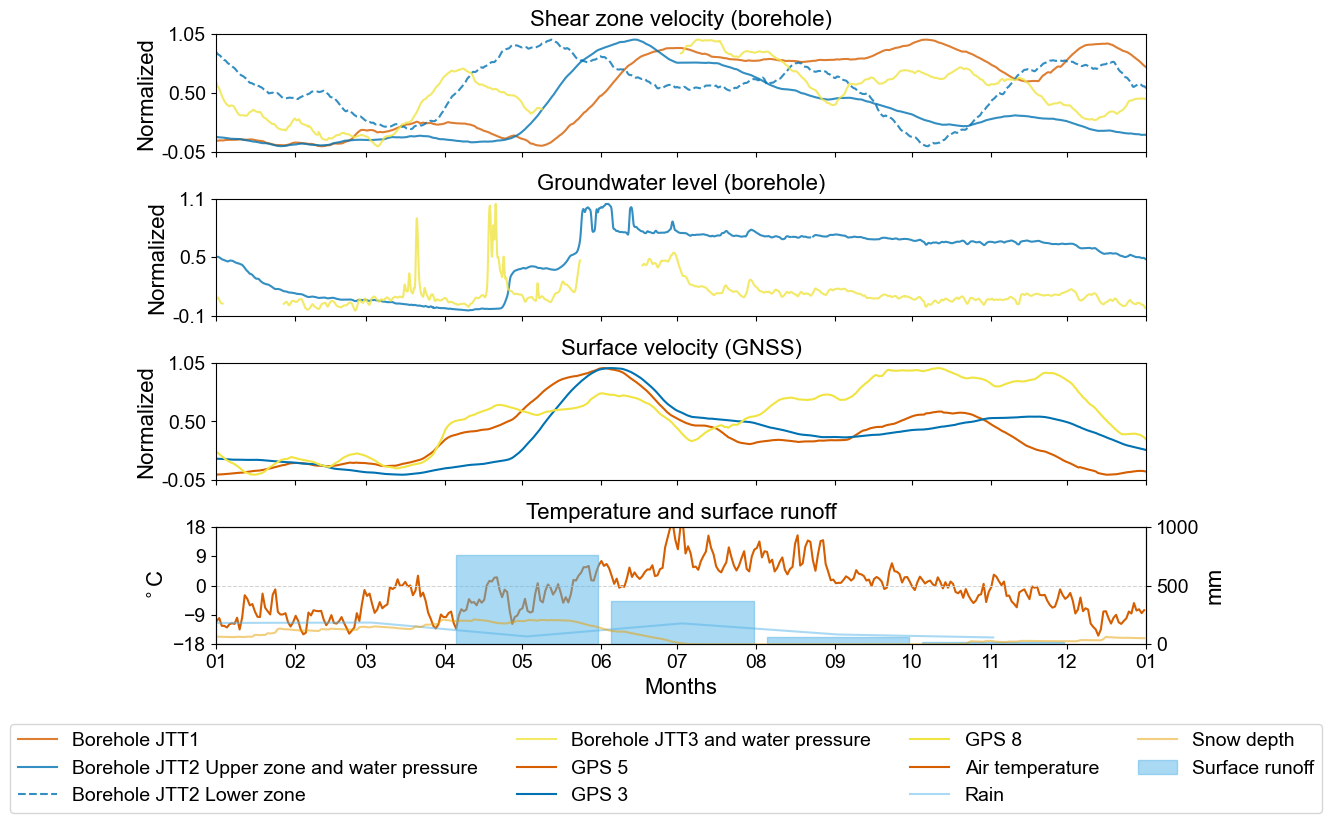

In [44]:
# Normalized version of Figure 2

# plotting

ncols = 1
nrows = 4 # len(file['event'].unique()) // ncols + (len(file['event'].unique()) % ncols > 0)

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace = .4)

# manually picked start and end times for following data
file3 = JTT1Disp.copy()
start_time = pd.Timestamp('2022-01-01')
end_time = pd.Timestamp('2023-01-01')

# col = '12_days_velocity [mm/day]:'
# col = '30_days_velocity [mm/day]:'
col = '60_days_velocity [mm/day]:'
file = JTT1Disp.loc[:,col]
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, normalized, color=colors[1], label='Borehole JTT1 ', alpha=0.8)


file = JTT2DispUpperZone.loc[:,col]
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, normalized, color=colors[2], label='Borehole JTT2 Upper zone and water pressure', alpha=0.8)

file = JTT2DispLowerZone.loc[:,col]
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, normalized, color=colors[2], linestyle='dashed', label='Borehole JTT2 Lower zone', alpha=0.8)

file = JTT3Disp.loc[:,col]
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, normalized, color=colors[3], label='Borehole JTT3 and water pressure', alpha=0.8)

# water level
n_day = 61 # days # 2 months kernel size for median filter (hourly data)
n_hour = round_up_to_odd(24*n_day) 

#loading KH0112 as it has a longer time series..

# file3 = JTT1Wp.copy()
# watermodule = 'Mod4_Water pressure [m]:'
# file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# # file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
# file3 = file3[watermodule]
# # file3 = file3[file3.first_valid_index():]
# file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
# file = file3.values-np.nanmin(file3.values)
# normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
# ax[1].plot(file3.index, normalized, color=colors[4], label='Borehole JTT1 \nwater pressure', alpha=0.8)

file3 = JTT2WpUpperZone.copy()
watermodule = 'Mod4_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file = file3.values-np.nanmin(file3.values)
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[1].plot(file3.index, normalized, color=colors[2], label='', alpha=0.8)

file3 = JTT3Wp.copy()
watermodule = 'Mod4_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file = file3.values-np.nanmin(file3.values)
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[1].plot(file3.index, normalized, color=colors[3], label='', alpha=0.8)

# GPS data
# data= '2d_12_days_velocity [mm/day]:'
# data= '2d_30_days_velocity [mm/day]:' # this is 2d velocity
data= '2d_60_days_velocity [mm/day]:' # this is 2d velocity

df =  jett_gps5 # Jtt1 gps 5 or gps 4
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
file = df[data]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[2].plot(file.index, normalized, color=colors[1], label='GPS 5')

df =  jett_gps3 # same as Jtt2
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
file = df[data]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[2].plot(file.index, normalized, color=colors[2], label='GPS 3')

df =  jett_gps8 # same as Jtt3
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
file = df[data]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[2].plot(file.index, normalized, color=colors[3], label='GPS 8')


width = 55/60*n_day # 55 works well for 60 days
# temp_sub =  temp[(temp.index > start_time) & (temp.index < end_time)] # data per day
# temp_sub = temp[temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # actual air temp
temp_sub = jtt_xgeo_temp[jtt_xgeo_temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # xgeo air temp
# temp_sub.iloc[:,0] = medfilt(temp_sub.iloc[:,0], kernel_size=n_day)

# ST_sub = ST[ST.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# ST_sub.iloc[:,0] = medfilt(ST_sub.iloc[:,0], kernel_size=n_day)
# ST_sub.iloc[:,1] = medfilt(ST_sub.iloc[:,1], kernel_size=n_day)

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
snowrainmelt_sub =  jtt_xgeo_snowrainmelt[jtt_xgeo_snowrainmelt.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
snowrainmelt_sub = snowrainmelt_sub.resample(f'{n_day}d').sum()

xgeo_snow_sub =  jtt_xgeo_snow[jtt_xgeo_snow.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# xgeo_snow_sub = xgeo_snow_sub.resample(f'{n_day}d').sum()

xgeo_rain_sub =  jtt_xgeo_rain[jtt_xgeo_rain.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
xgeo_rain_sub = xgeo_rain_sub.resample(f'{n_day}d').sum()

ax[3].plot(temp_sub.index, temp_sub['temperature'], color=colors[1], label='Air temperature')
ax[3].axhline(y=0.0, color='lightgray', linestyle='dashed', linewidth=.75)

# ax[3].plot(ST_sub.index,ST_sub['ST2'], color=color_bacscarpairtemp, label='BS air temperature')
# ax[3].plot(ST_sub.index,ST_sub['ST3'], color=color_bacscarprocktemp, label='BS rock temperature')


ax_y = ax[3].twinx()
ax_y.bar(dates.date2num(snowrainmelt_sub.index), snowrainmelt_sub['snowrainmelt'], width = width, ec=colors[5], color=colors[5], label='Surface runoff', alpha=0.5)

ax_y.plot(xgeo_rain_sub.index, xgeo_rain_sub['rain'], color=colors[5], label='Rain', alpha=0.5)
ax_y.plot(xgeo_snow_sub.index, xgeo_snow_sub['depth'], color=colors[6], label='Snow depth', alpha=0.5)

# adjusting gridlines
nticks = 3
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
# ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax_y.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # number of digits
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# just to get an whole number so it looks nice
def myround(x, base=10):
    return base * round(x/base)

# ymin, ymax = ax[0].get_ylim()
# ax[0].set_ylim(0, 0.15) # bh velocity

# ymin, ymax = ax[1].get_ylim()
# ax[1].set_ylim(0, myround(ymax, base=1)) # water level

# ymin, ymax = ax[2].get_ylim()
# ax[2].set_ylim(0, 0.4) # gnss velocity

# ymin, ymax = ax[3].get_ylim()
# ax[3].set_ylim(0, myround(ymax, base=500)) # seismic events

ymin, ymax = ax[3].get_ylim()
ax[3].set_ylim(myround(-ymax, base=6), myround(ymax, base=6)) # temp -12 bas 6 for two months, 16 and base 8 for 1 month

ymin, ymax = ax_y.get_ylim()
ax_y.set_ylim(0, 1000) # available surface water, 1800 for two months, 1000 for 1 month

ax[0].title.set_text('Shear zone velocity (borehole)')
ax[1].title.set_text('Groundwater level (borehole)')
ax[2].title.set_text('Surface velocity (GNSS)')
# ax[3].title.set_text('Seismic events (surface geophones)')
ax[3].title.set_text('Temperature and surface runoff')

# one legend on the right side of plots
# for i in range(5):
#     box = ax[i].get_position()
#     ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height]) # shrinking axes to accomodate legend
# handles, labels = [(a + b + c + d + e + f) for a, b, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
# fig.legend(handles, labels, loc = (0.8, 0.275)) # center of fig

#legend underneath plots
handles, labels = [(a + b + c + d + e) for a, b, c, d, e in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
fig.subplots_adjust(bottom=0.27) # create space
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0.2), ncol=4) # center of fig

# set axis labels
ax[0].set_ylabel('Normalized')
ax[1].set_ylabel('Normalized')
ax[2].set_ylabel('Normalized')
# ax[3].set_ylabel('Events') #  per 2 months
ax[3].set_ylabel('$^\circ$C')
ax_y.set_ylabel('mm') #  per 12 weeks


# years = mdates.YearLocator(1)   # set number for every other year
# years_fmt = mdates.DateFormatter('%Y') # only display year, not day and month
# ax[3].set_xlabel('Years')

years = mdates.MonthLocator()   # set number for every other year
years_fmt = mdates.DateFormatter('%m') # only display year, not day and month
ax[3].set_xlabel('Months')

ax[3].xaxis.set_major_locator(years)
ax[3].xaxis.set_major_formatter(years_fmt)

# removing tick labels from the xaxis
n = 1  # keeps every n row
[l.set_visible(False) for (i,l) in enumerate(ax[3].xaxis.get_ticklabels()) if i % n != 0]

# removing space on sides
ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

# # # saving
path = 'plots\\'
save_name = f'{path}Figure2_normalized_zoom_Jettan.png'
# save_name = f'{path}Figure2_A0poster.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'

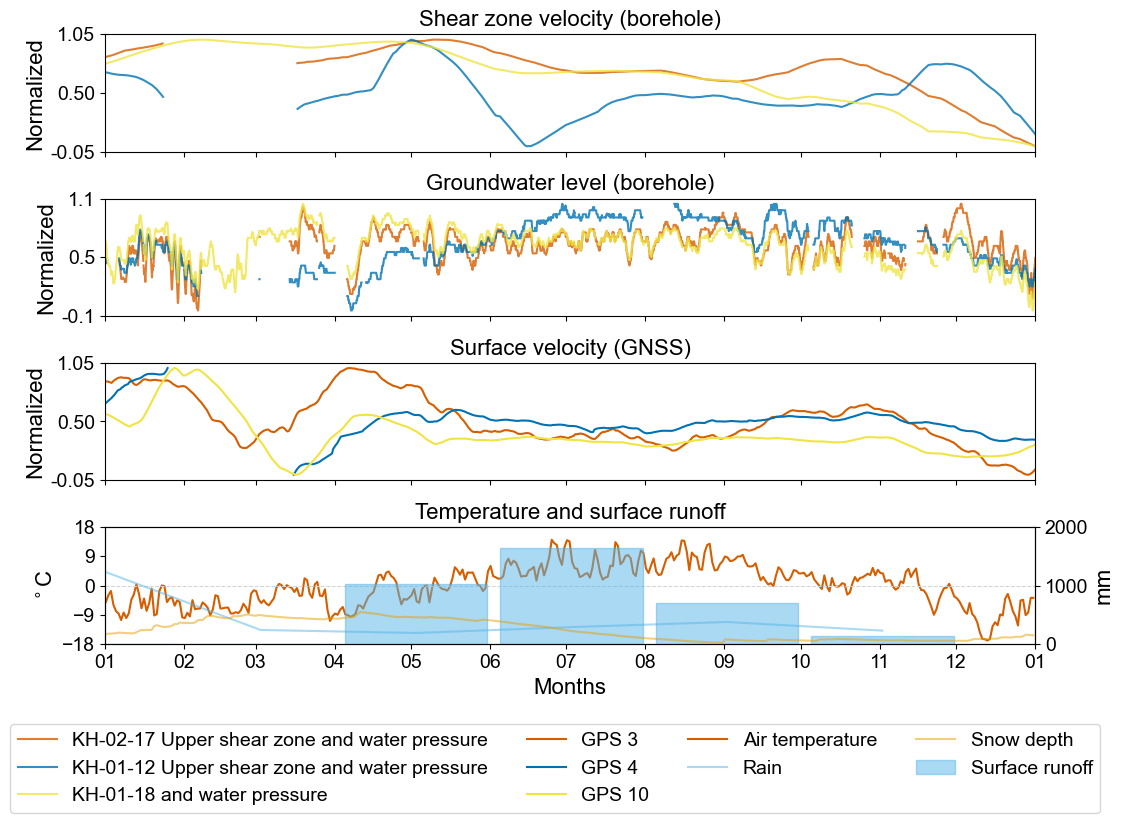

In [45]:
# Normalized version of Figure 2

# plotting

ncols = 1
nrows = 4 # len(file['event'].unique()) // ncols + (len(file['event'].unique()) % ncols > 0)

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace = .4)

# manually picked start and end times for following data
start_time = pd.Timestamp('2022-01-01')
end_time = pd.Timestamp('2023-01-01')

# col = '12_days_velocity [mm/day]:'
# col = '30_days_velocity [mm/day]:'
col = '60_days_velocity'
file = KH0217DispUpperZone.loc[:,col]
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, normalized, color=colors[1], label='KH-02-17 Upper shear zone and water pressure', alpha=0.8)


file = KH0112DispUpperZone.loc[:,col]
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, normalized, color=colors[2], label='KH-01-12 Upper shear zone and water pressure', alpha=0.8)

file = KH0118Disp.loc[:,col]
file =  file[file.index.slice_indexer(start_time,end_time)]
zero = file[file.first_valid_index()]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, normalized, color=colors[3], label='KH-01-18 and water pressure', alpha=0.8)


# water level
n_day = 61 # days # 2 months kernel size for median filter (hourly data)
n_hour = round_up_to_odd(24*n_day) 

file3 = KH0217PiezUpperZone.copy()
watermodule = 'Mod98_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file = file3.values-np.nanmin(file3.values)
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[1].plot(file3.index, normalized, color=colors[1], label='', alpha=0.8)

file3 = KH0112PiezUpperZone.copy()
watermodule = 'Mod30_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file = file3.values-np.nanmin(file3.values)
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[1].plot(file3.index, normalized, color=colors[2], label='', alpha=0.8)

file3 = KH0118Piez.copy()
watermodule = 'Mod63_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file = file3.values-np.nanmin(file3.values)
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[1].plot(file3.index, normalized, color=colors[3], label='', alpha=0.8)

# GPS data
# data= '2d_12_days_velocity [mm/day]:'
# data= '2d_30_days_velocity [mm/day]:' # this is 2d velocity
data= '2d_60_days_velocity' # this is 2d velocity

df =  ak_gps3 # above KH0217
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
file = df[data]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[2].plot(file.index, normalized, color=colors[1], label='GPS 3')

df =  ak_gps4 # same as KH0112
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
file = df[data]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[2].plot(file.index, normalized, color=colors[2], label='GPS 4')

df =  ak_gps10 # same as KH0118
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
file = df[data]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
ax[2].plot(file.index, normalized, color=colors[3], label='GPS 10')

width = 55/60*n_day # 55 works well for 60 days
# temp_sub =  temp[(temp.index > start_time) & (temp.index < end_time)] # data per day
# temp_sub = temp[temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # actual air temp
temp_sub = ak_temp[ak_temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # xgeo air temp
# temp_sub.iloc[:,0] = medfilt(temp_sub.iloc[:,0], kernel_size=n_day)

# ST_sub = ST[ST.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# ST_sub.iloc[:,0] = medfilt(ST_sub.iloc[:,0], kernel_size=n_day)
# ST_sub.iloc[:,1] = medfilt(ST_sub.iloc[:,1], kernel_size=n_day)

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
snowrainmelt_sub =  ak_snowrain_melt[ak_snowrain_melt.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
snowrainmelt_sub = snowrainmelt_sub.resample(f'{n_day}d').sum()

xgeo_snow_sub =  ak_snow[ak_snow.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# xgeo_snow_sub = xgeo_snow_sub.resample(f'{n_day}d').sum()

xgeo_rain_sub =  ak_precip[ak_precip.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
xgeo_rain_sub = xgeo_rain_sub.resample(f'{n_day}d').sum()

ax[3].plot(temp_sub.index, temp_sub['temperature'], color=colors[1], label='Air temperature')
ax[3].axhline(y=0.0, color='lightgray', linestyle='dashed', linewidth=.75)

# ax[3].plot(ST_sub.index,ST_sub['ST2'], color=color_bacscarpairtemp, label='BS air temperature')
# ax[3].plot(ST_sub.index,ST_sub['ST3'], color=color_bacscarprocktemp, label='BS rock temperature')


ax_y = ax[3].twinx()
ax_y.bar(dates.date2num(snowrainmelt_sub.index), snowrainmelt_sub['snowrain_melt'], width = width, ec=colors[5], color=colors[5], label='Surface runoff', alpha=0.5)

ax_y.plot(xgeo_rain_sub.index, xgeo_rain_sub['rain'], color=colors[5], label='Rain', alpha=0.5)
ax_y.plot(xgeo_snow_sub.index, xgeo_snow_sub['depth'], color=colors[6], label='Snow depth', alpha=0.5)

# adjusting gridlines
nticks = 3
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
# ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax_y.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # number of digits
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# just to get an whole number so it looks nice
def myround(x, base=10):
    return base * round(x/base)

# ymin, ymax = ax[0].get_ylim()
# ax[0].set_ylim(0, 0.15) # bh velocity

# ymin, ymax = ax[1].get_ylim()
# ax[1].set_ylim(0, myround(ymax, base=1)) # water level

# ymin, ymax = ax[2].get_ylim()
# ax[2].set_ylim(0, 0.4) # gnss velocity

# ymin, ymax = ax[3].get_ylim()
# ax[3].set_ylim(0, myround(ymax, base=500)) # seismic events

ymin, ymax = ax[3].get_ylim()
ax[3].set_ylim(myround(-ymax, base=6), myround(ymax, base=6)) # temp -12 bas 6 for two months, 16 and base 8 for 1 month

ymin, ymax = ax_y.get_ylim()
ax_y.set_ylim(0, 2000) # available surface water, 1800 for two months, 1000 for 1 month

ax[0].title.set_text('Shear zone velocity (borehole)')
ax[1].title.set_text('Groundwater level (borehole)')
ax[2].title.set_text('Surface velocity (GNSS)')
# ax[3].title.set_text('Seismic events (surface geophones)')
ax[3].title.set_text('Temperature and surface runoff')

# one legend on the right side of plots
# for i in range(5):
#     box = ax[i].get_position()
#     ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height]) # shrinking axes to accomodate legend
# handles, labels = [(a + b + c + d + e + f) for a, b, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
# fig.legend(handles, labels, loc = (0.8, 0.275)) # center of fig

#legend underneath plots
handles, labels = [(a + b + c + d + e) for a, b, c, d, e in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
fig.subplots_adjust(bottom=0.27) # create space
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0.2), ncol=4) # center of fig

# set axis labels
ax[0].set_ylabel('Normalized')
ax[1].set_ylabel('Normalized')
ax[2].set_ylabel('Normalized')
# ax[3].set_ylabel('Events') #  per 2 months
ax[3].set_ylabel('$^\circ$C')
ax_y.set_ylabel('mm') #  per 12 weeks


# years = mdates.YearLocator(1)   # set number for every other year
# years_fmt = mdates.DateFormatter('%Y') # only display year, not day and month
# ax[3].set_xlabel('Years')

years = mdates.MonthLocator()   # set number for every other year
years_fmt = mdates.DateFormatter('%m') # only display year, not day and month
ax[3].set_xlabel('Months')

ax[3].xaxis.set_major_locator(years)
ax[3].xaxis.set_major_formatter(years_fmt)

# removing tick labels from the xaxis
n = 1  # keeps every n row
[l.set_visible(False) for (i,l) in enumerate(ax[3].xaxis.get_ticklabels()) if i % n != 0]

# removing space on sides
ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

# # # saving
path = 'plots\\'
save_name = f'{path}Figure2_normalized_zoom_Åknes.png'
# save_name = f'{path}Figure2_A0poster.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'

C:\Users\andregas\AppData\Local\Temp\ipykernel_15688\3966089378.py:229: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


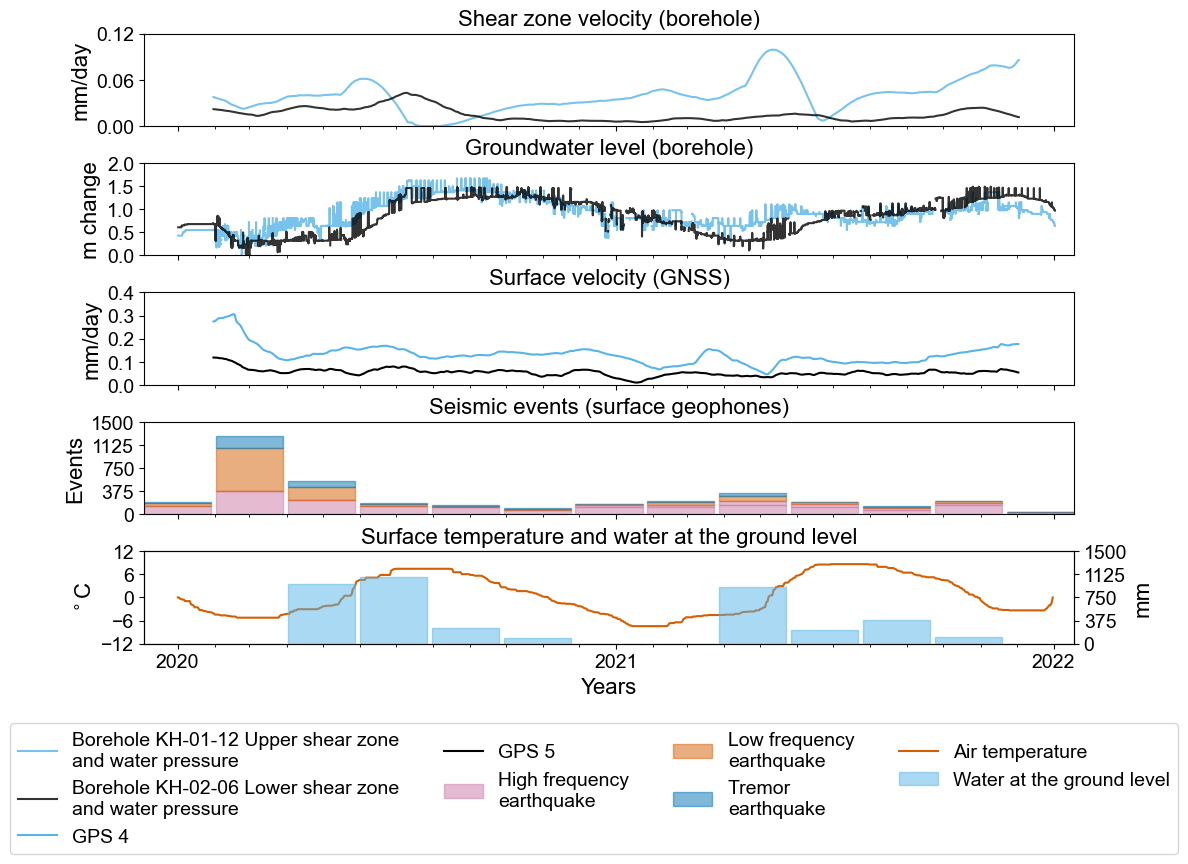

In [117]:
## ZOOMED FIGURE 4 for the SI

from matplotlib.dates import DateFormatter

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

# plotting

ncols = 1
nrows = 5 # len(file['event'].unique()) // ncols + (len(file['event'].unique()) % ncols > 0)

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace = .4)


# time series length
start_time = '2020-01-01'
end_time = '2022-01-01'


file = vel1.iloc[:,-1]
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, file.values, color=colors[5], label='Borehole KH-01-12 Upper shear zone \nand water pressure', alpha=0.8)

file = vel2.iloc[:,-1]
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, file.values, color=colors[7], label='Borehole KH-02-06 Lower shear zone \nand water pressure', alpha=0.8)

# water level
n_day = 59 # days # 1 week kernel size for median filter (hourly data)
n_hour = round_up_to_odd(24*n_day) 


file3 = KH0112PiezLowerZone.copy()
watermodule = 'Mod30_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[5], label='', alpha=0.8) # Borehole KH-01-12 \nwater pressure


#loading KH0206 as it has a longer time series..
file3=KH0206PiezLowerZone.copy()
watermodule = 'Mod35_Water pressure [m]:'
file3 = file3.resample('1h').median()
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[7], label='', alpha=0.8) # Borehole KH-02-06 \nwater pressure

# #loading KH0118 as it is longer than KH0218
# file3=KH0118Piez_raw
# # watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod26_Water pressure [m]:' # seasonal oscilations
# start_t = '2020-01-01' # start time
# file3 =  file3[file3.index.slice_indexer(start_t,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n) # median filter
# ax[0].plot(file3.index, file3[watermodule].values-np.min(file3[watermodule]), color='forestgreen', label='KH0118', alpha=0.8)

# #loading KH0217 as it is longer than KH0218
# file3=KH0217PiezUpperZone_raw
# # watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations
# # start_t = '2020-01-01' # start time
# file3 =  file3[file3.index.slice_indexer(start_t,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n) # median filter
# ax[0].plot(file3.index, file3[watermodule].values-np.min(file3[watermodule]), color='violet', label='KH0217', alpha=0.8)

# GPS data

col_pos = -1 # column position 

df =  vel3
df.index = pd.to_datetime(df.index)
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[2].plot(df.index, (df.iloc[:,col_pos]), color=colors[5], label='GPS 4')

df =  vel4
df.index = pd.to_datetime(df.index)
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[2].plot(df.index, (df.iloc[:,col_pos]), color=colors[7], label='GPS 5')

# df =  vel5
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[2].plot(df.index, (df.iloc[:,col_pos]), color=colors[2], label='GPS 6')

# df =  gps10
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='yellow', label='GPS 10')

# df =  gps11
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='brown', label='GPS 11')

# seismic data
# seismicity_sub =  seismicity_qcd[(seismicity_qcd.index > start_time) & (seismicity_qcd.index < end_time)]
seismicity_sub =  seismicity[(seismicity.index > start_time) & (seismicity.index < end_time)]
seismicity_sub = seismicity_sub.resample(f'{n}d').sum()

# stacking types
bar1 = seismicity_sub['Slope_HF_nEvents']
bar2 = seismicity_sub['Slope_Multi_nEvents']
bar3 = seismicity_sub['Slope_LF_nEvents']
bar4 = seismicity_sub['Slope_Tremor_nEvents']

width = 55/59*n

ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_HF_nEvents'], width = width, color=colors[0], ec=colors[0], label='High frequency \nearthquake', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_Multi_nEvents'], width = width, color=colors[0], ec=colors[0], bottom=bar1, label='', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_LF_nEvents'], width = width, color=colors[1], ec=colors[1], bottom=bar1+bar2, label='Low frequency \nearthquake', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_Tremor_nEvents'], width = width, color=colors[2], ec=colors[2], bottom=bar1+bar2+bar3, label='Tremor \nearthquake', alpha=0.5)

width = 55/59*n
# temp_sub =  temp[(temp.index > start_time) & (temp.index < end_time)] # data per day
temp_sub = temp[temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
temp_sub.iloc[:,0] = medfilt(temp_sub.iloc[:,0], kernel_size=n_day)

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
snowrain_melt_sub =  snowrain_melt[snowrain_melt.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
snowrain_melt_sub = snowrain_melt_sub.resample(f'{n}d').sum()

ax[4].plot(temp_sub.index, temp_sub['temperature'], color=colors[1], label='Air temperature')
ax_y = ax[4].twinx()
ax_y.bar(dates.date2num(snowrain_melt_sub.index), snowrain_melt_sub['snowrain_melt'], width = width, ec=colors[5], color=colors[5], label='Water at the ground level', alpha=0.5)

# adjusting gridlines
nticks = 5
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(3))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[4].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax_y.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # number of digits
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# just to get an whole number so it looks nice
def myround(x, base=10):
    return base * round(x/base)

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(0, 0.12) # velocity

ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(0, myround(ymax, base=1)) # water level

ymin, ymax = ax[2].get_ylim()
ax[2].set_ylim(0, 0.4) # velocity

ymin, ymax = ax[3].get_ylim()
ax[3].set_ylim(0, 1500) # seismic events

ymin, ymax = ax[4].get_ylim()
ax[4].set_ylim(-12, myround(ymax, base=6)) # temp -12 bas 6 for two months, 16 and base 8 for 1 month

ymin, ymax = ax_y.get_ylim()
ax_y.set_ylim(0, 1500) # available surface water, 1800 for two months, 1000 for 1 month

ax[0].title.set_text('Shear zone velocity (borehole)')
ax[1].title.set_text('Groundwater level (borehole)')
ax[2].title.set_text('Surface velocity (GNSS)')
ax[3].title.set_text('Seismic events (surface geophones)')
ax[4].title.set_text('Surface temperature and water at the ground level')

# one legend on the right side of plots
# for i in range(5):
#     box = ax[i].get_position()
#     ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height]) # shrinking axes to accomodate legend
# handles, labels = [(a + b + c + d + e + f) for a, b, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
# fig.legend(handles, labels, loc = (0.8, 0.275)) # center of fig

#legend underneath plots
handles, labels = [(a + c + d + e + f) for a, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
fig.subplots_adjust(bottom=0.27) # create space
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0.2), ncol=4) # center of fig

# set axis labels
ax[0].set_ylabel('mm/day')
ax[1].set_ylabel('m change')
ax[2].set_ylabel('mm/day')
ax[3].set_ylabel('Events') #  per 2 months
ax[4].set_ylabel('$^\circ$C')
ax_y.set_ylabel('mm') #  per 2 months
ax[4].set_xlabel('Years')

# # Ensure the first year is included
# start_year = bh_data.index.min().year
# end_year = bh_data.index.max()
# ax[4].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax[4].xaxis.set_major_locator(years)
ax[4].xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax[4].xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax[4].xaxis.set_major_formatter(years_fmt)

# # Rotate and align the tick labels so they look better
# fig.autofmt_xdate()

# # removing tick labels from the xaxis
# n = 2  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax[4].xaxis.get_ticklabels()) if i % n != 0]

# # # saving
path = 'plots\\'
save_name = f'{path}Figure2_ZoomforSI.png'
# save_name = f'{path}Figure2_A0poster.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'
fig.show()

In [3]:
KH0112DispUpperZone.head()

Displacement [mm]:  displacement_butterfilt  12_days_velocity  intercept  r^2  y_fit  residuals  error_of_fit  60_days_velocity  sta  lta  sta-lta   trigger  detrigger  nBursts
Date:                                                                                                                                                                                                
2013-11-07 10:00:00                0.00                 0.004726               NaN        NaN  NaN    NaN        NaN     11.892733               NaN  NaN  NaN      NaN  0.001676   0.000822        0
2013-11-07 11:00:00                0.00                 0.018272               NaN        NaN  NaN    NaN        NaN     11.892733               NaN  NaN  NaN      NaN  0.001676   0.000822        0
2013-11-07 12:00:00                0.04                 0.031330               NaN        NaN  NaN    NaN        NaN     11.892733               NaN  NaN  NaN      NaN  0.001676   0.000822        0
2013-11-07 13:00:00                0.00                 0.043733               NaN        NaN  NaN    NaN        NaN     11.892733               NaN  NaN  NaN      NaN  0.001676   0.000822        0
2013-11-07 14:00:00                0.00                 0.055236               NaN        NaN  NaN    NaN        NaN     11.892733               NaN  NaN  NaN      NaN  0.001676   0.000822        0

C:\Users\andregas\AppData\Local\Temp\ipykernel_20612\721758913.py:239: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


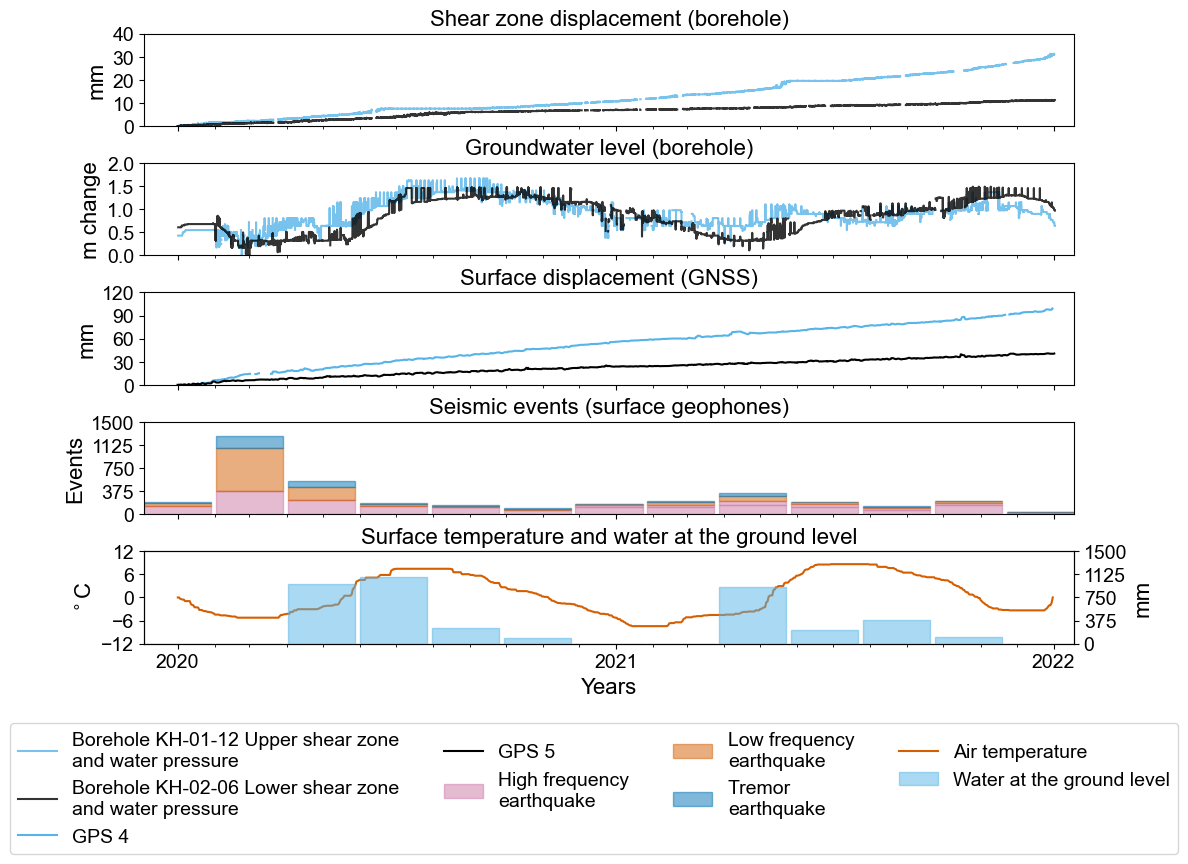

In [30]:
## ZOOMED FIGURE 4 for the SI

from matplotlib.dates import DateFormatter

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

n = 60

# plotting

ncols = 1
nrows = 5 # len(file['event'].unique()) // ncols + (len(file['event'].unique()) % ncols > 0)

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace = .4)


# time series length
start_time = '2020-01-01'
end_time = '2022-01-01'


file =  KH0112DispUpperZone[KH0112DispUpperZone.index.slice_indexer(start_time,end_time)]

file = file.iloc[:,0]
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, file.values-file.values[0], color=colors[5], label='Borehole KH-01-12 Upper shear zone \nand water pressure', alpha=0.8)


file =  KH0206DispLowerZone[KH0206DispLowerZone.index.slice_indexer(start_time,end_time)]
file = file.iloc[:,0]
file = file.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(file.index, file.values-file.values[0], color=colors[7], label='Borehole KH-02-06 Lower shear zone \nand water pressure', alpha=0.8)

# water level
n_day = 59 # days # 1 week kernel size for median filter (hourly data)
n_hour = round_up_to_odd(24*n_day) 


file3 = KH0112PiezLowerZone.copy()
watermodule = 'Mod30_Water pressure [m]:'
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[5], label='', alpha=0.8) # Borehole KH-01-12 \nwater pressure


#loading KH0206 as it has a longer time series..
file3=KH0206PiezLowerZone.copy()
watermodule = 'Mod35_Water pressure [m]:'
file3 = file3.resample('1h').median()
file3 =  file3[file3.index.slice_indexer(start_time,end_time)]
file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n_hour) # median filter
file3 = file3[watermodule]
# file3 = file3[file3.first_valid_index():]
file3 = file3.replace(0,np.nan) # get 0 values from resmaple for some reason
file3 = file3.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(file3.index, file3.values-np.nanmin(file3.values), color=colors[7], label='', alpha=0.8) # Borehole KH-02-06 \nwater pressure

# #loading KH0118 as it is longer than KH0218
# file3=KH0118Piez_raw
# # watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod26_Water pressure [m]:' # seasonal oscilations
# start_t = '2020-01-01' # start time
# file3 =  file3[file3.index.slice_indexer(start_t,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n) # median filter
# ax[0].plot(file3.index, file3[watermodule].values-np.min(file3[watermodule]), color='forestgreen', label='KH0118', alpha=0.8)

# #loading KH0217 as it is longer than KH0218
# file3=KH0217PiezUpperZone_raw
# # watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations
# # start_t = '2020-01-01' # start time
# file3 =  file3[file3.index.slice_indexer(start_t,end_time)]
# file3.loc[:,watermodule] = medfilt(file3.loc[:,watermodule], kernel_size=n) # median filter
# ax[0].plot(file3.index, file3[watermodule].values-np.min(file3[watermodule]), color='violet', label='KH0217', alpha=0.8)

# GPS data


col_pos = 5 # column position, 2d 

df = gps4[gps4.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
zero = df.dropna()
zero = zero.loc[zero.first_valid_index(),'2d'] # NB!! anoying but important to change if not col 5 !!
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[2].plot(df.index, (df.iloc[:,col_pos]-zero), color=colors[5], label='GPS 4')

df = gps5[gps5.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[2].plot(df.index, (df.iloc[:,col_pos]-df.iloc[0,col_pos]), color=colors[7], label='GPS 5')

# df =  vel5
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[2].plot(df.index, (df.iloc[:,col_pos]), color=colors[2], label='GPS 6')

# df =  gps10
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='yellow', label='GPS 10')

# df =  gps11
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[1].plot(df.index, (df[data]), color='brown', label='GPS 11')

# seismic data
# seismicity_sub =  seismicity_qcd[(seismicity_qcd.index > start_time) & (seismicity_qcd.index < end_time)]
seismicity_sub =  seismicity[(seismicity.index > start_time) & (seismicity.index < end_time)]
seismicity_sub = seismicity_sub.resample(f'{n}d').sum()

# stacking types
bar1 = seismicity_sub['Slope_HF_nEvents']
bar2 = seismicity_sub['Slope_Multi_nEvents']
bar3 = seismicity_sub['Slope_LF_nEvents']
bar4 = seismicity_sub['Slope_Tremor_nEvents']

width = 55/59*n

ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_HF_nEvents'], width = width, color=colors[0], ec=colors[0], label='High frequency \nearthquake', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_Multi_nEvents'], width = width, color=colors[0], ec=colors[0], bottom=bar1, label='', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_LF_nEvents'], width = width, color=colors[1], ec=colors[1], bottom=bar1+bar2, label='Low frequency \nearthquake', alpha=0.5)
ax[3].bar(dates.date2num(seismicity_sub.index), seismicity_sub['Slope_Tremor_nEvents'], width = width, color=colors[2], ec=colors[2], bottom=bar1+bar2+bar3, label='Tremor \nearthquake', alpha=0.5)

width = 55/59*n
# temp_sub =  temp[(temp.index > start_time) & (temp.index < end_time)] # data per day
temp_sub = temp[temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
temp_sub.iloc[:,0] = medfilt(temp_sub.iloc[:,0], kernel_size=n_day)

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
snowrain_melt_sub =  snowrain_melt[snowrain_melt.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
snowrain_melt_sub = snowrain_melt_sub.resample(f'{n}d').sum()

ax[4].plot(temp_sub.index, temp_sub['temperature'], color=colors[1], label='Air temperature')
ax_y = ax[4].twinx()
ax_y.bar(dates.date2num(snowrain_melt_sub.index), snowrain_melt_sub['snowrain_melt'], width = width, ec=colors[5], color=colors[5], label='Water at the ground level', alpha=0.5)

# adjusting gridlines
nticks = 5
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax[4].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))
ax_y.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(5))

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.0f')) # number of digits
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# just to get an whole number so it looks nice
def myround(x, base=10):
    return base * round(x/base)

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(0, 40) # velocity

ymin, ymax = ax[1].get_ylim()
ax[1].set_ylim(0, myround(ymax, base=1)) # water level

ymin, ymax = ax[2].get_ylim()
ax[2].set_ylim(0, 120) # velocity

ymin, ymax = ax[3].get_ylim()
ax[3].set_ylim(0, 1500) # seismic events

ymin, ymax = ax[4].get_ylim()
ax[4].set_ylim(-12, myround(ymax, base=6)) # temp -12 bas 6 for two months, 16 and base 8 for 1 month

ymin, ymax = ax_y.get_ylim()
ax_y.set_ylim(0, 1500) # available surface water, 1800 for two months, 1000 for 1 month

ax[0].title.set_text('Shear zone displacement (borehole)')
ax[1].title.set_text('Groundwater level (borehole)')
ax[2].title.set_text('Surface displacement (GNSS)')
ax[3].title.set_text('Seismic events (surface geophones)')
ax[4].title.set_text('Surface temperature and water at the ground level')

# one legend on the right side of plots
# for i in range(5):
#     box = ax[i].get_position()
#     ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height]) # shrinking axes to accomodate legend
# handles, labels = [(a + b + c + d + e + f) for a, b, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
# fig.legend(handles, labels, loc = (0.8, 0.275)) # center of fig

#legend underneath plots
handles, labels = [(a + c + d + e + f) for a, c, d, e, f in zip(ax[0].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),ax[4].get_legend_handles_labels(),ax_y.get_legend_handles_labels())]
fig.subplots_adjust(bottom=0.27) # create space
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0.2), ncol=4) # center of fig

# set axis labels
ax[0].set_ylabel('mm')
ax[1].set_ylabel('m change')
ax[2].set_ylabel('mm')
ax[3].set_ylabel('Events') #  per 2 months
ax[4].set_ylabel('$^\circ$C')
ax_y.set_ylabel('mm') #  per 2 months
ax[4].set_xlabel('Years')

# # Ensure the first year is included
# start_year = bh_data.index.min().year
# end_year = bh_data.index.max()
# ax[4].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax[4].xaxis.set_major_locator(years)
ax[4].xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax[4].xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax[4].xaxis.set_major_formatter(years_fmt)

# # Rotate and align the tick labels so they look better
# fig.autofmt_xdate()

# # removing tick labels from the xaxis
# n = 2  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax[4].xaxis.get_ticklabels()) if i % n != 0]

# # # saving
path = 'plots\\'
save_name = f'{path}Figure2_ZoomforSI_disp.png'
# save_name = f'{path}Figure2_A0poster.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'
fig.show()

C:\Users\andregas\AppData\Local\Temp\ipykernel_15688\238474830.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


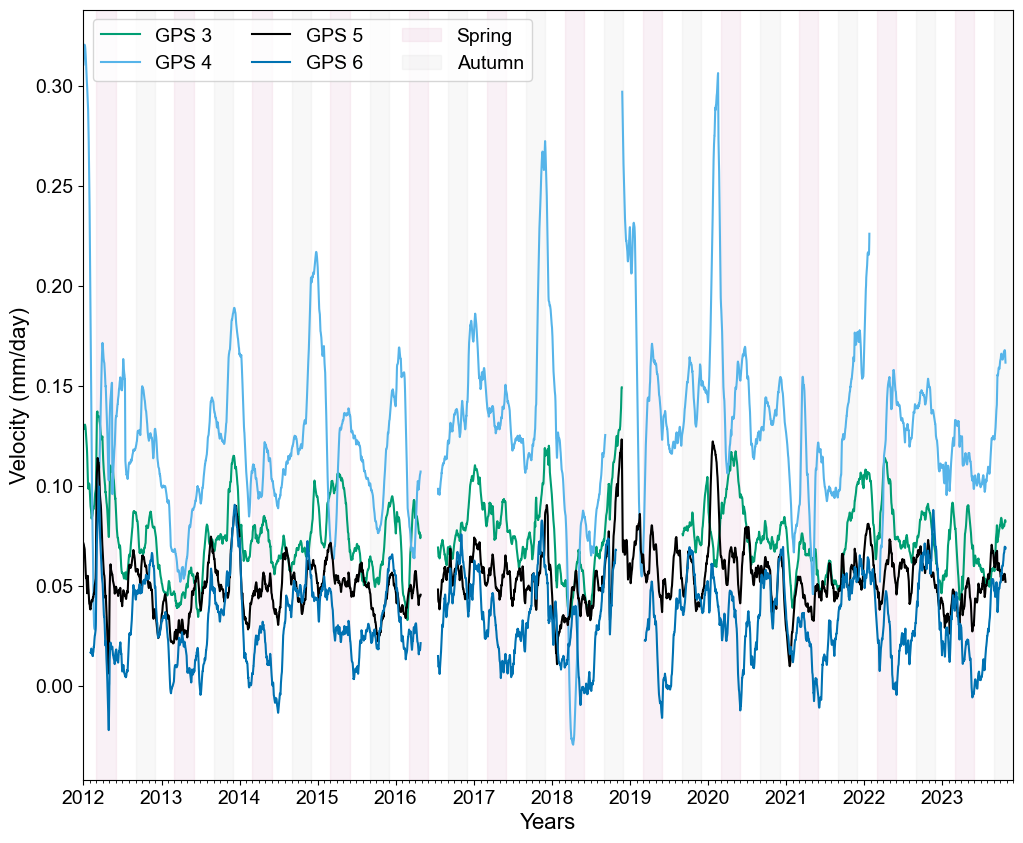

In [57]:
## Additional SI figure to convince the two peaks GNSS's

fig, ax = plt.subplots(figsize=(12, 10))

# setting time slice
start_time = pd.Timestamp('2012-01-01') # year-day-month ?
end_time = pd.Timestamp('2024-01-01') # last time when updating boreholes

# KH-02-06 same as gps5
# KH-01-12 same as gps4
# KH-02-17 same as gps4
# KH-01-18 same as gps10
# KH-02-18 same as gps11
# KH-01-17 same as gps6

data = '2d_60_days_velocity'
# data = '2d'

df =  gps3
df = df[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
start_Local = df.first_valid_index()
df =  df[df.index.slice_indexer(start_Local,end_time)]
df.index = pd.to_datetime(df.index)

df = df.replace(np.nan,np.inf) # changing nan to inf
ax.plot(df.index, (df), color=colors[4], label='GPS 3')
# print(f'gps3: {df[-1]-df[0]} mm')

df =  gps4
df = df[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
start_Local = df.first_valid_index()
df =  df[df.index.slice_indexer(start_Local,end_time)]
df.index = pd.to_datetime(df.index)

df = df.replace(np.nan,np.inf) # changing nan to inf
ax.plot(df.index, (df), color=colors[5], label='GPS 4')
# print(f'gps4: {df[-1]-df[0]} mm')

df =  gps5
df = df[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
start_Local = df.first_valid_index()
df =  df[df.index.slice_indexer(start_Local,end_time)]
df.index = pd.to_datetime(df.index)

df = df.replace(np.nan,np.inf) # changing nan to inf
ax.plot(df.index, (df), color=colors[7], label='GPS 5')
# print(f'gps5: {df[-1]-df[0]} mm')

df =  gps6
df = df[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
start_Local = df.first_valid_index()
df =  df[df.index.slice_indexer(start_Local,end_time)]
df.index = pd.to_datetime(df.index)

df = df.replace(np.nan,np.inf) # changing nan to inf
ax.plot(df.index, (df), color=colors[2], label='GPS 6')
# print(f'gps6: {df[-1]-df[0]} mm')

# df =  gps10
# df = df[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# start_Local = df.first_valid_index()
# df =  df[df.index.slice_indexer(start_Local,end_time)]
# df.index = pd.to_datetime(df.index)

# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax.plot(df.index, (df-df[0]), color='darkorange', label='GPS 10')
# print(f'gps10: {df[-1]-df[0]} mm')

# df =  gps11
# df = df[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# start_Local = df.first_valid_index()
# df =  df[df.index.slice_indexer(start_Local,end_time)]
# df.index = pd.to_datetime(df.index)

# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax.plot(df.index, (df-df[0]), color='violet', label='GPS 11')
# print(f'gps11: {df[-1]-df[0]} mm')

ax.legend(loc = 'upper right', ncol=2)

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax.xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax.xaxis.set_major_formatter(years_fmt)

# highlight spring and autumn
num_years = int((end_time-start_time)/np.timedelta64(1,'Y')) # n years in time series
start_year = start_time.year
for i in range(num_years): 
    ax.axvspan(pd.Timestamp(f'{start_year+i}-03-01'), pd.Timestamp(f'{start_year+i}-06-01'), facecolor=colors[0], edgecolor=colors[0], label='Spring', zorder=1, alpha=0.1)
    ax.axvspan(pd.Timestamp(f'{start_year+i}-09-01'), pd.Timestamp(f'{start_year+i}-12-01'), facecolor=colors[8], edgecolor=colors[8], label='Autumn', zorder=1, alpha=0.1)

    
plt.xlabel('Years')
plt.ylabel('Velocity (mm/day)')

# legend
lines, labels = ax.get_legend_handles_labels()
lines = unique(lines)
labels = unique(labels)
ax.legend(lines, labels, loc = 'upper left', ncol=3)

# # # saving
path = 'plots\\'
save_name = f'{path}SI_seasonalGPS.png'
# save_name = f'{path}Figure2_A0poster.png'
fig.savefig(save_name, dpi=600) # , transparent=True,  bbox_inches='tight'
fig.show()

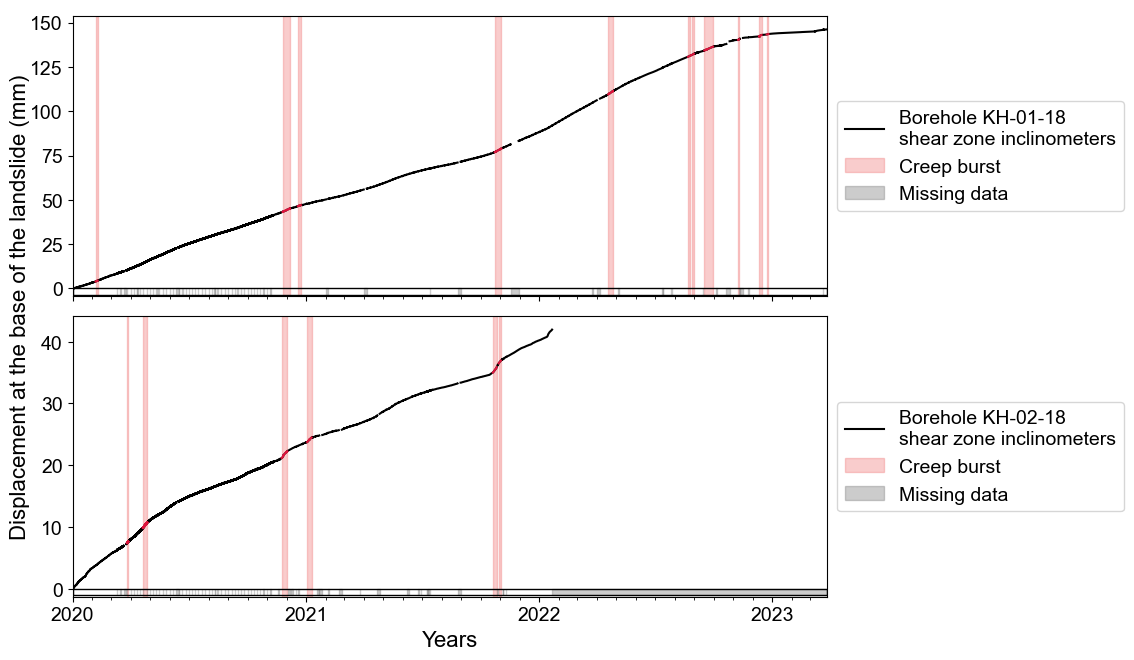

In [55]:
# Zoom on multiple events at same time
# looking at creep bursts versus water pressure

# TO DO !
# Adjust for x-axis so it is tight on both sides
# Only plot y-axis on the right edge as the y-axis is on the left
# Look through water pressures with Clara and see if I can use some of the other deeper modules to plot

from matplotlib.dates import DateFormatter

# plotting

fig, ax = plt.subplots(nrows=2, figsize=(12,7), sharex=True)
# fig.subplots_adjust(hspace=0) #fig.subplots_adjust(wspace=0) # to remove space on each side of the x-axis

#                          PLOT 1
# KH-01-18
file = []
file2 = [] # to make sure it does not come from previous plot

file = KH0118Disp_creep.copy()
file2 = KH0118Disp.copy()

zero_start = file2['displacement_butterfilt'][0] # starting from 0
df = file2.copy()
# df.loc[df['interpolated_disp'] >0] = np.inf
ax[0].plot(df.index, df['displacement_butterfilt']-zero_start, color='black', label='Borehole KH-01-18 \nshear zone inclinometers')
# df = file2.copy()
# df.loc[df['interpolated_disp'] ==np.nan] = np.inf
# ax[1].plot(df.index, df['interpolated_disp']-zero_start, color='violet', label='Interpolated displacement')

# df of start and end of bursts
window = []
previous_d = 0
for i, d in enumerate(file2['nBursts']):
    if d != previous_d:
        previous_d = d
        window.append(file2[i:i+1].index)

# Convert the list of datetime objects to a NumPy array
window = np.array([item[0] for item in window])
        
idx = np.arange(0, len(window), 2)  # index to slice at even numbers
for start in idx:
    ax[0].axvspan(window[start], window[start+1], facecolor='lightcoral', edgecolor='lightcoral', label='Creep burst', zorder=1, alpha=0.4)

df = file2.copy()
df.loc[df['nBursts'] ==0] = np.nan
df = df.replace(np.nan,np.inf) # to avoid interpolation between holes in data
ax[0].plot(df.index, df['displacement_butterfilt']-zero_start, color='crimson', label='') # I do not know if we want this coloring?

# df of missing data
df = file2['displacement_butterfilt'].copy()
df.loc[df.notna()] = 0
df.loc[df.isna()] = 1
window = []
previous_d = 0
zero_start = mpl.dates.date2num(df.index[0])
ymin_1 = -file2['displacement_butterfilt'].max()/40

for i, d in enumerate(df):
    if d != previous_d:
        previous_d = d
        window.append(df[i:i+1].index)

# Convert the list of datetime objects to a NumPy array
window = np.array([item[0] for item in window])

idx = np.arange(0, len(window), 2)  # index to slice at even numbers
for start in idx[:-1]:
    if window[start+1]-window[start] > np.timedelta64(1, 'h'): # can change to show only more than n hours..
        xmin = (mpl.dates.date2num(window[start])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
        xmax = (mpl.dates.date2num(window[start+1])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
        ax[0].axhspan(ymin=ymin_1, ymax=0, xmin=xmin, xmax=xmax, facecolor='gray', edgecolor='gray', label='Missing data', zorder=1, alpha=0.4) # zorder = what layer to plot from back to front

ax[0].axhspan(ymin=ymin_1, ymax=0, xmin=0, xmax=1, facecolor='None', edgecolor='black', label='') # edge around missing data

# Cumulated plot, not to be used as of now..
df = file.copy()
frames = []
for i in df.index:
    cb = pd.DataFrame(index=pd.date_range(file['date_start'][i], periods=len(file['date'][i].values), freq='H'))
    cb['displacement'] = df.displacement.iloc[i]
    frames.append(cb)
cb = pd.concat(frames)
cb['displacement'] = cb['displacement'].replace(0, np.nan).dropna()
velocity = cb['displacement'].shift(-1)-cb['displacement']
cb['cumulated'] = np.nancumsum(velocity) # cumulated creep bursts
# ax[1].plot(cb.index, cb['cumulated'], color='crimson', label='Cumulated creep bursts')
df = file2.copy()
df.loc[df['nBursts'] ==1] = np.nan
velocity = df['displacement_butterfilt'].shift(-1)-df['displacement_butterfilt']
df['cumulated'] = np.nancumsum(velocity) # cumulated disp w/o creep burst
# ax[1].plot(df.index, df['cumulated'], color='black', label='Displacement w/o bursts')

cb_of_totaldisp = (cb['cumulated'][-1]/df['cumulated'][-1])*100
# ax[0].text(pd.Timestamp('2020-02-05'), 90, f'Creep bursts contribute to {cb_of_totaldisp:.1f} % of total displacement' , horizontalalignment='left', size='medium', color='black', fontsize=medium_size)



#                              PLOT 2
# KH-02-18
file = KH0218Disp_creep.copy()
file2 = KH0218Disp.copy()
file3 = KH0218Piez.copy()
# watermodule = 'Mod134_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod134_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod27_Water pressure [m]:' # seasonal oscilations
n = 29 # kernel size (4 weeks)
file3[watermodule] = medfilt(file3[watermodule], kernel_size=n) # median filter

zero_start = file2['displacement_butterfilt'][0] # starting from 0
df = file2.copy()
df1 = KH0118Disp['displacement_butterfilt'].copy() # this part is done to make the shared x-axis work
df1 =  df1[df1.index.slice_indexer(df.index[-1],df1.index[-1])] 
df1.values[:] = np.nan
df = pd.concat([df, df1])
ax[1].plot(df.index, df['displacement_butterfilt']-zero_start, color='black', label='Borehole KH-02-18 \nshear zone inclinometers')
df = file2.copy()

# making the cumulated plot possible
df = file.copy()
frames = []
for i in df.index:
    cb = pd.DataFrame(index=pd.date_range(file['date_start'][i], periods=len(file['date'][i].values), freq='H'))
    cb['displacement'] = df.displacement.iloc[i]
    frames.append(cb)
cb = pd.concat(frames)
cb['displacement'] = cb['displacement'].replace(0, np.nan).dropna()
velocity = cb['displacement'].shift(-1)-cb['displacement']
cb['cumulated'] = np.nancumsum(velocity)

# df of start and end of bursts
window = []
previous_d = 0
for i, d in enumerate(file2['nBursts']):
    if d != previous_d:
        previous_d = d
        window.append(file2[i:i+1].index)
        
# Convert the list of datetime objects to a NumPy array
window = np.array([item[0] for item in window])

idx = np.arange(0, len(window), 2)  # index to slice at even numbers
for start in idx:
    ax[1].axvspan(window[start], window[start+1], facecolor='lightcoral', edgecolor='lightcoral', label='Creep burst', zorder=1, alpha=0.4)

df = file2.copy()
df.loc[df['nBursts'] ==0] = np.nan
df = df.replace(np.nan,np.inf) # to avoid interpolation between holes in data
ax[1].plot(df.index, df['displacement_butterfilt']-zero_start, color='crimson', label='') # I do not know if we want this coloring?

# df of missing data
df = file2['displacement_butterfilt']
df = file2['displacement_butterfilt'].copy()
df.loc[df.notna()] = 0
df.loc[df.isna()] = 1
df1 = KH0118Disp['displacement_butterfilt'].copy() # to get dataset for entire plot window as KH0118 is longer than KH0218
df1 =  df1[df1.index.slice_indexer(df.index[-1],df1.index[-1])]
df1.values[:] = 1
df = pd.concat([df, df1])
df.values[-2] = 0 # force it to plot missing data due to the change in value for loop I have. -2 due to skiping last idx to be able to difference window length of missing data
window = []
previous_d = 0
zero_start = mpl.dates.date2num(df.index[0])
ymin_2 = -file2['displacement_butterfilt'].max()/40

for i, d in enumerate(df):
    if d != previous_d:
        previous_d = d
        window.append(df[i:i+1].index)
        
# Convert the list of datetime objects to a NumPy array
window = np.array([item[0] for item in window])

idx = np.arange(0, len(window), 2)  # index to slice at even numbers
for start in idx[:-1]:
    if window[start+1]-window[start] > np.timedelta64(1, 'h'): # can change to show only more than n hours..
        xmin = (mpl.dates.date2num(window[start])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
        xmax = (mpl.dates.date2num(window[start+1])-zero_start)/(mpl.dates.date2num(df.index[-1])-zero_start)
        ax[1].axhspan(ymin=ymin_2, ymax=0, xmin=xmin, xmax=xmax, facecolor='gray', edgecolor='gray', label='Missing data', zorder=1, alpha=0.4) # zorder = what layer to plot from back to front

ax[1].axhspan(ymin=ymin_2, ymax=0, xmin=0, xmax=1, facecolor='None', edgecolor='black', label='') # edge around missing data
        
# Cumulated plot, not to be used as of now..
df = file.copy()
frames = []
for i in df.index:
    cb = pd.DataFrame(index=pd.date_range(file['date_start'][i], periods=len(file['date'][i].values), freq='H'))
    cb['displacement'] = df.displacement.iloc[i]
    frames.append(cb)
cb = pd.concat(frames)
cb['displacement'] = cb['displacement'].replace(0, np.nan).dropna()
velocity = cb['displacement'].shift(-1)-cb['displacement']
cb['cumulated'] = np.nancumsum(velocity) # cumulated creep bursts
# ax[1].plot(cb.index, cb['cumulated'], color='crimson', label='Cumulated creep bursts')
df = file2.copy()
df.loc[df['nBursts'] ==1] = np.nan
velocity = df['displacement_butterfilt'].shift(-1)-df['displacement_butterfilt']
df['cumulated'] = np.nancumsum(velocity) # cumulated disp w/o creep burst
# ax[1].plot(df.index, df['cumulated'], color='black', label='Displacement w/o bursts')

cb_of_totaldisp = (cb['cumulated'][-1]/df['cumulated'][-1])*100
# ax[1].text(pd.Timestamp('2020-02-05'), 27, f'Creep bursts contribute to {cb_of_totaldisp:.1f} % of total displacement' , horizontalalignment='left', size='medium', color='black', fontsize=medium_size)

# ax[0].set_title('Displacement at the base of the landslide')

adj = 1.2 # adjustment
ym, ymax = ax[0].get_ylim()
ax[0].set_ylim(ymin_1*adj,ymax)
ym, ymax = ax[1].get_ylim()
ax[1].set_ylim(ymin_2*adj,ymax)

# set axis labels
# ax[0].set_ylabel('mm')
# ax[0].set_ylabel('Displacement at the base of the landslide (mm)')
lines, labels = ax[0].get_legend_handles_labels()
lines = unique(lines)
labels = unique(labels)
ax[0].legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))
leg = ax[0].get_legend() # gets legend handels
leg.legend_handles[-1].set_color('gray')

# ax[1].set_ylabel('mm')
lines, labels = ax[1].get_legend_handles_labels()
lines = unique(lines)
labels = unique(labels)
ax[1].legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))
leg = ax[1].get_legend() # gets legend handels
leg.legend_handles[-1].set_color('gray')

# ax[1].set_xlabel('Time (months)')

axs = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Years')
plt.ylabel('Displacement at the base of the landslide (mm)')


# Ensure the first year is included
start_year = KH0118Disp.index.min().year
end_year = KH0118Disp.index.max()
ax[1].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax[1].xaxis.set_major_locator(years)
ax[1].xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax[1].xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax[1].xaxis.set_major_formatter(years_fmt)

# # removing tick labels from the xaxis
# n = 2  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax[1].xaxis.get_ticklabels()) if i % n != 0]

fig.tight_layout()
plt.show()

# saving
path = 'plots/'
save_name = f'{path}Figure3.png'
fig.savefig(save_name, dpi=600)

In [50]:
df.head()

Disp_summed [mm]:  displacement_butterfilt  4_days_velocity  intercept  r^2  y_fit  residuals  error_of_fit  60_days_velocity  sta  lta  sta-lta   trigger  detrigger  nBursts  cumulated
Date:                                                                                                                                                                                                         
2020-01-01 01:00:00               2.11                 2.109146              NaN        NaN  NaN    NaN        NaN      2.653327               NaN  NaN  NaN      NaN  0.001252   0.000616      0.0   0.006246
2020-01-01 02:00:00               2.12                 2.115392              NaN        NaN  NaN    NaN        NaN      2.653327               NaN  NaN  NaN      NaN  0.001252   0.000616      0.0   0.012343
2020-01-01 03:00:00               2.15                 2.121489              NaN        NaN  NaN    NaN        NaN      2.653327               NaN  NaN  NaN      NaN  0.001252   0.000616      0.0   0.018139
2020-01-01 04:00:00               2.14                 2.127285              NaN        NaN  NaN    NaN        NaN      2.653327               NaN  NaN  NaN      NaN  0.001252   0.000616      0.0   0.023551
2020-01-01 05:00:00               2.12                 2.132697              NaN        NaN  NaN    NaN        NaN      2.653327               NaN  NaN  NaN      NaN  0.001252   0.000616      0.0   0.028546

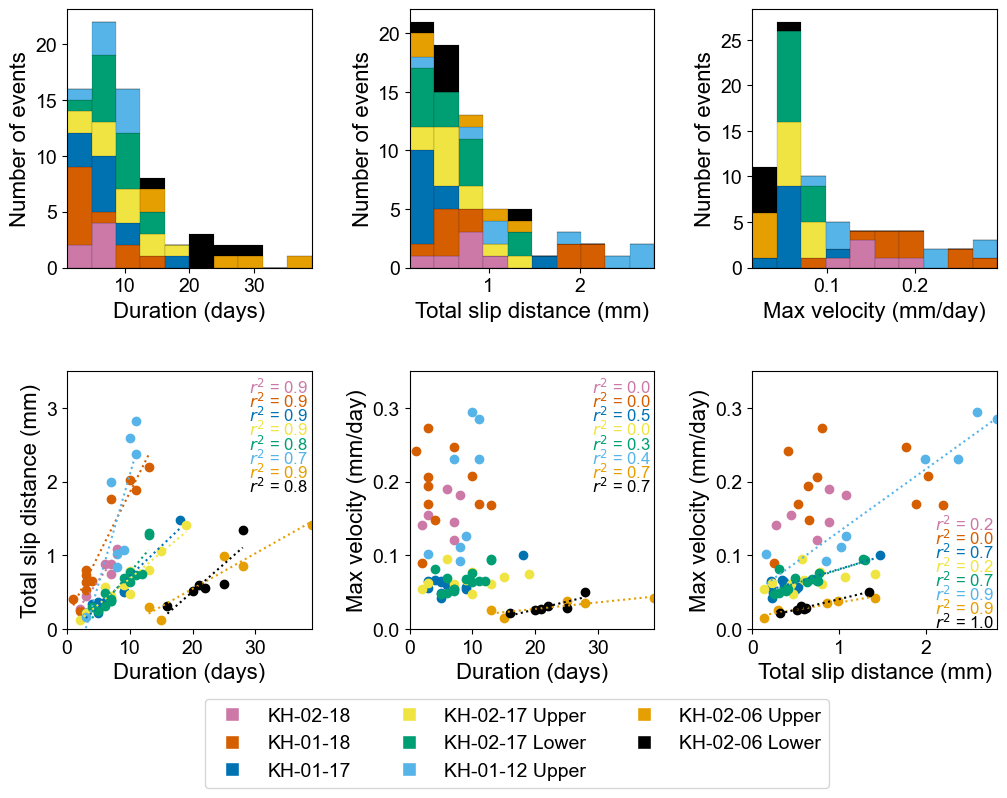

In [12]:
# getting same time for all dfs
start_time = '2020-01-01'
end_time = '2024-01-01'

KH0112DispUpperZone_creep.set_index('date_start', inplace=True, drop=True)
KH0112DispUpperZone_creep =  KH0112DispUpperZone_creep[KH0112DispUpperZone_creep.index.slice_indexer(start_time,end_time)] # subsetting time
KH0112DispUpperZone_creep.reset_index(inplace=True)

KH0112DispLowerZone_creep.set_index('date_start', inplace=True, drop=True)
KH0112DispLowerZone_creep =  KH0112DispLowerZone_creep[KH0112DispLowerZone_creep.index.slice_indexer(start_time,end_time)] # subsetting time
KH0112DispLowerZone_creep.reset_index(inplace=True)

KH0206DispUpperZone_creep.set_index('date_start', inplace=True, drop=True)
KH0206DispUpperZone_creep =  KH0206DispUpperZone_creep[KH0206DispUpperZone_creep.index.slice_indexer(start_time,end_time)] # subsetting time
KH0206DispUpperZone_creep.reset_index(inplace=True)

KH0206DispLowerZone_creep.set_index('date_start', inplace=True, drop=True)
KH0206DispLowerZone_creep =  KH0206DispLowerZone_creep[KH0206DispLowerZone_creep.index.slice_indexer(start_time,end_time)] # subsetting time
KH0206DispLowerZone_creep.reset_index(inplace=True)

data1 = 'duration_days'
data2 = 'total_slip_distance'
durdays = [KH0218Disp_creep[data1],KH0118Disp_creep[data1],KH0117Disp_creep[data1],KH0217DispUpperZone_creep[data1],KH0217DispLowerZone_creep[data1],KH0112DispUpperZone_creep[data1],
           KH0206DispUpperZone_creep[data1],KH0206DispLowerZone_creep[data1]] # KH0112DispLowerZone_creep[data1],
totslip = [KH0218Disp_creep[data2],KH0118Disp_creep[data2],KH0117Disp_creep[data2],KH0217DispUpperZone_creep[data2],KH0217DispLowerZone_creep[data2],KH0112DispUpperZone_creep[data2],
           KH0206DispUpperZone_creep[data2],KH0206DispLowerZone_creep[data2]] # KH0112DispLowerZone_creep[data2],
data2 = 'max_velocity'
maxvel = [KH0218Disp_creep[data2],KH0118Disp_creep[data2],KH0117Disp_creep[data2],KH0217DispUpperZone_creep[data2],KH0217DispLowerZone_creep[data2],KH0112DispUpperZone_creep[data2],
          KH0206DispUpperZone_creep[data2],KH0206DispLowerZone_creep[data2]] # KH0112DispLowerZone_creep[data2],

name = ['KH0218','KH0118','KH0117','KH0217Upper','KH0217Lower','KH0112Upper','KH0112Lower','KH0206Upper', 'KH0206Lower']

# df = pd.DataFrame(
#     {'Borehole': name,
#      'duration_days': durdays,
#      'total_slip_distance': totslip,
#      'max_velocity': maxvel
#     })

# plotting
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,10))
fig.subplots_adjust(hspace = .4)
fig.subplots_adjust(wspace = .4)

KH0218 = 'KH-02-18'
KH0118 = 'KH-01-18'
KH0117 = 'KH-01-17'
KH0217Lower = 'KH-02-17 Lower'
KH0217Upper = 'KH-02-17 Upper'
KH0112Lower = 'KH-01-12 Lower'
KH0112Upper = 'KH-01-12 Upper'
KH0206Lower = 'KH-02-06 Lower'
KH0206Upper = 'KH-02-06 Upper'

#upper histograms

df = pd.concat(durdays,axis=1)
# bins = np.linspace(0,40,20) # every two days, max is 39 days ## max(df.max().values)
# init = np.zeros(len(df),dtype=int) # initializing
# for i,d in enumerate(df):
#     current = df.iloc[:,i].values
#     ax[0,0].hist(current, bins, histtype='bar', color=colors[i], alpha=1, label=name[i], linewidth=0.1) 
#     init = init + current
ax[0,0].hist(df, histtype='bar', color=colors[0:8], label=name, stacked=True, linewidth=0.1, edgecolor='black') # this seems to work best
ax[0,0].set_xlabel('Duration (days)')
ax[0,0].set_ylabel('Number of events')

df = pd.concat(totslip,axis=1)
# bins = np.linspace(0,3,30) ## max(df.max().values)
# init = np.zeros(len(df),dtype=int) # initializing
# for i,d in enumerate(df):
#     current = df.iloc[:,i].values
#     ax[0,1].hist(current, bins=bins, color=colors[i], alpha=1, label=name[i], linewidth=0.1) 
#     init = init + current
ax[0,1].hist(df, histtype='bar', color=colors[0:8], label=name, stacked=True, linewidth=0.1, edgecolor='black')
ax[0,1].set_xlabel('Total slip distance (mm)')
ax[0,1].set_ylabel('Number of events')
    
df = pd.concat(maxvel,axis=1)
# bins = np.linspace(0,0.3,30) ### max(df.max().values)
# init = np.zeros(len(df),dtype=int) # initializing
# for i,d in enumerate(df):
#     current = df.iloc[:,i].values
#     ax[0,2].hist(current, bins=bins, color=colors[i], alpha=1, label=name[i], linewidth=0.1) 
#     init = init + current
ax[0,2].hist(df, histtype='bar', color=colors[0:8], label=name, stacked=True, linewidth=0.1, edgecolor='black')
ax[0,2].set_xlabel('Max velocity (mm/day)')
ax[0,2].set_ylabel('Number of events')

# lower scatter plots
ax[1,0].scatter(KH0218Disp_creep['duration_days'], KH0218Disp_creep['total_slip_distance'], color=colors[0], label=KH0218)
ax[1,0].scatter(KH0118Disp_creep['duration_days'], KH0118Disp_creep['total_slip_distance'], color=colors[1], label=KH0118)
ax[1,0].scatter(KH0117Disp_creep['duration_days'], KH0117Disp_creep['total_slip_distance'], color=colors[2], label=KH0117)
ax[1,0].scatter(KH0217DispUpperZone_creep['duration_days'], KH0217DispUpperZone_creep['total_slip_distance'], color=colors[3], label=KH0217Upper)
ax[1,0].scatter(KH0217DispLowerZone_creep['duration_days'], KH0217DispLowerZone_creep['total_slip_distance'], color=colors[4], label=KH0217Lower)
ax[1,0].scatter(KH0112DispUpperZone_creep['duration_days'], KH0112DispUpperZone_creep['total_slip_distance'], color=colors[5], label=KH0112Upper)
# ax[1,0].scatter(KH0112DispLowerZone_creep['duration_days'], KH0112DispLowerZone_creep['total_slip_distance'], color=colors[6], label=KH0112Lower)
ax[1,0].scatter(KH0206DispUpperZone_creep['duration_days'], KH0206DispUpperZone_creep['total_slip_distance'], color=colors[6], label=KH0206Upper)
ax[1,0].scatter(KH0206DispLowerZone_creep['duration_days'], KH0206DispLowerZone_creep['total_slip_distance'], color=colors[7], label=KH0206Lower)
ax[1,0].set_xlabel('Duration (days)')
ax[1,0].set_ylabel('Total slip distance (mm)')

# line fit and r-squared
small_size = 12 # changing font to acomodate space
linestyle = 'dotted'
y_start = 3.2 # position along y-axis
x_start = 29 # position along x-axis
step = 0.19
steps = np.arange(0, step*8, step)
axs = ax[1,0] # set axis
data_x = 'duration_days'
data_y = 'total_slip_distance'

x = KH0218Disp_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0218Disp_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[0], linestyle=linestyle)
axs.text(x_start, y_start, '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[0], fontsize=small_size) # , size='small'

x = KH0118Disp_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0118Disp_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[1], linestyle=linestyle)
axs.text(x_start, y_start-steps[1], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[1], fontsize=small_size)

x = KH0117Disp_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0117Disp_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[2], linestyle=linestyle)
axs.text(x_start, y_start-steps[2], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[2], fontsize=small_size)

x = KH0217DispUpperZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0217DispUpperZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[3], linestyle=linestyle)
axs.text(x_start, y_start-steps[3], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[3], fontsize=small_size)

x = KH0217DispLowerZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0217DispLowerZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[4], linestyle=linestyle)
axs.text(x_start, y_start-steps[4], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[4], fontsize=small_size)

x = KH0112DispUpperZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0112DispUpperZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[5], linestyle=linestyle)
axs.text(x_start,y_start-steps[5], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[5], fontsize=small_size)

# x = KH0112DispLowerZone_creep[data_x]
# X = x.values.reshape(-1, 1)
# y = KH0112DispLowerZone_creep[data_y].values
# model = LinearRegression() #initiate linear regression model
# model.fit(X, y) #fit regression model
# x_vals = x.values
# y_vals = np.float(model.intercept_) + np.float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='violet', linestyle=linestyle)
# axs.text(x_start, y_start-steps[6], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', size='small', color='violet', fontsize=small_size)

x = KH0206DispUpperZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0206DispUpperZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[6], linestyle=linestyle)
axs.text(x_start, y_start-steps[6], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[6], fontsize=small_size)

x = KH0206DispLowerZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0206DispLowerZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[7], linestyle=linestyle)
axs.text(x_start, y_start-steps[7], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[7], fontsize=small_size)

# nticks = 5
# ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
# ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax_y.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
# ax_y.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax[1,1].scatter(KH0218Disp_creep['duration_days'], KH0218Disp_creep['max_velocity'], color=colors[0], label=KH0218)
ax[1,1].scatter(KH0118Disp_creep['duration_days'], KH0118Disp_creep['max_velocity'], color=colors[1], label=KH0118)
ax[1,1].scatter(KH0117Disp_creep['duration_days'], KH0117Disp_creep['max_velocity'], color=colors[2], label=KH0117)
ax[1,1].scatter(KH0217DispUpperZone_creep['duration_days'], KH0217DispUpperZone_creep['max_velocity'], color=colors[3], label=KH0217Upper)
ax[1,1].scatter(KH0217DispLowerZone_creep['duration_days'], KH0217DispLowerZone_creep['max_velocity'], color=colors[4], label=KH0217Lower)
ax[1,1].scatter(KH0112DispUpperZone_creep['duration_days'], KH0112DispUpperZone_creep['max_velocity'], color=colors[5], label=KH0112Upper)
# ax[1,1].scatter(KH0112DispLowerZone_creep['duration_days'], KH0112DispLowerZone_creep['max_velocity'], color=colors[6], label=KH0112Lower)
ax[1,1].scatter(KH0206DispUpperZone_creep['duration_days'], KH0206DispUpperZone_creep['max_velocity'], color=colors[6], label=KH0206Upper)
ax[1,1].scatter(KH0206DispLowerZone_creep['duration_days'], KH0206DispLowerZone_creep['max_velocity'], color=colors[7], label=KH0206Lower)
ax[1,1].set_xlabel('Duration (days)')
ax[1,1].set_ylabel('Max velocity (mm/day)')

# line fit and r-squared
small_size = 12 # changing font to acomodate space
linestyle = 'dotted'
y_start = 0.32 # position along y-axis
x_start = 29 # position along x-axis
step = 0.019
steps = np.arange(0, step*8, step)
axs = ax[1,1] # set axis
data_x = 'duration_days'
data_y = 'max_velocity'

x = KH0218Disp_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0218Disp_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='darkorange', linestyle=linestyle)
axs.text(x_start, y_start, '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[0], fontsize=small_size) # , size='small'

x = KH0118Disp_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0118Disp_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='dodgerblue', linestyle=linestyle)
axs.text(x_start, y_start-steps[1], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[1], fontsize=small_size)

x = KH0117Disp_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0117Disp_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='magenta', linestyle=linestyle)
axs.text(x_start, y_start-steps[2], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[2], fontsize=small_size)

x = KH0217DispUpperZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0217DispUpperZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='black', linestyle=linestyle)
axs.text(x_start, y_start-steps[3], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[3], fontsize=small_size)

x = KH0217DispLowerZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0217DispLowerZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='forestgreen', linestyle=linestyle)
axs.text(x_start, y_start-steps[4], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[4], fontsize=small_size)

x = KH0112DispUpperZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0112DispUpperZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='red', linestyle=linestyle)
axs.text(x_start,y_start-steps[5], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[5], fontsize=small_size)

# x = KH0112DispLowerZone_creep[data_x]
# X = x.values.reshape(-1, 1)
# y = KH0112DispLowerZone_creep[data_y].values
# model = LinearRegression() #initiate linear regression model
# model.fit(X, y) #fit regression model
# x_vals = x.values
# y_vals = np.float(model.intercept_) + np.float(model.coef_)* x_vals
# axs.plot(sorted(x_vals), sorted(y_vals), color='violet', linestyle=linestyle)
# axs.text(x_start, y_start-steps[6], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', size='small', color='violet', fontsize=small_size)

x = KH0206DispUpperZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0206DispUpperZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[6], linestyle=linestyle)
axs.text(x_start, y_start-steps[6], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[6], fontsize=small_size)

x = KH0206DispLowerZone_creep[data_x]
X = x.values.reshape(-1, 1)
y = KH0206DispLowerZone_creep[data_y].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
axs.plot(sorted(x_vals), sorted(y_vals), color=colors[7], linestyle=linestyle)
axs.text(x_start, y_start-steps[7], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[7], fontsize=small_size)

# nticks = 5
# ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
# ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax[1].set_xlim([plot_df.index[0],plot_df.index[-1]])

ax[1,2].scatter(KH0218Disp_creep['total_slip_distance'], KH0218Disp_creep['max_velocity'], color=colors[0], label=KH0218)
ax[1,2].scatter(KH0118Disp_creep['total_slip_distance'], KH0118Disp_creep['max_velocity'], color=colors[1], label=KH0118)
ax[1,2].scatter(KH0117Disp_creep['total_slip_distance'], KH0117Disp_creep['max_velocity'], color=colors[2], label=KH0117)
ax[1,2].scatter(KH0217DispUpperZone_creep['total_slip_distance'], KH0217DispUpperZone_creep['max_velocity'], color=colors[3], label=KH0217Upper)
ax[1,2].scatter(KH0217DispLowerZone_creep['total_slip_distance'], KH0217DispLowerZone_creep['max_velocity'], color=colors[4], label=KH0217Lower)
ax[1,2].scatter(KH0112DispUpperZone_creep['total_slip_distance'], KH0112DispUpperZone_creep['max_velocity'], color=colors[5], label=KH0112Upper)
# ax[1,2].scatter(KH0112DispLowerZone_creep['total_slip_distance'], KH0112DispLowerZone_creep['max_velocity'], color=colors[6], label=KH0112Lower)
ax[1,2].scatter(KH0206DispUpperZone_creep['total_slip_distance'], KH0206DispUpperZone_creep['max_velocity'], color=colors[6], label=KH0206Upper)
ax[1,2].scatter(KH0206DispLowerZone_creep['total_slip_distance'], KH0206DispLowerZone_creep['max_velocity'], color=colors[7], label=KH0206Lower)
ax[1,2].set_xlabel('Total slip distance (mm)')
ax[1,2].set_ylabel('Max velocity (mm/day)')


# line fit and r-squared
small_size = 12 # changing font to acomodate space
linestyle = 'dotted'
y_start = 0.135 # position along y-axis
x_start = 2.1 # position along x-axis
step = 0.019
steps = np.arange(0, step*8, step)

x = KH0218Disp_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0218Disp_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# ax[1,2].plot(sorted(x_vals), sorted(y_vals), color='darkorange', linestyle=linestyle)
t1 = ax[1,2].text(x_start, y_start, '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[0], fontsize=small_size) # , size='small'

x = KH0118Disp_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0118Disp_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# ax[1,2].plot(sorted(x_vals), sorted(y_vals), color='dodgerblue', linestyle=linestyle)
ax[1,2].text(x_start, y_start-steps[1], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[1], fontsize=small_size)

x = KH0117Disp_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0117Disp_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
ax[1,2].plot(sorted(x_vals), sorted(y_vals), color=colors[2], linestyle=linestyle)
ax[1,2].text(x_start, y_start-steps[2], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[2], fontsize=small_size)

x = KH0217DispUpperZone_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0217DispUpperZone_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
# ax[1,2].plot(sorted(x_vals), sorted(y_vals), color='black', linestyle=linestyle)
ax[1,2].text(x_start, y_start-steps[3], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[3], fontsize=small_size)

x = KH0217DispLowerZone_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0217DispLowerZone_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
ax[1,2].plot(sorted(x_vals), sorted(y_vals), color=colors[4], linestyle=linestyle)
ax[1,2].text(x_start, y_start-steps[4], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[4], fontsize=small_size)

x = KH0112DispUpperZone_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0112DispUpperZone_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
ax[1,2].plot(sorted(x_vals), sorted(y_vals), color=colors[5], linestyle=linestyle)
ax[1,2].text(x_start,y_start-steps[5], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[5], fontsize=small_size)

# x = KH0112DispLowerZone_creep['total_slip_distance']
# X = x.values.reshape(-1, 1)
# y = KH0112DispLowerZone_creep['max_velocity'].values
# model = LinearRegression() #initiate linear regression model
# model.fit(X, y) #fit regression model
# x_vals = x.values
# y_vals = np.float(model.intercept_) + np.float(model.coef_)* x_vals
# ax[1,2].plot(sorted(x_vals), sorted(y_vals), color='violet', linestyle=linestyle)
# ax[1,2].text(x_start, y_start-steps[6], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', size='small', color=colors[6], fontsize=small_size)

x = KH0206DispUpperZone_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0206DispUpperZone_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
ax[1,2].plot(sorted(x_vals), sorted(y_vals), color=colors[6], linestyle=linestyle)
ax[1,2].text(x_start, y_start-steps[6], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[6], fontsize=small_size)

x = KH0206DispLowerZone_creep['total_slip_distance']
X = x.values.reshape(-1, 1)
y = KH0206DispLowerZone_creep['max_velocity'].values
model = LinearRegression() #initiate linear regression model
model.fit(X, y) #fit regression model
x_vals = x.values
y_vals = float(model.intercept_) + float(model.coef_)* x_vals
ax[1,2].plot(sorted(x_vals), sorted(y_vals), color=colors[7], linestyle=linestyle)
ax[1,2].text(x_start, y_start-steps[7], '$r^2$ = {:.1f}'.format(model.score(X, y)), horizontalalignment='left', color=colors[7], fontsize=small_size)


# legend manually created
markersize = 10
marker = 's'
h_KH0218 = mlines.Line2D([], [],color='w', markerfacecolor=colors[0], marker=marker,
                          markersize=markersize, label=KH0218)
h_KH0118 = mlines.Line2D([], [], color='w', markerfacecolor=colors[1], marker=marker,
                          markersize=markersize, label=KH0118)
h_KH0117 = mlines.Line2D([], [], color='w', markerfacecolor=colors[2], marker=marker,
                          markersize=markersize, label=KH0117)
h_KH0217_upp = mlines.Line2D([], [], color='w', markerfacecolor=colors[3], marker=marker,
                          markersize=markersize, label=KH0217Upper)
h_KH0217_low = mlines.Line2D([], [], color='w', markerfacecolor=colors[4], marker=marker,
                          markersize=markersize, label=KH0217Lower)
h_KH0112_upp = mlines.Line2D([], [], color='w', markerfacecolor=colors[5], marker=marker,
                          markersize=markersize, label=KH0112Upper)
h_KH0112_low = mlines.Line2D([], [], color='w', markerfacecolor=colors[6], marker=marker,
                          markersize=markersize, label=KH0112Lower)
h_KH0206_upp = mlines.Line2D([], [], color='w', markerfacecolor=colors[6], marker=marker,
                          markersize=markersize, label=KH0206Upper)
h_KH0206_low = mlines.Line2D([], [], color='w', markerfacecolor=colors[7], marker=marker,
                          markersize=markersize, label=KH0206Lower)

fig.subplots_adjust(bottom=0.26) # create space
fig.legend(handles=[h_KH0218,h_KH0118,h_KH0117,h_KH0217_upp,h_KH0217_low,h_KH0112_upp,h_KH0206_upp,h_KH0206_low],loc='upper center', bbox_to_anchor=(0.5, 0.2), ncol=3) # h_KH0112_low,

# # fixing gap in axes
ax[1,0].set_xlim([0,max(ax[1,0].get_xlim())]) # remove space on each side of x-axis
ax[1,1].set_xlim([0,max(ax[1,1].get_xlim())]) # remove space on each side of x-axis
ax[1,2].set_xlim([0,max(ax[1,2].get_xlim())]) # remove space on each side of x-axis
ax[1,0].set_ylim([0, 3.5]) # remove space on each side of y-axis
ax[1,1].set_ylim([0, 0.35]) # remove space on each side of y-axis
ax[1,2].set_ylim([0, 0.35]) # remove space on each side of y-axis

# # # saving
path = 'plots\\'
save_name = f'{path}Figure6.png'
fig.savefig(save_name, format='png', dpi=600)

### re-creating after subsetting time for database ###
# creating creep database
KH0218Disp_creep = creep_database(KH0218Disp, STA=4)
KH0118Disp_creep = creep_database(KH0118Disp, STA=4)
KH0217DispLowerZone_creep = creep_database(KH0217DispLowerZone, STA=12)
KH0217DispUpperZone_creep = creep_database(KH0217DispUpperZone, STA=12)
KH0117Disp_creep = creep_database(KH0117Disp, STA=8)
KH0112DispLowerZone_creep = creep_database(KH0112DispLowerZone, STA=12)
KH0112DispUpperZone_creep = creep_database(KH0112DispUpperZone, STA=12)
KH0206DispUpperZone_creep = creep_database(KH0206DispUpperZone, STA=32)
KH0206DispLowerZone_creep = creep_database(KH0206DispLowerZone, STA=32)

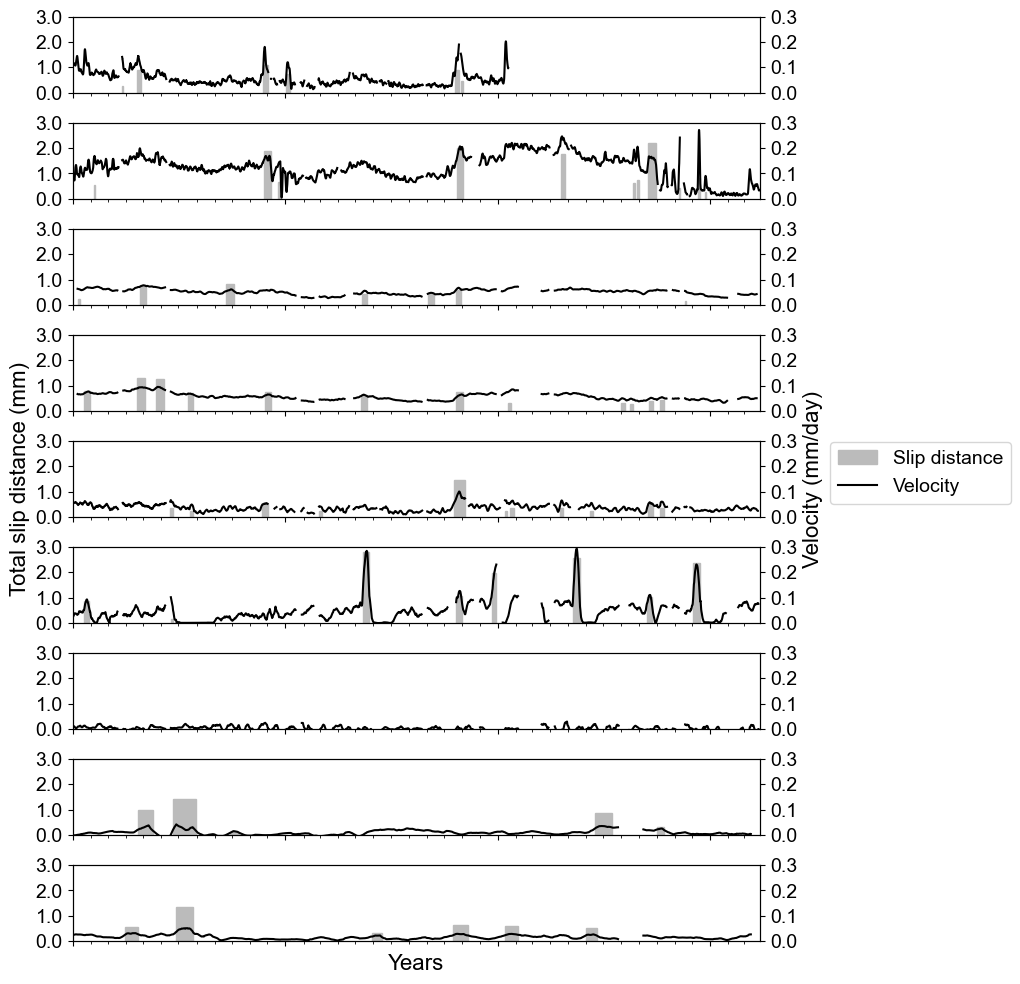

In [3]:
# Figure 7 for paper

n_rows = 9
n_cols = 1
fig, ax = plt.subplots(n_rows, ncols=n_cols, figsize=((11), (12))) # , figsize=((13), (7)) sharex=True
ax_y = [None] * n_rows # make a list for y axis

color_slipdist = colors[-1]
color_velocity = colors[-2]

fig.subplots_adjust(hspace = .4)

# setting start time for plots
start_time = np.datetime64('2020-01-01')
end_time = KH0118Disp.index[-1]
end_time_special = KH0218Disp.index[-1]

col = 2 # velocity
# col = 1 # displacement lowpass filtered


# KH0218
file = KH0218Disp_creep[KH0218Disp_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2)
    alligned_x.append(x)
ax[0].bar(alligned_x, file['total_slip_distance'], width = file['duration'].values.astype(float)/24, color=color_slipdist, ec=color_slipdist, label='Slip distance', zorder=2)
file =  KH0218Disp[KH0218Disp.index.slice_indexer(start_time,end_time_special)]
ax_y[0] = ax[0].twinx()
ax_y[0].plot(file.index, file.iloc[:,col], color=color_velocity, label='Velocity')
 

# KH0118
file = KH0118Disp_creep[KH0118Disp_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[1].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='', zorder=2)
file = KH0118Disp[KH0118Disp.index.slice_indexer(start_time,end_time)]
ax_y[1] = ax[1].twinx()
ax_y[1].plot(file.index, file.iloc[:,col], color=color_velocity, label='')

# KH0217 Upper
file = KH0217DispUpperZone_creep[KH0217DispUpperZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[2].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='KH-02-17 \nUpper zone', zorder=2)
file = KH0217DispUpperZone[KH0217DispUpperZone.index.slice_indexer(start_time,end_time)]
ax_y[2] = ax[2].twinx()
ax_y[2].plot(file.index, file.iloc[:,col], color=color_velocity, label='')

# KH0217 Lower
file = KH0217DispLowerZone_creep[KH0217DispLowerZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[3].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='KH-02-17 \nLower zone', zorder=2)
file = KH0217DispLowerZone[KH0217DispLowerZone.index.slice_indexer(start_time,end_time)]
ax_y[3] = ax[3].twinx()
ax_y[3].plot(file.index, file.iloc[:,col], color=color_velocity, label='')


# KH0117
file = KH0117Disp_creep[KH0117Disp_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[4].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='KH-01-17', zorder=2)
file = KH0117Disp[KH0117Disp.index.slice_indexer(start_time,end_time)]
ax_y[4] = ax[4].twinx()
ax_y[4].plot(file.index, file.iloc[:,col], color=color_velocity, label='')


# KH0112 Upper
file = KH0112DispUpperZone_creep[KH0112DispUpperZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[5].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='KH-01-12 \nUpper zone', zorder=2)
file = KH0112DispUpperZone[KH0112DispUpperZone.index.slice_indexer(start_time,end_time)]
ax_y[5] = ax[5].twinx()
ax_y[5].plot(file.index, file.iloc[:,col], color=color_velocity, label='')


# KH0112 Lower
file = KH0112DispLowerZone_creep[KH0112DispLowerZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[6].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='KH-01-12 \nLower zone', zorder=2)
file = KH0112DispLowerZone[KH0112DispLowerZone.index.slice_indexer(start_time,end_time)]
ax_y[6] = ax[6].twinx()
ax_y[6].plot(file.index, file.iloc[:,col], color=color_velocity, label='')


# KH0206 Upper
file = KH0206DispUpperZone_creep[KH0206DispUpperZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[7].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='KH-02-06 \nUpper zone', zorder=2) # width /24 due to each point 1 day
file = KH0206DispUpperZone[KH0206DispUpperZone.index.slice_indexer(start_time,end_time)]
ax_y[7] = ax[7].twinx()
ax_y[7].plot(file.index, file.iloc[:,col], color=color_velocity, label='')

    
# KH0206 Lower
file = KH0206DispLowerZone_creep[KH0206DispLowerZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2)
    alligned_x.append(x)
ax[8].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=color_slipdist, ec=color_slipdist, label='KH-02-06 \nLower zone', zorder=2)
file = KH0206DispLowerZone[KH0206DispLowerZone.index.slice_indexer(start_time,end_time)]
ax_y[8] = ax[8].twinx()
ax_y[8].plot(file.index, file.iloc[:,col], color=color_velocity, label='')


for i in range(n_rows):
    # adjusting gridlines
    nticks = 4
    ax[i].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_y[i].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
    ax_y[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# ax.set_title('highest number is closest to the top of borehole')
ax[8].set_xlabel('Years')
ax[4].set_ylabel('Total slip distance (mm)')
ax_y[4].set_ylabel('Velocity (mm/day)')


# creating similar y-axes
# setting y limits y-axis left (slip distance)

for i in range(n_rows):
    ymax = 0
    ymi, yma = ax[i].get_ylim()
    yma = math.ceil(yma)
    if yma > ymax:
        ymax = yma
ymin = 0
for i in range(n_rows):
    ax[i].set_ylim([ymin, 3])
    ax[i].set_xlim([start_time, end_time])

# setting y limits second left y-axis (velocity)
for i in range(n_rows):
    ymax = 0
    ymi, yma = ax_y[i].get_ylim()
#     yma = math.ceil(yma)
    if yma > ymax:
        ymax = yma
ymin = 0
for i in range(n_rows):
    ax_y[i].set_ylim([ymin, 0.3])


# # # one legend
# for i in range(n_rows):
#     box = ax[i].get_position()
#     ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height]) # shrinking axes to accomodate legend

fig.subplots_adjust(right=0.75) 
handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax_y[0].get_legend_handles_labels())]
leg = fig.legend(handles, labels, loc = 'center left', ncol=1, bbox_to_anchor=(.805,.5)) # center of fig


# removing tick labels from the xaxis
for i in range(n_rows):
    ax[i].xaxis.set_tick_params(labelbottom=False)

# removing tick labels from the xaxis
for i in range(n_rows-1):

    # Ensure the first year is included
    start_year = KH0218Disp.index.min().year
    end_year = KH0117Disp.index.max()
    ax[i].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

    # Major ticks for years
    years = mdates.YearLocator()   # Locator for every year
    years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
    ax[i].xaxis.set_major_locator(years)
    ax[i].xaxis.set_major_formatter(years_fmt)

    # Minor ticks for months
    months = mdates.MonthLocator()   # Locator for every month
    months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
    ax[i].xaxis.set_minor_locator(months)
    # Apply the year format for the major ticks again
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].set(xticklabels=[])

# Ensure the first year is included
start_year = KH0218Disp.index.min().year
end_year = KH0117Disp.index.max()
ax[n_rows-1].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax[n_rows-1].xaxis.set_major_locator(years)
ax[n_rows-1].xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax[n_rows-1].xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax[n_rows-1].xaxis.set_major_formatter(years_fmt)


# fig.tight_layout()
plt.show()

# saving
path = 'plots\\'
save_name = f'{path}Figure4.png'
fig.savefig(save_name, dpi=600)

C:\Users\andregas\AppData\Local\Temp\ipykernel_27664\3308920553.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax.append(plt.subplot(gs[i, 0]))


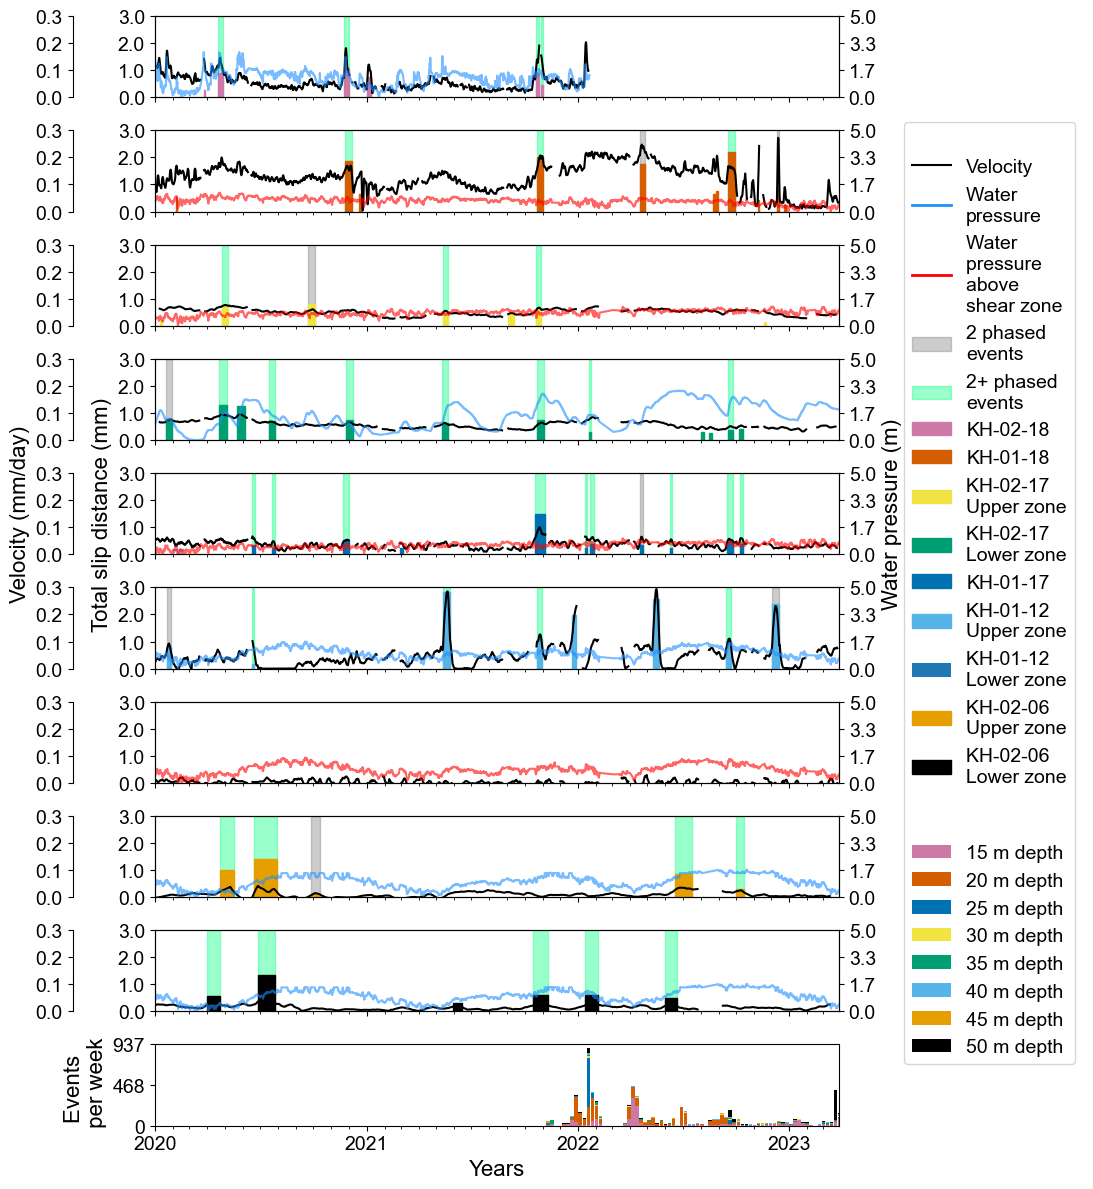

In [4]:
# total slip distance vs time + water pressure!

# to remove ax from right side and show it on the left side
def yax_left_side(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
    ax.spines["left"].set_position(("axes", spacing))
    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("left")
    
n_rows = 10
n_cols = 1
fig, ax = plt.subplots(n_rows, ncols=n_cols, sharex=True, figsize=((11), (12))) # , figsize=((13), (7))

spacing = -0.12 # spacing for left y-axis
color_water = 'dodgerblue'
color_water_shearzone = 'red'
color_velocity = 'black'

# Create a gridspec layout with 2 rows and 2 columns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(n_rows, 2, width_ratios=[0.8, 0.2])

ax = []
ax_y = []
ax_yy = []
for i in range(n_rows):
    ax.append(plt.subplot(gs[i, 0]))
for i in range(n_rows-1):
    ax_y.append(ax[i].twinx())
    ax_yy.append(ax[i].twinx())

# setting start time for plots
start_time = np.datetime64('2020-01-01')
end_time = KH0118Disp.index[-1]
end_time_special = KH0218Disp.index[-1]

col = 2 # velocity
# col = 1 # displacement lowpass filtered

# # legend
# ax_yy[0].plot(file.index, file.values+100, color=color_water, zorder=0, alpha=0.6, label='Water \npressure')
# ax_yy[0].plot(wp_inplane.index, wp_inplane.values+100, color=color_water_shearzone, zorder=1, alpha=0.6, label='Water \npressure \nin shear plane')

# KH0218
file = KH0218Disp_creep[KH0218Disp_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2)
    alligned_x.append(x)
ax[0].bar(alligned_x, file['total_slip_distance'], width = file['duration'].values.astype(float)/24, color=colors[0], ec=colors[0], label='KH-02-18', zorder=2)
file =  KH0218Disp[KH0218Disp.index.slice_indexer(start_time,end_time_special)]
ax_y[0].plot(file.index, file.iloc[:,col], color=color_velocity, label='Velocity')
yax_left_side(ax_y[0])
ax_y[0].spines["left"].set_visible(True) # Second, show the right spine
# adding water pressure
file = KH0218Piez_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time_special)]
file = file['Mod134_Water pressure [m]:']
# ax_yy[0].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='Water \npressure')
file = KH0218Piez_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time_special)]
wp_inplane = file.loc[file['Mod134_Water pressure in shear zone [kPa]:'] > 0]['Mod134_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod134_Water pressure in shear zone [kPa]:'] == 0]['Mod134_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[0].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[0].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')
    
# legend
# legend
ax_yy[0].plot(file.index, file.values+100, color=color_water, zorder=0, alpha=0.6, label='Water \npressure')
ax_yy[0].plot(wp_inplane.index, wp_inplane.values+100, color=color_water_shearzone, zorder=1, alpha=0.6, label='Water \npressure \nin shear plane')

# KH0118
file = KH0118Disp_creep[KH0118Disp_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[1].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=colors[1], ec=colors[1], label='KH-01-18', zorder=2)
file = KH0118Disp[KH0118Disp.index.slice_indexer(start_time,end_time)]
ax_y[1].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[1])
ax_y[1].spines["left"].set_visible(True)
# adding water pressure
file = KH0118Piez_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod63_Water pressure [m]:'] # used Mod82 before but above shear zone, 63 is in the shear zone, 53 is below shear zone
# ax_yy[1].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='')
file = KH0118Piez_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod63_Water pressure in shear zone [kPa]:'] > 0]['Mod63_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod63_Water pressure in shear zone [kPa]:'] == 0]['Mod63_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[1].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[1].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')

# KH0217 Upper
file = KH0217DispUpperZone_creep[KH0217DispUpperZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[2].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=colors[3], ec=colors[3], label='KH-02-17 \nUpper zone', zorder=2)
file = KH0217DispUpperZone[KH0217DispUpperZone.index.slice_indexer(start_time,end_time)]
ax_y[2].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[2])
ax_y[2].spines["left"].set_visible(True)
# adding water pressure
file = KH0217PiezUpperZone_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod98_Water pressure [m]:']  # It used to be Mod52, but changed so that it measures in shear zone
# ax_yy[2].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='')
file = KH0217PiezUpperZone_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod98_Water pressure in shear zone [kPa]:'] > 0]['Mod98_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod98_Water pressure in shear zone [kPa]:'] == 0]['Mod98_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[2].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[2].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')

# KH0217 Lower
file = KH0217DispLowerZone_creep[KH0217DispLowerZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[3].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=colors[4], ec=colors[4], label='KH-02-17 \nLower zone', zorder=2)
file = KH0217DispLowerZone[KH0217DispLowerZone.index.slice_indexer(start_time,end_time)]
ax_y[3].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[3])
ax_y[3].spines["left"].set_visible(True)
# adding water pressure
file = KH0217PiezLowerZone.copy()
file = file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod52_Water pressure [m]:']
# ax_yy[3].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='')
file = KH0217PiezLowerZone_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod52_Water pressure in shear zone [kPa]:'] > 0]['Mod52_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod52_Water pressure in shear zone [kPa]:'] == 0]['Mod52_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[3].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[3].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')


# KH0117
file = KH0117Disp_creep[KH0117Disp_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[4].bar(alligned_x, file['total_slip_distance'],  width = file['duration'].astype(float)/24, color=colors[2], ec=colors[2], label='KH-01-17', zorder=2)
file = KH0117Disp[KH0117Disp.index.slice_indexer(start_time,end_time)]
ax_y[4].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[4])
ax_y[4].spines["left"].set_visible(True)
# adding water pressure
file = KH0117Piez_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod69_Water pressure [m]:'] # Mod56 before. 69 is in shear zone, Mod56 next below shear zone, 75 is above
# ax_yy[4].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='') # using file.values-np.nanmin(file.values)-6.5 to removing the big down ward movements to make the relative change easier to see
# file = file['Mod69_Water pressure [m]:'] # Mod56 before. 69 is in shear zone, Mod56 next below shear zone, 75 is above
# ax_yy[4].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=1, alpha=0.6, label='')
file = KH0117Piez_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod69_Water pressure in shear zone [kPa]:'] > 0]['Mod69_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod69_Water pressure in shear zone [kPa]:'] == 0]['Mod69_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[4].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[4].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')


# KH0112 Upper
file = KH0112DispUpperZone_creep[KH0112DispUpperZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[5].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=colors[5], ec=colors[5], label='KH-01-12 \nUpper zone', zorder=2)
file = KH0112DispUpperZone[KH0112DispUpperZone.index.slice_indexer(start_time,end_time)]
ax_y[5].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[5])
ax_y[5].spines["left"].set_visible(True)
# adding water pressure
file = KH0112PiezUpperZone.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod30_Water pressure [m]:']
# ax_yy[5].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='')
file = KH0112PiezUpperZone_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod30_Water pressure in shear zone [kPa]:'] > 0]['Mod30_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod30_Water pressure in shear zone [kPa]:'] == 0]['Mod30_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[5].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[5].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')

# KH0112 Lower
file = KH0112DispLowerZone_creep[KH0112DispLowerZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[6].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=colors[8], ec=colors[8], label='KH-01-12 \nLower zone', zorder=2)
file = KH0112DispLowerZone[KH0112DispLowerZone.index.slice_indexer(start_time,end_time)]
ax_y[6].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[6])
ax_y[6].spines["left"].set_visible(True)
# adding water pressure
file = KH0112PiezLowerZone.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod30_Water pressure [m]:']
# ax_yy[6].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='')
file = KH0112PiezLowerZone_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod30_Water pressure in shear zone [kPa]:'] > 0]['Mod30_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod30_Water pressure in shear zone [kPa]:'] == 0]['Mod30_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[6].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[6].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')

# KH0206 Upper
file = KH0206DispUpperZone_creep[KH0206DispUpperZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2) # to start at actual data and not center on it
    alligned_x.append(x)
ax[7].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=colors[6], ec=colors[6], label='KH-02-06 \nUpper zone', zorder=2) # width /24 due to each point 1 day
file = KH0206DispUpperZone[KH0206DispUpperZone.index.slice_indexer(start_time,end_time)]
ax_y[7].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[7])
ax_y[7].spines["left"].set_visible(True)
# adding water pressure
file = KH0206PiezUpperZone.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod35_Water pressure [m]:']
# ax_yy[7].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='')
file = KH0206PiezUpperZone_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod35_Water pressure in shear zone [kPa]:'] > 0]['Mod35_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod35_Water pressure in shear zone [kPa]:'] == 0]['Mod35_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[7].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[7].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')
    
# KH0206 Lower
file = KH0206DispLowerZone_creep[KH0206DispLowerZone_creep['date_start'] > start_time]
alligned_x = []
for i,d in enumerate(file['event']):
    x = file['date_start'][d]+timedelta(hours=(file['duration'][d].astype(float))/2)
    alligned_x.append(x)
ax[8].bar(alligned_x, file['total_slip_distance'], width = file['duration'].astype(float)/24, color=colors[7], ec=colors[7], label='KH-02-06 \nLower zone', zorder=2)
file = KH0206DispLowerZone[KH0206DispLowerZone.index.slice_indexer(start_time,end_time)]
ax_y[8].plot(file.index, file.iloc[:,col], color=color_velocity, label='')
yax_left_side(ax_y[8])
ax_y[8].spines["left"].set_visible(True)
# adding water pressure
file = KH0206PiezLowerZone.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
file = file['Mod35_Water pressure [m]:']
# ax_yy[8].plot(file.index, file.values-np.nanmin(file.values), color=color_water, zorder=0, alpha=0.6, label='')
file = KH0206PiezLowerZone_raw.copy()
file =  file[file.index.slice_indexer(start_time,end_time)]
wp_inplane = file.loc[file['Mod35_Water pressure in shear zone [kPa]:'] > 0]['Mod35_Water pressure [m]:'] # only when pressure in shear zone
wp_not_inplane = file.loc[file['Mod35_Water pressure in shear zone [kPa]:'] == 0]['Mod35_Water pressure [m]:'] # only when water level is not in shear zone
if wp_not_inplane.empty == False:
    ax_yy[8].plot(wp_not_inplane.index, wp_not_inplane.values-np.nanmin(wp_not_inplane.values), color=color_water, zorder=1, alpha=0.6, label='')
if wp_inplane.empty == False:
    ax_yy[8].plot(wp_inplane.index, wp_inplane.values-np.nanmin(wp_inplane.values), color=color_water_shearzone, zorder=1, alpha=0.6, label='')


# highlighting creep bursts that are coinciding

# coloring
two = 'gray'
multi = 'springgreen'

file = KH0218Disp_creep.copy()
ax[0].axvspan(file.date_start[1], file.date_end[1], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[0].axvspan(file.date_start[2], file.date_end[2], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[0].axvspan(file.date_start[4], file.date_end[4], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[0].axvspan(file.date_start[5], file.date_end[5], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4) # number 5 due to missing velocity for a short time..
# file = KH0117Disp_creep.copy() # because to late in time series to detect
# ax[0].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)

file = KH0118Disp_creep.copy()
ax[1].axvspan(file.date_start[1], file.date_end[1], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[1].axvspan(file.date_start[3], file.date_end[3], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[1].axvspan(file.date_start[4], file.date_end[4], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[1].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[1].axvspan(file.date_start[9], file.date_end[9], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
# file = KH0117Disp_creep.copy() # To poor detection
# ax[1].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)

file = KH0217DispUpperZone_creep.copy()
ax[2].axvspan(file.date_start[3], file.date_end[3], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[2].axvspan(file.date_start[5], file.date_end[5], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[2].axvspan(file.date_start[6], file.date_end[6], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[2].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[2].axvspan(file.date_start[9], file.date_end[9], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)

file = KH0217DispLowerZone_creep.copy()
ax[3].axvspan(file.date_start[0], file.date_end[0], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[1], file.date_end[1], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[2], file.date_end[2], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[3], file.date_end[3], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[5], file.date_end[5], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[6], file.date_end[6], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[8], file.date_end[8], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[9], file.date_end[9], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[3].axvspan(file.date_start[12], file.date_end[12], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)

file = KH0117Disp_creep.copy()
ax[4].axvspan(file.date_start[0], file.date_end[0], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[1], file.date_end[1], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[2], file.date_end[2], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[4], file.date_end[4], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[5], file.date_end[5], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[6], file.date_end[6], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[7], file.date_end[7], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[8], file.date_end[8], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[9], file.date_end[9], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[4].axvspan(file.date_start[10], file.date_end[10], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)

file = KH0112DispUpperZone_creep.copy()
ax[5].axvspan(file.date_start[3], file.date_end[3], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[5].axvspan(file.date_start[4], file.date_end[4], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[5].axvspan(file.date_start[5], file.date_end[5], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[5].axvspan(file.date_start[6], file.date_end[6], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[5].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[5].axvspan(file.date_start[10], file.date_end[10], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[5].axvspan(file.date_start[11], file.date_end[11], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)

file = KH0112DispLowerZone_creep.copy()
ax[6].axvspan(file.date_start[7], file.date_end[7], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)

file = KH0206DispUpperZone_creep.copy()
ax[7].axvspan(file.date_start[1], file.date_end[1], facecolor=two, edgecolor=two, label='2 phased \nevents', zorder=1, alpha=0.4)
ax[7].axvspan(file.date_start[2], file.date_end[2], facecolor=multi, edgecolor=multi, label='2+ phased \nevents', zorder=1, alpha=0.4)
ax[7].axvspan(file.date_start[4], file.date_end[4], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[7].axvspan(file.date_start[5], file.date_end[5], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[7].axvspan(file.date_start[6], file.date_end[6], facecolor=two, edgecolor=two, label='', zorder=1, alpha=0.4)
ax[7].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[7].axvspan(file.date_start[8], file.date_end[8], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)

file = KH0206DispLowerZone_creep.copy()
ax[8].axvspan(file.date_start[7], file.date_end[7], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[8].axvspan(file.date_start[8], file.date_end[8], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[8].axvspan(file.date_start[10], file.date_end[10], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[8].axvspan(file.date_start[11], file.date_end[11], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)
ax[8].axvspan(file.date_start[12], file.date_end[12], facecolor=multi, edgecolor=multi, label='', zorder=1, alpha=0.4)

### Adding seismics
seismicity_sub =  seismicity_bh_class
seismicity_sub = seismicity_sub.resample('1W').sum()
# seismicity_sub =  seismicity_sub[seismicity_sub.index.slice_indexer(start_time,end_time)]

ini = np.zeros(len(seismicity_sub),dtype=int)
for i, CL in enumerate(seismicity_sub.columns):
    nEvents = seismicity_sub.loc[:,CL].values
    ax[9].bar(dates.date2num(seismicity_sub.index), nEvents, alpha=1.0, align='edge', width=6, label=CL, bottom=ini, linewidth=0, color=colors[i]) # pd.Timedelta(days=7)
    ini = ini + nEvents

# setting time for this axis
ax[9].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

miny,maxy = ax[9].get_ylim()

# # available data
# df = seismicity_bh_availability.copy()
# zero_start = mpl.dates.date2num(start_time)
# for i,d in enumerate(df.iloc[:,0]):
#     xmin = (mpl.dates.date2num(df.iloc[i,0])-zero_start)/(mpl.dates.date2num(end_time)-zero_start)
#     xmax = (mpl.dates.date2num(df.iloc[i,1])-zero_start)/(mpl.dates.date2num(end_time)-zero_start)
#     ax[9].axhspan(ymin=-maxy/40, ymax=-5, xmin=xmin, xmax=xmax, facecolor='deepskyblue', edgecolor='deepskyblue', label='Missing data') # ', edgecolor='gray', label='Missing data'
# # black outer edge
#     xmin = (mpl.dates.date2num(df.iloc[0,0])-zero_start)/(mpl.dates.date2num(end_time)-zero_start)
# xmax = (mpl.dates.date2num(df.iloc[-1,1])-zero_start)/(mpl.dates.date2num(end_time)-zero_start)
# # ax.axhspan(ymin=-maxy/40, ymax=-5, xmin=xmin, xmax=xmax, facecolor='None', edgecolor='black', label='') # only since start of seismic dataset
# ax[9].axhspan(ymin=-maxy/40, ymax=-5, xmin=0, xmax=1, facecolor='None', edgecolor='black', label='') # if entire range
# ax[9].set_ylim((-maxy/40)-1.5,maxy)
# # ax[9].set_ylim((-maxy/40)-1.5,maxy)

###
n_rows = n_rows-1 # quickfix

for i in range(n_rows):
    # adjusting gridlines
    nticks = 4
    ax[i].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_y[i].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
    ax_y[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_yy[i].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
    ax_yy[i].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


# ax.set_title('highest number is closest to the top of borehole')
ax[9].set_xlabel('Years')
ax[4].set_ylabel('Total slip distance (mm)')
ax_y[4].set_ylabel('Velocity (mm/day)')
ax_yy[4].set_ylabel('Water pressure (m)')

# creating similar y-axes
# setting y limits y-axis left (slip distance)

for i in range(n_rows):
    ymax = 0
    ymi, yma = ax[i].get_ylim()
    yma = math.ceil(yma)
    if yma > ymax:
        ymax = yma
ymin = 0
for i in range(n_rows):
    ax[i].set_ylim([ymin, 3])
    ax[i].set_xlim([start_time, end_time])

# setting y limits second left y-axis (velocity)
for i in range(n_rows):
    ymax = 0
    ymi, yma = ax_y[i].get_ylim()
#     yma = math.ceil(yma)
    if yma > ymax:
        ymax = yma
ymin = 0
for i in range(n_rows):
    ax_y[i].set_ylim([ymin, 0.3])

# setting y limits right y-axis (water pressure)
for i in range(n_rows):
    ymax = 0
    ymi, yma = ax_yy[i].get_ylim() # this did not work nice for the twinx
    yma = math.ceil(yma)
    if yma > ymax:
        ymax = yma
ymin = 0
for i in range(n_rows):
    ax_yy[i].set_ylim([ymin, 5]) # setting manually, 5 for mod53 kh0117 and 3.3 if mod69

# Fixing seismic data plot
nticks = 3
ax[9].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[9].yaxis.set_major_formatter(FormatStrFormatter('%1.f'))
# ymi, yma = ax[9].get_ylim() # fixing this higher up
# ax[9].set_ylim([0, 900]) # 1800
ax[9].set_ylabel('Events \n per week')

# # titles
# ax[0].title.set_text('KH-02-18')
# ax[1].title.set_text('KH-01-18')
# ax[2].title.set_text('KH-02-17 Upper zone')
# ax[3].title.set_text('KH-02-17 Lower zone')
# ax[4].title.set_text('KH-01-17')
# ax[5].title.set_text('KH-01-12 Upper zone')
# ax[6].title.set_text('KH-01-12 Lower zone')
# ax[7].title.set_text('KH-02-06 Upper zone')
# ax[8].title.set_text('KH-02-06 Lower zone')

# one legend
from matplotlib.patches import Rectangle

title1 = '$\\bf{}$'
title2 = '\n$\\bf{}$'

# # legend
# ax_yy[0].plot(file.index, file.values+100, color=color_water, zorder=0, alpha=0.6, label='Water \npressure')
# ax_yy[0].plot(wp_inplane.index, wp_inplane.values+100, color=color_water_shearzone, zorder=1, alpha=0.6, label='Water \npressure \nin shear plane')

from matplotlib.lines import Line2D
# lines, labels = ax_yy[0].get_legend_handles_labels()
# labels = unique(labels)
water = ([Line2D([0], [0], color=color_water, lw=2)],['Water \npressure'])
water_shear_zone = ([Line2D([0], [0], color=color_water_shearzone, lw=2)],['Water \npressure \nabove \nshear zone'])

handles, labels = [(a + b + c + d + e + f + g + h + i + j + k + l + m + n + o) for a, b, c, d, e, f, g, h, i, j, k, l, m, n, o in zip(
    ([Rectangle((0,0), 0, 0, color='w')],[title1]),
    ax_y[0].get_legend_handles_labels(), water, water_shear_zone, ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels(),
    ax[4].get_legend_handles_labels(), ax[5].get_legend_handles_labels(), ax[6].get_legend_handles_labels(), ax[7].get_legend_handles_labels(), ax[8].get_legend_handles_labels(),
    ([Rectangle((0,0), 0, 0, color='w')],[title2]), ax[9].get_legend_handles_labels())]
order = [0,1,2,3, 11,12, 4,5,6,7,8,9,10, 13,14, 15,16,17,18,19,20,21,22,23] # set order of legend


# fig.subplots_adjust(wspace=-0.45)
leg = fig.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc = (0.827, 0.105)) # needs to shrink plot to accomodate figure
               
# Modifying the last 8 legend labels
new_labels = ['15 m depth','20 m depth','25 m depth','30 m depth','35 m depth','40 m depth','45 m depth','50 m depth']

# Updating the legend labels
for i in range(-8, 0):
    leg.texts[i].set_text(new_labels[i])


# removing tick labels from the xaxis
for i in range(n_rows):
    ax[i].xaxis.set_tick_params(labelbottom=False)

# removing tick labels from the xaxis
for i in range(n_rows):

    # Ensure the first year is included
    start_year = KH0218Disp.index.min().year
    end_year = KH0117Disp.index.max()
    ax[i].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

    # Major ticks for years
    years = mdates.YearLocator()   # Locator for every year
    years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
    ax[i].xaxis.set_major_locator(years)
    ax[i].xaxis.set_major_formatter(years_fmt)

    # Minor ticks for months
    months = mdates.MonthLocator()   # Locator for every month
    months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
    ax[i].xaxis.set_minor_locator(months)
    # Apply the year format for the major ticks again
    ax[i].xaxis.set_major_formatter(years_fmt)
    ax[i].set(xticklabels=[])

# Ensure the first year is included
start_year = KH0218Disp.index.min().year
end_year = KH0117Disp.index.max()
ax[9].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax[9].xaxis.set_major_locator(years)
ax[9].xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax[9].xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax[9].xaxis.set_major_formatter(years_fmt)


fig.tight_layout()
plt.show()

# saving
path = 'plots\\'
save_name = f'{path}Figure4_SI.png'
fig.savefig(save_name, dpi=600)

C:\Users\andregas\AppData\Local\Temp\ipykernel_4392\2355338653.py:444: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('dodgerblue')
C:\Users\andregas\AppData\Local\Temp\ipykernel_4392\2355338653.py:445: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('purple')


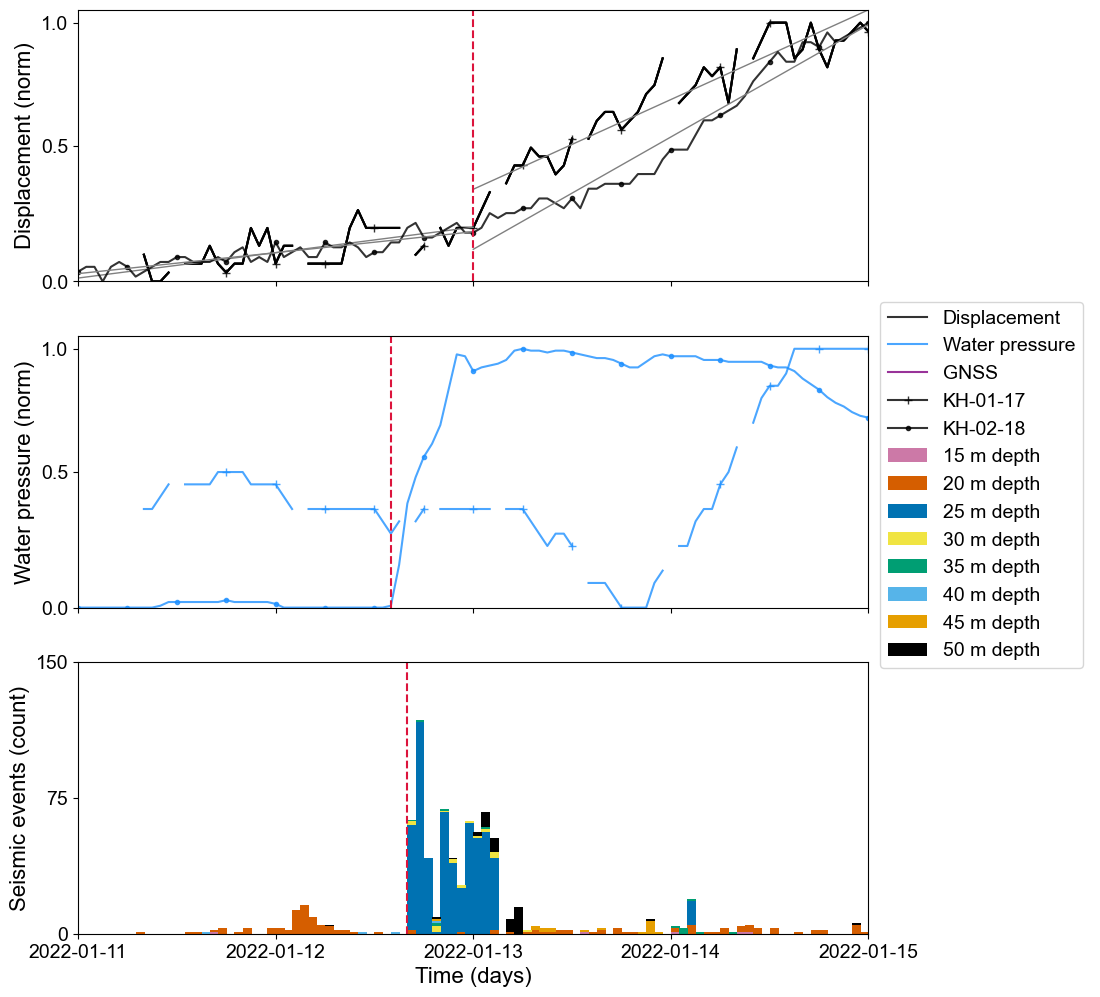

In [6]:
###  NEW FIGURE 8  ####

# Zoom on multiple events at same time
# looking at creep bursts versus water pressure

# TO DO !
# Adjust for x-axis so it is tight on both sides
# Only plot y-axis on the right edge as the y-axis is on the left
# Look through water pressures with Clara and see if I can use some of the other deeper modules to plot

# # overview
# start_time = '2022-01-05 00:00:00'
# end_time = '2022-01-20 00:00:00'

# zoom
start_time = '2022-01-11 00:00:00'
end_time = '2022-01-15 00:00:00'

# plotting

ncols = 1
nrows = 3

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 12), sharex=True) # , sharex=True
# fig.subplots_adjust(hspace = .2, wspace=.6)

# water pressure
ax_y = ax[1] # setting gw ax-shortcut

#adjusting plotting lines
markers_on = 6 # space between marker points

# DO NOT SHOW THIS BH DUE TO ITS NOICE, HARD TO SEE DISP ON SHORT TIME
# # KH-02-06
# file = KH0206DispLowerZone_creep.copy()
# file2 = KH0206DispLowerZone_raw.copy()
# velocity = 'Displacement [mm]:'
# file3 = KH0206PiezLowerZone_raw.copy()
# # watermodule = 'Mod35_Water pressure [kPa]:' # non really penetrate shearzone hight
# watermodule = 'Mod35_Water pressure [m]:' # non really penetrate shearzone hight

# df =  file2[velocity]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[0].plot(df.index, normalized, color='black', marker='o', label='KH-02-06 Lower', alpha=0.8, markevery=markers_on)

# df =  file3[watermodule]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax_y.plot(df.index, normalized, color='dodgerblue', marker='o', label='KH-02-06 Lower', alpha=0.8, markevery=markers_on)


# KH-01-17
file = KH0117Disp_creep.copy()
file2 = KH0117Disp_raw.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0117Piez_raw.copy()
# watermodule = 'Mod69_Water pressure [kPa]:' # pressure in shear zone
watermodule = 'Mod69_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod9_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))

### legend fix ###
ax[0].plot(df.index, normalized, color='black', marker='', label='Displacement', alpha=0.8)
ax[0].plot(df.index, normalized, color='black', marker='', label='Water pressure', alpha=0.8)
ax[0].plot(df.index, normalized, color='black', marker='', label='GNSS', alpha=0.8)
#################

# actual plot
ax[0].plot(df.index, normalized, color='black', marker='+', label='KH-01-17', alpha=0.8, markevery=markers_on)

turnpoint = '2022-01-13 00:00:00'
color = 'gray'
# linear fit
# first part
df = normalized.copy()
df =  df[df.index.slice_indexer(start_time,turnpoint)]
df1 = df.reset_index(drop=True)
mod = ols(formula = 'df1.values ~ df1.index', data = df1)
fit = mod.fit() # model fit
regline = fit.params[0] + fit.params[1] * df1.index
ax[0].plot(df.index, regline, color=color, linewidth=1)
# extension = normalized.reset_index(drop=True) # extend beyond dataset
# regline = fit.params[0] + fit.params[1] * extension.index
# plt.plot(normalized.index, regline, color=color, linewidth=1)

#second part
df = normalized.copy()

df =  df[df.index.slice_indexer(turnpoint,end_time)]
df1 = df.reset_index(drop=True)
mod = ols(formula = 'df1.values ~ df1.index', data = df1)
fit = mod.fit() # model fit
regline = fit.params[0] + fit.params[1] * df1.index
ax[0].plot(df.index, regline, color=color, linewidth=1)
# extension = pd.RangeIndex.from_range(range(-48, 49, 1)) # # extend beyond dataset. This is now hardcoded, could be automatic if add dfs instead
# plt.plot(df.index, regline, color=color, linewidth=1) 
# regline = fit.params[0] + fit.params[1] * extension
# plt.plot(normalized.index, regline, color=color, linewidth=1)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='+', label='KH-01-17', alpha=0.8, markevery=markers_on)

# # KH-01-12
# file = KH0112DispUpperZone_creep.copy()
# file2 = KH0112DispUpperZone_raw.copy()
# file3 = KH0112Piez_raw.copy()
# velocity = 'Displacement [mm]:'
# # watermodule = 'Mod134_Water pressure [kPa]:'  # pressure in shear zone
# watermodule = 'Mod30_Water pressure [m]:' # unconfined aquifer
# # watermodule = 'Mod27_Water pressure [m]:' # seasonal oscilations

# df =  file2[velocity]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[0].plot(df.index, normalized, color='black', marker='o', label='KH-01-12', alpha=0.8, markevery=markers_on)

# df =  file3[watermodule]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax_y.plot(df.index, normalized, color='dodgerblue', marker='o', label='KH-01-12', alpha=0.8, markevery=markers_on)

# # KH-02-17 Upper
# file = KH0217DispUpperZone_creep.copy()
# file2 = KH0217DispUpperZone.copy()
# velocity = 'Disp_summed [mm]:'
# file3 = KH0217PiezUpperZone.copy()
# # watermodule = 'Mod52_Water pressure [kPa]:'  # pressure in shear zone
# watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
# # watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

# df =  file2[velocity]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[0].plot(df.index, normalized, color='black', marker='s', label='KH-02-17 Upper', alpha=0.8, markevery=markers_on)

# df =  file3[watermodule]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax_y.plot(df.index, normalized, color='dodgerblue', marker='s', label='KH-02-17 Upper', alpha=0.8, markevery=markers_on)

# # KH-02-17 Lower
# file = KH0217DispLowerZone_creep.copy()
# file2 = KH0217DispLowerZone.copy()
# velocity = 'Disp_summed [mm]:'
# file3 = KH0217PiezLowerZone.copy()
# # watermodule = 'Mod52_Water pressure [kPa]:'  # pressure in shear zone
# watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
# # watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

# df =  file2[velocity]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[0].plot(df.index, normalized, color='black', marker='v', label='KH-02-17 Lower', alpha=0.8, markevery=markers_on)

# df =  file3[watermodule]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax_y.plot(df.index, normalized, color='dodgerblue', marker='v', label='KH-02-17 Lower', alpha=0.8, markevery=markers_on)


# # KH-01-18
# file = KH0118Disp_creep.copy()
# file2 = KH0118Disp_raw.copy()
# velocity = 'Disp_summed [mm]:'
# file3 = KH0118Piez_raw.copy()
# # watermodule = 'Interpolated_Mod63_Water pressure [kPa]:'  # pressure in shear zone
# # watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer

# # watermodule = 'Mod63_Water pressure [m]:' # in shear zone
# watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer

# # watermodule = 'Mod26_Water pressure [m]:' # seasonal oscilations

# df =  file2[velocity]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))

# ### legend fix ###
# ax[0].plot(df.index, normalized, color='black', marker='', label='Displacement', alpha=0.8)
# ax[0].plot(df.index, normalized, color='black', marker='', label='Water pressure', alpha=0.8)
# #################

# ax[0].plot(df.index, normalized, color='black', marker='*', label='KH-01-18', alpha=0.8, markevery=markers_on)

# # linear fit
# turnpoint = '2022-01-13 00:00:00'
# color = 'gray'
# # first part
# df = normalized.copy()
# extension = normalized.reset_index(drop=True)
# df =  df[df.index.slice_indexer(start_time,turnpoint)]
# df1 = df.reset_index(drop=True)
# mod = ols(formula = 'df1.values ~ df1.index', data = df1)
# fit = mod.fit() # model fit
# regline = fit.params[0] + fit.params[1] * extension.index
# ax[0].plot(normalized.index, regline, color=color, linewidth=1)
# #second part
# df = normalized.copy()
# extension = pd.RangeIndex.from_range(range(-48, 49, 1)) # this is now hardcoded, could be automatic if add dfs instead
# df =  df[df.index.slice_indexer(turnpoint,end_time)]
# df1 = df.reset_index(drop=True)
# mod = ols(formula = 'df1.values ~ df1.index', data = df1)
# fit = mod.fit() # model fit
# # regline = fit.params[0] + fit.params[1] * df1.index # how it was before extension
# # plt.plot(df.index, regline, color='k', linewidth=1)
# regline = fit.params[0] + fit.params[1] * extension
# ax[0].plot(normalized.index, regline, color=color, linewidth=1)

# df =  file3[watermodule]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax_y.plot(df.index, normalized, color='dodgerblue', marker='*', label='KH-01-18', alpha=0.8, markevery=markers_on)

# KH-02-18
file = KH0218Disp_creep.copy()
file2 = KH0218Disp_raw.copy()
file3 = KH0218Piez_raw.copy()
velocity = 'Disp_summed [mm]:'
# watermodule = 'Mod134_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod134_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod27_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='.', label='KH-02-18', alpha=0.8, markevery=markers_on)

# linear fit
turnpoint = '2022-01-13 00:00:00'
color = 'gray'
# first part
df = normalized.copy()
df =  df[df.index.slice_indexer(start_time,turnpoint)]
df1 = df.reset_index(drop=True)
mod = ols(formula = 'df1.values ~ df1.index', data = df1)
fit = mod.fit() # model fit
regline = fit.params[0] + fit.params[1] * df1.index
ax[0].plot(df.index, regline, color=color, linewidth=1)
# extension = normalized.reset_index(drop=True) # extension
# regline = fit.params[0] + fit.params[1] * extension.index
# ax[0].plot(normalized.index, regline, color=color, linewidth=1)

#second part
df = normalized.copy()
df =  df[df.index.slice_indexer(turnpoint,end_time)]
df1 = df.reset_index(drop=True)
mod = ols(formula = 'df1.values ~ df1.index', data = df1)
fit = mod.fit() # model fit
regline = fit.params[0] + fit.params[1] * df1.index # how it was before extension
ax[0].plot(df.index, regline, color=color, linewidth=1)
# extension = pd.RangeIndex.from_range(range(-48, 49, 1)) # this is now hardcoded, could be automatic if add dfs instead
# regline = fit.params[0] + fit.params[1] * extension
# ax[0].plot(normalized.index, regline, color=color, linewidth=1)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='.', label='KH-02-18', alpha=0.8, markevery=markers_on)


# GPSs data

# time window for the following data is chosen under the data for the starting and ending borehole

# # GPS data
# data = '2d'

# # mean of several GPSs
# # # 4 hour data 
# # df =  gps3_4h[data]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df1 = df.copy()

# # df =  gps4_4h[data]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df2 = df.copy()

# # df = pd.concat([df1, df2],axis=1)
# # df.dropna(inplace=True) # only mean when data
# # mean_gps = df.mean(axis=1)
# # ax[2].plot(df.index, mean_gps-mean_gps[mean_gps.first_valid_index()], color='black', label='mean 2d GPS 3 and 4 4h')

# # ax[2].plot(df2.index, df2-df2[df2.first_valid_index()], color='red', label='mean 2d GPS 4')
# # ax[2].plot(df1.index, df1-df1[df1.first_valid_index()], color='green', label='mean 2d GPS 3')

# # #12 hour data
# # df =  gps3[data]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df = df-df[df.first_valid_index()]
# # normalized1 = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# # df1 = df.copy()

# df =  gps4[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()]
# normalized2 = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[2].plot(df.index, normalized2, color='purple', marker='.', label='')
# # ax[2].plot(df.index, df, color='purple', marker='.', label='')

# df =  gps6[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()]
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[2].plot(df.index, normalized, color='purple', marker='+', label='')
# # ax[2].plot(df.index, df, color='purple', marker='+', label='')

# # df =  gps10[data]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df4 = df.copy()

# # df = pd.concat([df1, df2],axis=1)
# # df.dropna(inplace=True) # only mean when data
# # mean_gps = df.mean(axis=1)
# # ax[2].plot(df.index, mean_gps-mean_gps[0], color='purple', label='Horizontal 12h \n(mean of GPS 3 and 4)')

# # df = pd.concat([normalized1, normalized2],axis=1)
# # df.dropna(inplace=True) # only mean when data
# # mean_gps = df.mean(axis=1)
# # ax[2].plot(df.index, mean_gps, color='purple', label='Horizontal 12h \n' r'$\binom{\mathsf{Mean \ of}}{\mathsf{GPS \ 3 \ and \ 4}}$')

# seismicity

seismicity_sub =  seismicity_bh_class
seismicity_sub =  seismicity_sub[seismicity_sub.index.slice_indexer(start_time,end_time)]


ini = np.zeros(len(seismicity_sub),dtype=int)
for i, CL in enumerate(seismicity_sub.columns):
    nEvents = seismicity_sub.loc[:,CL].values
    ax[2].bar(dates.date2num(seismicity_sub.index), nEvents, alpha=1, align='edge', width=.045, label=CL, bottom=ini, linewidth=0, color=colors[i]) # pd.Timedelta(days=7)
    ini = ini + nEvents

# y-axis
nticks = 3
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
# ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

ax[0].set_ylim(0, 1.05)
ax[1].set_ylim(0, 1.05)
# ax[2].set_ylim(0, 1.05)
ymax = 150 # nEvents
ax[2].set_ylim(0, ymax)

# Modifying the y-axis tick labels
yticks = ax[0].get_yticks()
yticks[-1] = 1.0
ax[0].set_yticks(yticks)

yticks = ax[1].get_yticks()
yticks[-1] = 1.0
ax[1].set_yticks(yticks)

# yticks = ax[2].get_yticks()
# yticks[-1] = 1.0
# ax[2].set_yticks(yticks)

# # Manually setting gridlines for tick labels. I did not figure out how to do this, so leave it like it is so far
# yticks_to_show = [0.5]
# ax[1].grid(axis='y', which='both')
# ax[1].axhline(y=0.5, color='gray', linestyle='--')


# x-axis
nticks = 6
ax[0].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
# ax[3].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))


# # generate legend
# lines, labels = ax[0].get_legend_handles_labels()
# lines = unique(lines)
# labels = unique(labels)
# ax[0].legend(lines, labels, loc='center left', bbox_to_anchor=(1, -0.25)) #
# leg = ax[0].get_legend() # gets legend handels
# leg.legendHandles[1].set_color('dodgerblue') #changes the last creep burst that is named water pressure and changes the color to dodgerblue
# # leg.legendHandles[-1].set_color('crimson') #changes the last creep burst that is named water pressure and changes the color to dodgerblue

# # Borehole
# # ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# # Water level
# # ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# # GPS
# ax[2].legend(loc='center left', bbox_to_anchor=(1, 1.1))

# # seismic data
# mylabels = ['20 m depth','25 m depth','30 m depth','35 m depth','40 m depth','45 m depth','50 m depth','55 m depth']
# ax[3].legend(labels=mylabels, loc='center left', bbox_to_anchor=(1, 1.12))

# one legend
for i in range(3):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width * 0.85, box.height]) # shrinking axes to accomodate legend
handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[2].get_legend_handles_labels())]
leg = fig.legend(handles, labels, loc = (0.8, 0.33), ncol=1) # center of fig
leg.legendHandles[1].set_color('dodgerblue')
leg.legendHandles[2].set_color('purple')

# Modifying the last 8 legend labels
new_labels = ['15 m depth','20 m depth','25 m depth','30 m depth','35 m depth','40 m depth','45 m depth','50 m depth']

# Updating the legend labels
for i in range(-8, 0):
    leg.texts[i].set_text(new_labels[i])

### version 1, for this, increase the size of figure
# set axis labels
ax[0].set_ylabel('Displacement (norm)')
ax[1].set_ylabel('Water pressure (norm)')
# ax[2].set_ylabel('Displacement (norm)')
ax[2].set_ylabel('Seismic events (count)')
ax[2].set_xlabel('Time (days)')

# ### Version 2
# # set axis labels
# ax[0].set_title('Shear zone displacement')
# ax[1].set_title('Water pressure')
# ax[2].set_title('Surface displacement')
# ax[3].set_title('Seismic events in depth')

# # set axis labels
# ax[0].set_ylabel('norm')
# ax[1].set_ylabel('norm')
# ax[2].set_ylabel('mm')
# ax[3].set_ylabel('count')
# ax[3].set_xlabel('Time (days)')

# removing space on sides of x-axis
ax[0].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[2].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
# ax[3].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

# forcing date every day
import matplotlib.dates as dates
plt.gca().xaxis.set_major_locator(dates.DayLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

# # removing tick labels from the xaxis
# n = 2  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax[3].xaxis.get_ticklabels()) if i % n != 0]

# setting vertical lines to highlight start of burst, water and seismic events
color = 'crimson'
ax[0].axvline(x=pd.Timestamp('2022-01-13 00:00:00'), color=color, linestyle='dashed')
ax[1].axvline(x=pd.Timestamp('2022-01-12 14:00:00'), color=color, linestyle='dashed')
ax[2].axvline(x=pd.Timestamp('2022-01-12 16:00:00'), color=color, linestyle='dashed')

# # # saving
path = 'plots\\'
# save_name = f'{path}Figure5_FirstMulti_overview'
save_name = f'{path}Figure5_FirstMulti_zoom'
fig.savefig(save_name+'.png', dpi=600)

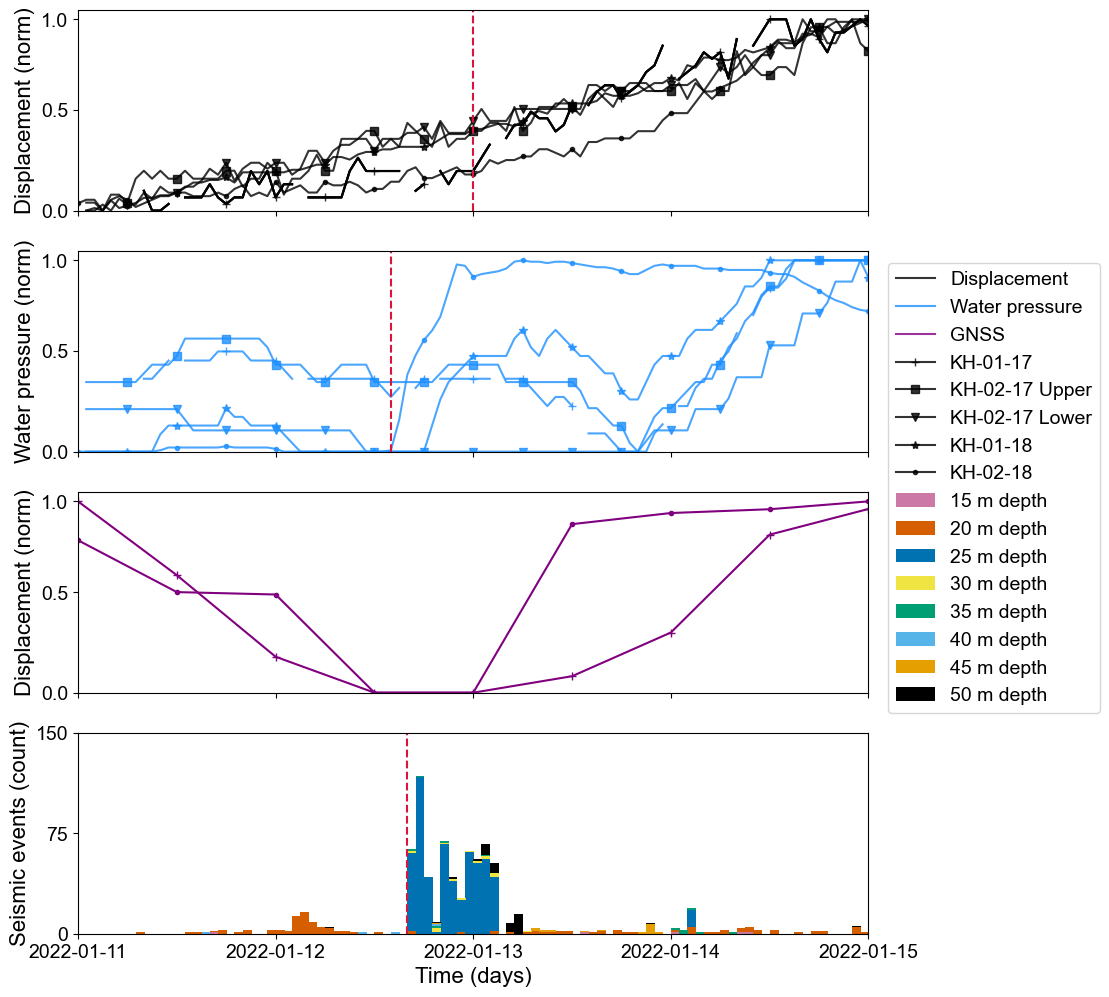

In [93]:
###  Suplementary figure 8 ####

# Zoom on multiple events at same time
# looking at creep bursts versus water pressure

# TO DO !
# Adjust for x-axis so it is tight on both sides
# Only plot y-axis on the right edge as the y-axis is on the left
# Look through water pressures with Clara and see if I can use some of the other deeper modules to plot

# # overview
# start_time = '2022-01-05 00:00:00'
# end_time = '2022-01-20 00:00:00'

# zoom
start_time = '2022-01-11 00:00:00'
end_time = '2022-01-15 00:00:00'

# plotting

ncols = 1
nrows = 4

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 12), sharex=True) # , sharex=True
# fig.subplots_adjust(hspace = .2, wspace=.6)

# water pressure
ax_y = ax[1] # setting gw ax-shortcut

#adjusting plotting lines
markers_on = 6 # space between marker points

# DO NOT SHOW THIS BH DUE TO ITS NOICE, HARD TO SEE DISP ON SHORT TIME
# # KH-02-06
# file = KH0206DispLowerZone_creep.copy()
# file2 = KH0206DispLowerZone_raw.copy()
# velocity = 'Displacement [mm]:'
# file3 = KH0206PiezLowerZone_raw.copy()
# # watermodule = 'Mod35_Water pressure [kPa]:' # non really penetrate shearzone hight
# watermodule = 'Mod35_Water pressure [m]:' # non really penetrate shearzone hight

# df =  file2[velocity]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[0].plot(df.index, normalized, color='black', marker='o', label='KH-02-06 Lower', alpha=0.8, markevery=markers_on)

# df =  file3[watermodule]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax_y.plot(df.index, normalized, color='dodgerblue', marker='o', label='KH-02-06 Lower', alpha=0.8, markevery=markers_on)


# KH-01-17
file = KH0117Disp_creep.copy()
file2 = KH0117Disp_raw.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0117Piez_raw.copy()
# watermodule = 'Mod69_Water pressure [kPa]:' # pressure in shear zone
watermodule = 'Mod69_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod9_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))

### legend fix ###
ax[0].plot(df.index, normalized, color='black', marker='', label='Displacement', alpha=0.8)
ax[0].plot(df.index, normalized, color='black', marker='', label='Water pressure', alpha=0.8)
ax[0].plot(df.index, normalized, color='black', marker='', label='GNSS', alpha=0.8)
#################

# actual plot
ax[0].plot(df.index, normalized, color='black', marker='+', label='KH-01-17', alpha=0.8, markevery=markers_on)
df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='+', label='KH-01-17', alpha=0.8, markevery=markers_on)

# # KH-01-12
# file = KH0112DispUpperZone_creep.copy()
# file2 = KH0112DispUpperZone_raw.copy()
# file3 = KH0112Piez_raw.copy()
# velocity = 'Displacement [mm]:'
# # watermodule = 'Mod134_Water pressure [kPa]:'  # pressure in shear zone
# watermodule = 'Mod30_Water pressure [m]:' # unconfined aquifer
# # watermodule = 'Mod27_Water pressure [m]:' # seasonal oscilations

# df =  file2[velocity]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax[0].plot(df.index, normalized, color='black', marker='o', label='KH-01-12', alpha=0.8, markevery=markers_on)

# df =  file3[watermodule]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()] # first valid number
# normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# ax_y.plot(df.index, normalized, color='dodgerblue', marker='o', label='KH-01-12', alpha=0.8, markevery=markers_on)

# KH-02-17 Upper
file = KH0217DispUpperZone_creep.copy()
file2 = KH0217DispUpperZone.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0217PiezUpperZone.copy()
# watermodule = 'Mod52_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod98_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='s', label='KH-02-17 Upper', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='s', label='KH-02-17 Upper', alpha=0.8, markevery=markers_on)

# KH-02-17 Lower
file = KH0217DispLowerZone_creep.copy()
file2 = KH0217DispLowerZone.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0217PiezLowerZone.copy()
# watermodule = 'Mod52_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='v', label='KH-02-17 Lower', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='v', label='KH-02-17 Lower', alpha=0.8, markevery=markers_on)


# KH-01-18
file = KH0118Disp_creep.copy()
file2 = KH0118Disp_raw.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0118Piez_raw.copy()
# watermodule = 'Interpolated_Mod63_Water pressure [kPa]:'  # pressure in shear zone
# watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer

watermodule = 'Mod63_Water pressure [m]:' # in shear zone
# watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer

# watermodule = 'Mod26_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='*', label='KH-01-18', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='*', label='KH-01-18', alpha=0.8, markevery=markers_on)

# KH-02-18
file = KH0218Disp_creep.copy()
file2 = KH0218Disp_raw.copy()
file3 = KH0218Piez_raw.copy()
velocity = 'Disp_summed [mm]:'
# watermodule = 'Mod134_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod134_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod27_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='.', label='KH-02-18', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='.', label='KH-02-18', alpha=0.8, markevery=markers_on)


# GPSs data

# time window for the following data is chosen under the data for the starting and ending borehole

# GPS data
data = '2d'

# mean of several GPSs
# # 4 hour data 
# df =  gps3_4h[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df1 = df.copy()

# df =  gps4_4h[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df2 = df.copy()

# df = pd.concat([df1, df2],axis=1)
# df.dropna(inplace=True) # only mean when data
# mean_gps = df.mean(axis=1)
# ax[2].plot(df.index, mean_gps-mean_gps[mean_gps.first_valid_index()], color='black', label='mean 2d GPS 3 and 4 4h')

# ax[2].plot(df2.index, df2-df2[df2.first_valid_index()], color='red', label='mean 2d GPS 4')
# ax[2].plot(df1.index, df1-df1[df1.first_valid_index()], color='green', label='mean 2d GPS 3')

# #12 hour data
# df =  gps3[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()]
# normalized1 = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# df1 = df.copy()

df =  gps4[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()]
normalized2 = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[2].plot(df.index, normalized2, color='purple', marker='.', label='')
# ax[2].plot(df.index, df, color='purple', marker='.', label='')

df =  gps6[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()]
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[2].plot(df.index, normalized, color='purple', marker='+', label='')
# ax[2].plot(df.index, df, color='purple', marker='+', label='')

# df =  gps10[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df4 = df.copy()

# df = pd.concat([df1, df2],axis=1)
# df.dropna(inplace=True) # only mean when data
# mean_gps = df.mean(axis=1)
# ax[2].plot(df.index, mean_gps-mean_gps[0], color='purple', label='Horizontal 12h \n(mean of GPS 3 and 4)')

# df = pd.concat([normalized1, normalized2],axis=1)
# df.dropna(inplace=True) # only mean when data
# mean_gps = df.mean(axis=1)
# ax[2].plot(df.index, mean_gps, color='purple', label='Horizontal 12h \n' r'$\binom{\mathsf{Mean \ of}}{\mathsf{GPS \ 3 \ and \ 4}}$')

# seismicity

seismicity_sub =  seismicity_bh_class
seismicity_sub =  seismicity_sub[seismicity_sub.index.slice_indexer(start_time,end_time)]


ini = np.zeros(len(seismicity_sub),dtype=int)
for i, CL in enumerate(seismicity_sub.columns):
    nEvents = seismicity_sub.loc[:,CL].values
    ax[3].bar(dates.date2num(seismicity_sub.index), nEvents, alpha=1, align='edge', width=.045, label=CL, bottom=ini, linewidth=0, color=colors[i]) # pd.Timedelta(days=7)
    ini = ini + nEvents

# y-axis
nticks = 3
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

ax[0].set_ylim(0, 1.05)
ax[1].set_ylim(0, 1.05)
ax[2].set_ylim(0, 1.05)
ymax = 150 # nEvents
ax[3].set_ylim(0, ymax)

# Modifying the y-axis tick labels
yticks = ax[0].get_yticks()
yticks[-1] = 1.0
ax[0].set_yticks(yticks)

yticks = ax[1].get_yticks()
yticks[-1] = 1.0
ax[1].set_yticks(yticks)

yticks = ax[2].get_yticks()
yticks[-1] = 1.0
ax[2].set_yticks(yticks)

# # Manually setting gridlines for tick labels. I did not figure out how to do this, so leave it like it is so far
# yticks_to_show = [0.5]
# ax[1].grid(axis='y', which='both')
# ax[1].axhline(y=0.5, color='gray', linestyle='--')


# x-axis
nticks = 6
ax[0].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[3].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))


# # generate legend
# lines, labels = ax[0].get_legend_handles_labels()
# lines = unique(lines)
# labels = unique(labels)
# ax[0].legend(lines, labels, loc='center left', bbox_to_anchor=(1, -0.25)) #
# leg = ax[0].get_legend() # gets legend handels
# leg.legendHandles[1].set_color('dodgerblue') #changes the last creep burst that is named water pressure and changes the color to dodgerblue
# # leg.legendHandles[-1].set_color('crimson') #changes the last creep burst that is named water pressure and changes the color to dodgerblue

# # Borehole
# # ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# # Water level
# # ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# # GPS
# ax[2].legend(loc='center left', bbox_to_anchor=(1, 1.1))

# # seismic data
# mylabels = ['20 m depth','25 m depth','30 m depth','35 m depth','40 m depth','45 m depth','50 m depth','55 m depth']
# ax[3].legend(labels=mylabels, loc='center left', bbox_to_anchor=(1, 1.12))

# one legend
for i in range(4):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width * 0.85, box.height]) # shrinking axes to accomodate legend
handles, labels = [(a + b + c) for a, b, c in zip(ax[0].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels())]
leg = fig.legend(handles, labels, loc = (0.8, 0.285), ncol=1) # center of fig
leg.legend_handles[1].set_color('dodgerblue')
leg.legend_handles[2].set_color('purple')

# Modifying the last 8 legend labels
new_labels = ['15 m depth','20 m depth','25 m depth','30 m depth','35 m depth','40 m depth','45 m depth','50 m depth']

# Updating the legend labels
for i in range(-8, 0):
    leg.texts[i].set_text(new_labels[i])

### version 1, for this, increase the size of figure
# set axis labels
ax[0].set_ylabel('Displacement (norm)')
ax[1].set_ylabel('Water pressure (norm)')
ax[2].set_ylabel('Displacement (norm)')
ax[3].set_ylabel('Seismic events (count)')
ax[3].set_xlabel('Time (days)')

# ### Version 2
# # set axis labels
# ax[0].set_title('Shear zone displacement')
# ax[1].set_title('Water pressure')
# ax[2].set_title('Surface displacement')
# ax[3].set_title('Seismic events in depth')

# # set axis labels
# ax[0].set_ylabel('norm')
# ax[1].set_ylabel('norm')
# ax[2].set_ylabel('mm')
# ax[3].set_ylabel('count')
# ax[3].set_xlabel('Time (days)')

# removing space on sieds of x-axis
ax[0].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[2].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[3].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

# forcing date every day
import matplotlib.dates as dates
plt.gca().xaxis.set_major_locator(dates.DayLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

# # removing tick labels from the xaxis
# n = 2  # keeps every n row
# [l.set_visible(False) for (i,l) in enumerate(ax[3].xaxis.get_ticklabels()) if i % n != 0]

# setting vertical lines to highlight start of burst, water and seismic events
color = 'crimson'
ax[0].axvline(x=pd.Timestamp('2022-01-13 00:00:00'), color=color, linestyle='dashed')
ax[1].axvline(x=pd.Timestamp('2022-01-12 14:00:00'), color=color, linestyle='dashed')
ax[3].axvline(x=pd.Timestamp('2022-01-12 16:00:00'), color=color, linestyle='dashed')

# # # saving
path = 'plots\\'
# save_name = f'{path}Figure5_FirstMulti_overview'
save_name = f'{path}Figure5_FirstMulti_zoom_suplementary'
fig.savefig(save_name+'.png', dpi=600)

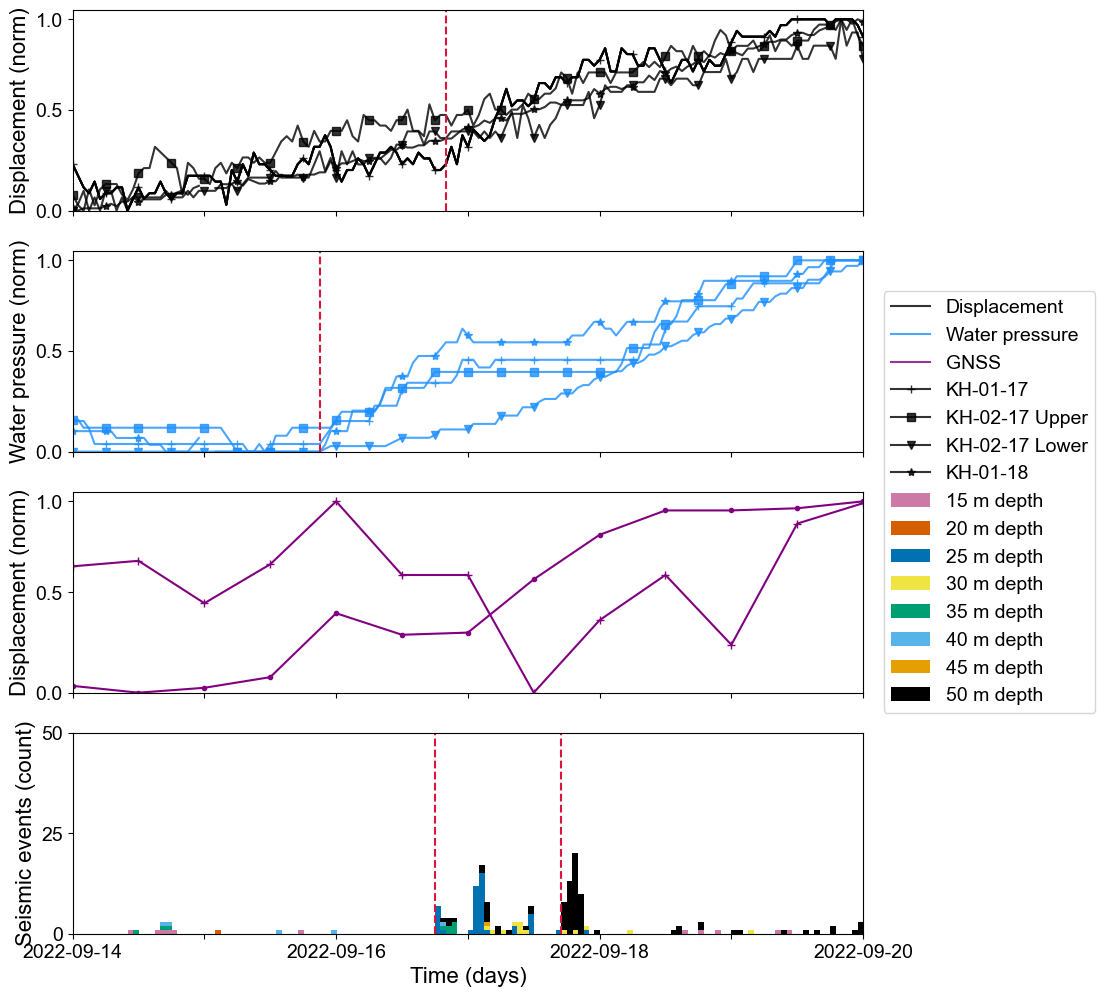

In [94]:
# Second multi event Supplimentary figure

# Zoom on multiple events at same time
# looking at creep bursts versus water pressure

# TO DO !
# Adjust for x-axis so it is tight on both sides
# Only plot y-axis on the right edge as the y-axis is on the left
# Look through water pressures with Clara and see if I can use some of the other deeper modules to plot

# # overview
# start_time = '2022-09-10 00:00:00'
# end_time = '2022-09-30 00:00:00'

# zoom
start_time = '2022-09-14 00:00:00'
end_time = '2022-09-20 00:00:00'

# plotting

ncols = 1
nrows = 4

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 12), sharex=True) # , sharex=True
# fig.subplots_adjust(hspace = .2, wspace=.6)

# water pressure
ax_y = ax[1] # setting gw ax-shortcut

#adjusting plotting lines
markers_on = 6 # space between marker points

# KH-01-17
file = KH0117Disp_creep.copy()
file2 = KH0117Disp_raw.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0117Piez_raw.copy()
# watermodule = 'Mod69_Water pressure [kPa]:' # pressure in shear zone
watermodule = 'Mod69_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod56_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod9_Water pressure [m]:' # seasonal oscilations

# Burst 9

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))

### legend fix ###
ax[0].plot(df.index, normalized, color='black', marker='', label='Displacement', alpha=0.8)
ax[0].plot(df.index, normalized, color='black', marker='', label='Water pressure', alpha=0.8)
ax[0].plot(df.index, normalized, color='black', marker='', label='GNSS', alpha=0.8)
#################

# actual plot
ax[0].plot(df.index, normalized, color='black', marker='+', label='KH-01-17', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='+', label='KH-01-17', alpha=0.8, markevery=markers_on)

# # # DO NOT SHOW THESE OLDER BH DUE TO ITS NOICE, HARD TO SEE DISP ON SHORT TIME
# # # KH-02-06
# # file = KH0206DispUpperZone_creep.copy()
# # file2 = KH0206DispUpperZone_raw.copy()
# # velocity = 'Displacement [mm]:'
# # file3 = KH0206PiezUpperZone_raw.copy()
# # # watermodule = 'Mod35_Water pressure [kPa]:' # non really penetrate shearzone hight
# # watermodule = 'Mod35_Water pressure [m]:' # non really penetrate shearzone hight

# # df =  file2[velocity]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df = df-df[df.first_valid_index()] # first valid number
# # normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# # ax[0].plot(df.index, normalized, color='black', marker='D', label='KH-02-06 Upper', alpha=0.8, markevery=markers_on)

# # df =  file3[watermodule]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df = df-df[df.first_valid_index()] # first valid number
# # normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# # ax_y.plot(df.index, normalized, color='dodgerblue', marker='D', label='KH-02-06 Upper', alpha=0.8, markevery=markers_on)

# # # KH-01-12
# # file = KH0112DispUpperZone_creep.copy()
# # file2 = KH0112DispUpperZone_raw.copy()
# # file3 = KH0112Piez_raw.copy()
# # velocity = 'Displacement [mm]:'
# # watermodule = 'Mod30_Water pressure [m]:' # one piezo


# # df =  file2[velocity]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df = df-df[df.first_valid_index()] # first valid number
# # normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# # ax[0].plot(df.index, normalized, color='black', marker='o', label='KH-01-12', alpha=0.8, markevery=markers_on)

# # df =  file3[watermodule]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df = df-df[df.first_valid_index()] # first valid number
# # normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# # ax_y.plot(df.index, normalized, color='dodgerblue', marker='o', label='KH-01-12', alpha=0.8, markevery=markers_on)

# KH-02-17 Upper
file = KH0217DispUpperZone_creep.copy()
file2 = KH0217DispUpperZone.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0217PiezUpperZone.copy()
# watermodule = 'Mod52_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod98_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='s', label='KH-02-17 Upper', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='s', label='KH-02-17 Upper', alpha=0.8, markevery=markers_on)

# KH-02-17 Lower
file = KH0217DispLowerZone_creep.copy()
file2 = KH0217DispLowerZone.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0217PiezLowerZone.copy()
# watermodule = 'Mod52_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

# Burst number 12

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='v', label='KH-02-17 Lower', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='v', label='KH-02-17 Lower', alpha=0.8, markevery=markers_on)


# KH-01-18
file = KH0118Disp_creep.copy()
file2 = KH0118Disp_raw.copy()
velocity = 'Disp_summed [mm]:'
file3 = KH0118Piez_raw.copy()
# watermodule = 'Interpolated_Mod63_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod63_Water pressure [m]:' # in shear zone
# watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer
# watermodule = 'Mod26_Water pressure [m]:' # seasonal oscilations

# Burst 7

df =  file2[velocity]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[0].plot(df.index, normalized, color='black', marker='*', label='KH-01-18', alpha=0.8, markevery=markers_on)

df =  file3[watermodule]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()] # first valid number
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax_y.plot(df.index, normalized, color='dodgerblue', marker='*', label='KH-01-18', alpha=0.8, markevery=markers_on)

# # # KH-02-18
# # file = KH0218Disp_creep.copy()
# # file2 = KH0218Disp_raw.copy()
# # file3 = KH0218Piez_raw.copy()
# # velocity = 'Disp_summed [mm]:'
# # # watermodule = 'Mod134_Water pressure [kPa]:'  # pressure in shear zone
# # watermodule = 'Mod134_Water pressure [m]:' # unconfined aquifer
# # # watermodule = 'Mod27_Water pressure [m]:' # seasonal oscilations

# # df =  file2[velocity]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df = df-df[df.first_valid_index()] # first valid number
# # normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# # ax[0].plot(df.index, normalized, color='black', marker='.', label='KH-02-18', alpha=0.8, markevery=markers_on)

# # df =  file3[watermodule]
# # df =  df[df.index.slice_indexer(start_time,end_time)]
# # df.index = pd.to_datetime(df.index)
# # df = df-df[df.first_valid_index()] # first valid number
# # normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# # ax_y.plot(df.index, normalized, color='dodgerblue', marker='.', label='KH-02-18', alpha=0.8, markevery=markers_on)


# GPSs data

# time window for the following data is chosen under the data for the starting and ending borehole

# GPS data
data = '2d'

# mean of several GPSs
# # 4 hour data 
# df =  gps3_4h[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df1 = df.copy()

# df =  gps4_4h[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df2 = df.copy()

# df = pd.concat([df1, df2],axis=1)
# df.dropna(inplace=True) # only mean when data
# mean_gps = df.mean(axis=1)
# ax[2].plot(df.index, mean_gps-mean_gps[mean_gps.first_valid_index()], color='black', label='mean 2d GPS 3 and 4 4h')

# ax[2].plot(df2.index, df2-df2[df2.first_valid_index()], color='red', label='mean 2d GPS 4')
# ax[2].plot(df1.index, df1-df1[df1.first_valid_index()], color='green', label='mean 2d GPS 3')

# #12 hour data
# df =  gps3[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df = df-df[df.first_valid_index()]
# normalized1 = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
# df1 = df.copy()

df =  gps4[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()]
normalized2 = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[2].plot(df.index, normalized2, color='purple', marker='.', label='')
# ax[2].plot(df.index, df, color='purple', marker='.', label='')

df =  gps6[data]
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
df = df-df[df.first_valid_index()]
normalized = (df-np.nanmin(df))/(np.nanmax(df)-np.nanmin(df))
ax[2].plot(df.index, normalized, color='purple', marker='+', label='')
# ax[2].plot(df.index, df, color='purple', marker='+', label='')

# df =  gps10[data]
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# df4 = df.copy()

# df = pd.concat([df1, df2],axis=1)
# df.dropna(inplace=True) # only mean when data
# mean_gps = df.mean(axis=1)
# ax[2].plot(df.index, mean_gps-mean_gps[0], color='purple', label='Horizontal 12h \n(mean of GPS 3 and 4)')

# df = pd.concat([normalized1, normalized2],axis=1)
# df.dropna(inplace=True) # only mean when data
# mean_gps = df.mean(axis=1)
# ax[2].plot(df.index, mean_gps, color='purple', label='Horizontal 12h \n' r'$\binom{\mathsf{Mean \ of}}{\mathsf{GPS \ 3 \ and \ 4}}$')

# seismicity

seismicity_sub =  seismicity_bh_class
seismicity_sub =  seismicity_sub[seismicity_sub.index.slice_indexer(start_time,end_time)]


ini = np.zeros(len(seismicity_sub),dtype=int)
for i, CL in enumerate(seismicity_sub.columns):
    nEvents = seismicity_sub.loc[:,CL].values
    ax[3].bar(dates.date2num(seismicity_sub.index), nEvents, alpha=1, align='edge', width=.045, label=CL, bottom=ini, linewidth=0, color=colors[i]) # pd.Timedelta(days=7)
    ini = ini + nEvents

# y-axis
nticks = 3
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[3].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

ax[0].set_ylim(0, 1.05)
ax[1].set_ylim(0, 1.05)
ax[2].set_ylim(0, 1.05)
ymax = 50 # nEvents
ax[3].set_ylim(0, ymax)

# Modifying the y-axis tick labels
yticks = ax[0].get_yticks()
yticks[-1] = 1.0
ax[0].set_yticks(yticks)

yticks = ax[1].get_yticks()
yticks[-1] = 1.0
ax[1].set_yticks(yticks)

yticks = ax[2].get_yticks()
yticks[-1] = 1.0
ax[2].set_yticks(yticks)

# # Manually setting gridlines for tick labels. I did not figure out how to do this, so leave it like it is so far
# yticks_to_show = [0.5]
# ax[1].grid(axis='y', which='both')
# ax[1].axhline(y=0.5, color='gray', linestyle='--')


# x-axis
nticks = 6
ax[0].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[3].xaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))


# # generate legend
# lines, labels = ax[0].get_legend_handles_labels()
# lines = unique(lines)
# labels = unique(labels)
# ax[0].legend(lines, labels, loc='center left', bbox_to_anchor=(1, -0.25)) #
# leg = ax[0].get_legend() # gets legend handels
# leg.legendHandles[1].set_color('dodgerblue') #changes the last creep burst that is named water pressure and changes the color to dodgerblue
# # leg.legendHandles[-1].set_color('crimson') #changes the last creep burst that is named water pressure and changes the color to dodgerblue

# # Borehole
# # ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# # Water level
# # ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

# # GPS
# ax[2].legend(loc='center left', bbox_to_anchor=(1, 1.1))

# # seismic data
# mylabels = ['20 m depth','25 m depth','30 m depth','35 m depth','40 m depth','45 m depth','50 m depth','55 m depth']
# ax[3].legend(labels=mylabels, loc='center left', bbox_to_anchor=(1, 1.12))

# one legend
for i in range(4):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width * 0.85, box.height]) # shrinking axes to accomodate legend
handles, labels = [(a + b + c) for a, b, c in zip(ax[0].get_legend_handles_labels(), ax[2].get_legend_handles_labels(),ax[3].get_legend_handles_labels())]
leg = fig.legend(handles, labels, loc = (0.8, 0.285), ncol=1) # center of fig
leg.legend_handles[1].set_color('dodgerblue')
leg.legend_handles[2].set_color('purple')

# Modifying the last 8 legend labels
new_labels = ['15 m depth','20 m depth','25 m depth','30 m depth','35 m depth','40 m depth','45 m depth','50 m depth']

# Updating the legend labels
for i in range(-8, 0):
    leg.texts[i].set_text(new_labels[i])

### version 1, for this, increase the size of figure
# set axis labels
ax[0].set_ylabel('Displacement (norm)')
ax[1].set_ylabel('Water pressure (norm)')
ax[2].set_ylabel('Displacement (norm)')
ax[3].set_ylabel('Seismic events (count)')
ax[3].set_xlabel('Time (days)')

# ### Version 2
# # set axis labels
# ax[0].set_title('Shear zone displacement')
# ax[1].set_title('Water pressure')
# ax[2].set_title('Surface displacement')
# ax[3].set_title('Seismic events in depth')

# # set axis labels
# ax[0].set_ylabel('norm')
# ax[1].set_ylabel('norm')
# ax[2].set_ylabel('mm')
# ax[3].set_ylabel('count')
# ax[3].set_xlabel('Time (days)')

# removing space on sieds of x-axis
ax[0].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[2].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
ax[3].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

# forcing date every day
import matplotlib.dates as dates
plt.gca().xaxis.set_major_locator(dates.DayLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

# removing tick labels from the xaxis
n = 2  # keeps every n row
[l.set_visible(False) for (i,l) in enumerate(ax[3].xaxis.get_ticklabels()) if i % n != 0]

# # setting vertical lines to highlight start of burst, water and seismic events
color = 'crimson'
ax[0].axvline(x=pd.Timestamp('2022-09-16 20:00:00'), color=color, linestyle='dashed') # 20:00 or 22:00
ax[1].axvline(x=pd.Timestamp('2022-09-15 21:00:00'), color=color, linestyle='dashed')
ax[3].axvline(x=pd.Timestamp('2022-09-16 18:00:00'), color=color, linestyle='dashed')
ax[3].axvline(x=pd.Timestamp('2022-09-17 17:00:00'), color=color, linestyle='dashed')

# # # saving
path = 'plots\\'
# save_name = f'{path}Figure5_FirstMulti_overview'
save_name = f'{path}Figure5_supplementary_second_zoom'
fig.savefig(save_name+'.png', dpi=600)

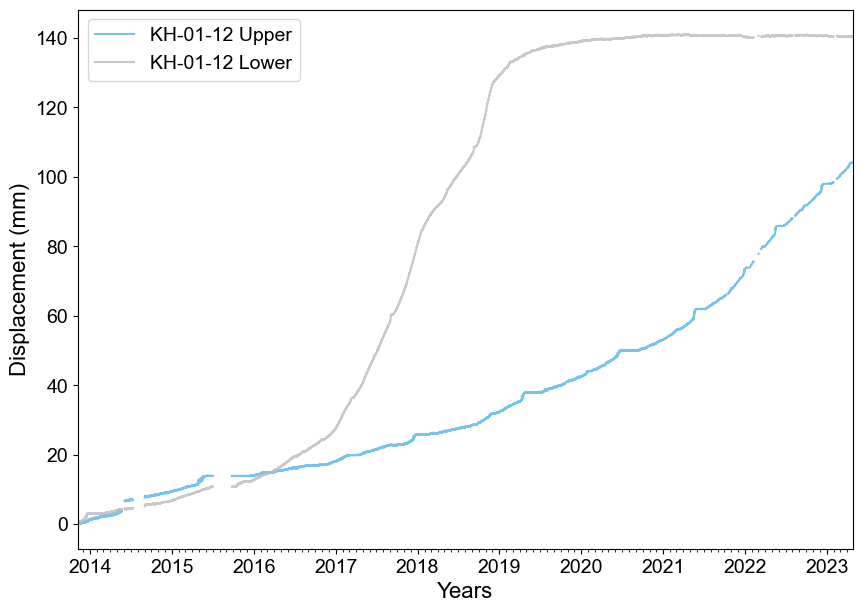

In [13]:
# Displacement borhole, GPS disp, gw, and seismic

# looking at creep bursts 

fig, ax = plt.subplots(figsize=(10, 7))

# # KH-01-12 Upper
file = KH0112DispUpperZone.copy()
# data = '12_days_velocity'
data = 'displacement_butterfilt'

disp = file[data]
ax.plot(disp.index, disp.values-np.nanmin(disp.values), color= colors[5], label='KH-01-12 Upper', alpha=0.8)

# KH-01-12 Lower
file = KH0112DispLowerZone.copy()
# data = '12_days_velocity'
data = 'displacement_butterfilt'

disp = file[data]
ax.plot(disp.index, disp.values-np.nanmin(disp.values), color=colors[8], label='KH-01-12 Lower', alpha=0.8)

# set axis labels
ax.set_ylabel('Displacement (mm)')
ax.set_xlabel('Years')

ax.legend()

# # Ensure the first year is included
# start_year = bh_data.index.min().year
# end_year = bh_data.index.max()
# ax[4].set_xlim(mdates.date2num([f'{start_year}-01-01', f'{end_year}']))

# Major ticks for years
years = mdates.YearLocator()   # Locator for every year
years_fmt = mdates.DateFormatter('%Y') # Formatter for displaying year
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)

# Minor ticks for months
months = mdates.MonthLocator()   # Locator for every month
months_fmt = mdates.DateFormatter('%b') # Formatter for displaying month (Jan, Feb, etc.)
ax.xaxis.set_minor_locator(months)
# Apply the year format for the major ticks again
ax.xaxis.set_major_formatter(years_fmt)

# # removing space on sides of x-axis
# ax[0].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
# ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

path = 'plots\\'
save_name = 'KH0112_transition'
fig.savefig(path+save_name+'.png', dpi=600)

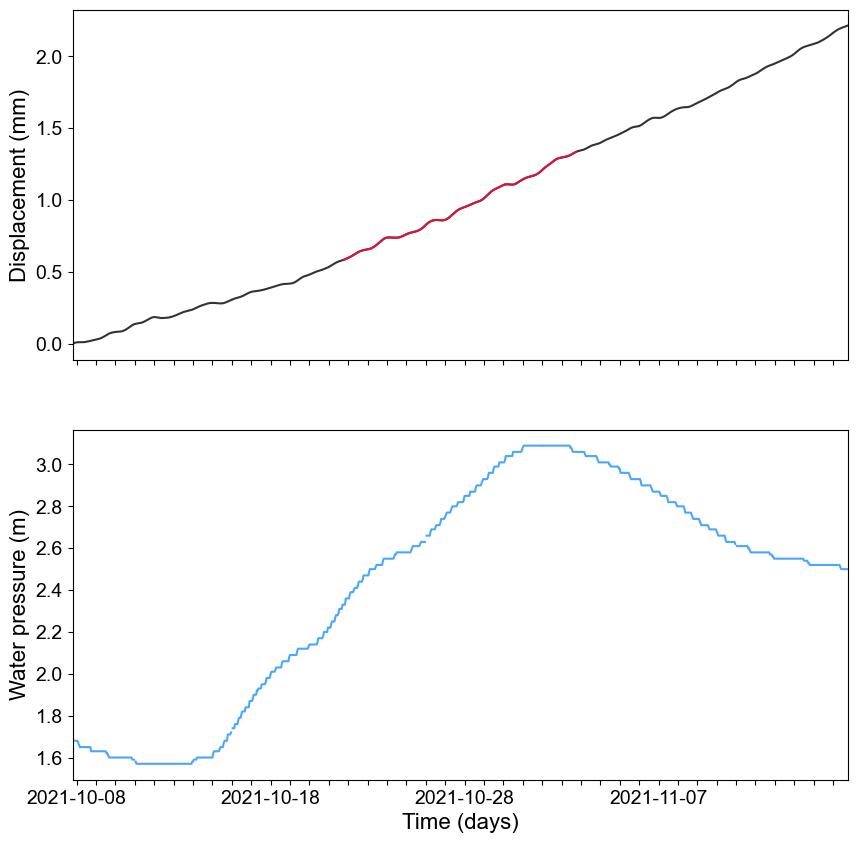

In [9]:
# Displacement borhole, GPS disp, gw, and seismic

# looking at creep bursts 

path = 'plots\\'


from matplotlib.dates import DateFormatter

# # KH-01-18
# i = 4 # creep burst number
# label = 'KH0118'
# save_name = f'{path}SI_localpeak_{label}_burst{i}'

# file = KH0118Disp_creep.copy()
# file2 = KH0118Disp.copy()
# # data = '4_days_velocity'
# data = 'displacement_butterfilt'
# file3 = KH0118Piez_raw.copy()
# # watermodule = 'Mod63_Water pressure in shear zone [kPa]:'  # pressure in shear zone

# watermodule = 'Mod63_Water pressure [m]:' # unconfined aquifer
# # watermodule_temp = 'Mod63_Temperature [C]:' # unconfined aquifer

# # watermodule = 'Mod82_Water pressure [m]:' # unconfined aquifer
# # watermodule_temp = 'Mod82_Temperature [C]:' # unconfined aquifer
# # watermodule = 'Mod26_Water pressure [m]:' # seasonal oscilations

# # KH-02-18
# i = 5 # creep burst number
# label = 'KH0218'
# save_name = f'{path}SI_localpeak_{label}_burst{i}'

# file = KH0218Disp_creep.copy()
# file2 = KH0218Disp.copy()
# # data = '4_days_velocity'
# data = 'displacement_butterfilt'
# file3 = KH0218Piez_raw.copy()
# # watermodule = 'Mod134_Water pressure [kPa]:'  # pressure in shear zone
# watermodule = 'Mod134_Water pressure [m]:' # unconfined aquifer
# watermodule_temp = 'Mod134_Temperature [C]:' # unconfined aquifer
# # watermodule = 'Mod27_Water pressure [m]:' # seasonal oscilations

# # KH-01-17
# i = 4
# label = 'KH0117'
# save_name = f'{path}SI_localpeak_{label}_burst{i}'

# file = KH0117Disp_creep.copy()
# file2 = KH0117Disp.copy()
# # data = '8_days_velocity'
# data = 'displacement_butterfilt'
# file3 = KH0117Piez_raw.copy()
# # watermodule = 'Mod69_Water pressure [kPa]:' # pressure in shear zone
# watermodule = 'Mod69_Water pressure [m]:' # shear zone
# watermodule_temp = 'Mod69_Temperature [C]:' # shear zone
# # watermodule = 'Mod56_Water pressure [m]:'  # unconfined aquifer
# # watermodule = 'Mod9_Water pressure [m]:' # seasonal oscilations unconfined aquifer

# KH-02-17 Lower
i = 8
label = 'KH0217lower'
save_name = f'{path}SI_localpeak_{label}_burst{i}'

file = KH0217DispLowerZone_creep.copy()
file2 = KH0217DispLowerZone.copy()
# data = '12_days_velocity'
data = 'displacement_butterfilt'
file3 = KH0217PiezLowerZone_raw.copy()
# watermodule = 'Mod52_Water pressure [kPa]:'  # pressure in shear zone
watermodule = 'Mod52_Water pressure [m]:' # unconfined aquifer
watermodule_temp = 'Mod52_Temperature [C]:' # unconfined aquifer
# watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

# # KH-02-17 Upper
# i = 4
# label = 'KH0217upper'
# save_name = f'{path}SI_localpeak_{label}_burst{i}'

# file = KH0217DispUpperZone_creep.copy()
# file2 = KH0217DispUpperZone.copy()
# # data = '12_days_velocity'
# data = 'displacement_butterfilt'
# file3 = KH0217PiezUpperZone_raw.copy()
# # watermodule = 'Mod90_Water pressure [kPa]:'  # pressure in shear zone
# watermodule = 'Mod98_Water pressure [m]:' #shear zone
# watermodule_temp = 'Mod98_Temperature [C]:' # shear zone
# # watermodule = 'Mod29_Water pressure [m]:' # seasonal oscilations

# # KH-01-12 Lower
# label = 'KH0112lower'
# file = KH0112DispLowerZone_creep.copy()
# file2 = KH0112DispLowerZone.copy()
# # data = '12_days_velocity'
# data = 'displacement_butterfilt'
# file3 = KH0112PiezLowerZone_raw.copy()
# # watermodule = 'Mod30_Water pressure [kPa]:' # pressure in shear zone
# watermodule = 'Mod30_Water pressure [m]:' # open borehole
# watermodule_temp = 'Mod30_Temperature [C]:' # unconfined aquifer

# # # KH-01-12 Upper
# i = 8
# label = 'KH0112upper'
# save_name = f'{path}SI_localpeak_{label}_burst{i}'

# file = KH0112DispUpperZone_creep.copy()
# file2 = KH0112DispUpperZone.copy()
# # data = '12_days_velocity'
# data = 'displacement_butterfilt'
# file3 = KH0112PiezUpperZone_raw.copy()
# # watermodule = 'Mod30_Water pressure [kPa]:' # pressure in shear zone
# watermodule = 'Mod30_Water pressure [m]:' # open borehole
# watermodule_temp = 'Mod30_Temperature [C]:' # unconfined aquifer


# plotting

ncols = 1
nrows = 2

fig, ax = plt.subplots(nrows, ncols,figsize=(10, 10), sharex=True)

# data before and after event
window_hours = 24*7*2 # hours before and after creep burst * days * weeks
window = pd.Timedelta(window_hours, unit='h')
file.reset_index(inplace=True, drop=True) # making sure index is correct due to time slicing

time_idx_event = pd.date_range(file['date_start'][i], periods=len(file['date'][i].values), freq='H') # for creep burst
time_idx_event_pluss_disp = pd.date_range(file['date_start'][i]-window, periods=len(file['date'][i].values)+window_hours*2, freq='H') # for plotting of additional data

# plot x-axis with date        
disp = file2.loc[time_idx_event_pluss_disp, data]
disp = disp[disp.first_valid_index():]
creep = file2.loc[time_idx_event, data]
creep = creep[creep.first_valid_index():]
water = file3.loc[time_idx_event_pluss_disp, watermodule]
water = water[water.first_valid_index():]

ax[0].plot(disp.index, disp.values-np.nanmin(disp.values), color='black', label='Displacement', alpha=0.8)
ax[0].plot(creep.index, creep.values-np.nanmin(disp.values), color='crimson', label='Creep burst')
ax[1].plot(water.index, water.values, color='dodgerblue', label='Water pressure', alpha=0.8) # -np.nanmin(water.values)

# forcing date every day
import matplotlib.dates as dates
plt.gca().xaxis.set_major_locator(dates.DayLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))

# removing tick labels from the xaxis
n = 10  # keeps every n row so that approx 4 labels along axis
[l.set_visible(False) for (i,l) in enumerate(ax[1].xaxis.get_ticklabels()) if i % n != 0]

# set axis labels
ax[0].set_ylabel('Displacement (mm)')
ax[1].set_ylabel('Water pressure (m)')
ax[1].set_xlabel('Time (days)')

# # removing space on sides of x-axis
# ax[0].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))
# ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

fig.savefig(save_name+'.png', dpi=600)